In [1]:
from VisionEngine.datasets import guppies
from VisionEngine.utils.config import process_config
from VisionEngine.utils import factory
import sys
import os
from PIL import Image
from itertools import product
from dotenv import load_dotenv
from pathlib import Path

import numpy as np
import tensorflow as tf

import tqdm
import warnings
import numba
import pickle
import random

In [2]:
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
GPU = 1

In [4]:
n_latents = 4
latent_size = 10

In [5]:
config_file = "/home/etheredge/Workspace/VisionEngine/VisionEngine/configs/guppy_nouveau_finetune_config.json"
config = process_config(config_file)
checkpoint_path = "/home/etheredge/Workspace/VisionEngine/checkpoints/guppy_nouveau_finetune/2020-230-11/guppy_nouveau_finetune.hdf5"

In [6]:
env_path = Path('../') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [7]:
config.data_loader.use_generated = False
config.data_loader.use_real = True

config.data_loader.shuffle = True

In [8]:
data_loader = factory.create(
            "VisionEngine.data_loaders."+config.data_loader.name
            )(config)

importing VisionEngine.data_loaders.vae_data_loader
getattr DataLoader


In [9]:
with tf.device(f"GPU:{GPU}"):
    model = factory.create(
                "VisionEngine.models."+config.model.name
                )(config)
    model.load(checkpoint_path)

importing VisionEngine.models.nouveau_vae_model
getattr VAEModel
Model: "vlae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
noise_layer (Sequential)        (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
encoder (Model)                 [(None, 524288), (No 38380171    noise_layer[0][0]                
__________________________________________________________________________________________________
variational_layer (VariationalL (None, 10)           5242890     encoder[1][0]                    
______________________________

In [10]:
def embed_images(x, model):
    outputs = [
        model.model.get_layer('variational_layer').output,
        model.model.get_layer('variational_layer_1').output,
        model.model.get_layer('variational_layer_2').output,
        model.model.get_layer('variational_layer_3').output
    ]
    encoder = tf.keras.Model(model.model.inputs, outputs)
    return encoder.predict(x)

In [12]:
with tf.device(f"GPU:{GPU}"):
    data_loader = factory.create(
            "VisionEngine.data_loaders."+config.data_loader.name
            )(config)
    parents_orig = []
    for image, label in data_loader.get_test_data():
        parents_orig.append(image.numpy())
    parents_orig = np.vstack(parents_orig)
    parents = embed_images(data_loader.get_test_data(), model)

importing VisionEngine.data_loaders.vae_data_loader
getattr DataLoader


In [13]:
with tf.device(f'/device:GPU:{GPU}'):
    parents = tf.transpose(tf.Variable(parents), (1,0,2))
    parents = parents[:900]

In [14]:
with tf.device(f"GPU:{GPU}"):
    POPULATION_SIZE = 1000
    BATCH_SIZE = 100
    N_GENERATIONS = 500
    mutation_per = 0.1
    parent_record = []
    
    parent_record.append(parents)  # record the starting generation
    
    persistence=0.5
    temperature=0.2

    orange_min = tf.constant([0.9, 0.55, 0.])
    orange_min = tf.stack([tf.fill((BATCH_SIZE,256,256), orange_min[0]),
              tf.fill((BATCH_SIZE,256,256), orange_min[1]),
              tf.fill((BATCH_SIZE,256,256), orange_min[2])],
              axis=-1)
    orange_max = tf.constant([1., 0.75, 0.1])
    orange_max = tf.stack([tf.fill((BATCH_SIZE,256,256), orange_max[0]),
              tf.fill((BATCH_SIZE,256,256), orange_max[1]),
              tf.fill((BATCH_SIZE,256,256), orange_max[2])],
              axis=-1)
    black_min = tf.constant([0., 0., 0., 0.8])
    black_min = tf.stack([tf.fill((BATCH_SIZE,256,256), black_min[0]),
              tf.fill((BATCH_SIZE,256,256), black_min[1]),
              tf.fill((BATCH_SIZE,256,256), black_min[2])],
              axis=-1)
    black_max = tf.constant([0.2, 0.2, 0.2])
    black_max = tf.stack([tf.fill((BATCH_SIZE,256,256), black_max[0]),
              tf.fill((BATCH_SIZE,256,256), black_max[1]),
              tf.fill((BATCH_SIZE,256,256), black_max[2])],
              axis=-1)

    weights = [1., 1.]

    for _ in tqdm.tqdm_notebook(range(N_GENERATIONS), desc='generation'):
        fitness = []
        ds = tf.data.Dataset.from_tensor_slices(parents).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
        for batch in tqdm.tqdm_notebook(ds, leave=False, desc='fitness loop'):
            batch = tf.reshape(batch, (4, BATCH_SIZE, 10))
            x_hat = model.decoder([batch[0], batch[1], batch[2], batch[3]])
            orange_vals = tf.math.logical_and(
                    tf.math.greater(x_hat,orange_min),
                    tf.math.less(x_hat, orange_max))
            percent_orange = tf.math.divide(
                tf.reduce_sum(tf.cast(tf.reduce_all(
                        orange_vals,axis=(3)
                    ),dtype=tf.float32
                ),axis=(1,2)),
                256*256)
            black_vals = tf.math.logical_and(
                    tf.math.greater(x_hat,black_min),
                    tf.math.less(x_hat, black_max))
            percent_black = tf.math.divide(
                tf.reduce_sum(tf.cast(tf.reduce_all(
                        black_vals,axis=(3)
                    ),dtype=tf.float32
                ),axis=(1,2)),
                256*256)
            # fitness is just a simple weighted sum here
            fit = tf.math.reduce_sum([percent_orange*weights[0],percent_black*weights[1]],axis=0)
            
            rand_subsample = tf.random.uniform([BATCH_SIZE,], minval=0, maxval=len(parents_orig),
                              dtype=tf.dtypes.int32)
            parents_orig_batch = tf.gather(parents_orig, rand_subsample)
            loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x_hat, parents_orig_batch), axis=(1,2))
            fitness.extend(fit * tf.math.exp(-loss*2))

         ####### survivors
        rank = tf.argsort(fitness, direction='DESCENDING')
        parents = tf.gather(parents, rank)
        
        indexes = tf.range(len(parents))
        
#         indices_p = np.random.choice(indexes, int(POPULATION_SIZE*persistence), p=p_dist)
#         indices_p = [[i.numpy()] * p_dist[i].numpy() for i in indexes]
#         indices_p = [item for sublist in indices_p for item in sublist]
#         indices_p = list(tf.random.shuffle(indices_p).numpy())[:int(POPULATION_SIZE*persistence)]
        survivors_p = tf.gather(parents, indexes[:int(POPULATION_SIZE*persistence)])
        
#         indices_t = np.random.choice(indexes, int(POPULATION_SIZE*temperature))
        indices_t = list(tf.random.shuffle(indexes).numpy())[:int(POPULATION_SIZE*temperature)]
        survivors_t = tf.gather(parents, indices_t)
        
        survivors = tf.concat([survivors_p, survivors_t], axis=0)
        
        
        ####### offspring
        # pick a couple of parents
        parent1 = [survivors[i] for i in 
            tf.random.uniform([POPULATION_SIZE - len(survivors),], minval=0, maxval=len(survivors),
                              dtype=tf.dtypes.int32)
        ]

        parent2 = [survivors[i] for i in 
            tf.random.uniform([POPULATION_SIZE - len(survivors),], minval=0, maxval=len(survivors),
                              dtype=tf.dtypes.int32)
        ]

        # randomly combine traits from each parent with equal probability
        mask = tf.dtypes.cast(tf.random.uniform([POPULATION_SIZE - len(survivors),4,10], minval=0, maxval=2,
                              dtype=tf.dtypes.int32), tf.bool)
        
        children = tf.where(mask, parent1, parent2)
                
        values = tf.reduce_mean(tf.stack([parent1[int((POPULATION_SIZE - len(survivors))*.8):], parent2[int((POPULATION_SIZE - len(survivors))*.8):]]), axis=0)
        ix = list(tf.range(int((POPULATION_SIZE - len(survivors))*.2)).numpy())
        indices = tf.stack([
            tf.constant([
                i,
            ]) 
            for i in ix
        ])
        children = tf.tensor_scatter_nd_update(children, indices, values)
        
#         children = tf.concat([children_c, children_x])
#         children = tf.where(mask, parent1, parent2)
        
        # randomly mutate some loci
        ix = list(tf.random.shuffle([i for i in tf.range(len(children))]).numpy())[:int(len(children)*mutation_per)]
        indices = tf.stack([
            tf.constant([[
                i,
                tf.random.uniform(
                    [1,], 
                    minval=0, 
                    maxval=5, 
                    dtype=tf.dtypes.int32).numpy()[0],
                tf.random.uniform(
                    [1,], minval=0, 
                    maxval=11, 
                    dtype=tf.dtypes.int32).numpy()[0],
            ]]) 
            for i in ix
        ])
        
        values = tf.stack([  
            tf.random.uniform(
                [1,], 
                minval=tf.math.reduce_mean(parents)-(tf.math.reduce_std(parents)/2), 
                maxval=tf.math.reduce_mean(parents)+(tf.math.reduce_std(parents)/2), 
                dtype=tf.dtypes.float32)
            for i in ix
        ])
#         values = tf.stack([  
#             [tf.math.reduce_mean(parents)]
#             for i in ix
#         ])

        children = tf.tensor_scatter_nd_update(children, indices, values)
        
        
        parents = tf.concat([survivors, children], axis=0)
        
        parent_record.append(parents)


/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [28]:
# with open("parent_record.p", "wb") as f:
#     pickle.dump(parent_record, f)

In [20]:
# with open("parent_record.p", "rb") as f:
#     parent_record = pickle.load(f)

In [21]:
from PIL import Image
from itertools import product

In [27]:
BATCH_SIZE = 1

generation = 500

i = 5
j = i
image_container = Image.new('RGB', (256*i,256*j))

with tf.device(f"GPU:{GPU}"):
    x_hat = []
    subsample = parent_record[generation][:i*j]
#     indices = tf.range(len(population))
#     indices = np.random.choice(indices, )
#     subsample = tf.gather(population, indices)
    ds = tf.data.Dataset.from_tensor_slices(subsample).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    
    for batch in tqdm.tqdm_notebook(ds, desc='generating'):
        batch = tf.reshape(batch, (4, BATCH_SIZE, 10))
        x_hat.extend(model.decoder([batch[0], batch[1], batch[2], batch[3]]))
    x_hat = tf.reshape(tf.Variable(x_hat), (i,j,256,256,3))
    
    for (k, l) in tqdm.tqdm_notebook(product(range(i),repeat=2), desc='plotting'):
        sample = x_hat.numpy()[k,l,:]
        img = 255 * sample
        img = img.astype(np.uint8)
        image_container.paste(Image.fromarray(img.astype('uint8')), (k*256, l*256))
image_container.save(f'samples_gen_{generation}.jpg')

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


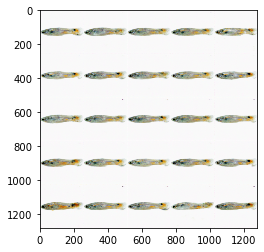

In [26]:
import matplotlib.pyplot as plt
plt.imshow(image_container)

In [36]:
pr = np.stack(parent_record[1:]).reshape(500,1000, 40) 

In [39]:
pop_record = np.mean(pr, axis=1)

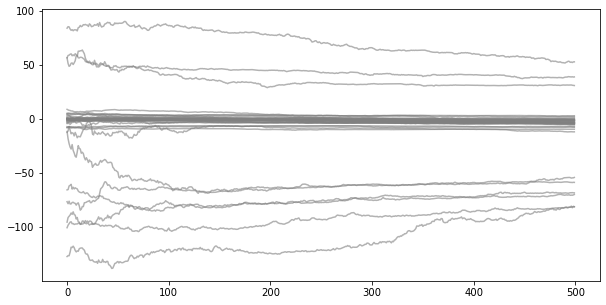

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(pop_record, c='grey', alpha=0.6);

In [41]:
from openTSNE import TSNE
from openTSNE.callbacks import ErrorLogger

In [88]:
len(prs)

3000

In [89]:
prs = np.vstack([pr[i,:] for i in range(len(pr))])

In [91]:
len(prs)

500000

In [93]:
gens = TSNE(callbacks=ErrorLogger(), n_jobs=8).fit(prs)

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteration   50, KL divergence  9.4684, 50 iterations in 12.9362 sec
Iteration  100, KL divergence  9.4675, 50 iterations in 12.8931 sec
Iteration  150, KL divergence  9.4610, 50 iterations in 12.8870 sec
Iteration  200, KL divergence  9.4039, 50 iterations in 12.8760 sec
Iteration  250, KL divergence  9.1523, 50 iterations in 12.9523 sec
Iteration   50, KL divergence  8.3701, 50 iterations in 13.0886 sec
Iteration  100, KL divergence  7.8134, 50 iterations in 12.9892 sec
Iteration  150, KL divergence  7.4493, 50 iterations in 13.3000 sec
Iteration  200, KL divergence  7.1825, 50 iterations in 13.2530 sec
Iteration  250, KL divergence  6.9686, 50 iterations in 12.9697 sec
Iteration  300, KL divergence  6.7883, 50 iterations in 12.8491 sec
Iteration  350, KL divergence  6.6317, 50 iterations in 12.8904 sec
Iteration  400, KL divergence  6.4929, 50 iterations in 12.6545 sec
Iteration  450, KL divergence  6.3678, 50 iterations in 12.7389 sec
Iteration  500, KL divergence  6.2539, 50 iterat

In [118]:
from matplotlib import cm

In [119]:
viridis = cm.viridis

In [ ]:
with tf.device(f"GPU:{GPU}"):
    for g in tqdm.tqdm_notebook(range(500)):
        i = 20
        j = i
        image_container = Image.new('RGB', (256*i,256*j))
        x_hat = []
        subsample = parent_record[g+1][:i*j]
        ds = tf.data.Dataset.from_tensor_slices(subsample).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
        for batch in ds:
            batch = tf.reshape(batch, (4, BATCH_SIZE, 10))
            x_hat.extend(model.decoder([batch[0], batch[1], batch[2], batch[3]]))
        x_hat = tf.reshape(tf.Variable(x_hat), (i,j,256,256,3))

        for (k, l) in product(range(i),repeat=2):
            sample = x_hat.numpy()[k,l,:]
            img = 255 * sample
            img = img.astype(np.uint8)
            image_container.paste(Image.fromarray(img.astype('uint8')), (k*256, l*256))

#         image_container.save(f'evolved_samples/{g:04}.png')
        plt.figure(figsize=(10,10));
        plt.imshow(image_container)
        plt.axis('off');
        plt.tight_layout();
        fig = plt.gcf();
        fig.savefig(f'evolved_samples/{g:04}.png', dpi=300);

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/seaborn/distributions.py:693: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a n

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/seaborn/distributions.py:693: UserWarning: Passing a 2D dat

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/seaborn/distributions.py:693: UserWarning: Passing a 2D dat

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figur

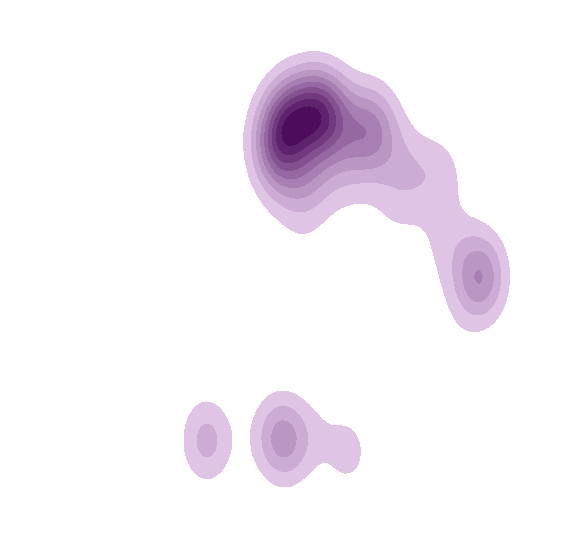

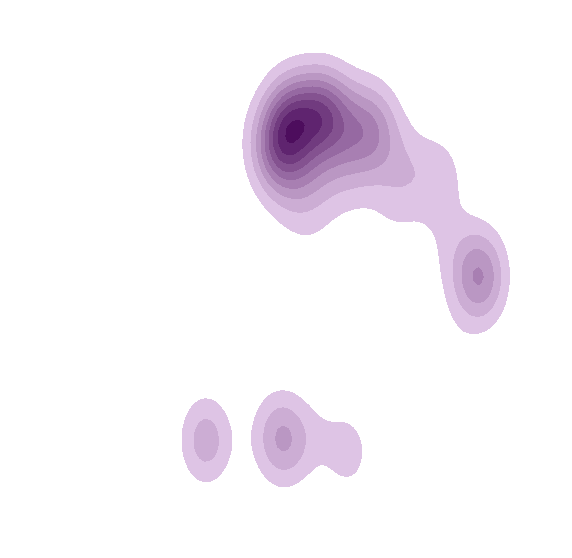

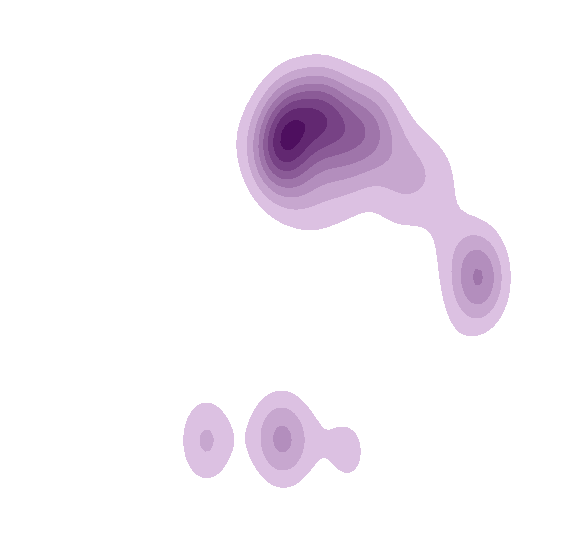

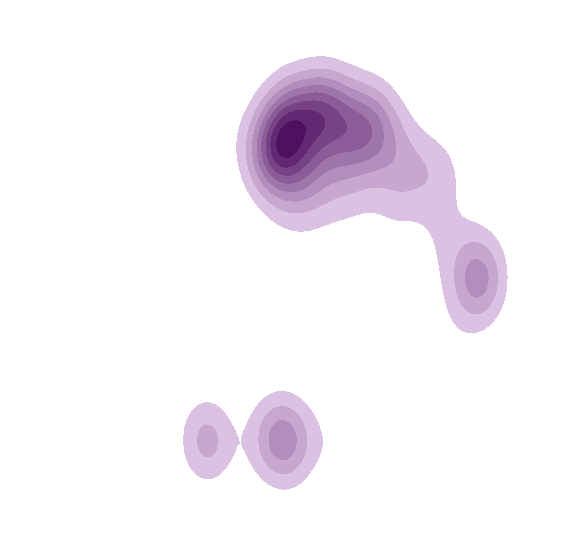

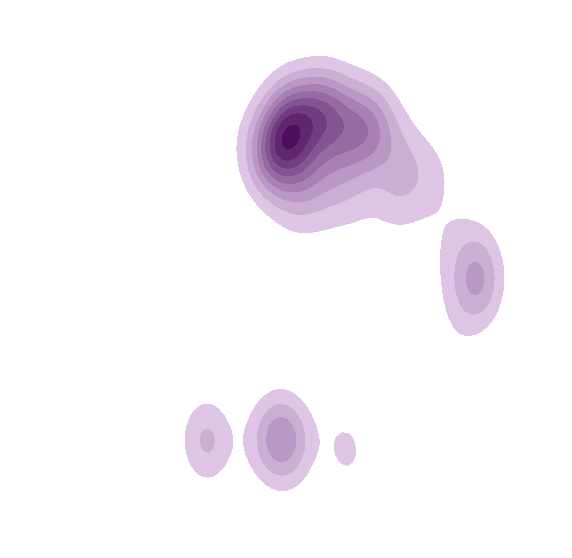

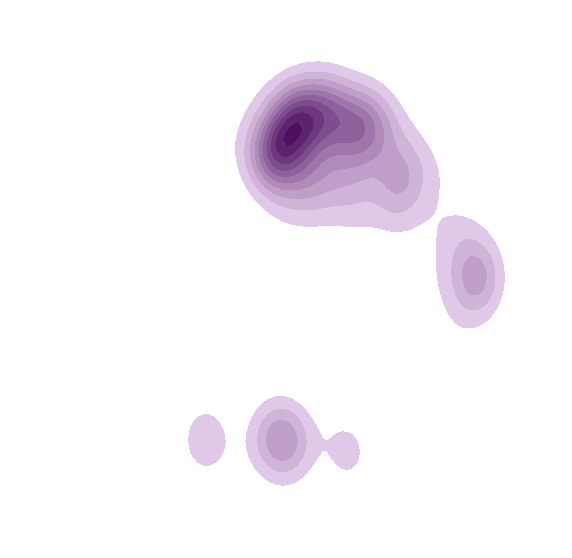

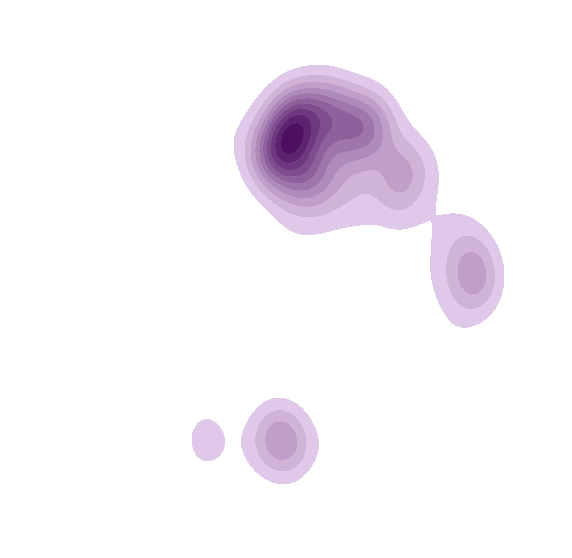

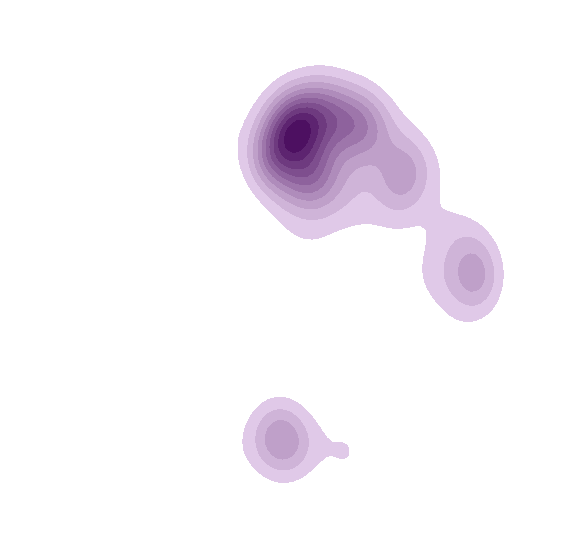

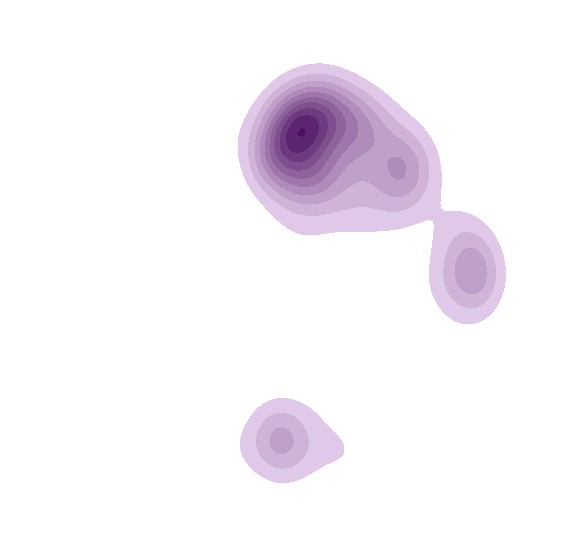

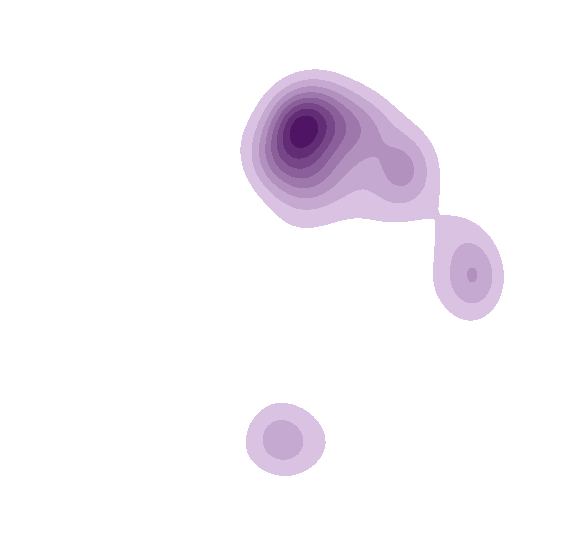

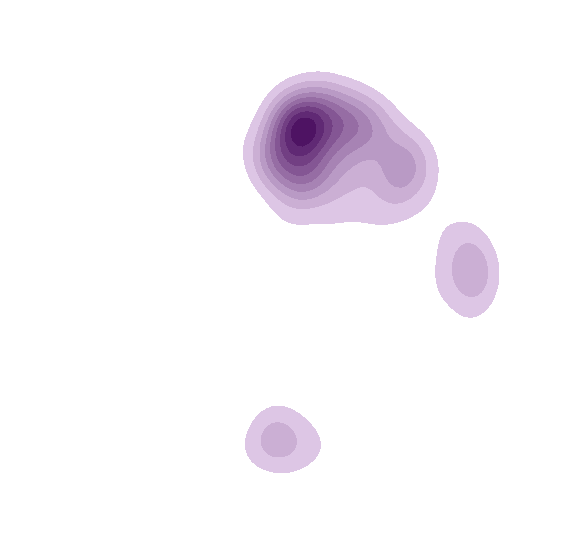

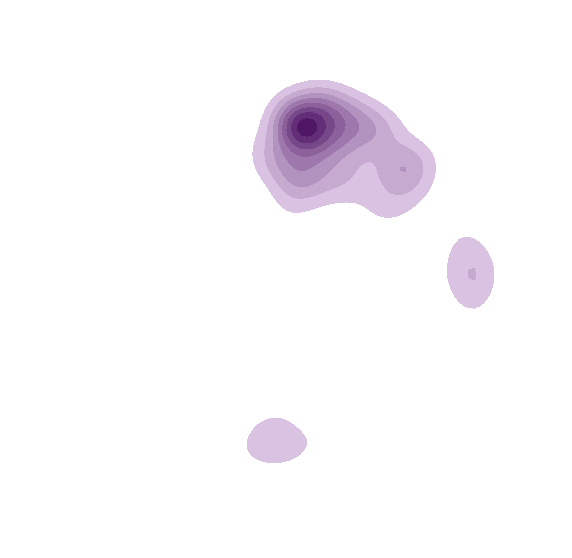

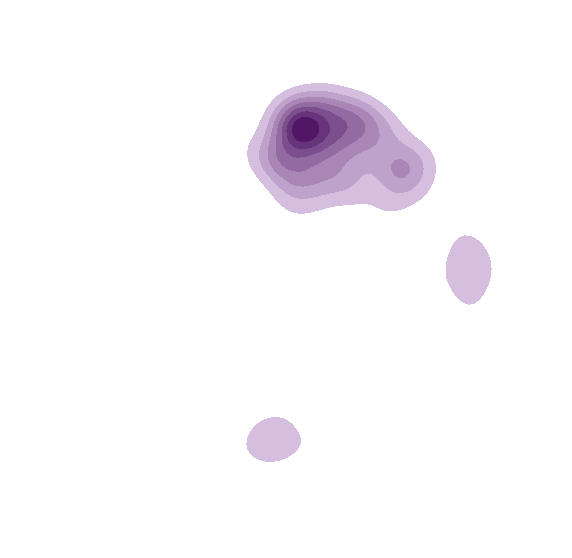

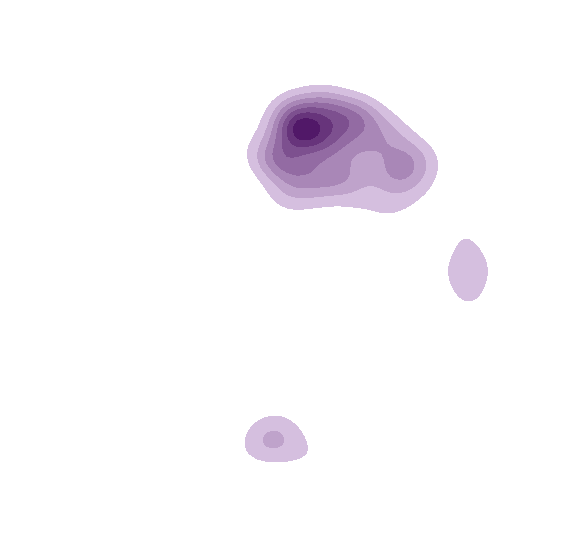

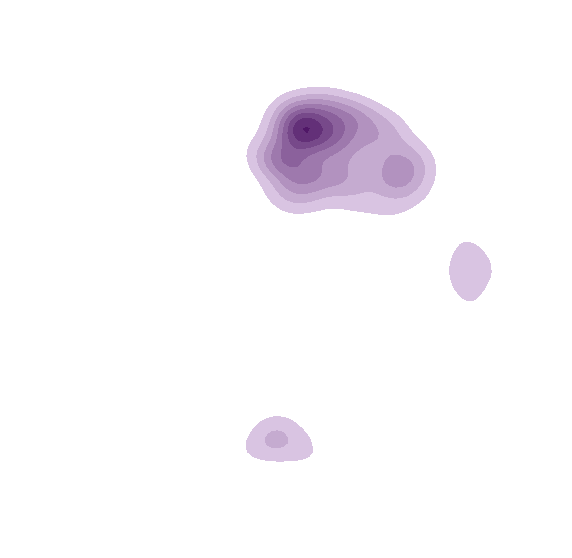

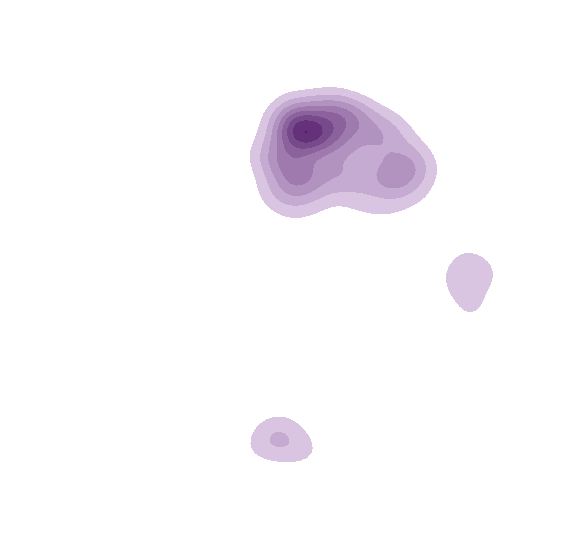

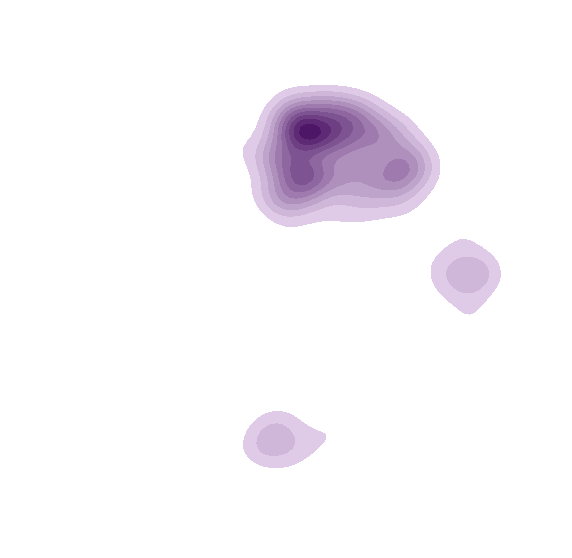

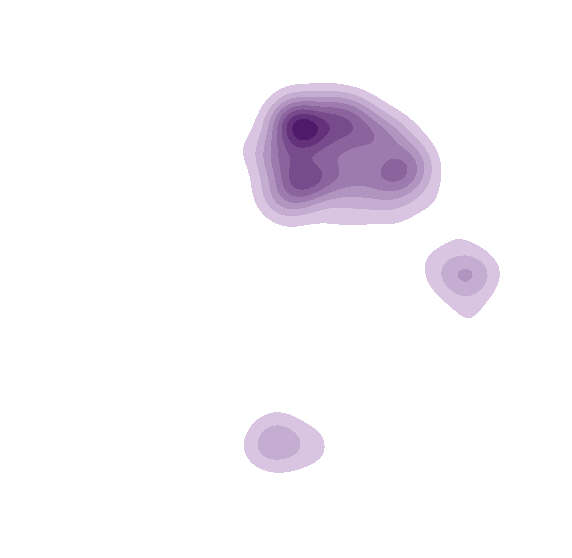

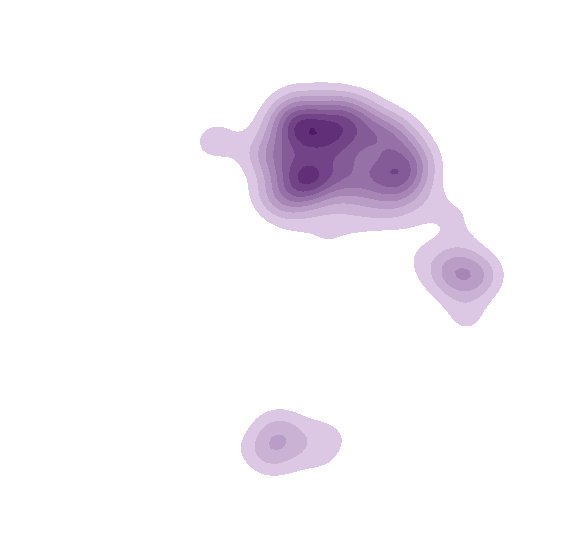

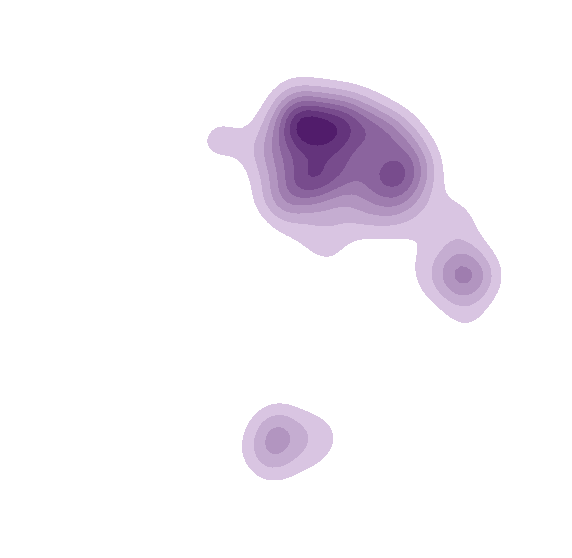

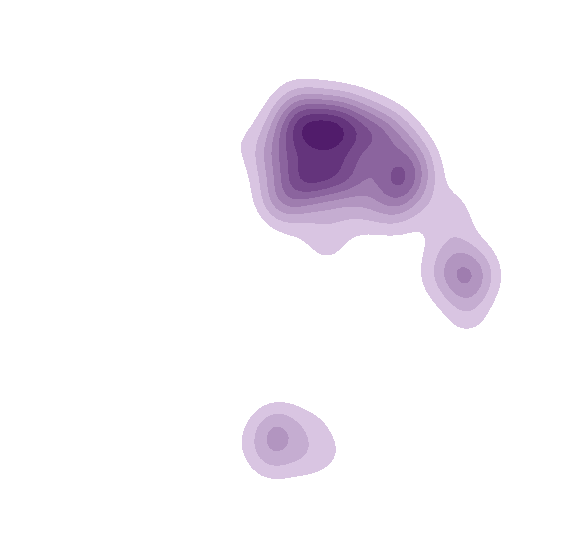

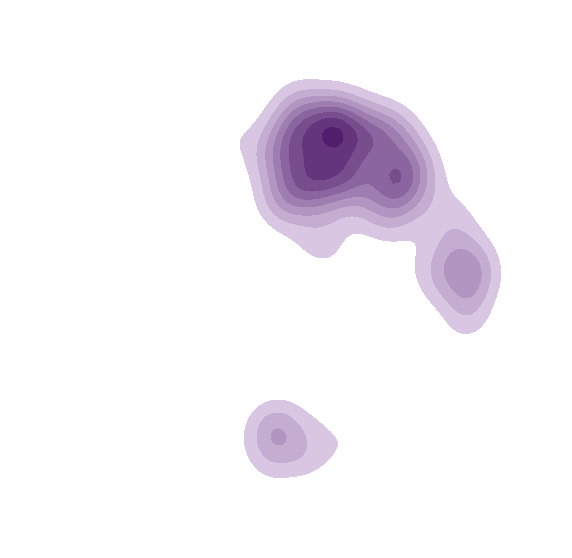

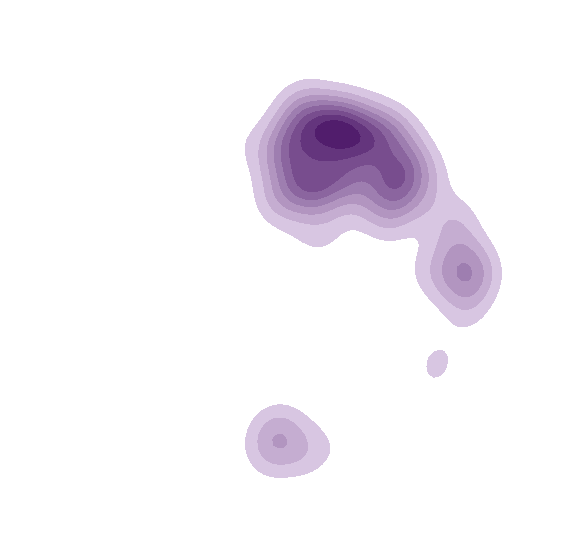

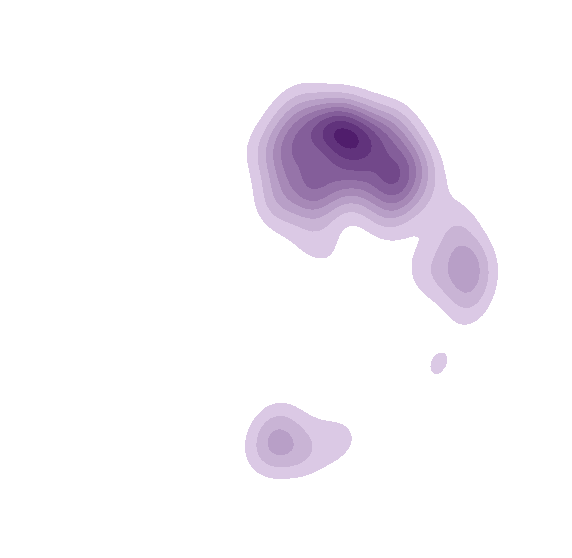

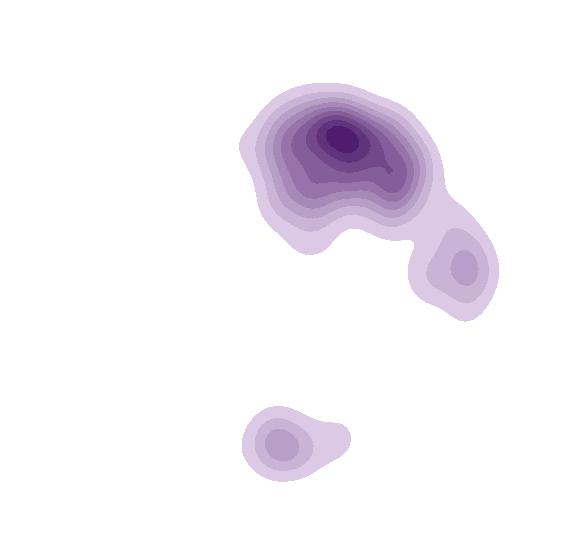

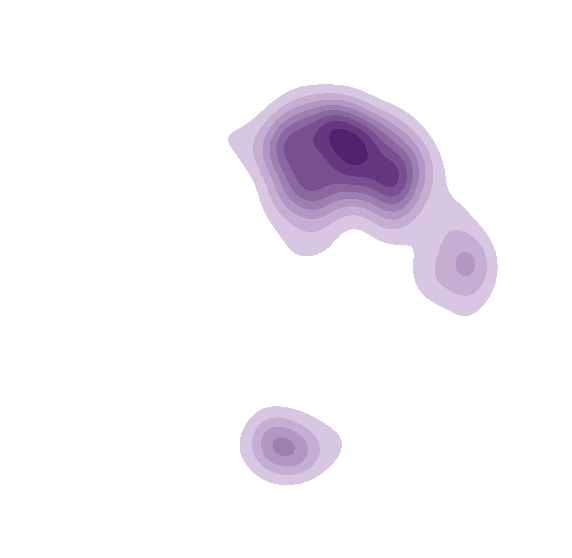

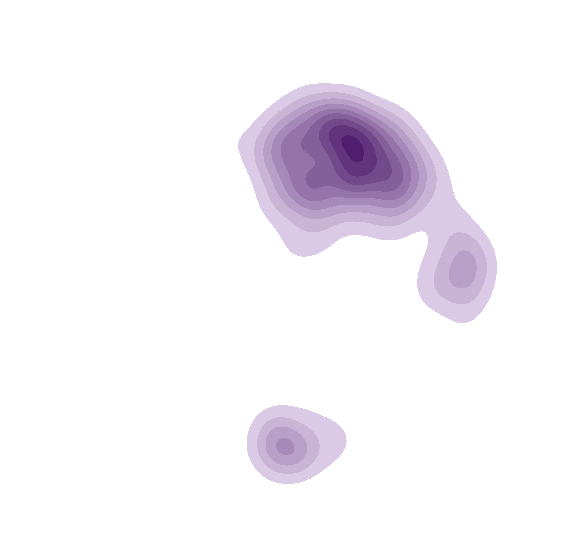

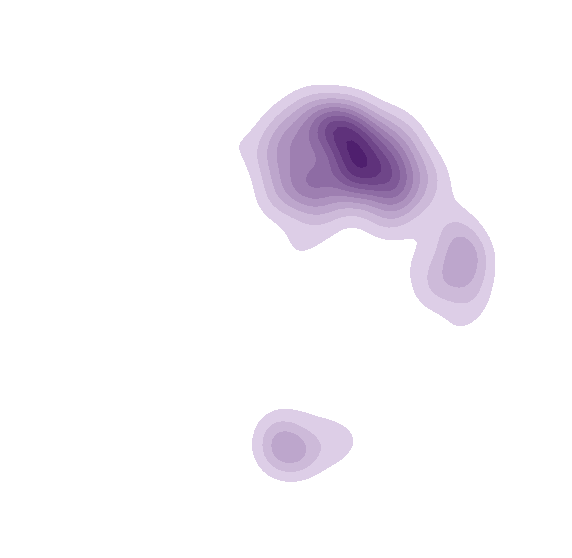

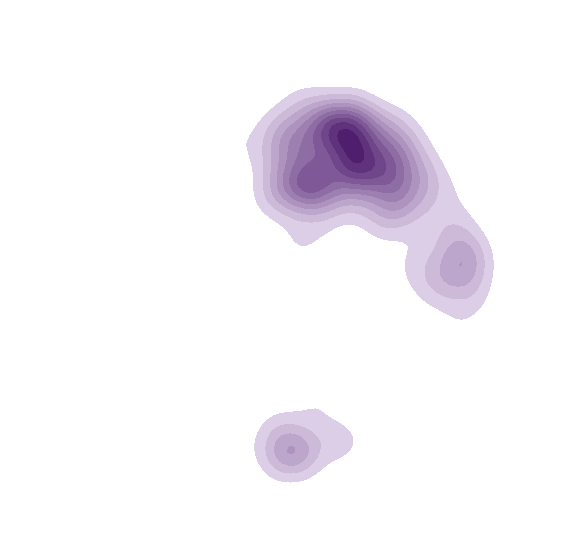

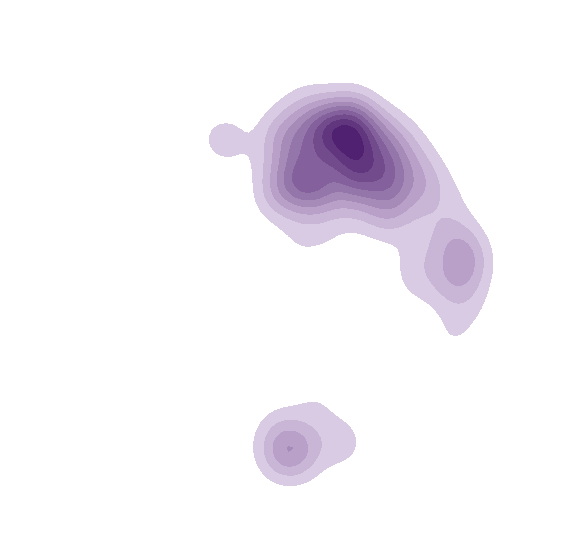

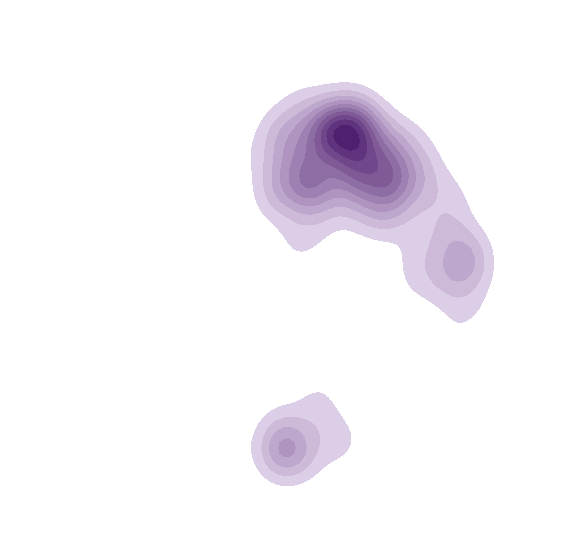

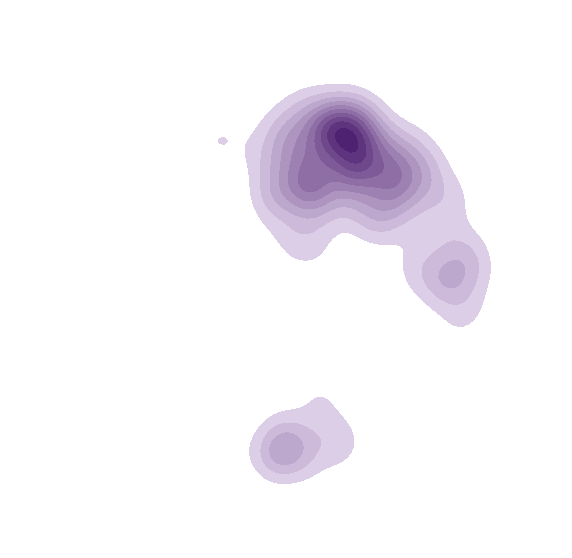

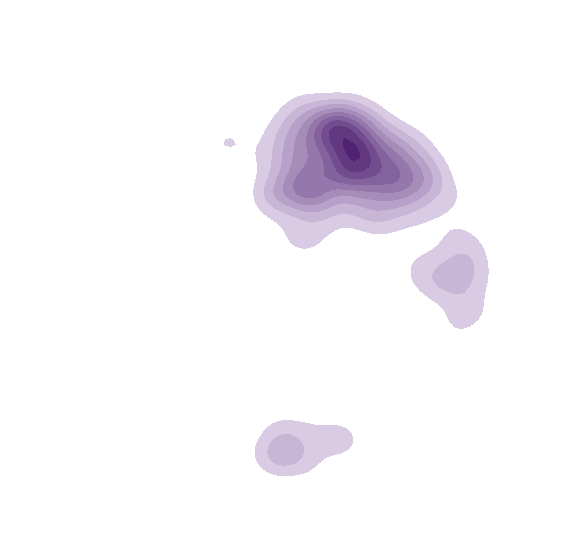

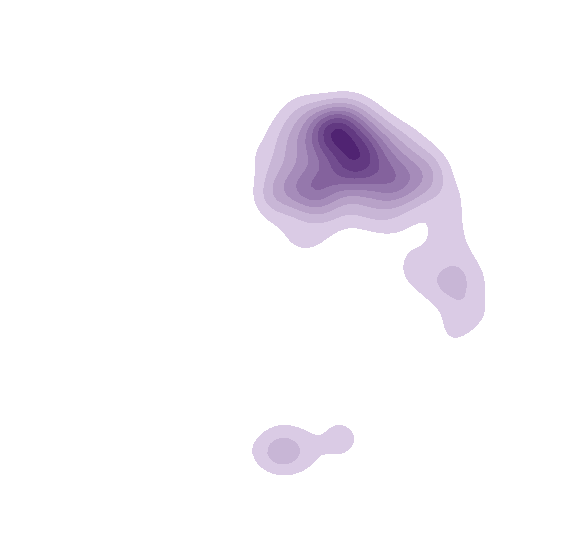

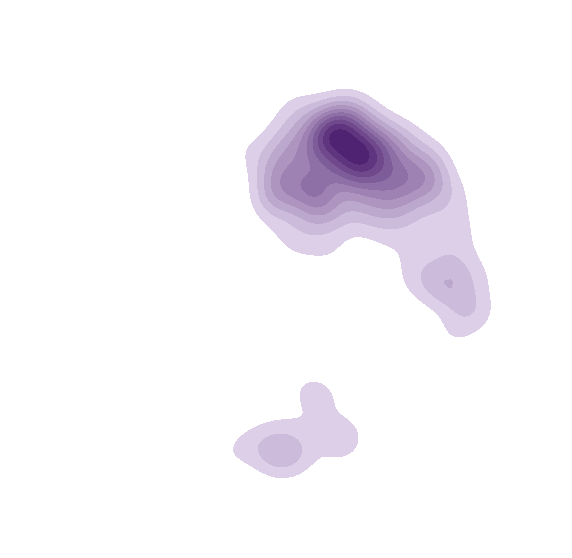

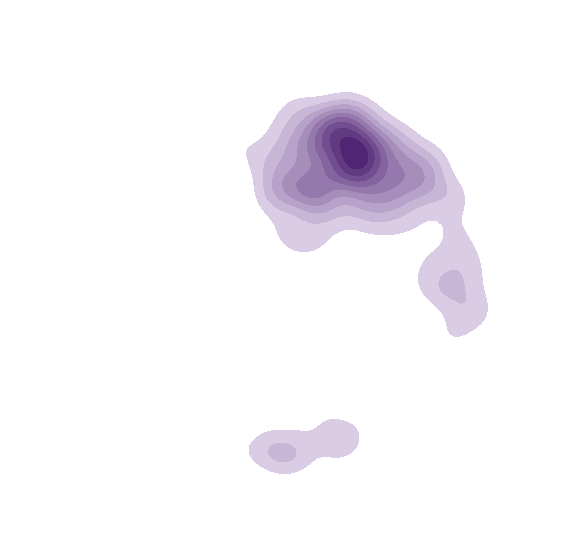

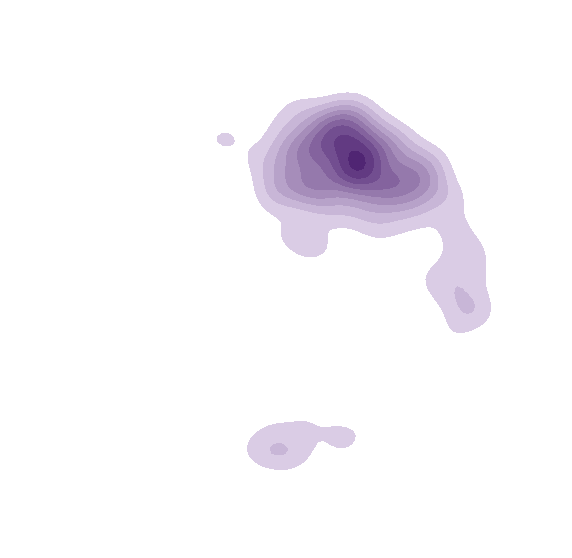

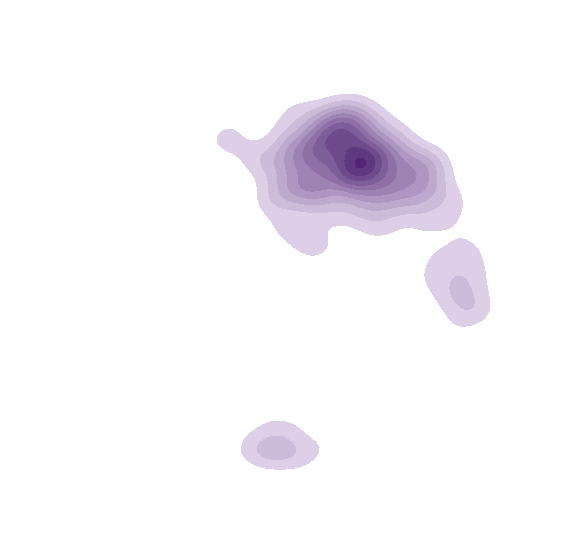

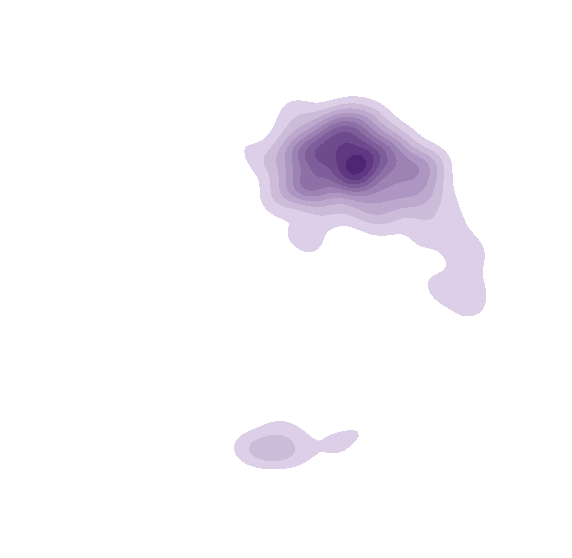

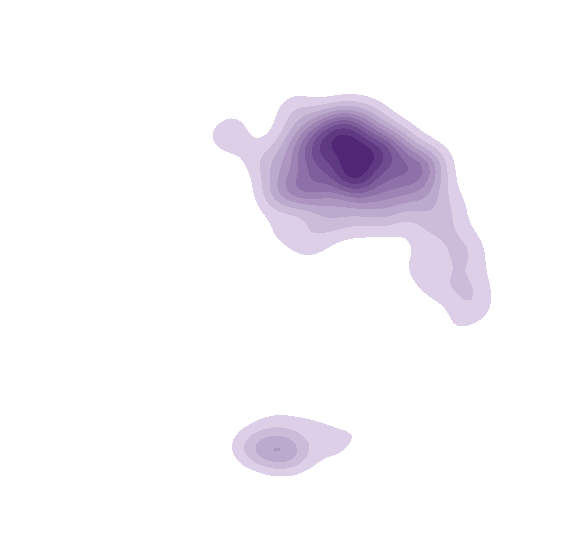

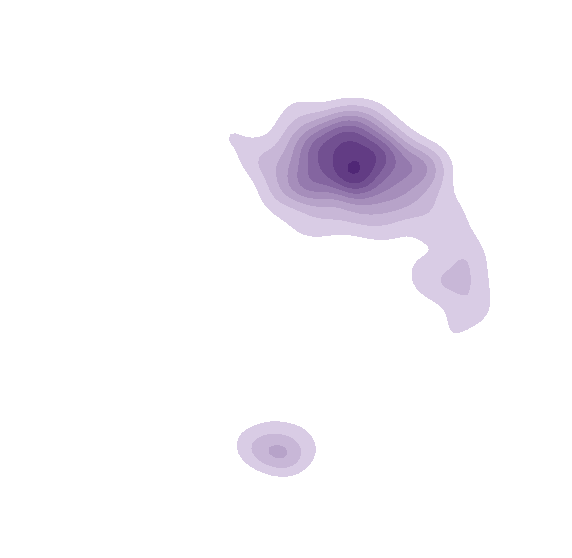

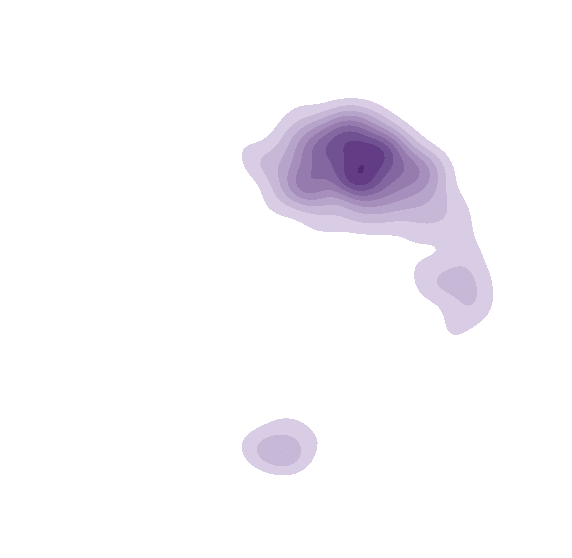

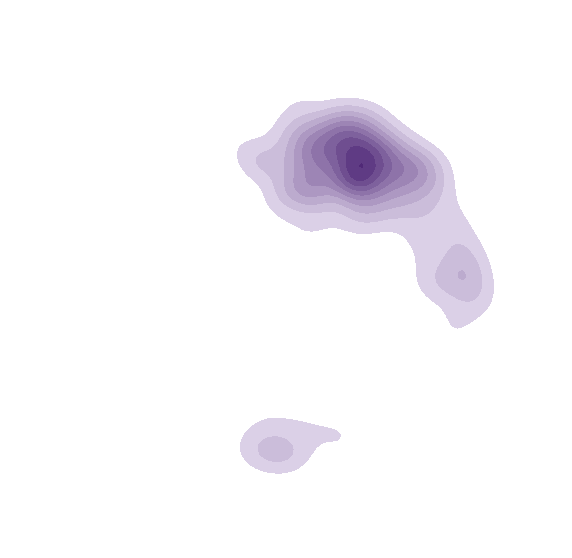

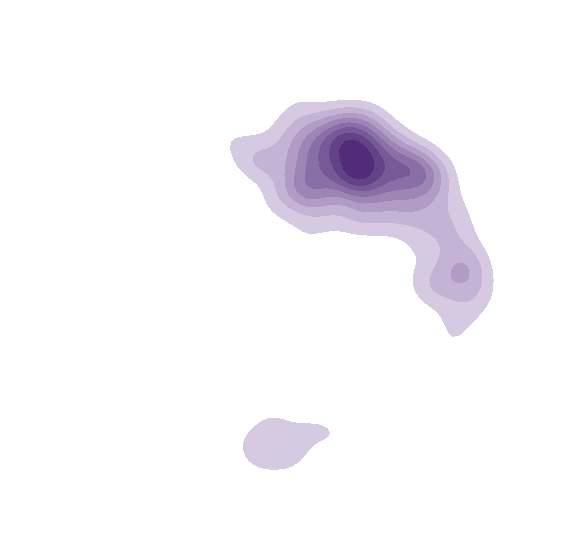

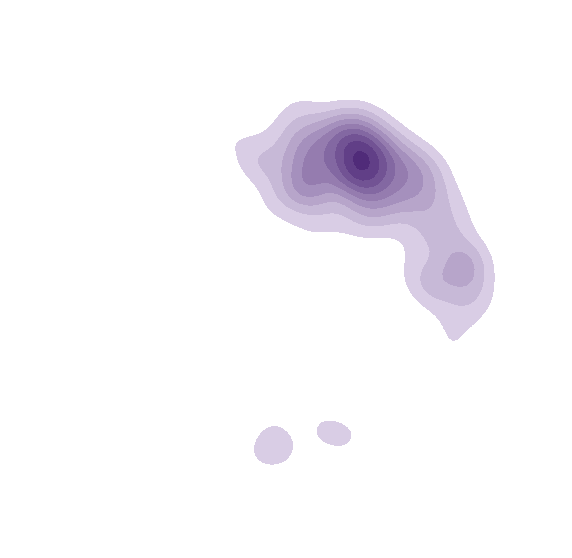

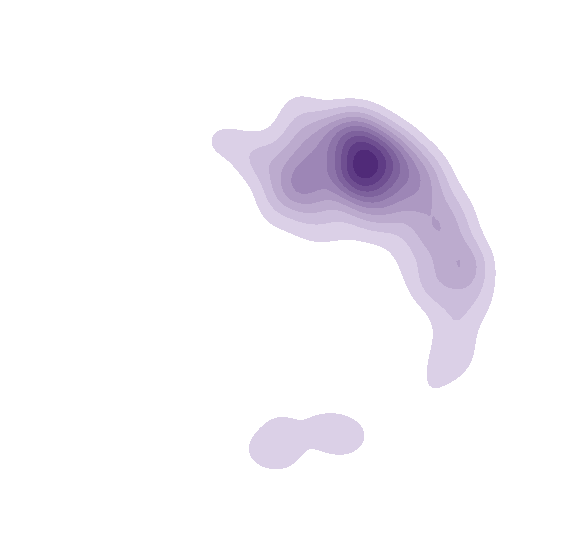

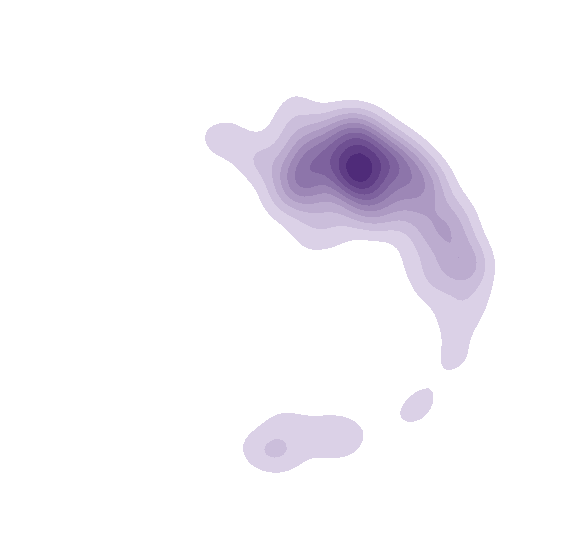

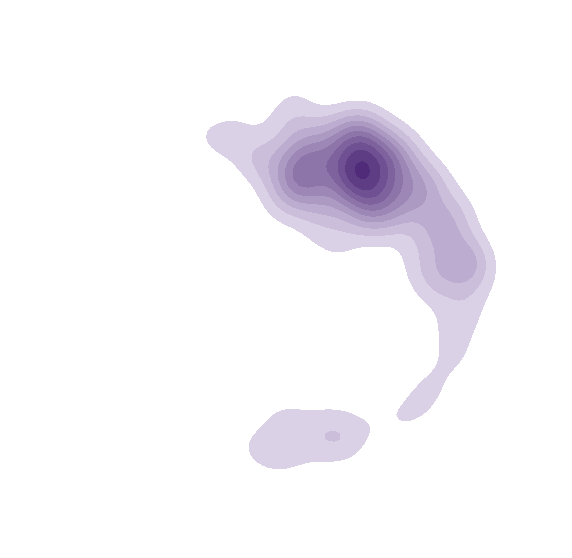

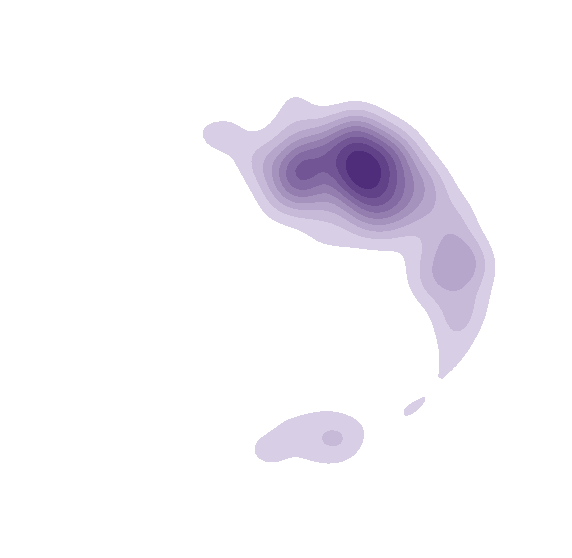

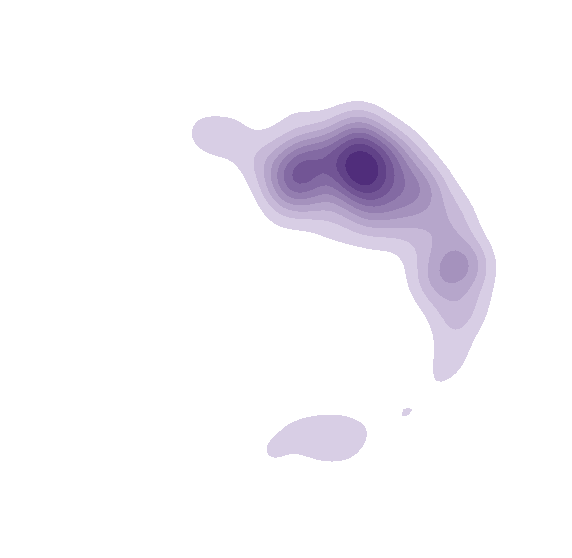

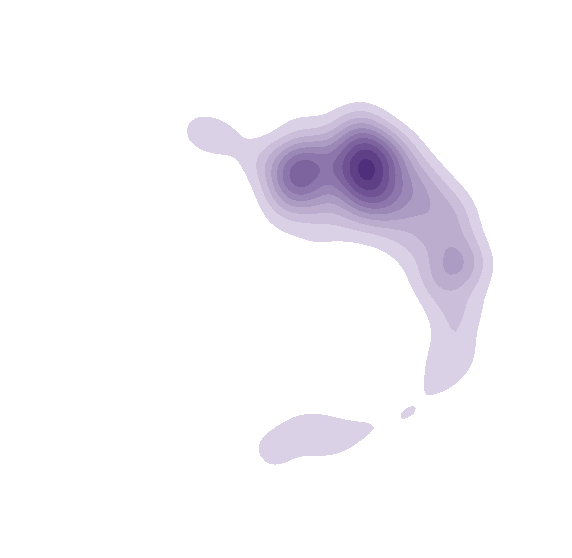

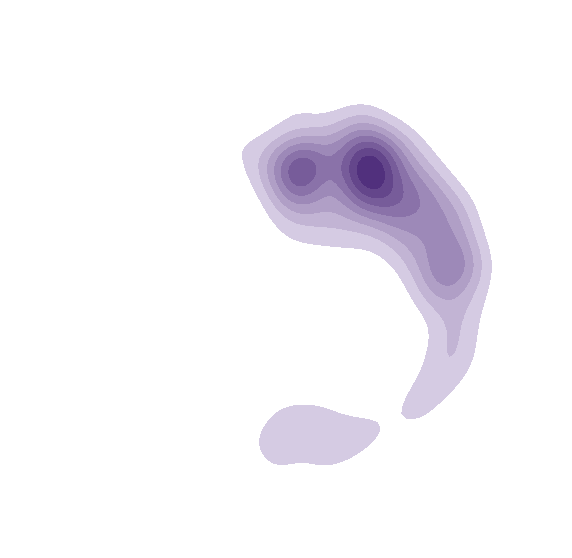

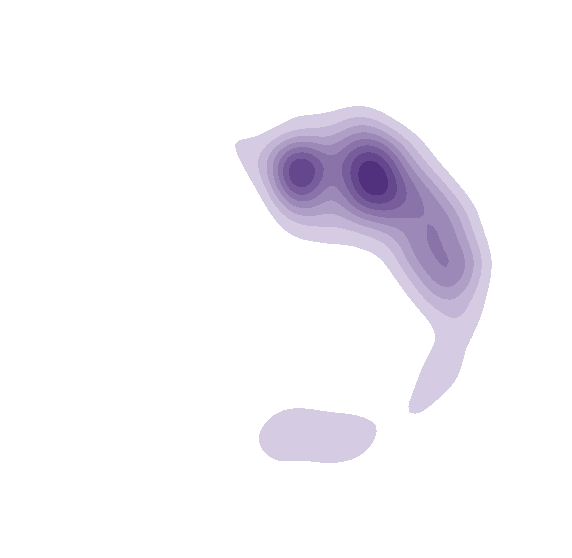

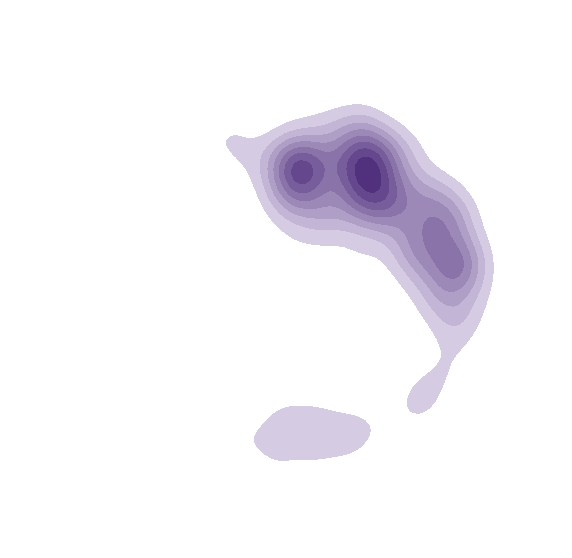

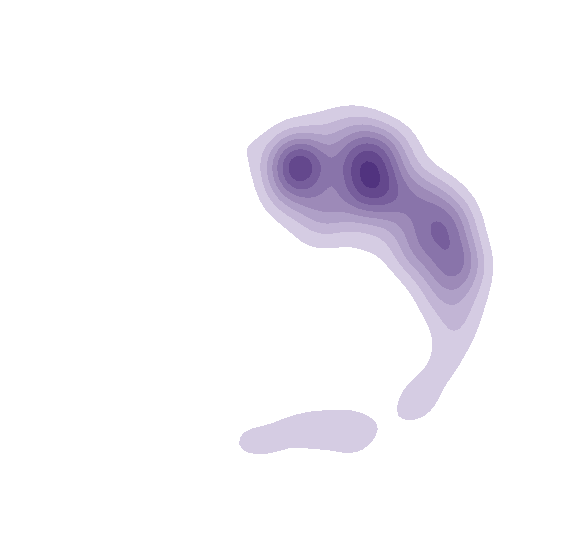

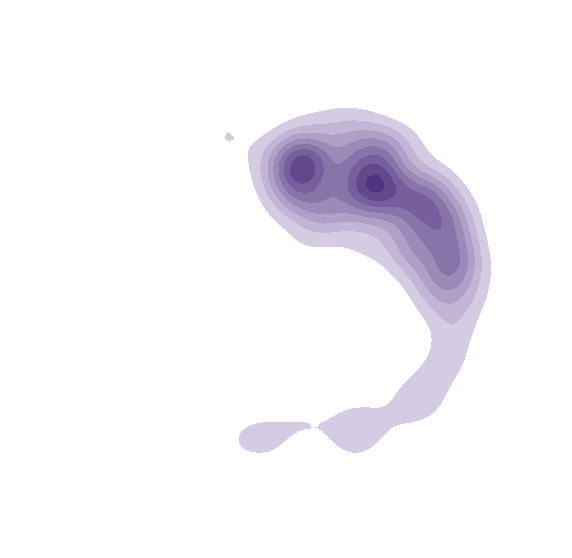

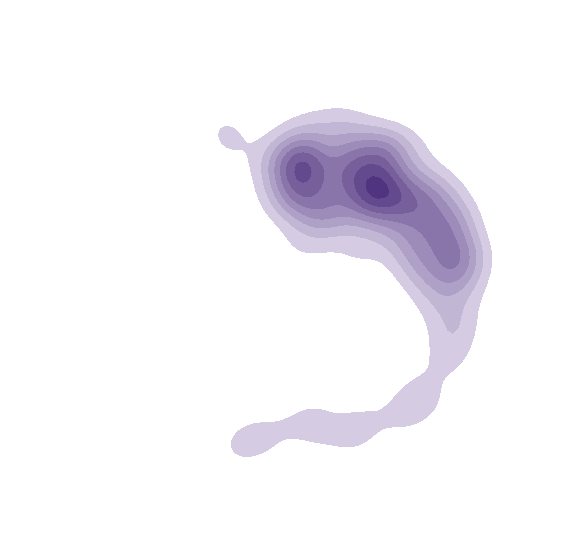

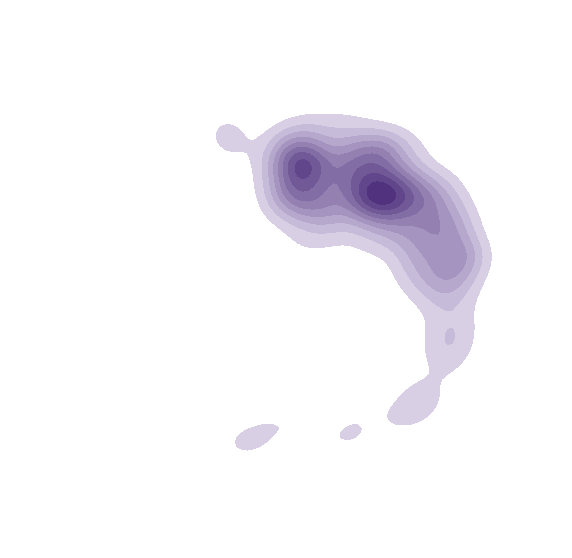

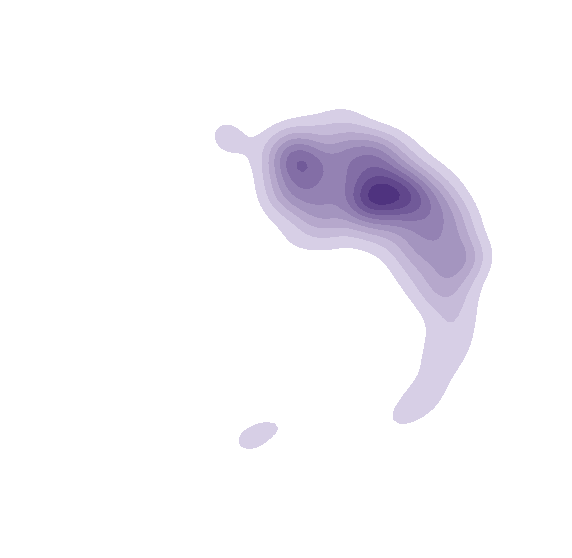

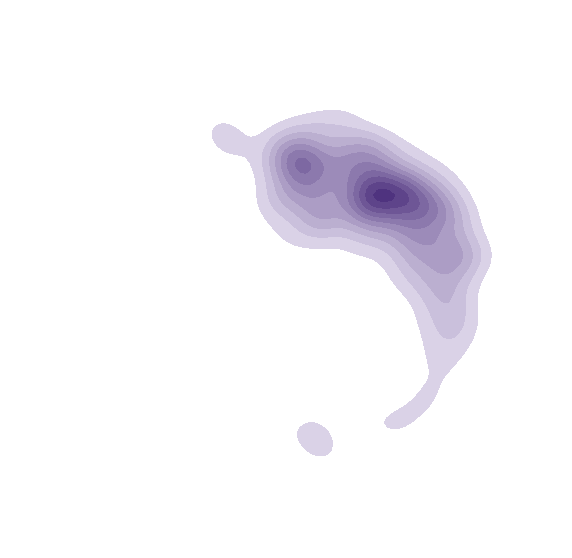

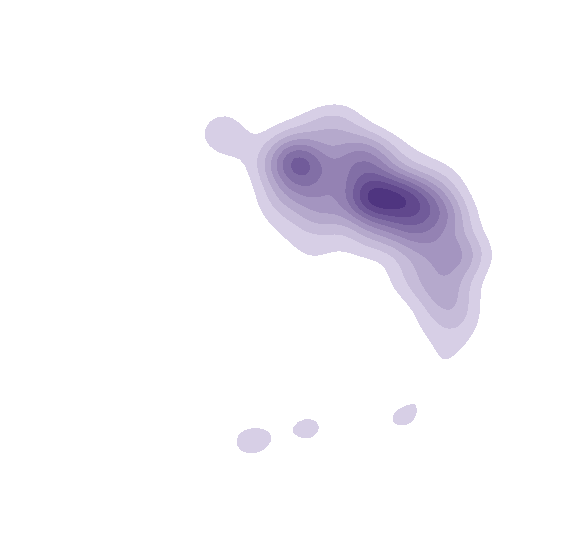

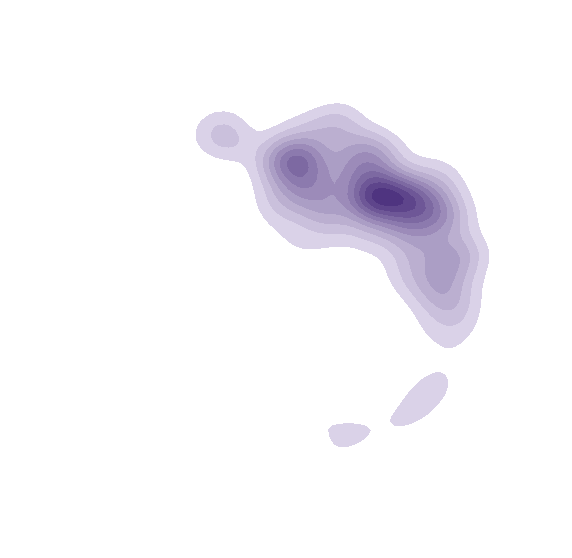

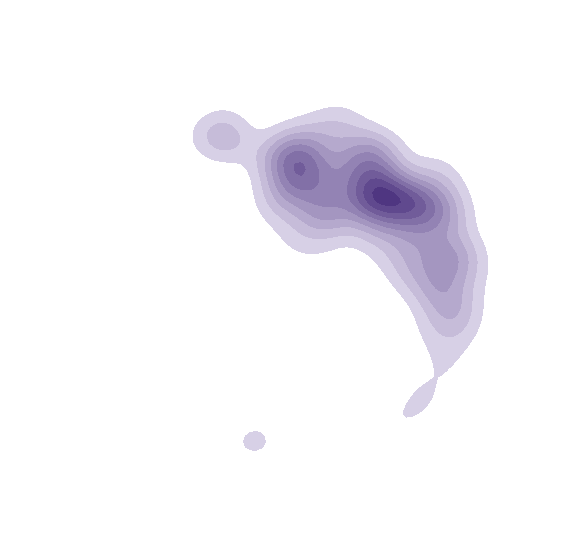

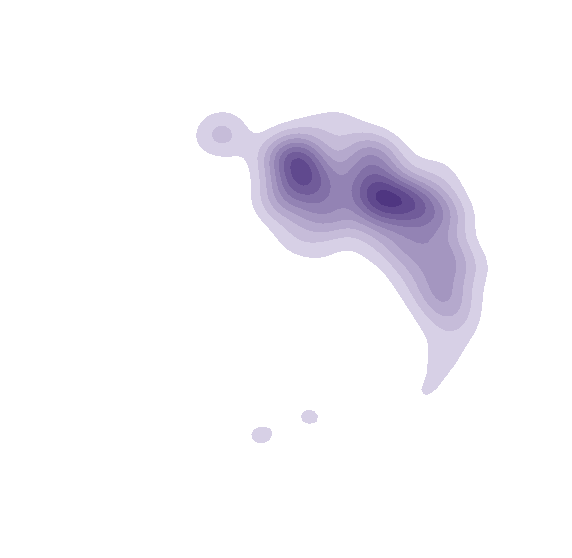

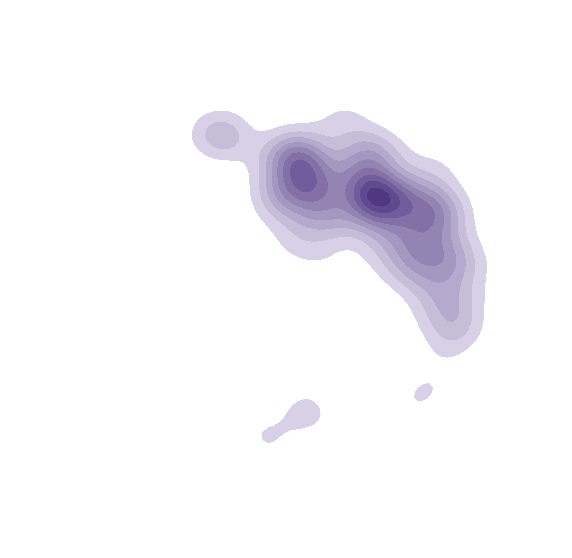

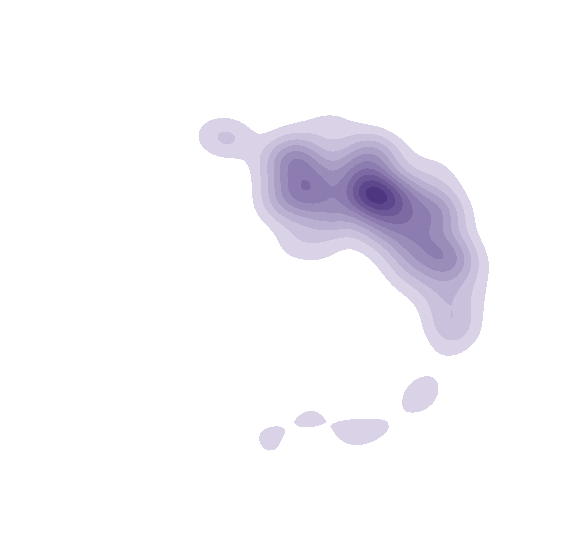

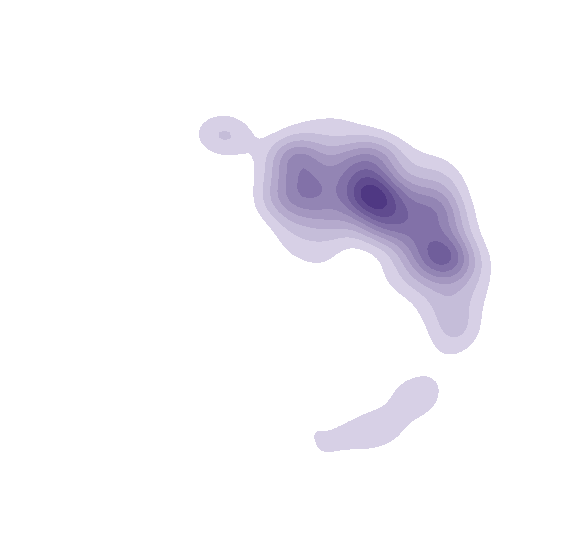

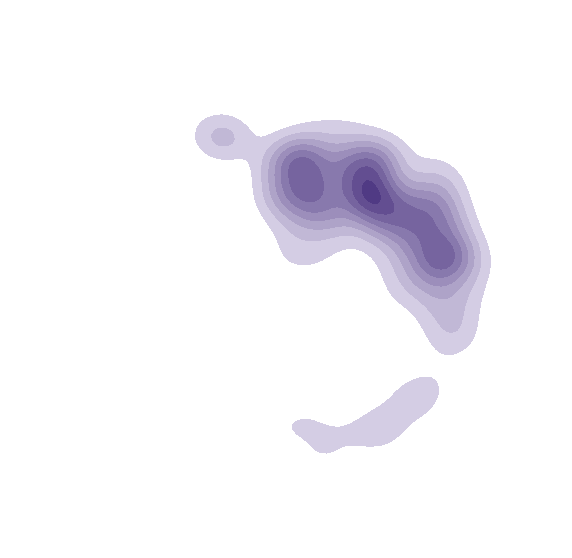

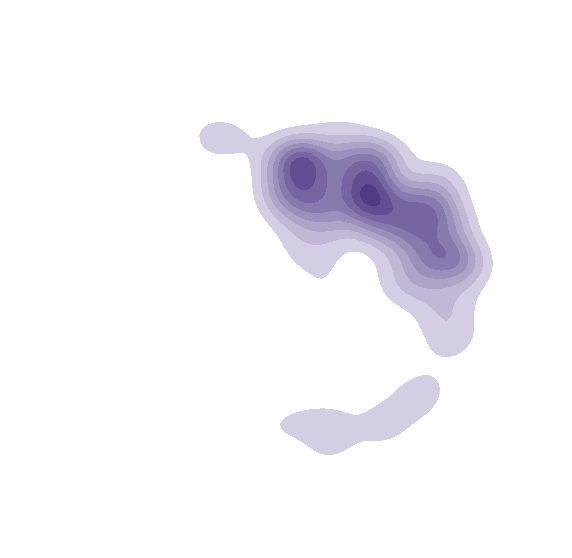

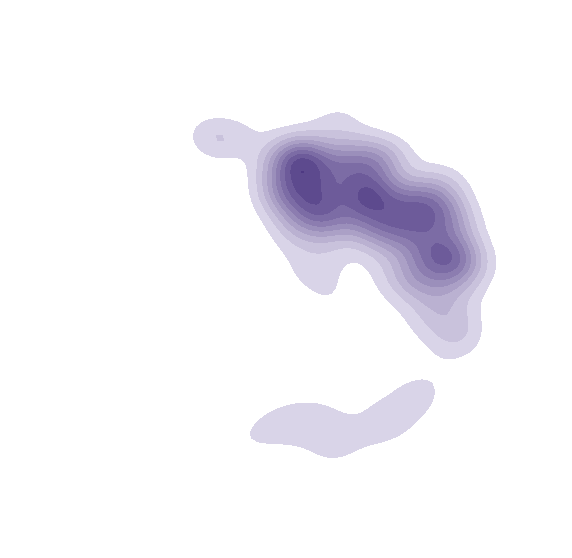

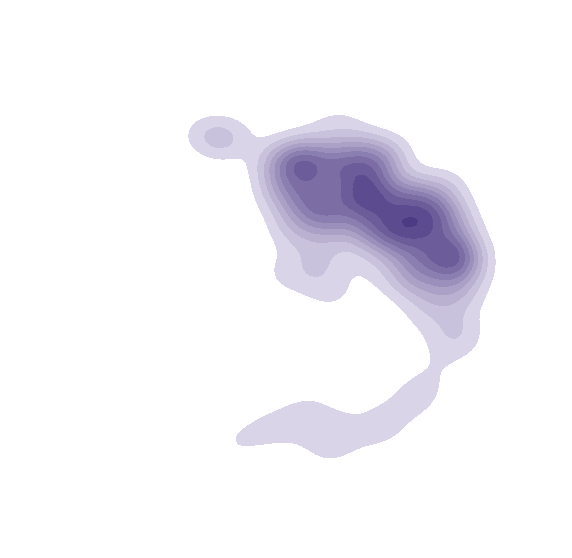

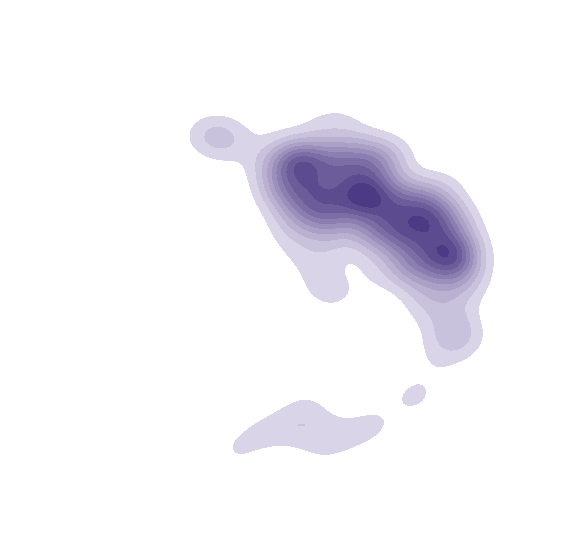

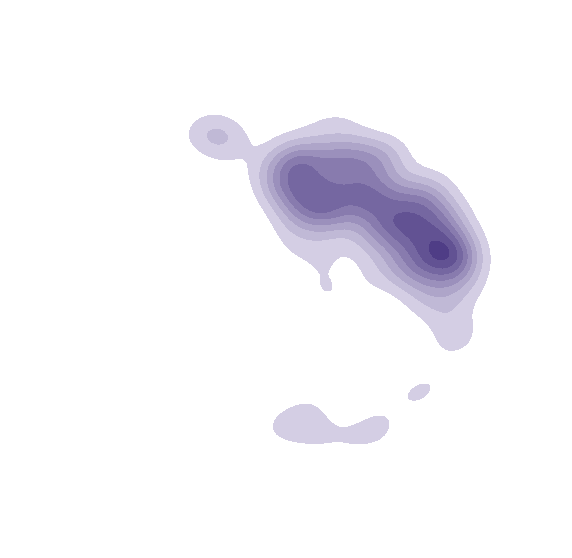

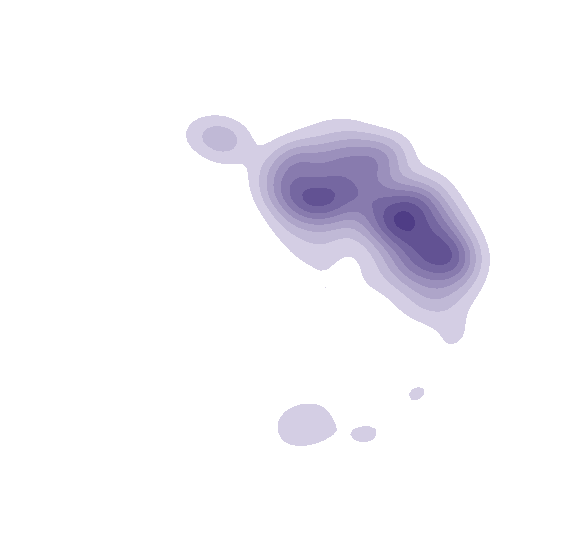

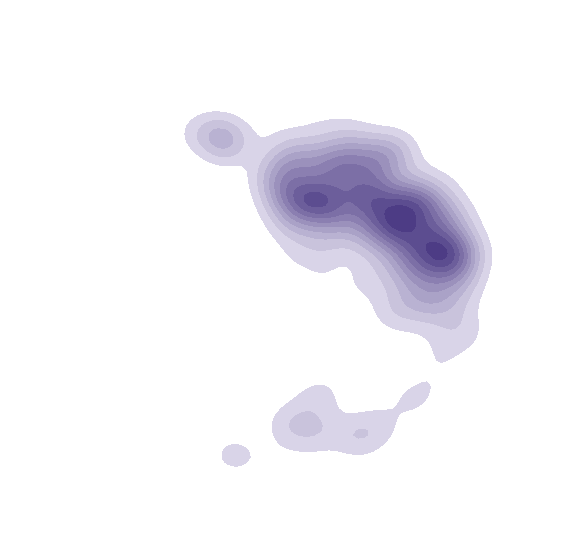

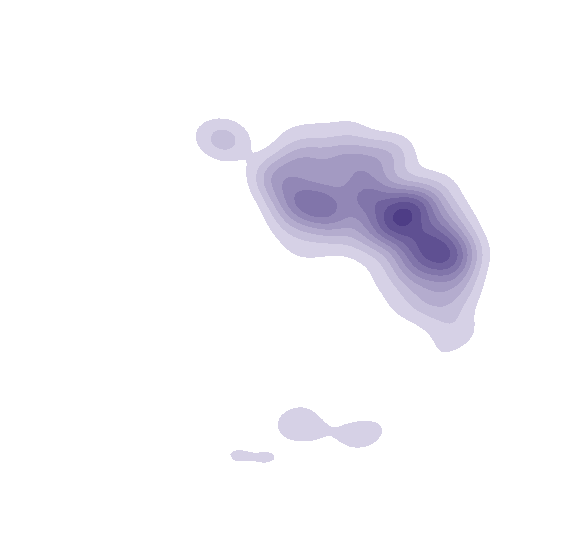

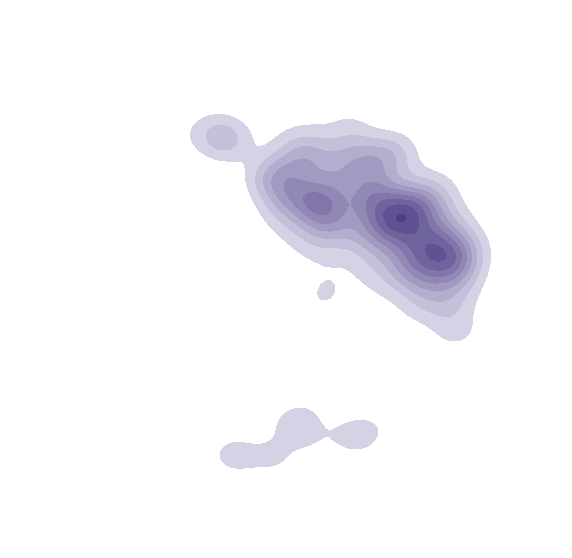

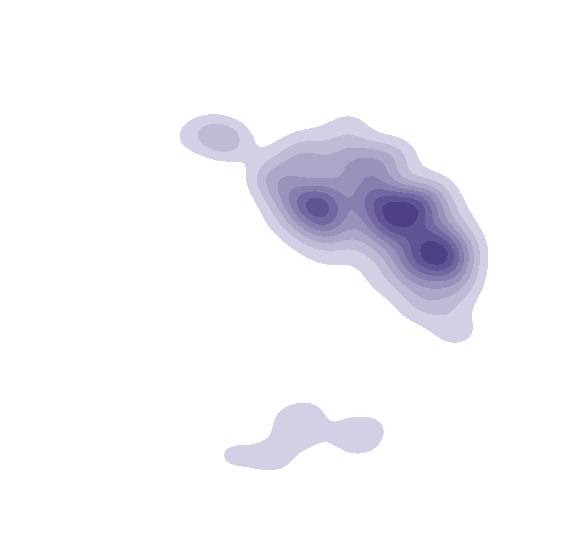

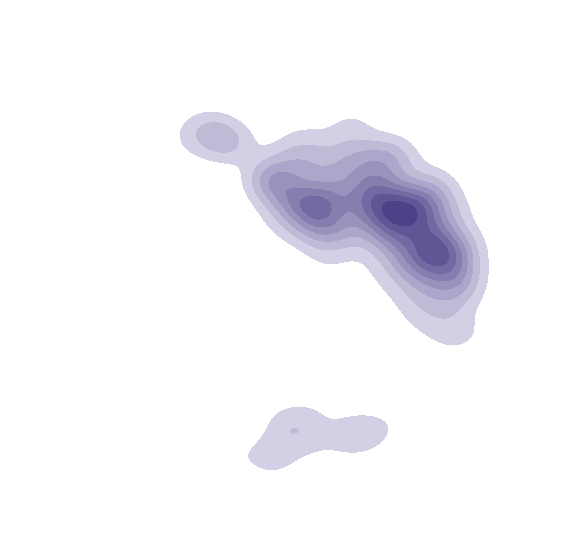

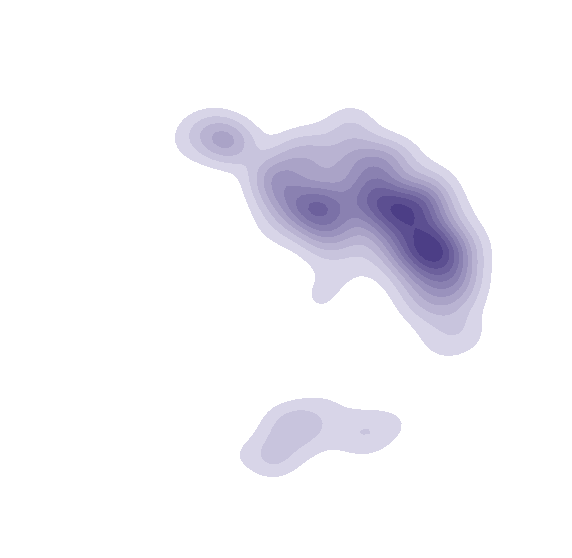

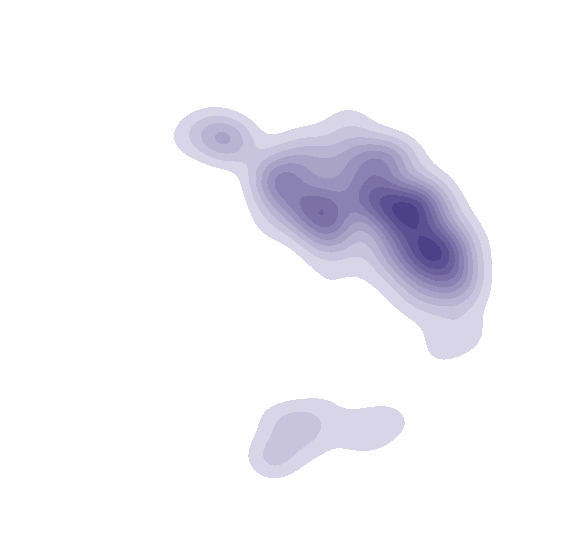

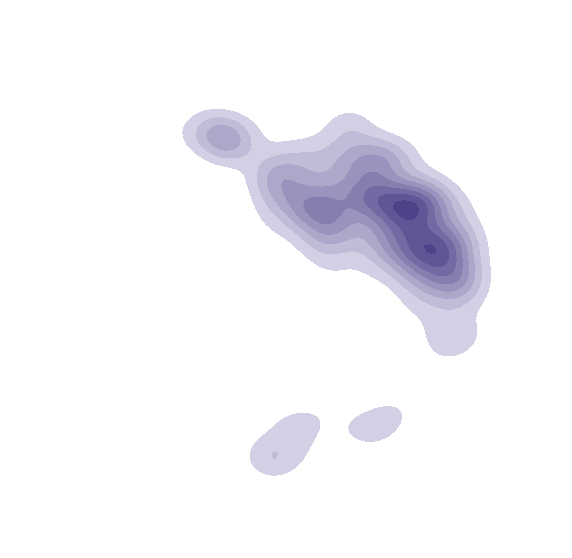

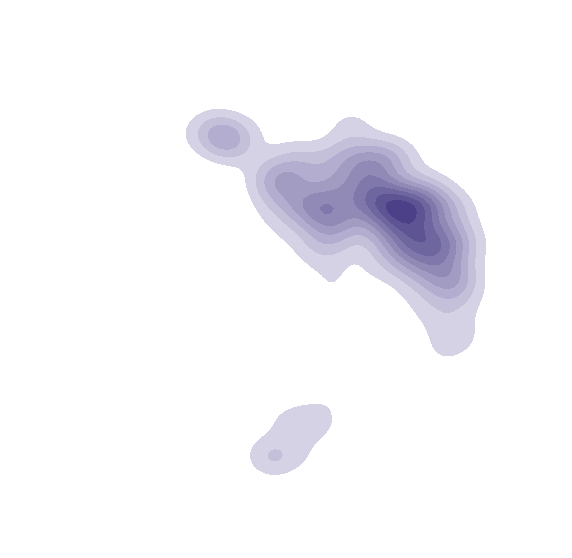

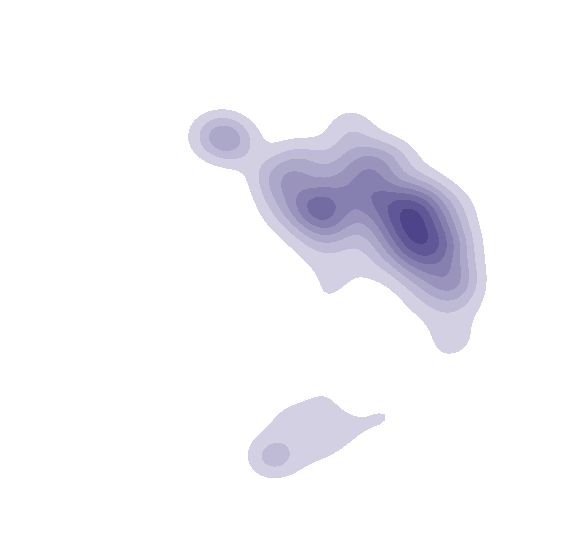

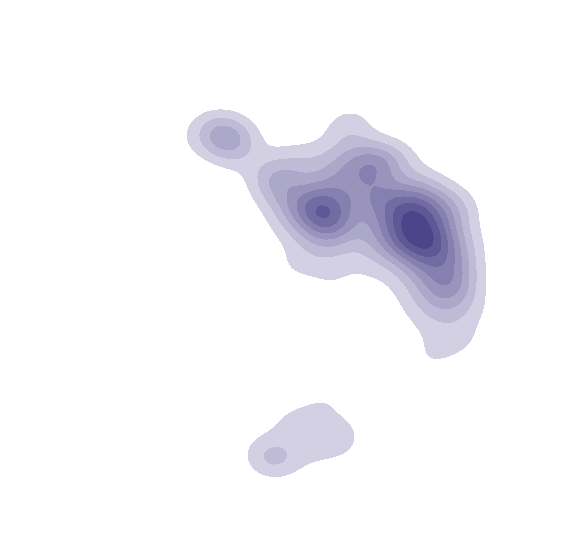

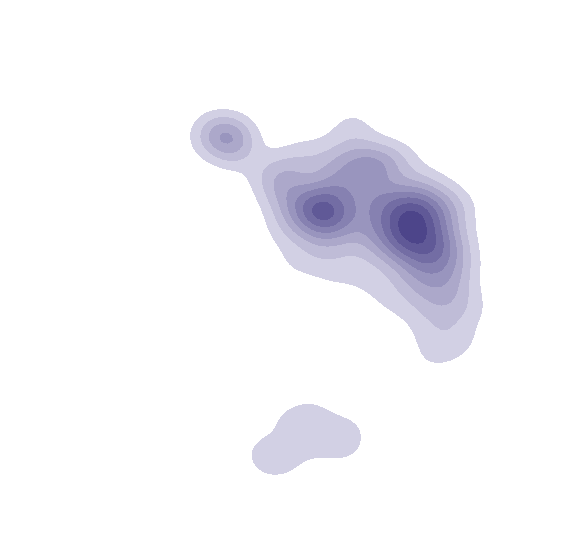

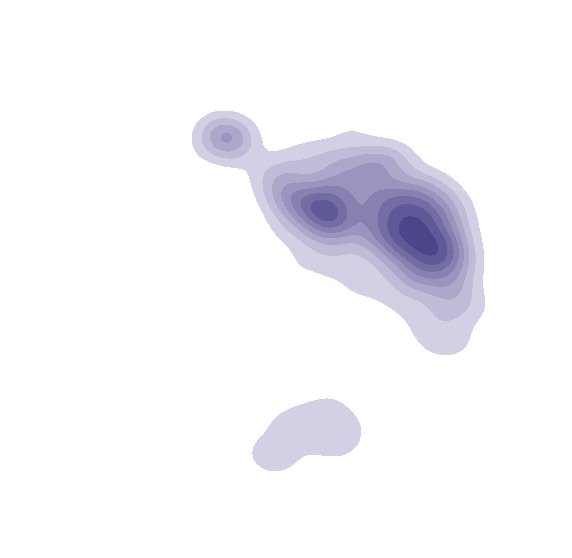

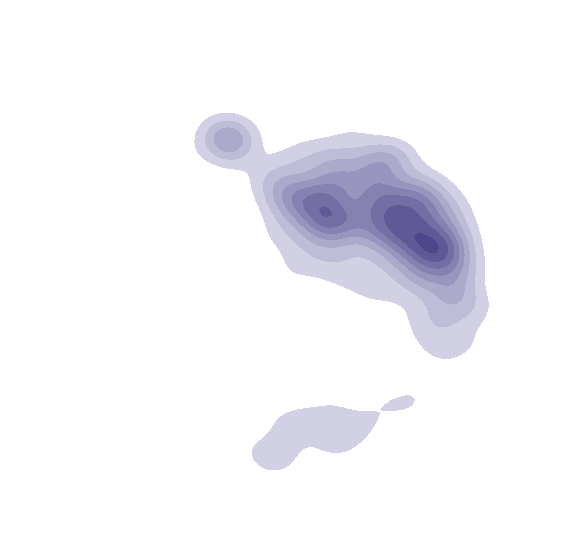

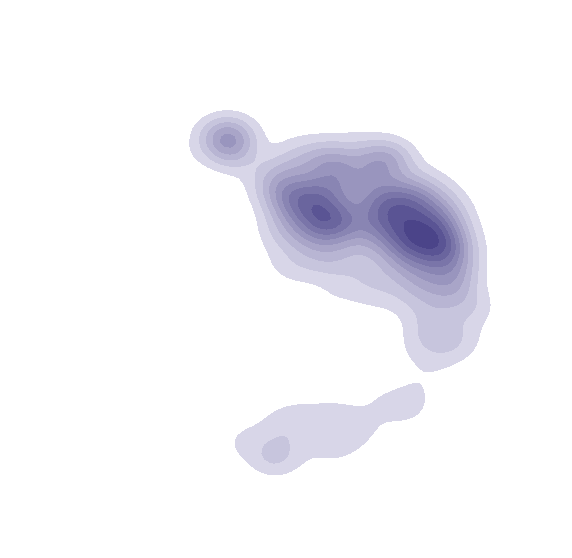

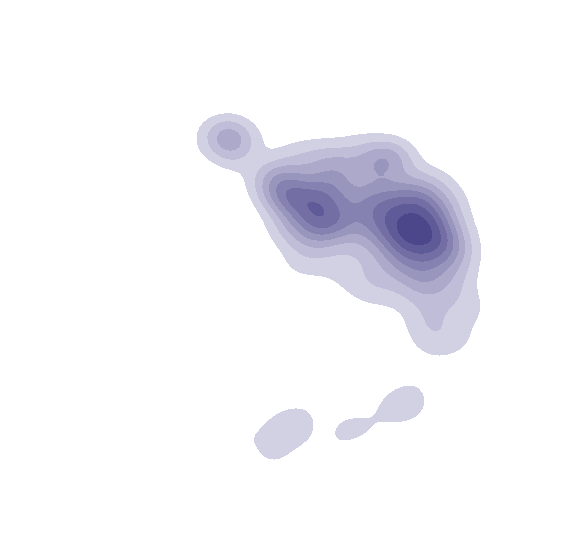

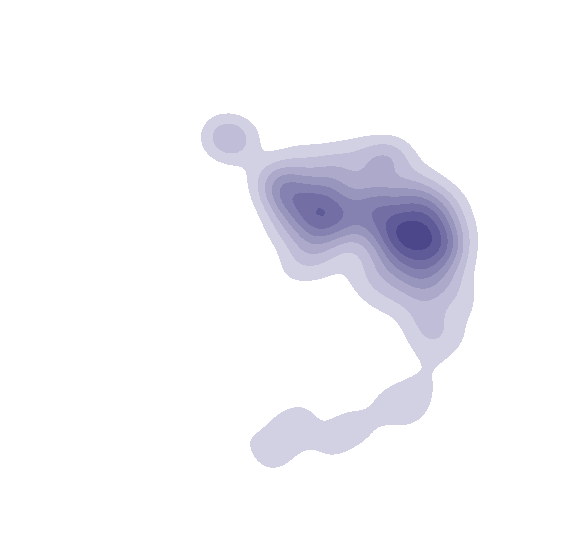

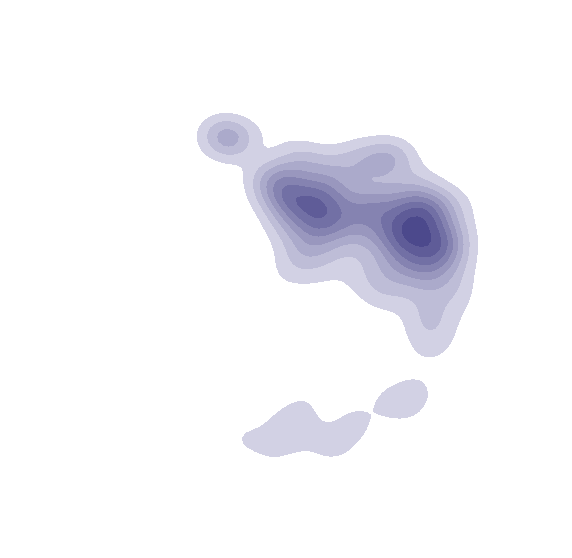

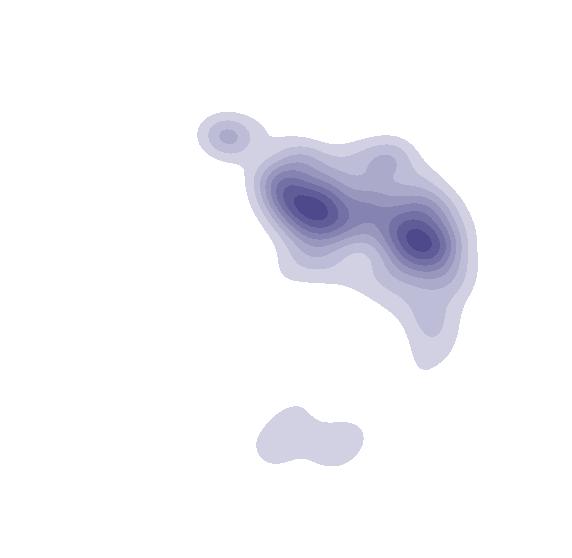

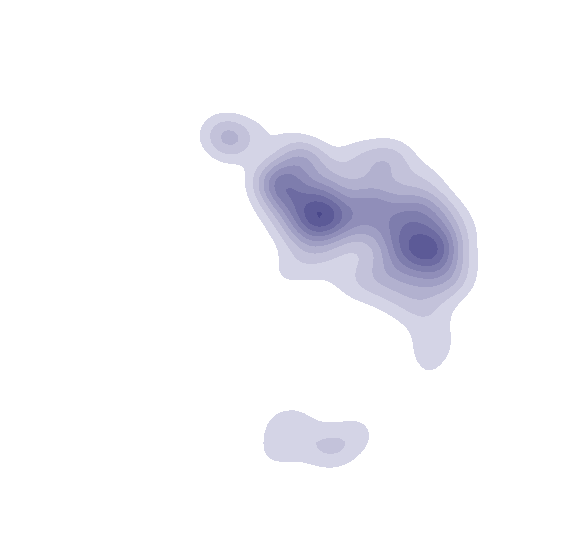

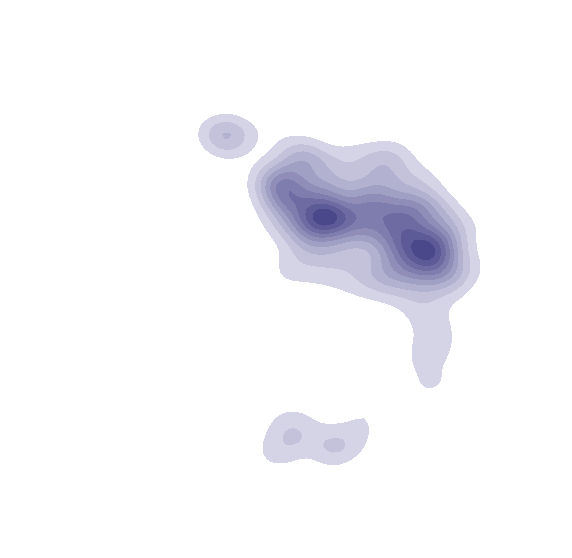

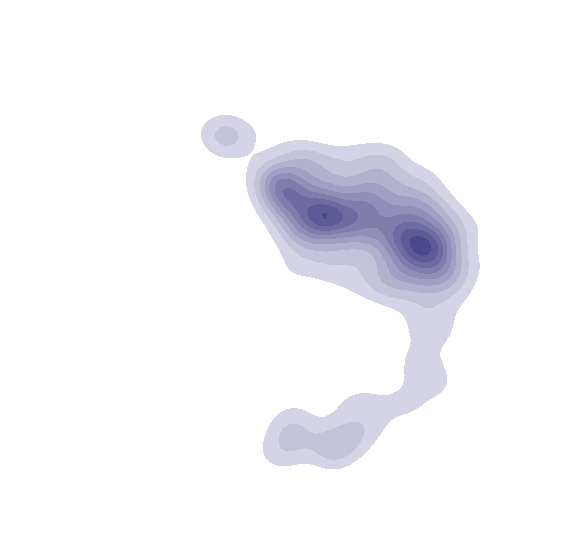

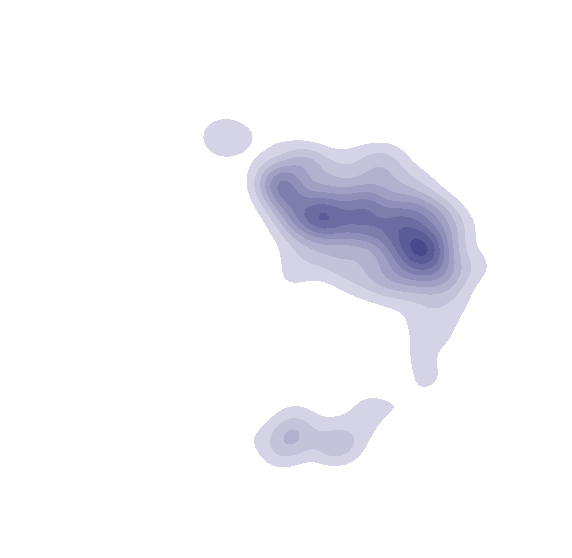

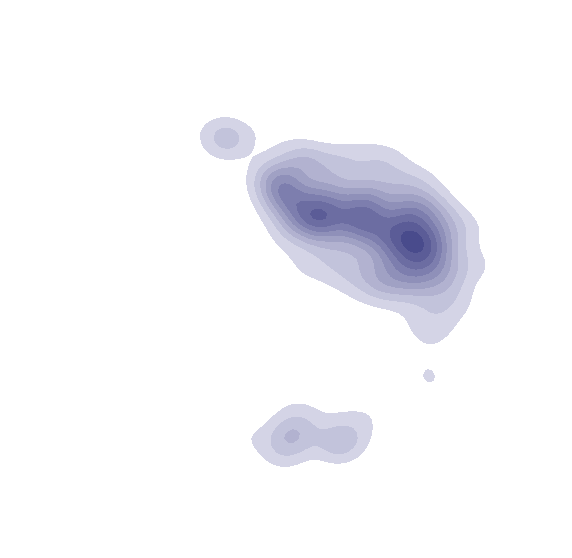

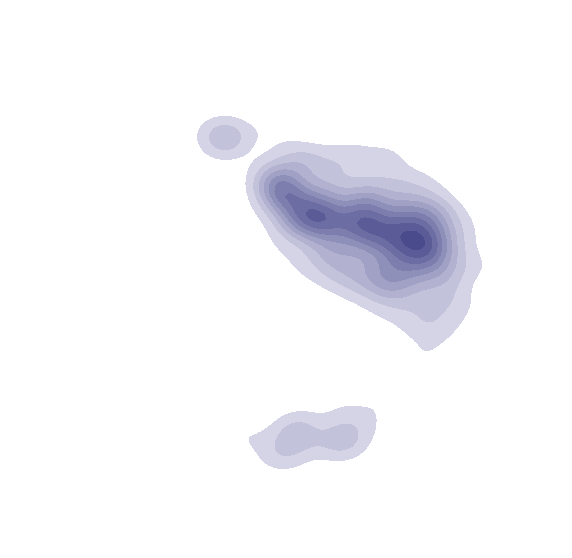

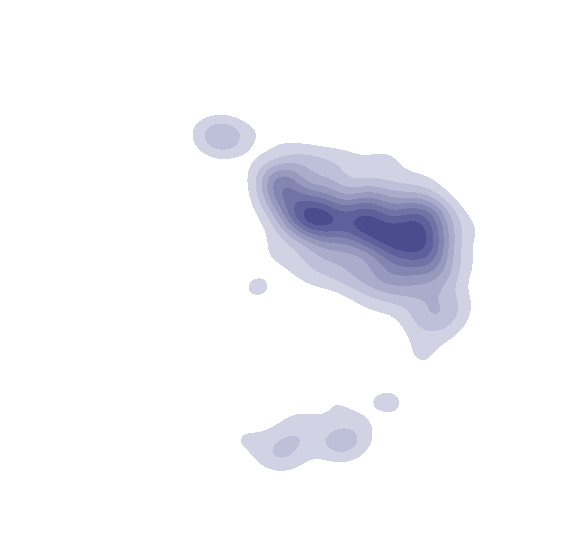

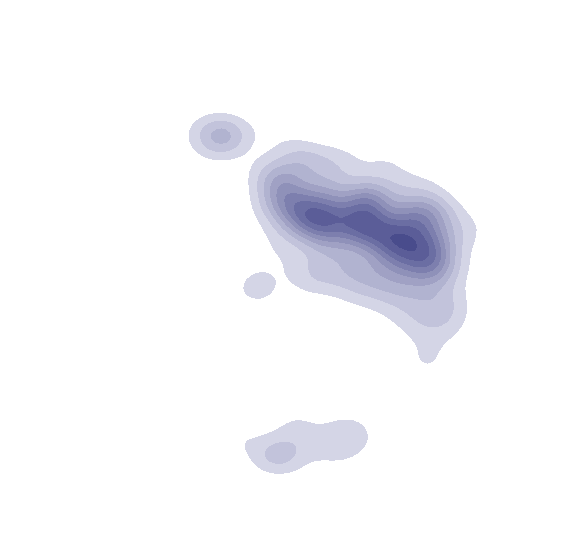

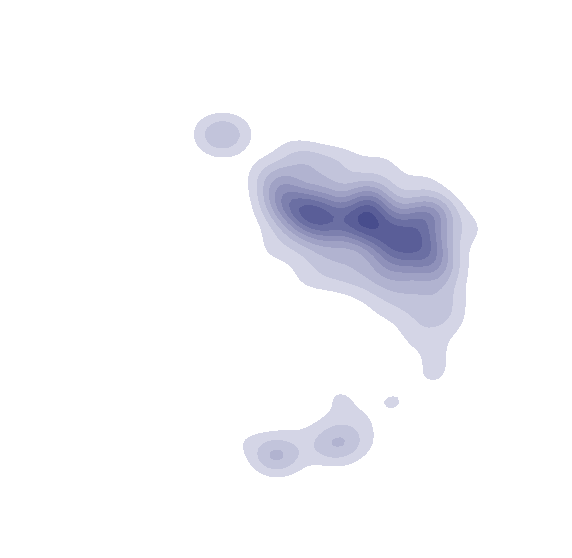

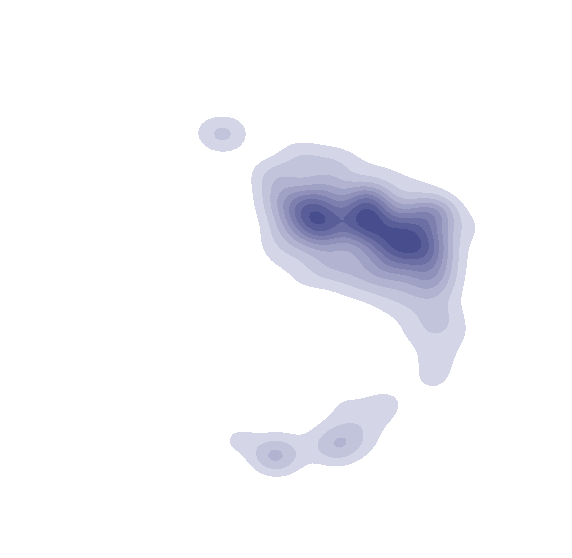

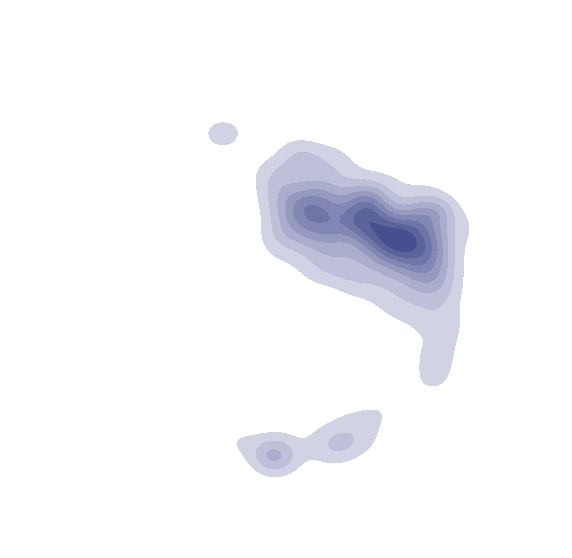

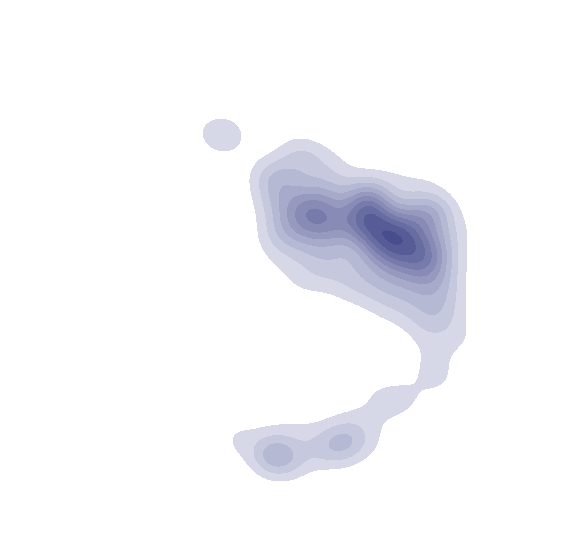

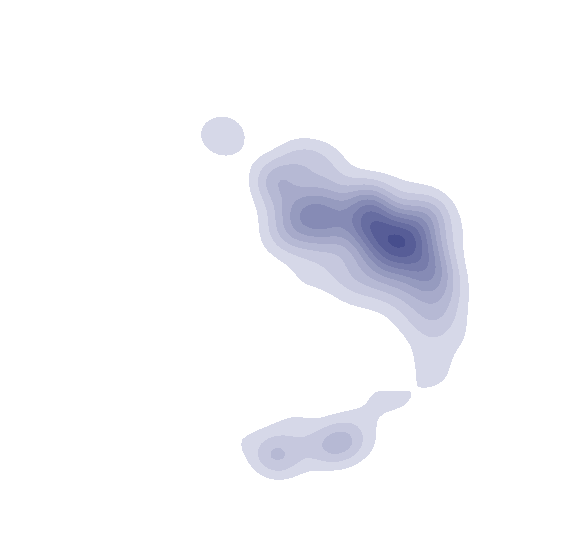

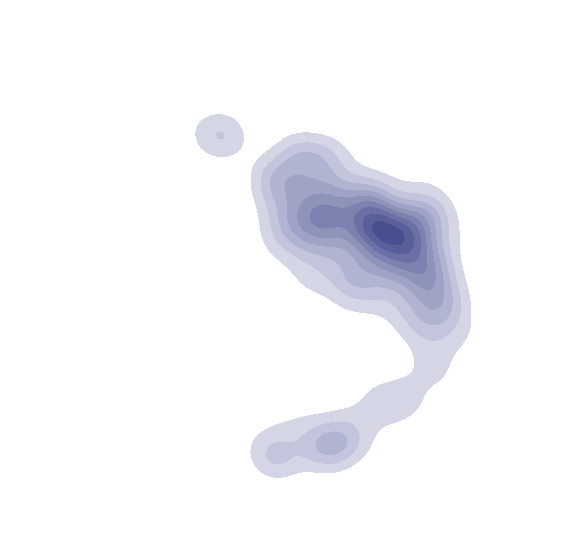

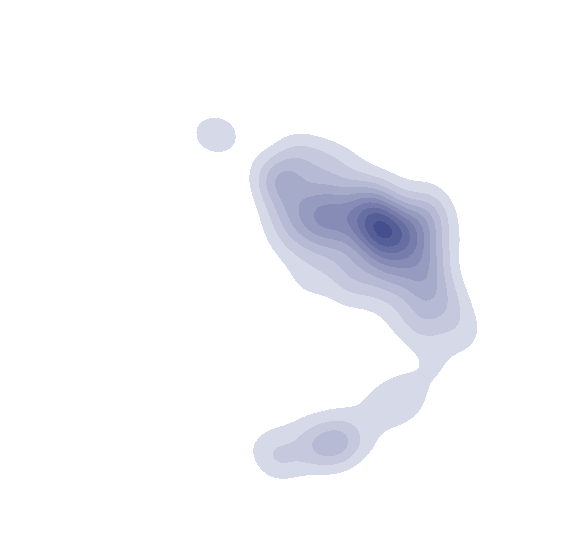

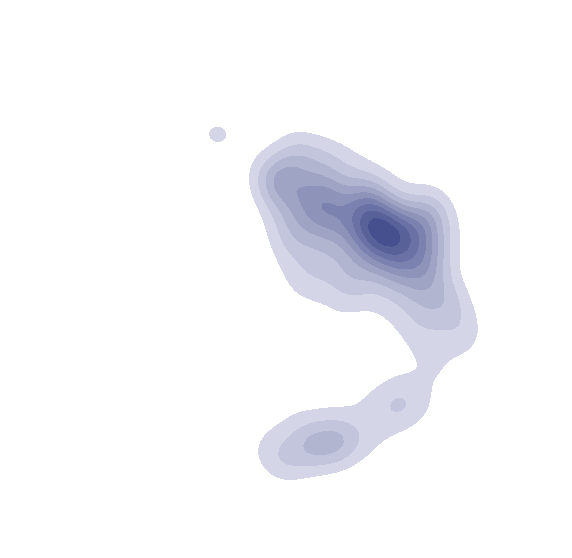

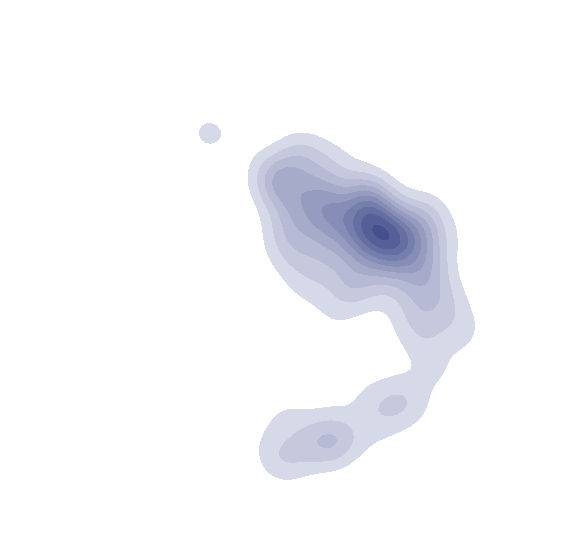

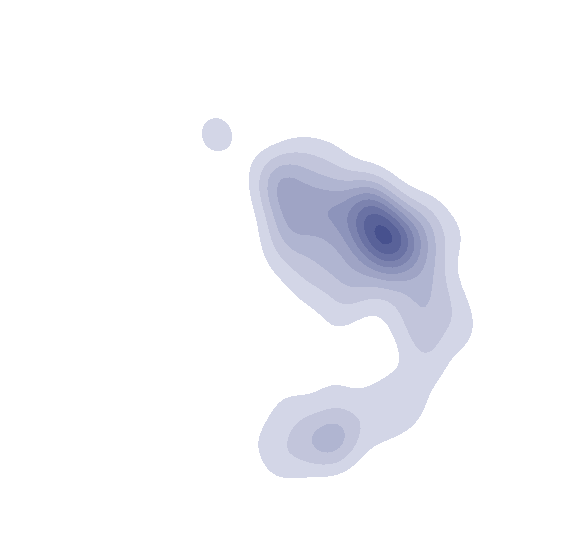

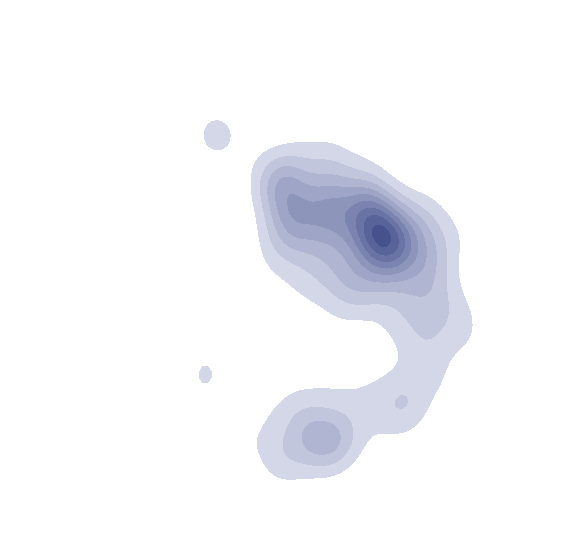

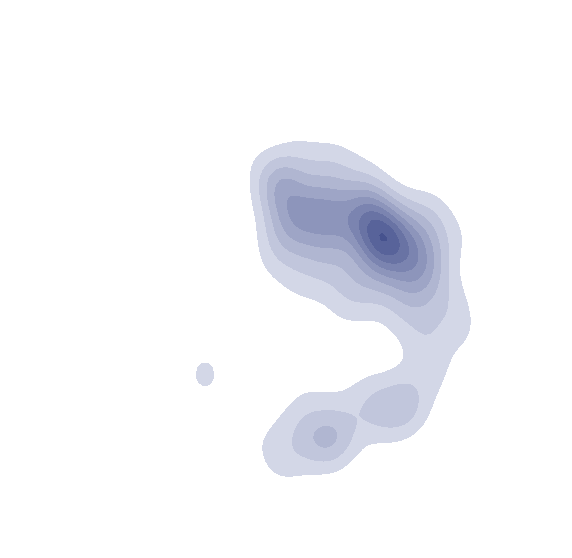

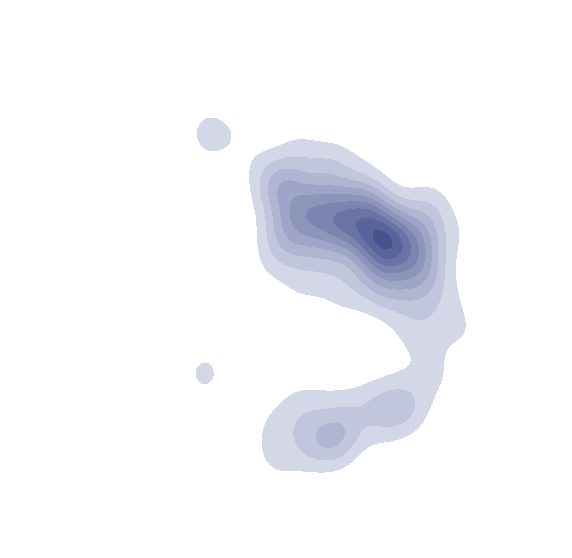

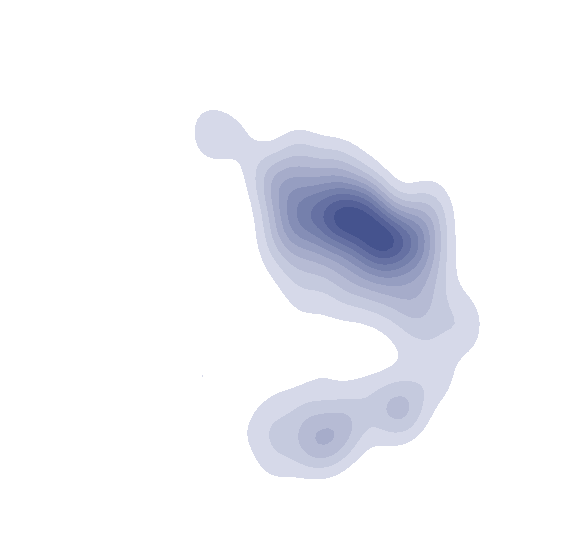

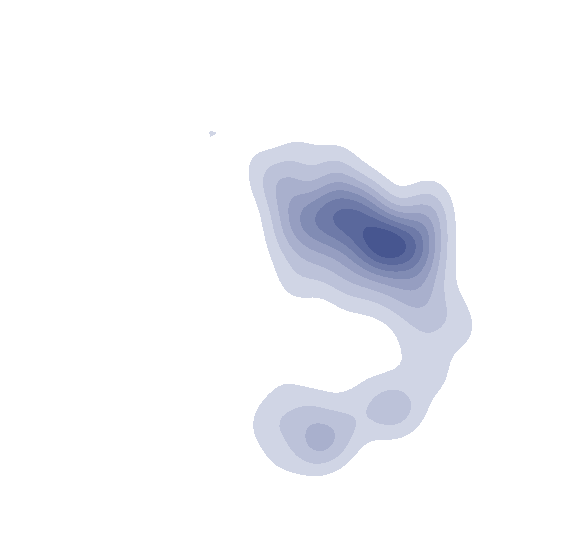

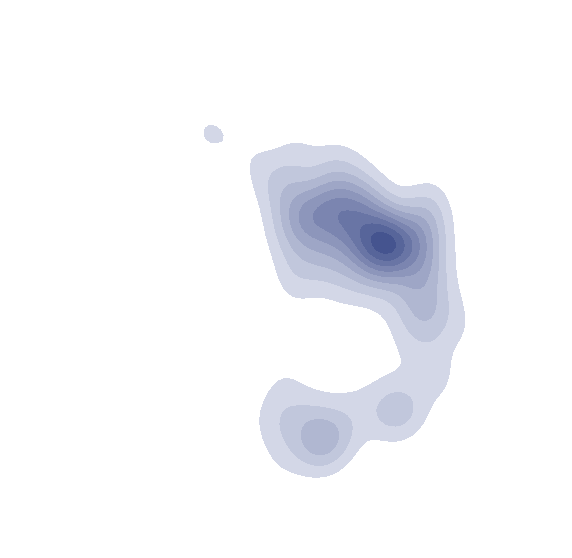

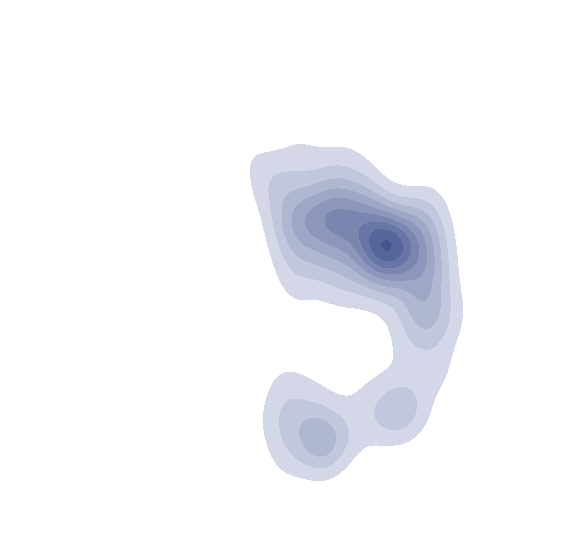

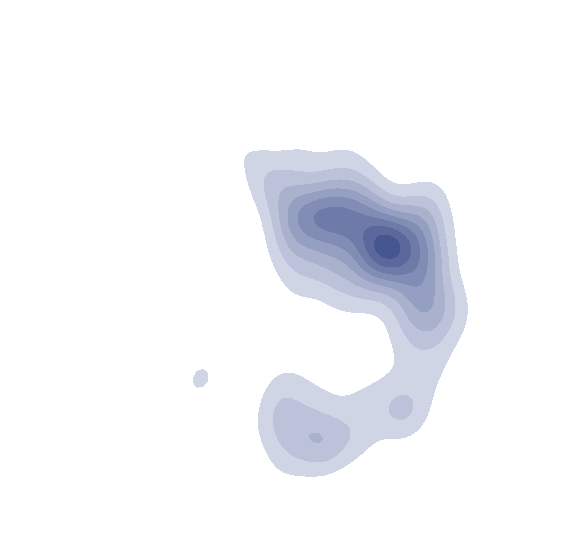

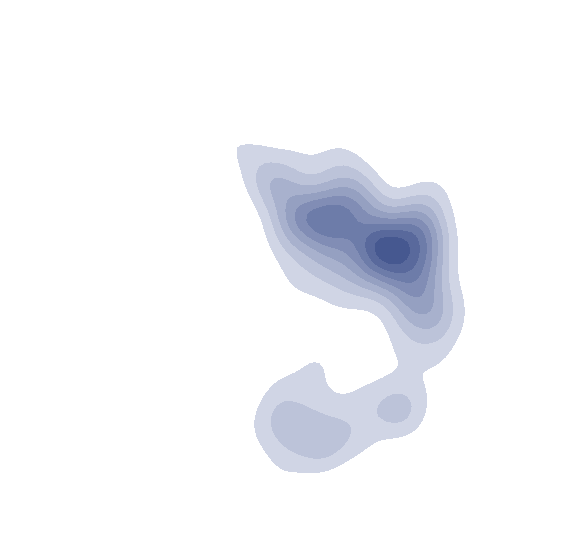

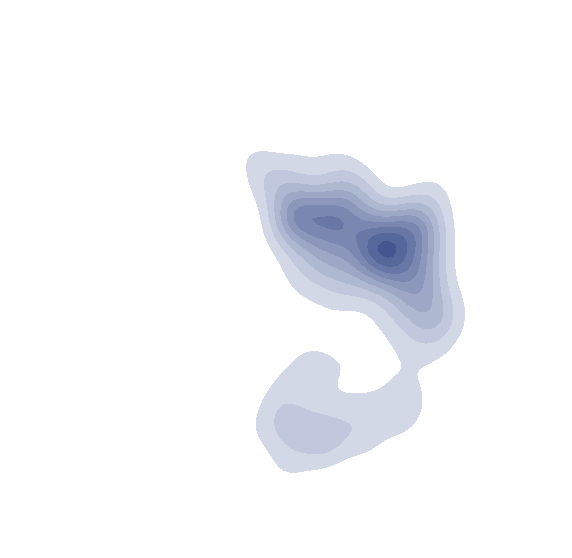

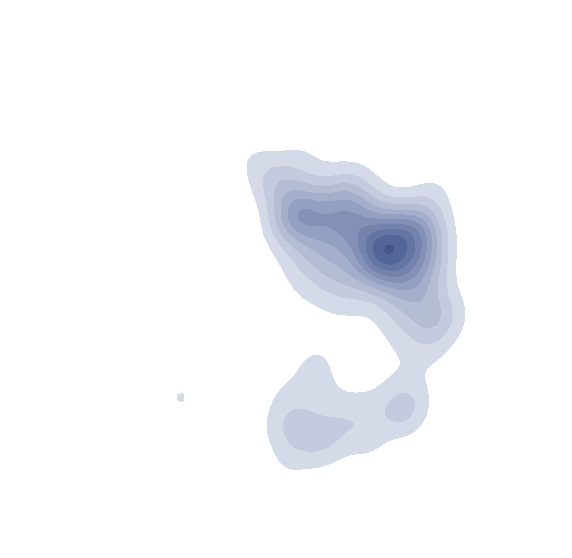

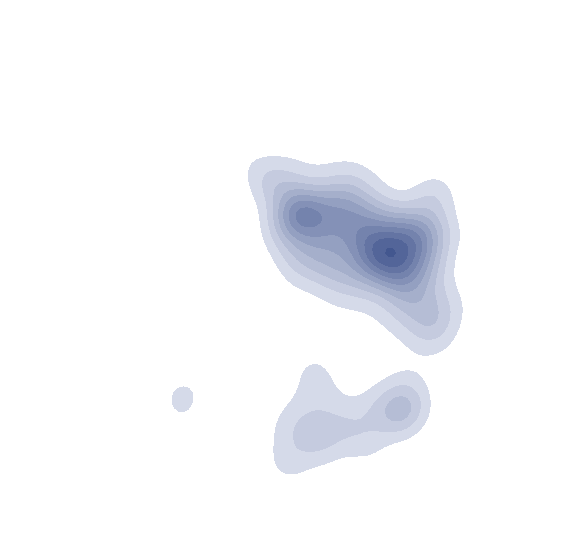

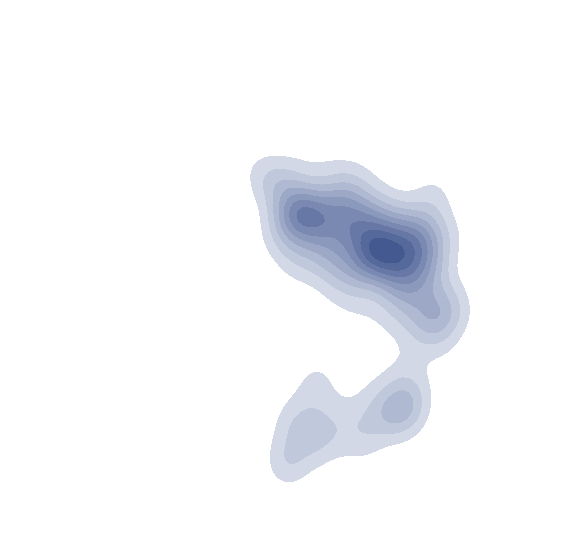

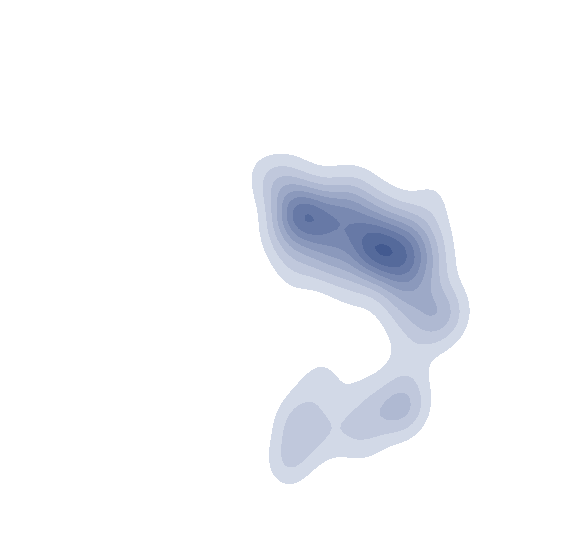

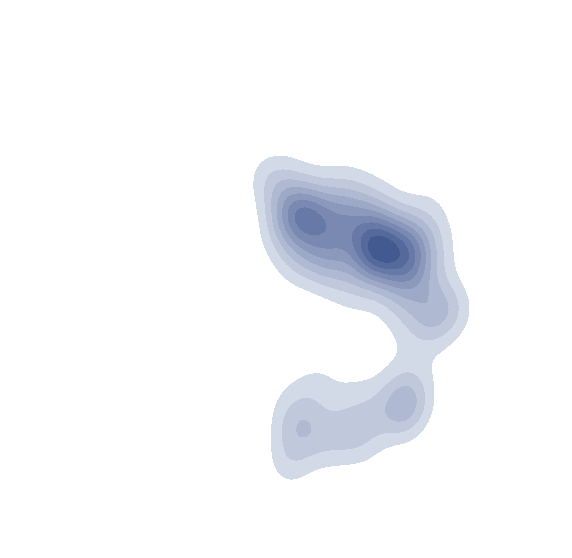

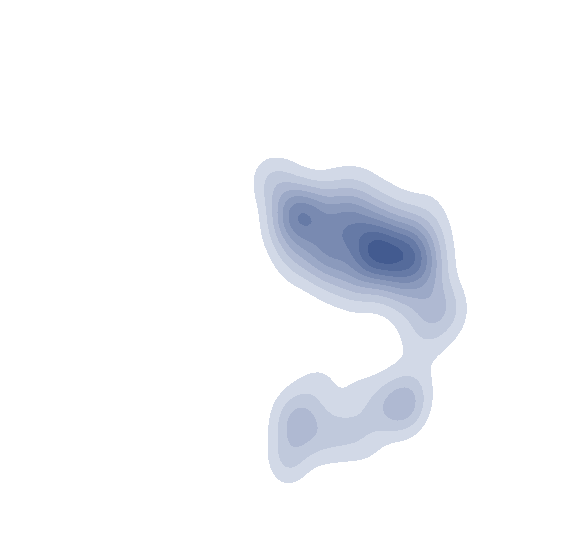

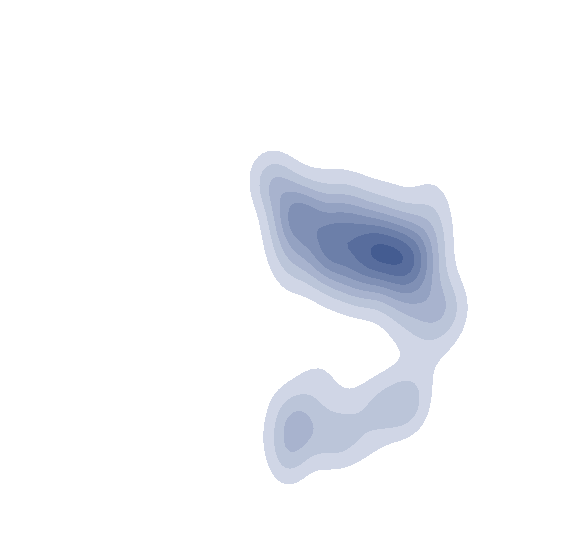

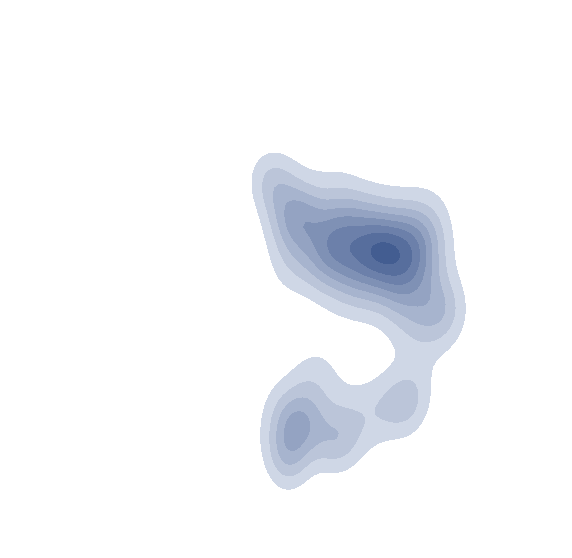

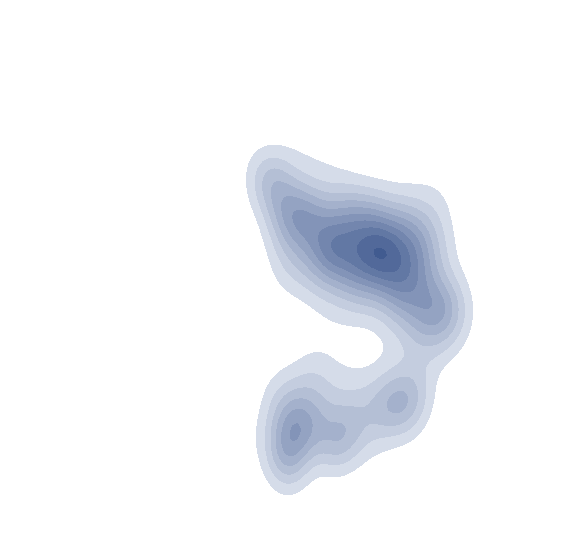

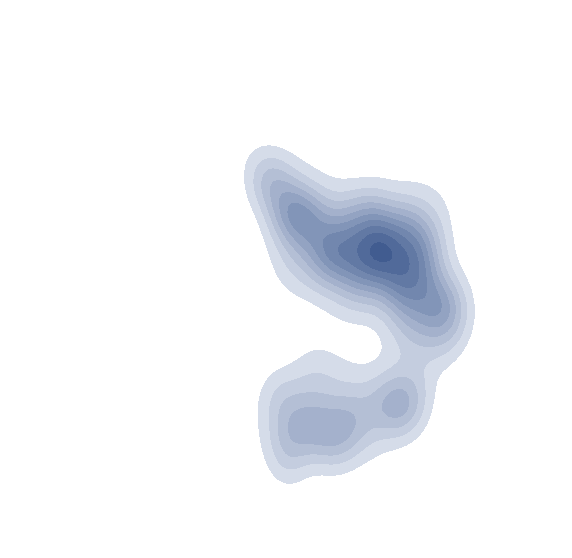

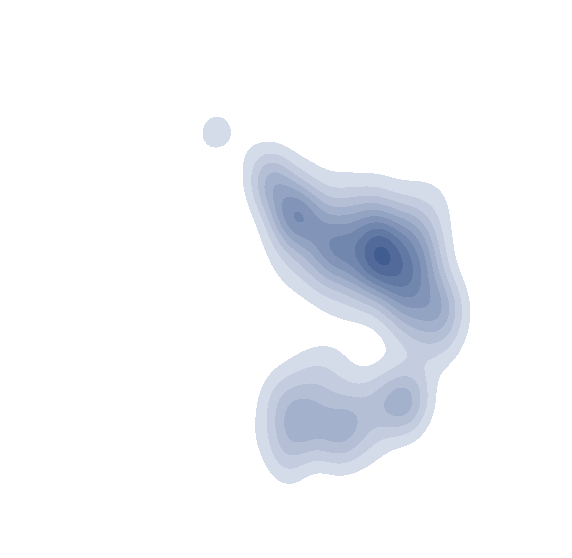

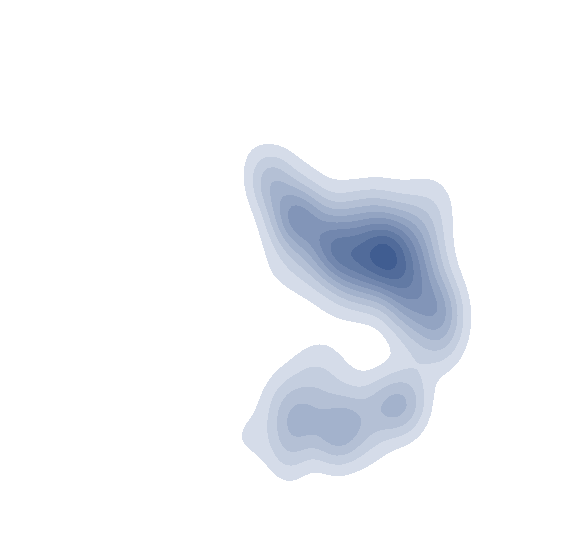

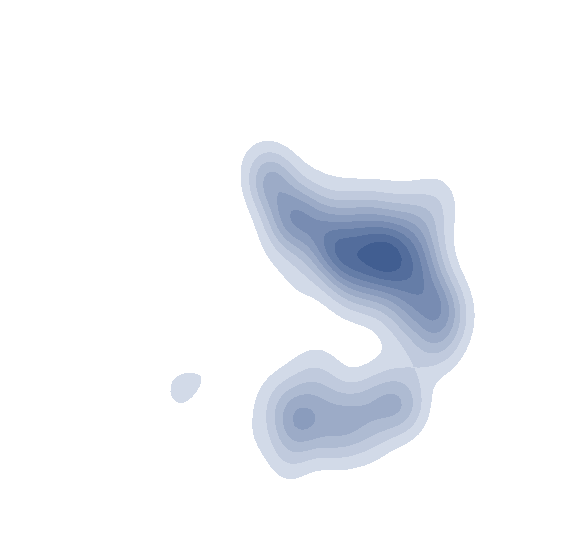

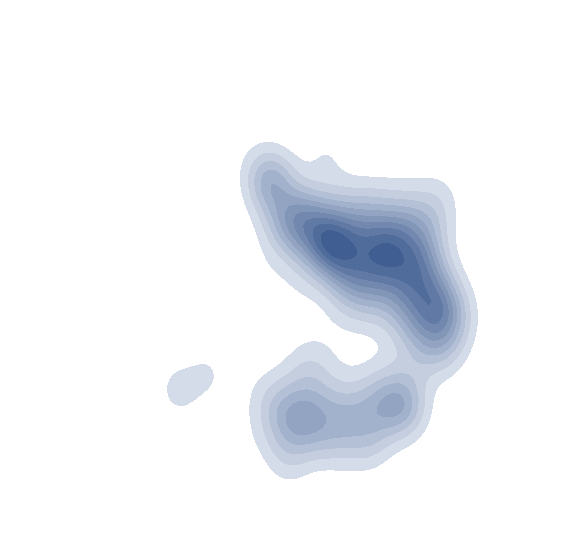

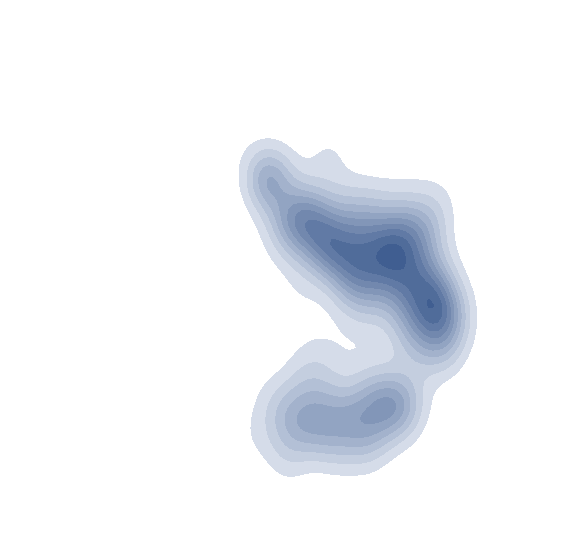

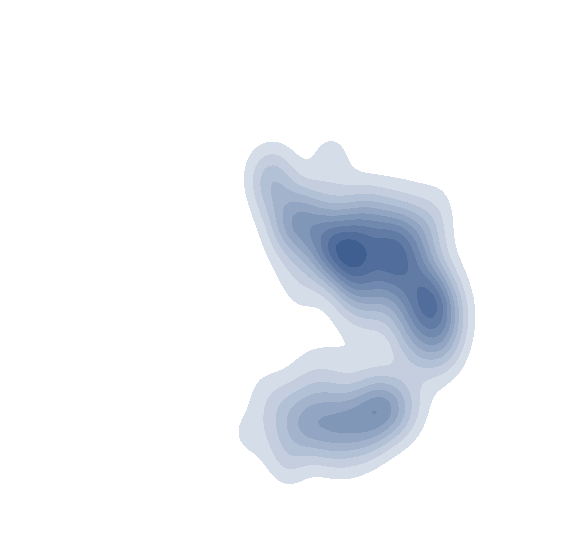

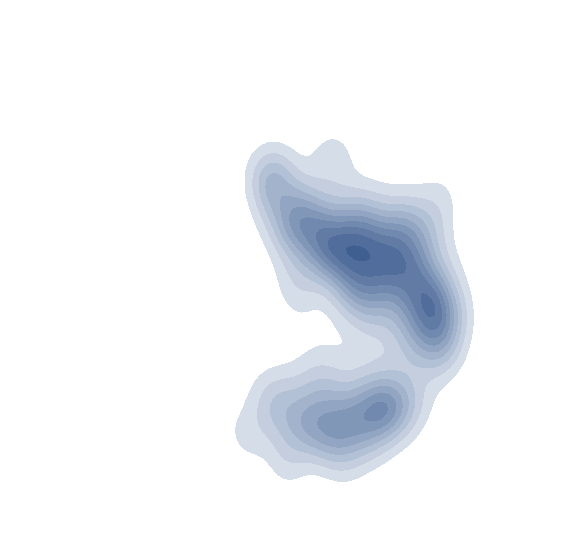

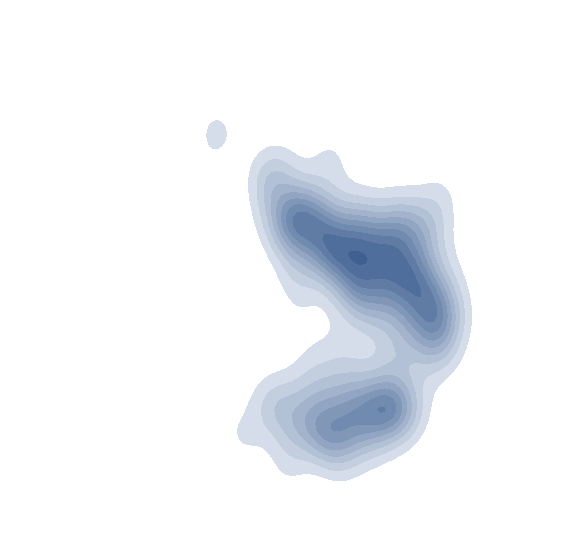

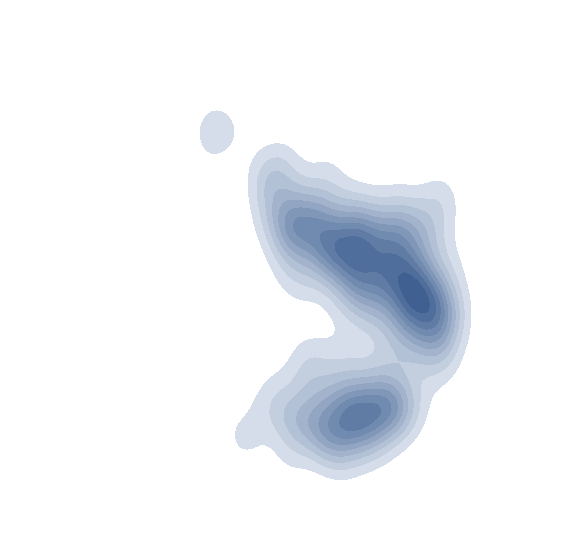

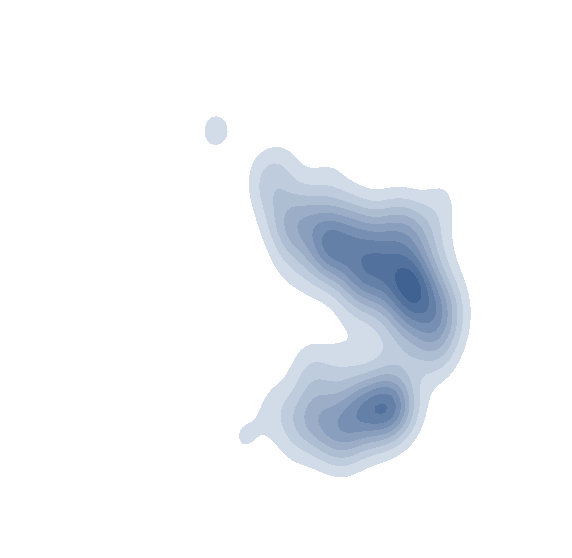

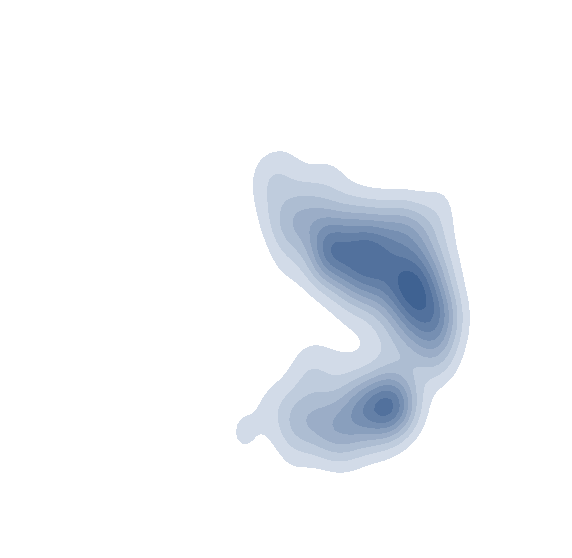

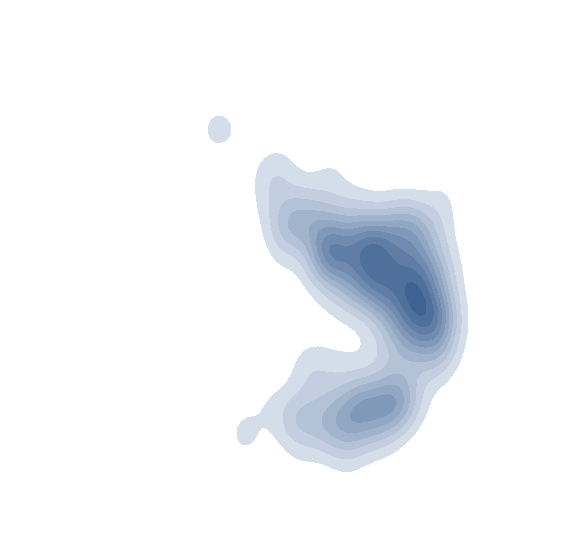

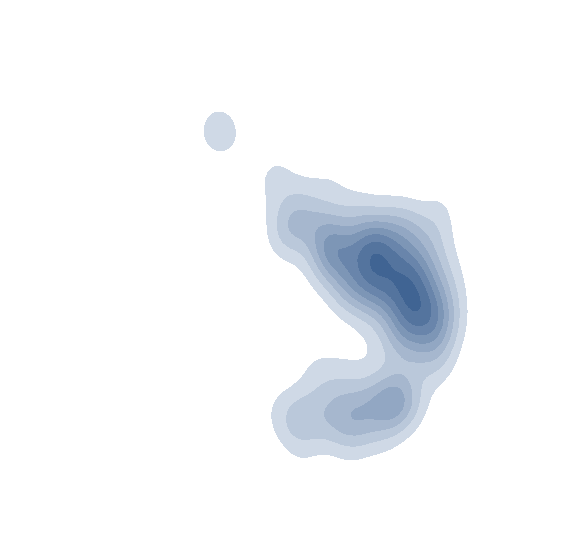

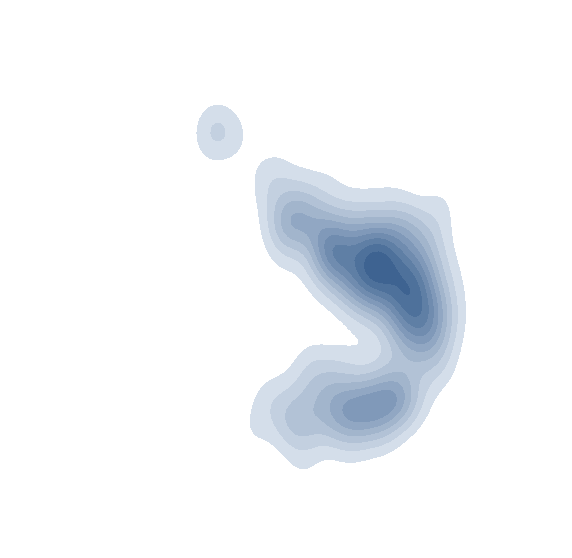

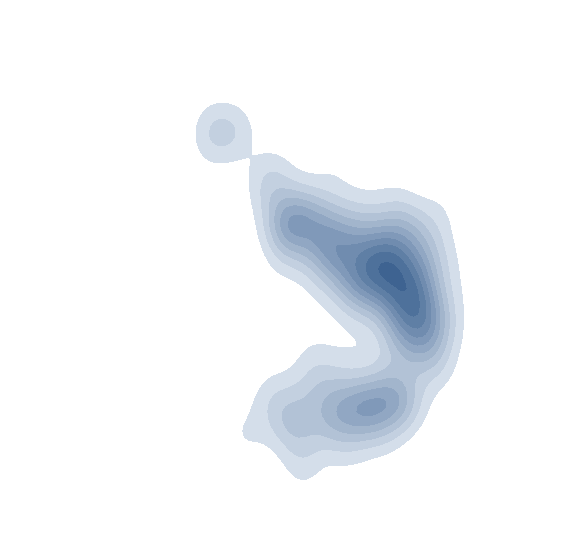

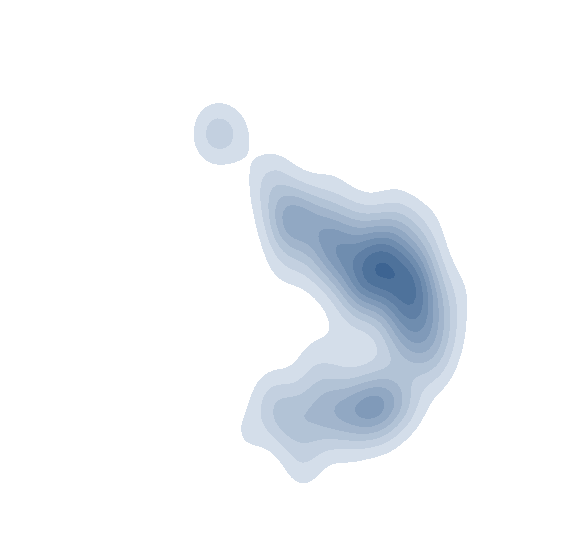

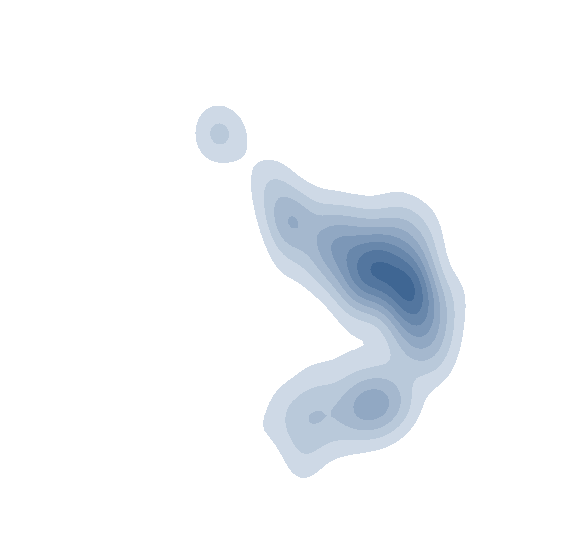

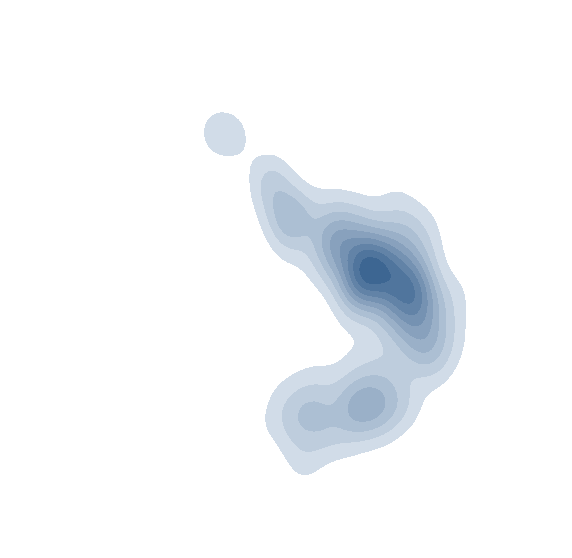

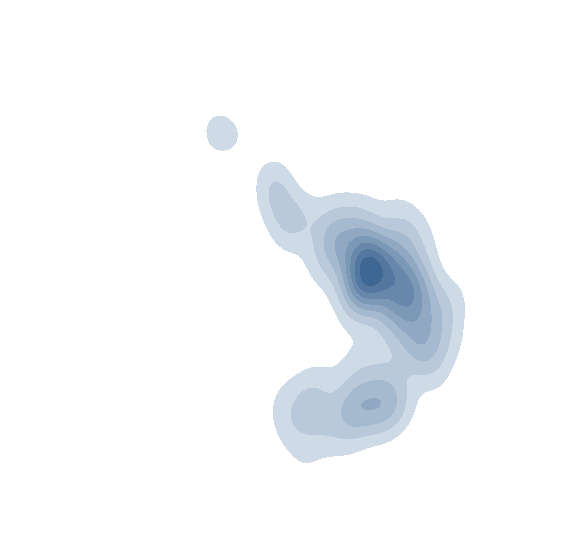

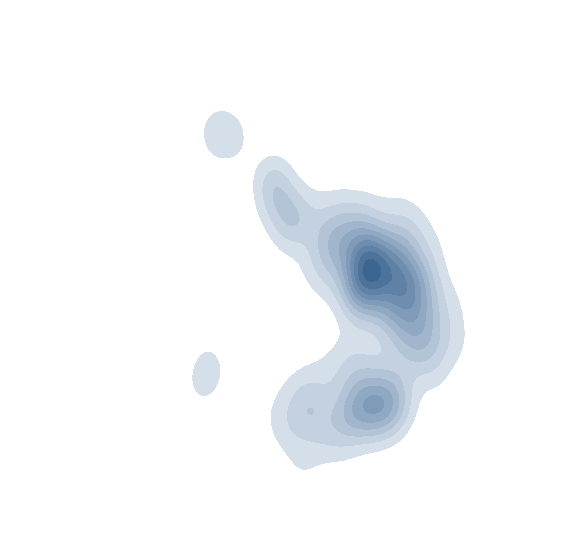

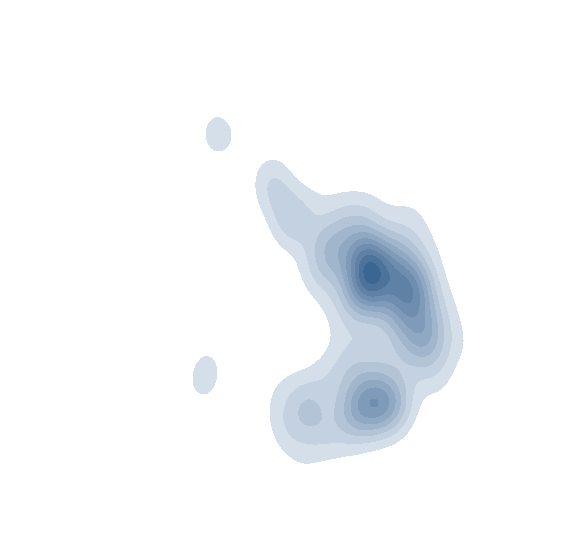

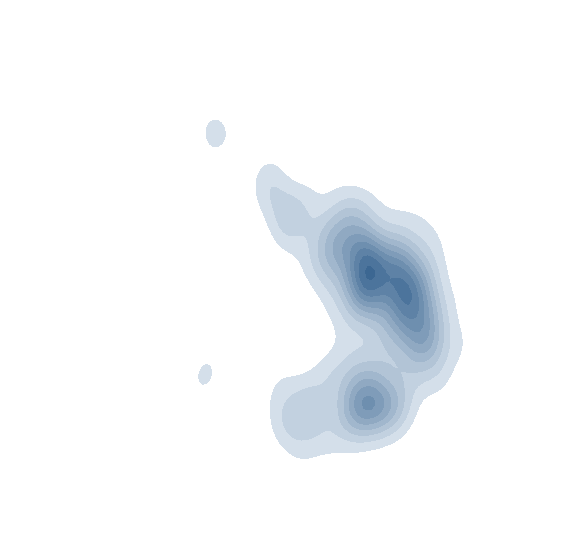

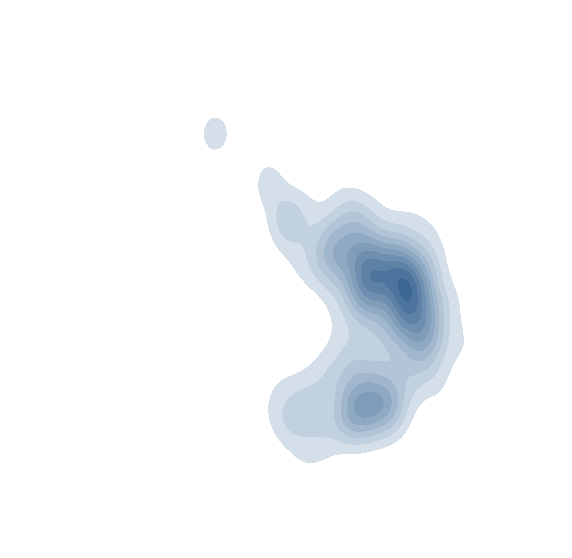

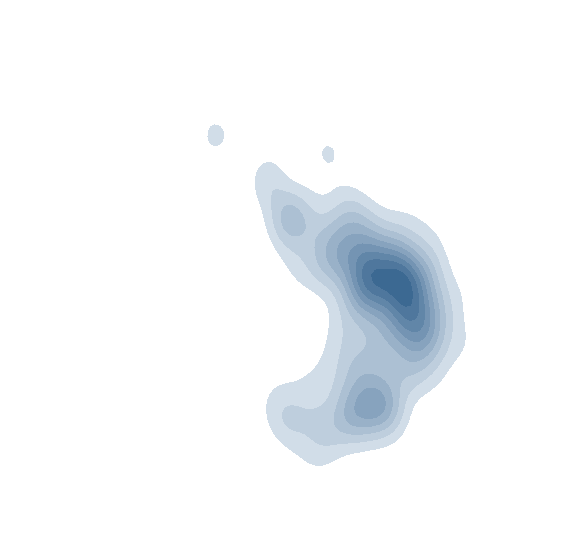

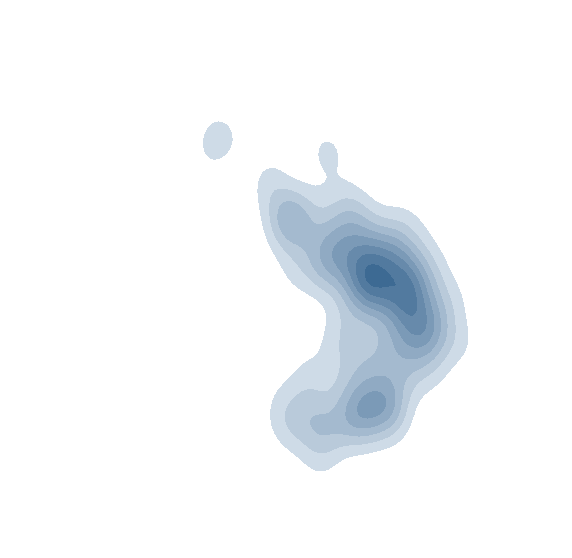

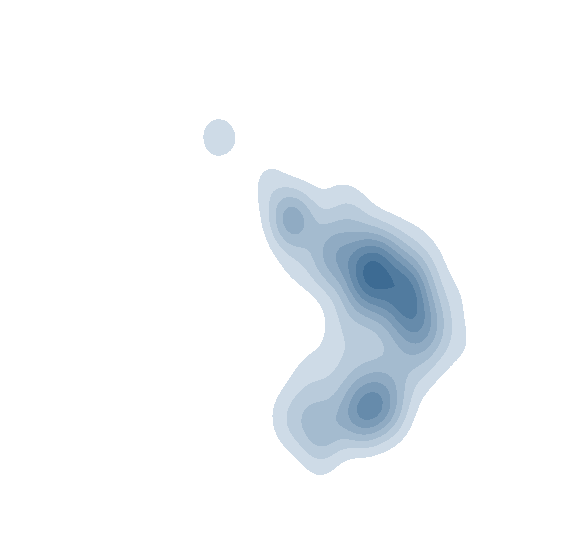

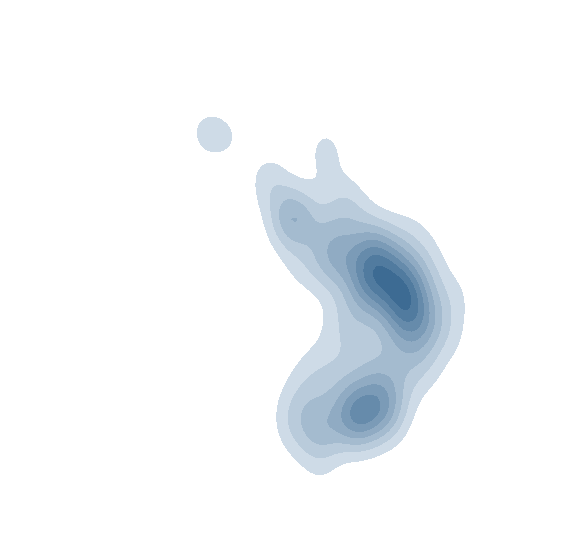

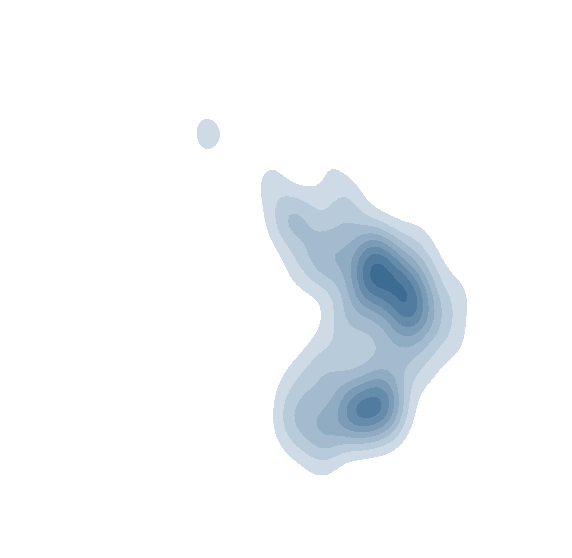

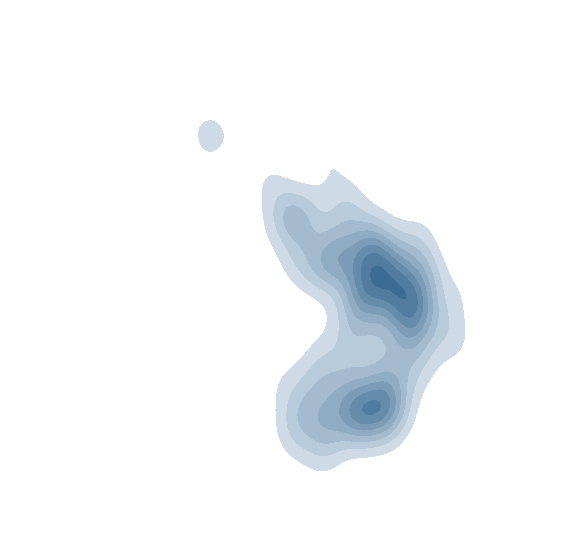

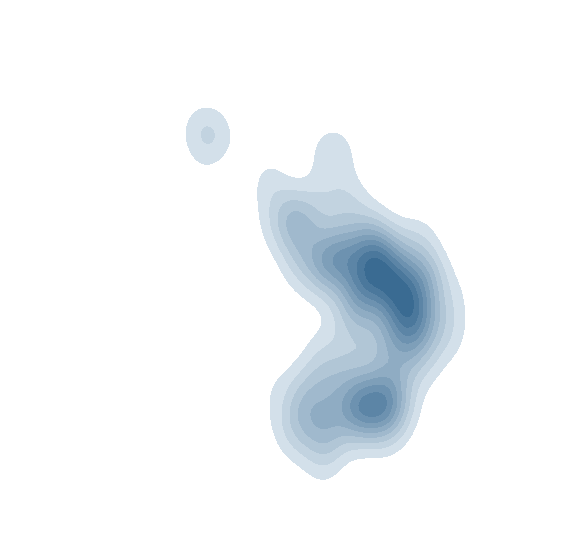

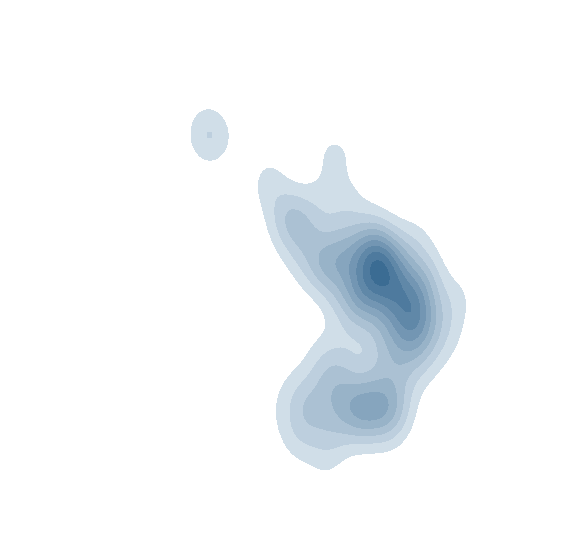

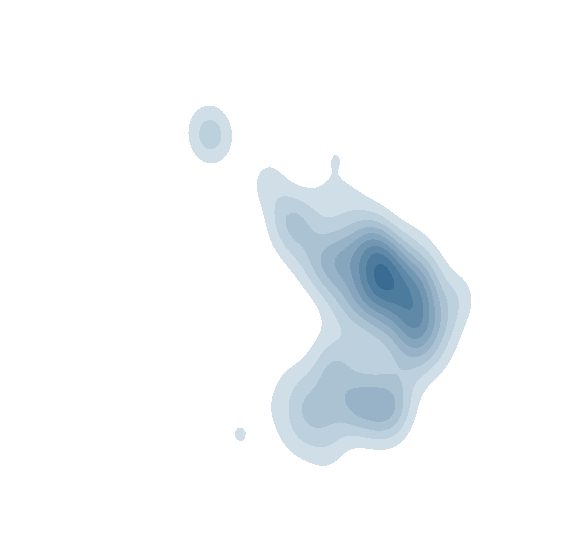

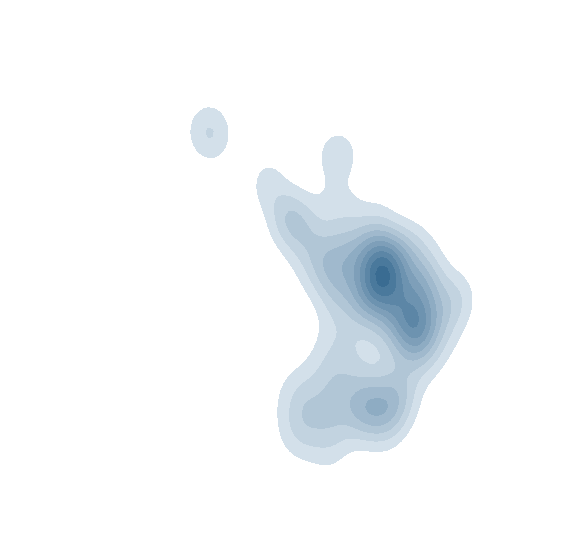

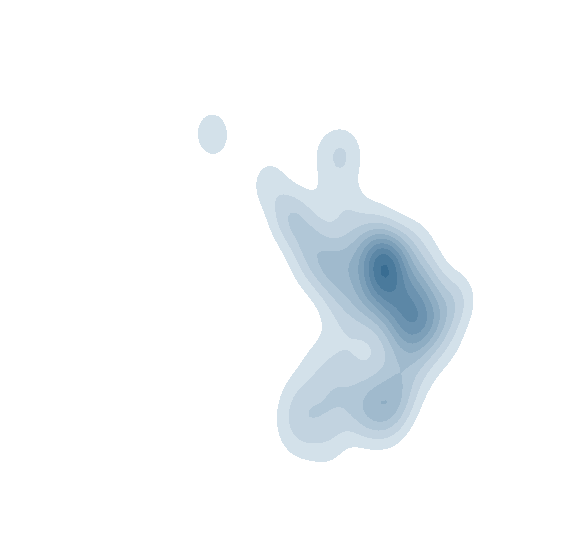

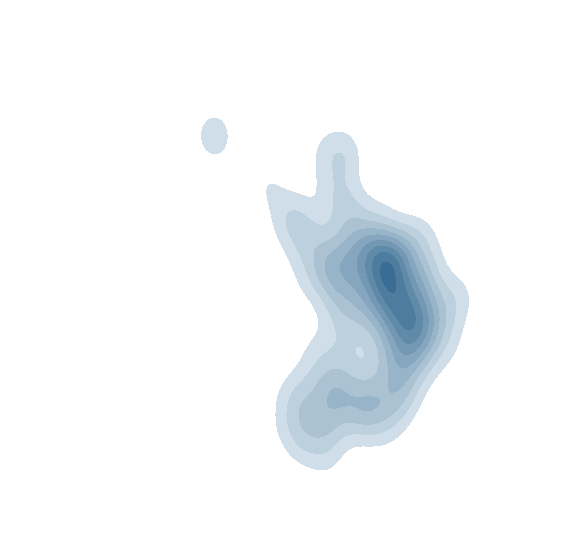

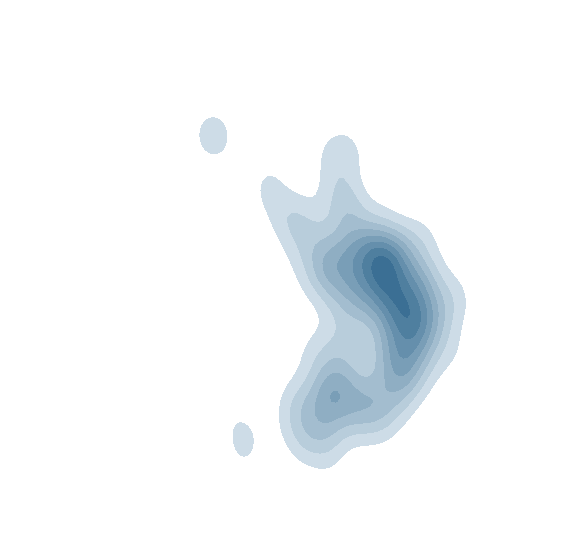

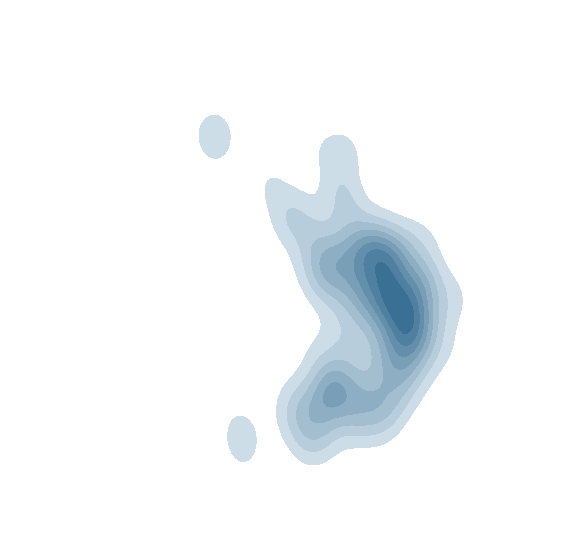

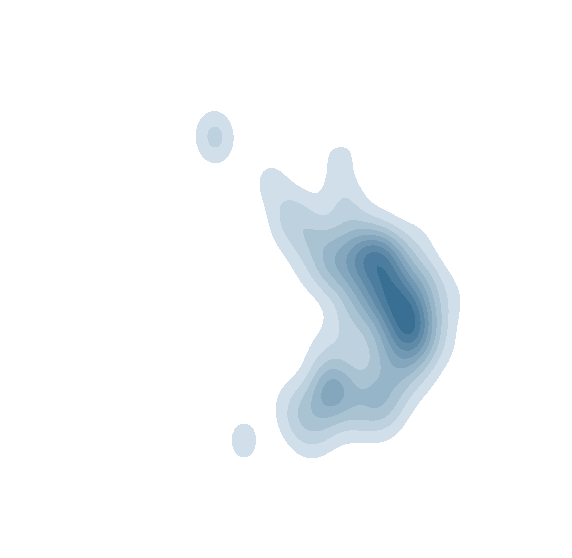

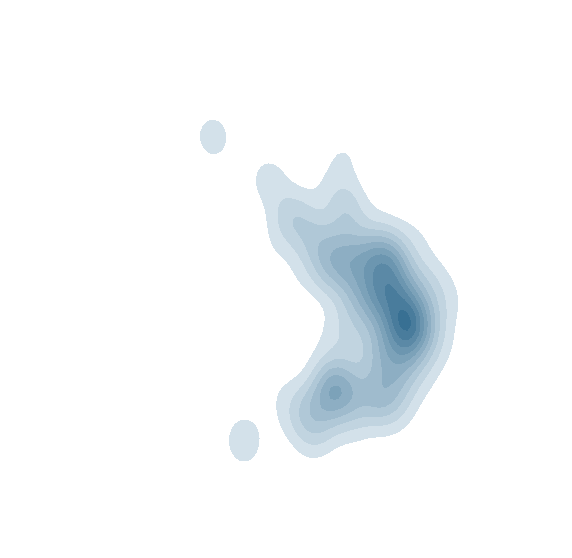

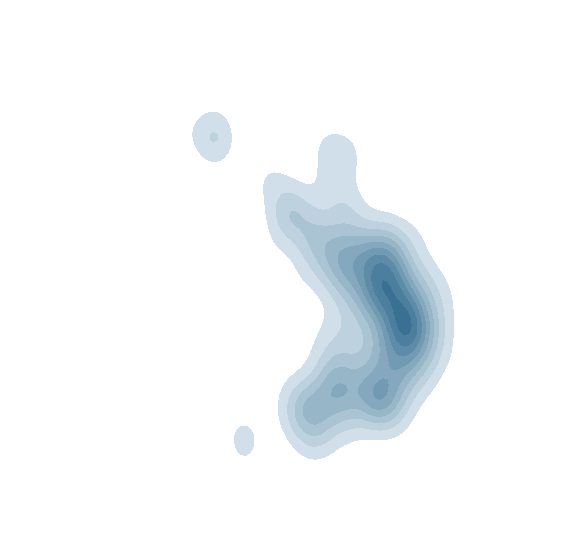

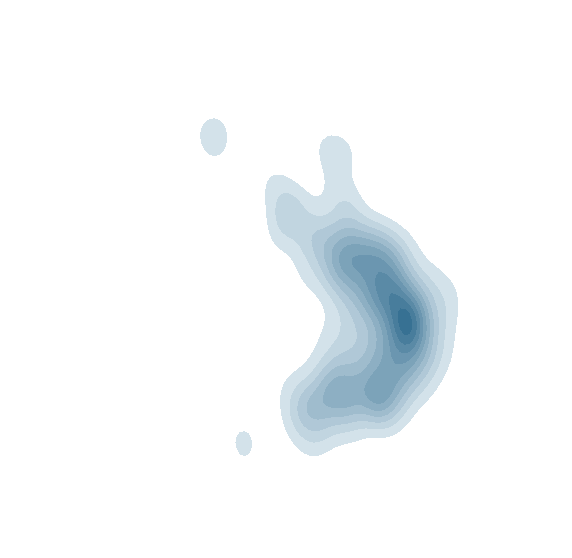

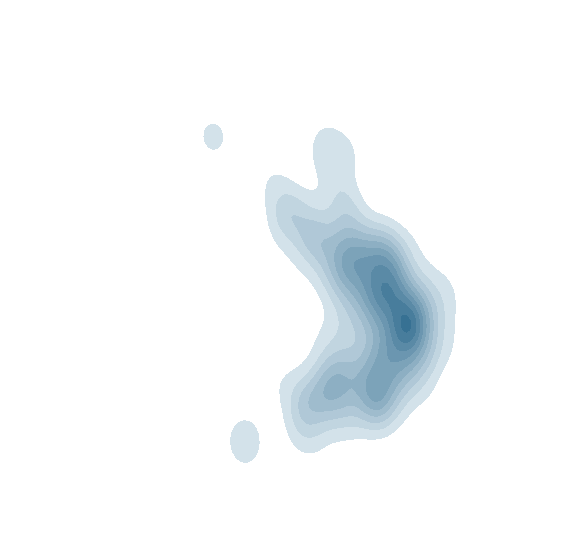

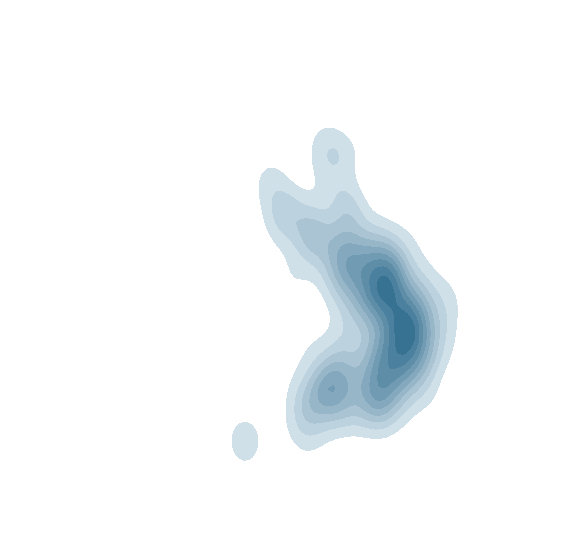

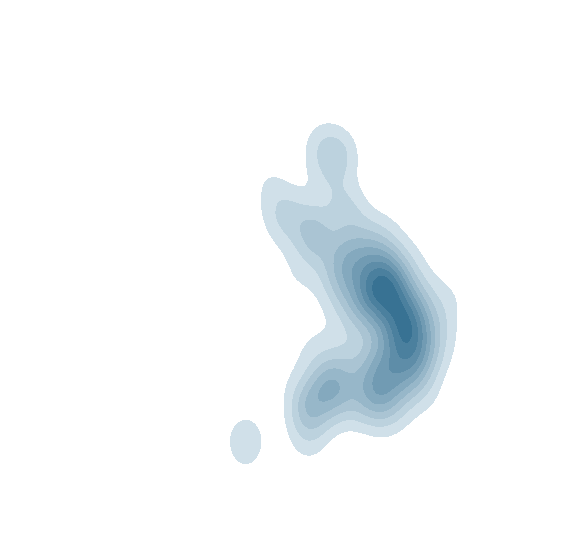

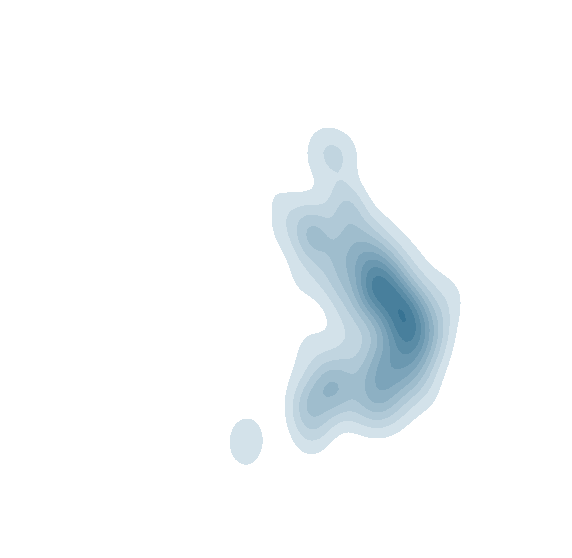

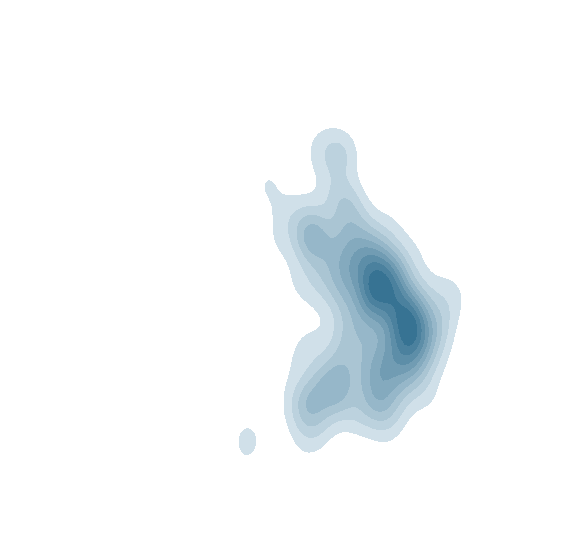

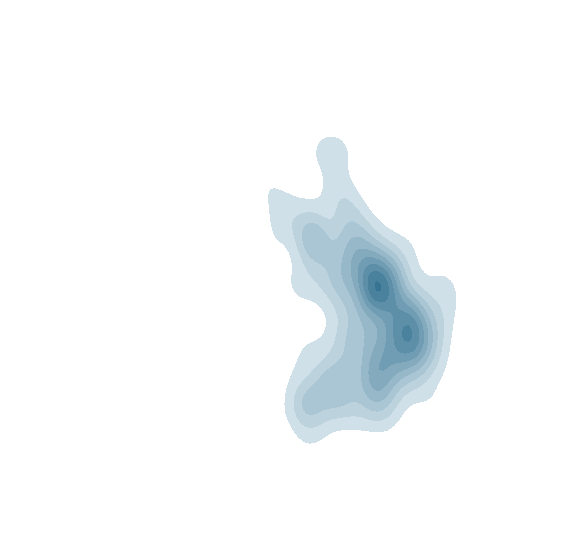

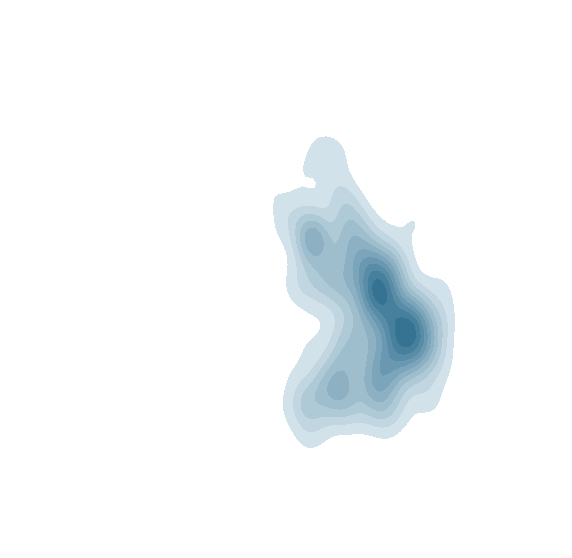

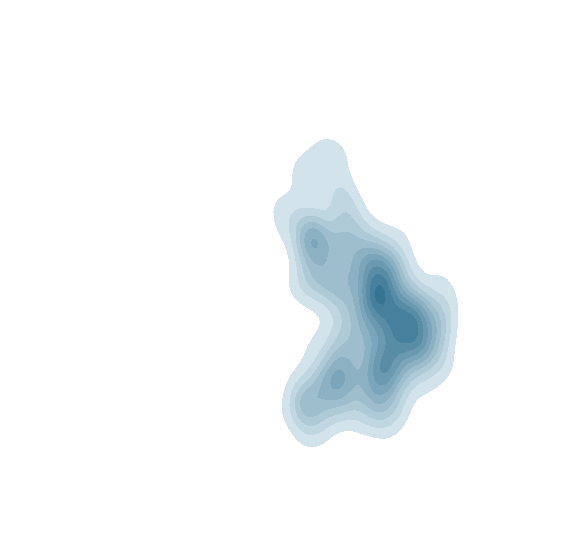

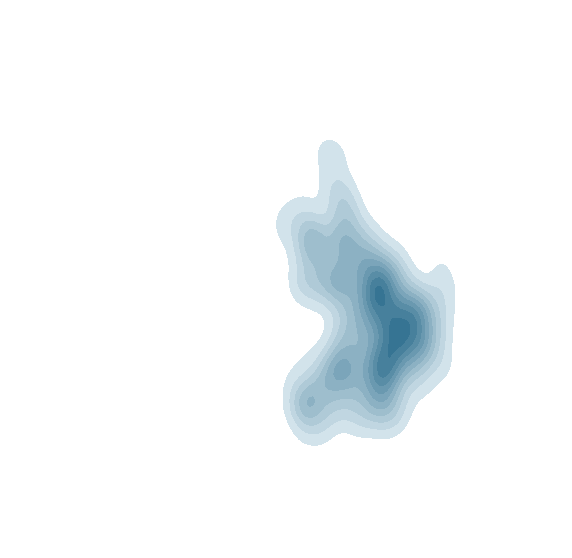

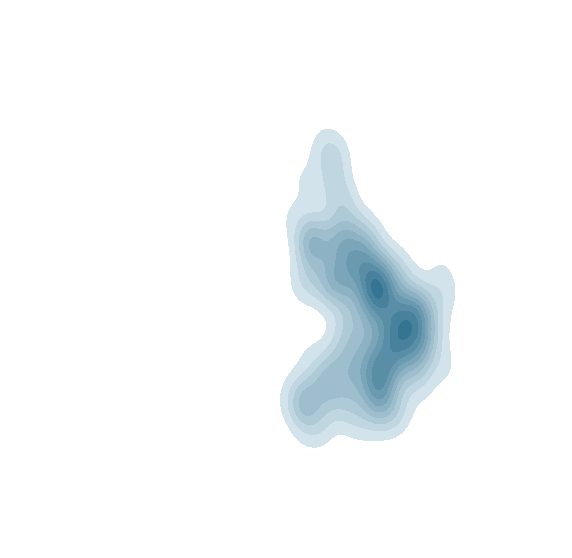

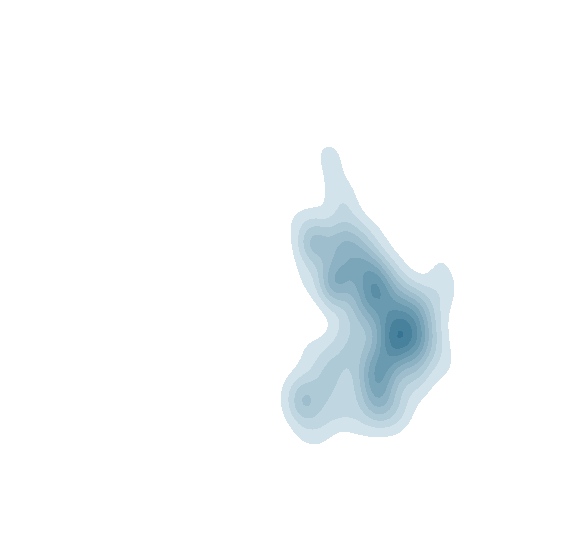

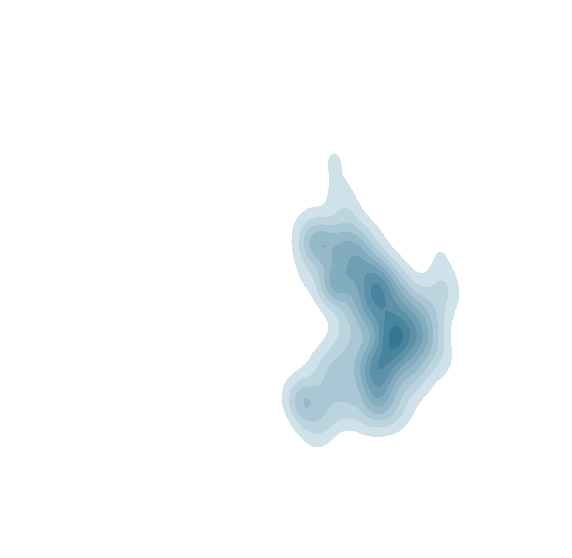

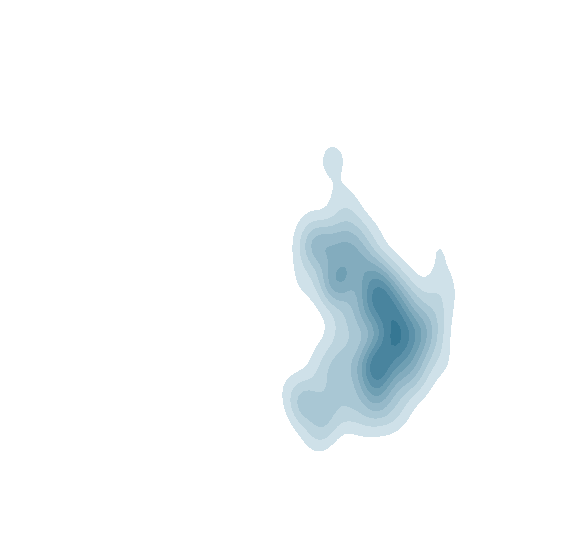

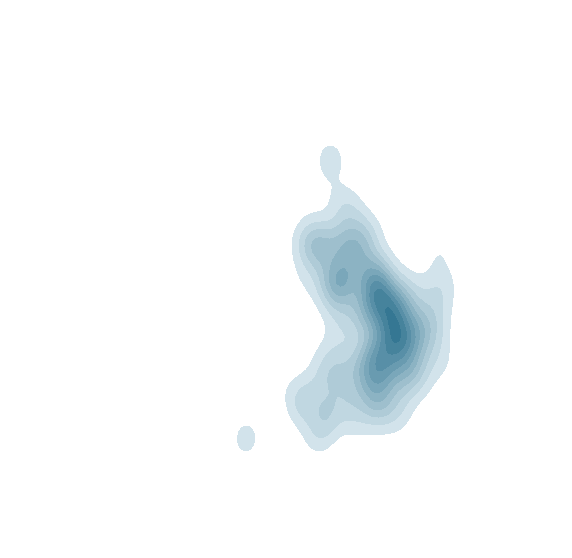

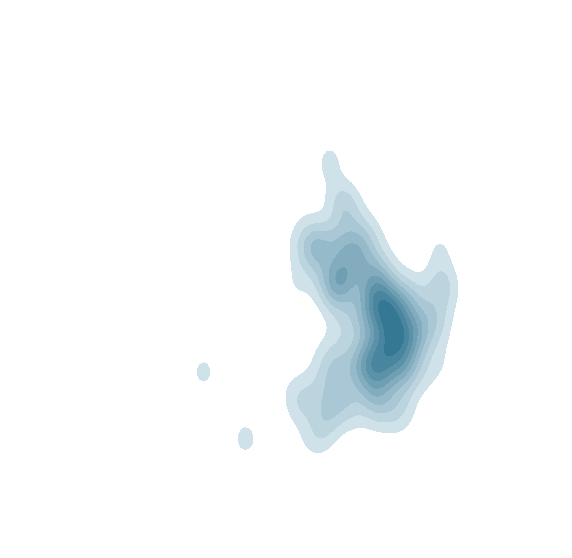

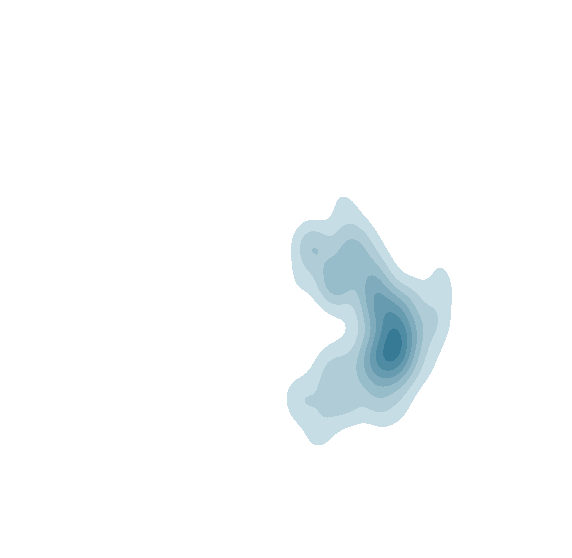

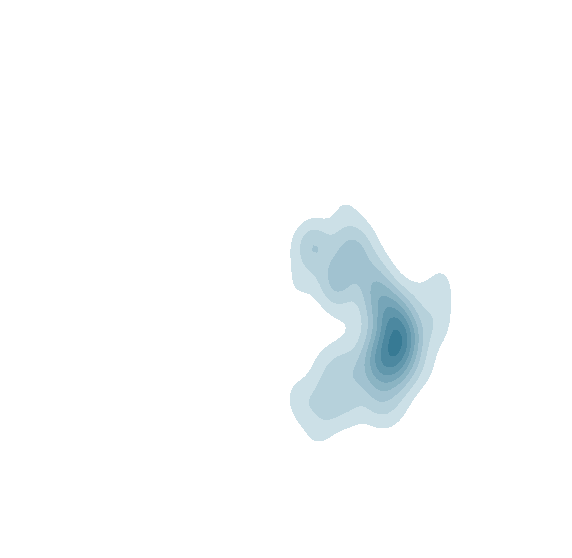

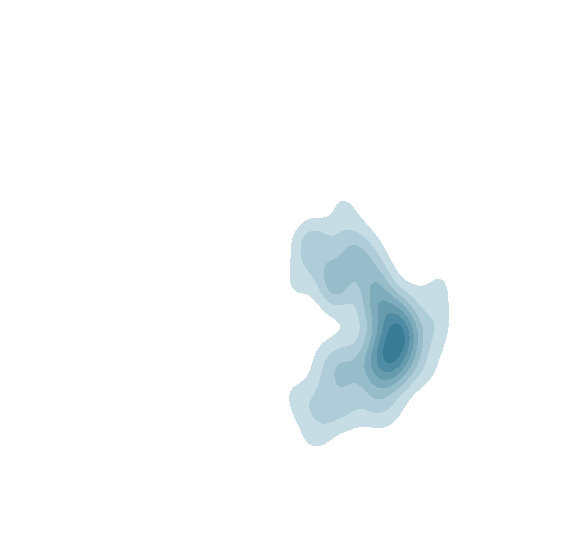

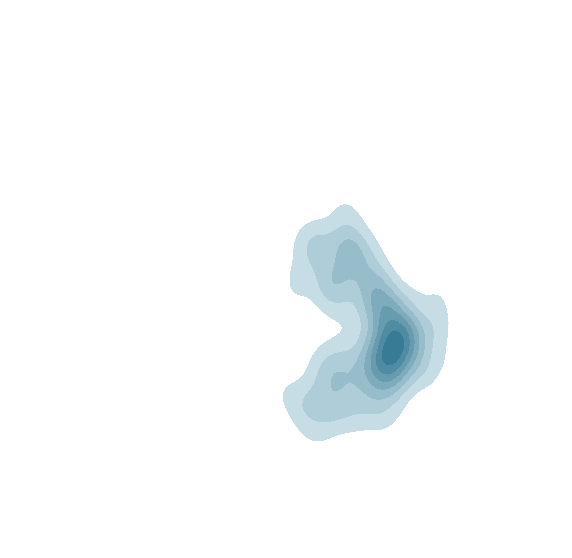

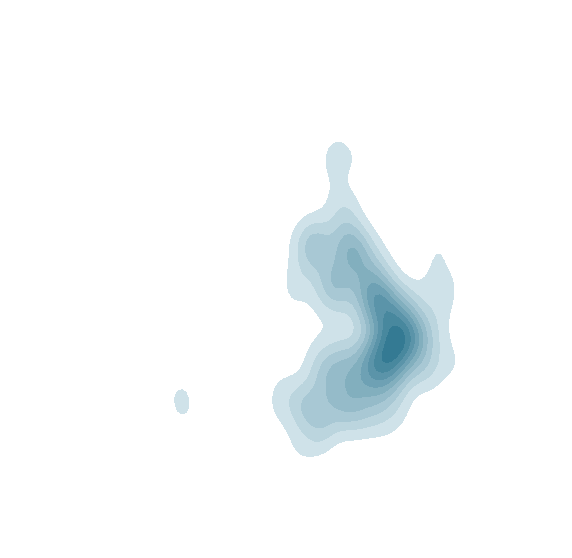

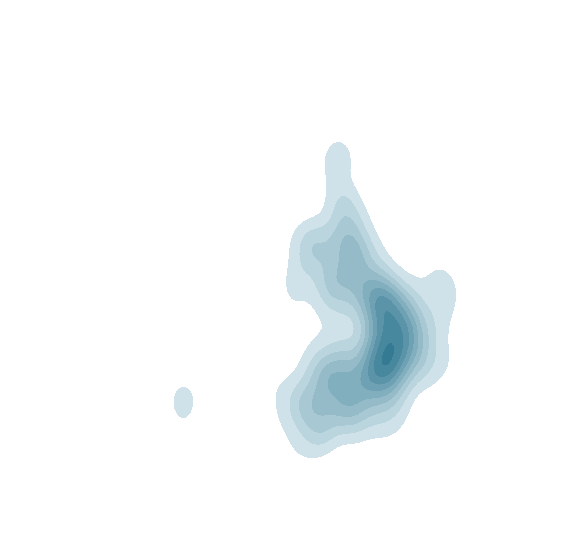

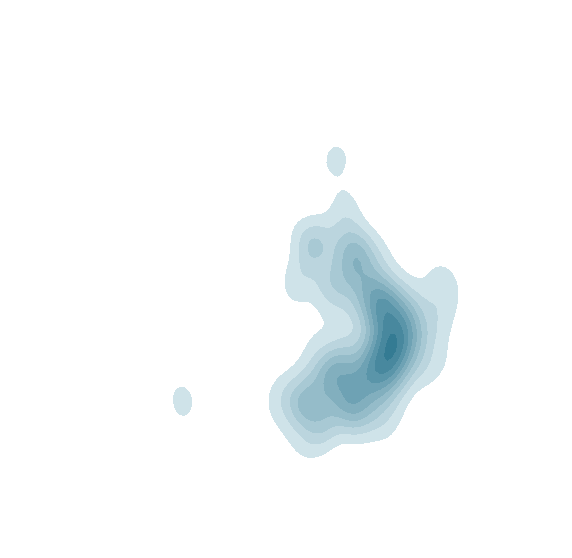

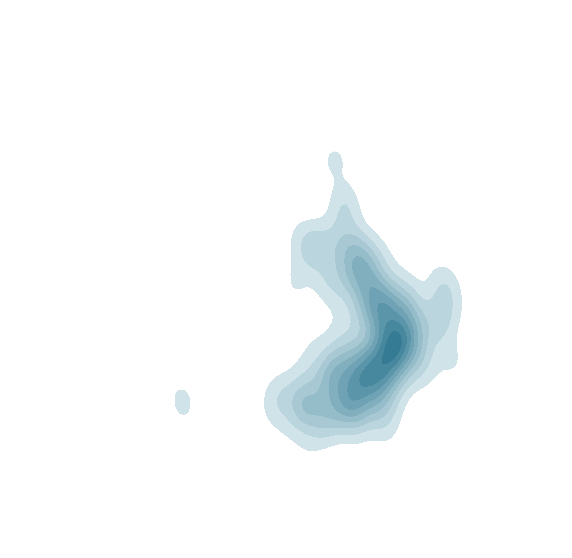

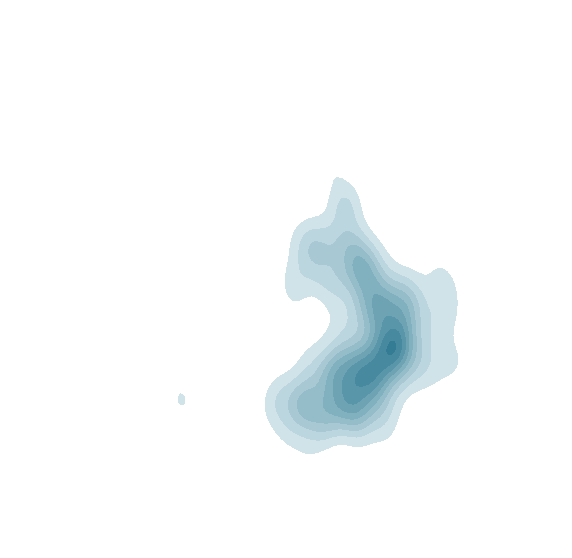

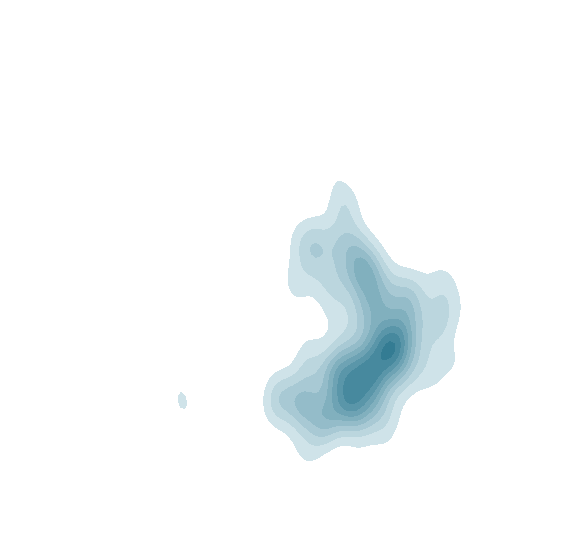

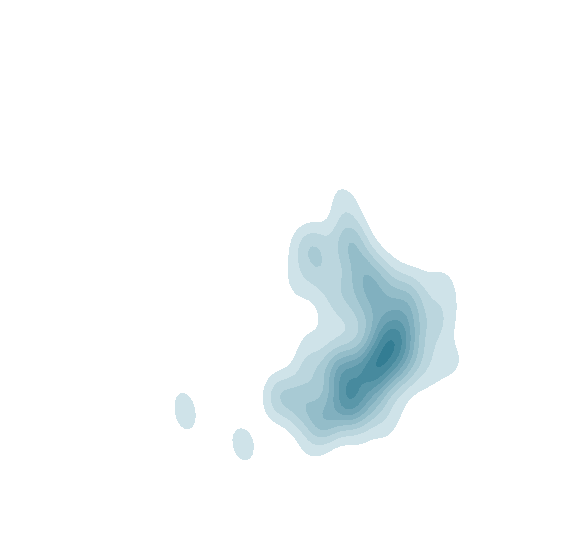

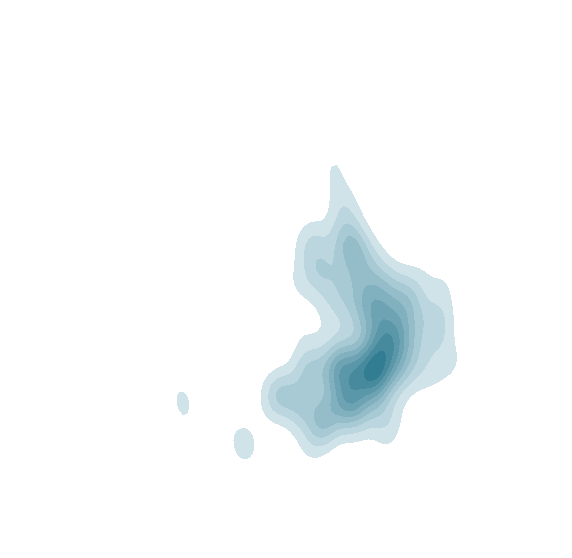

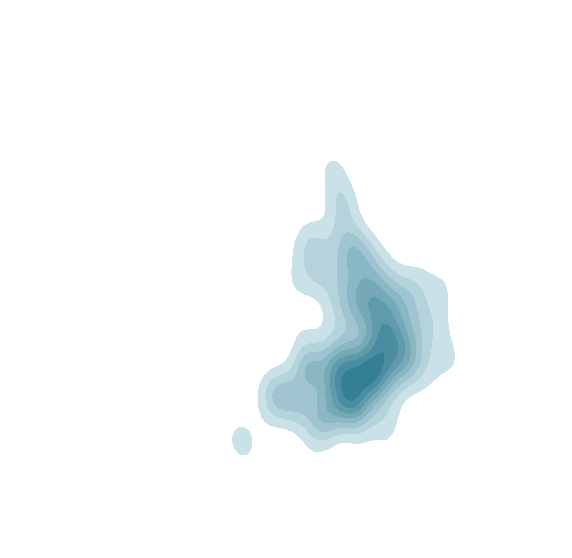

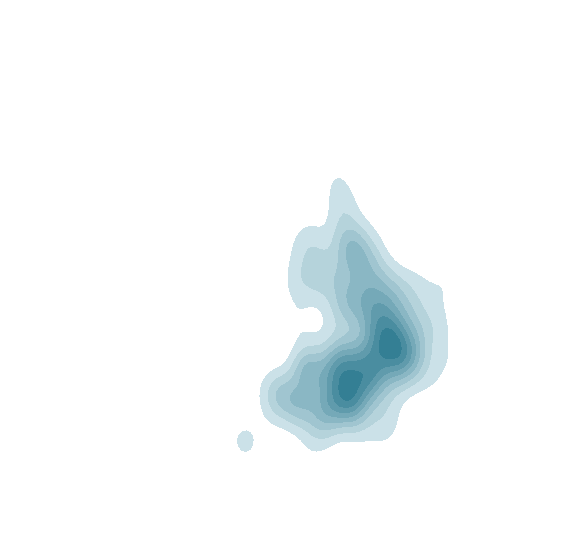

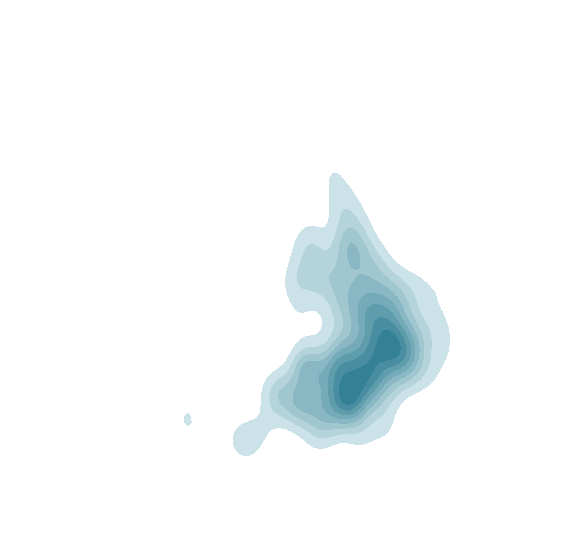

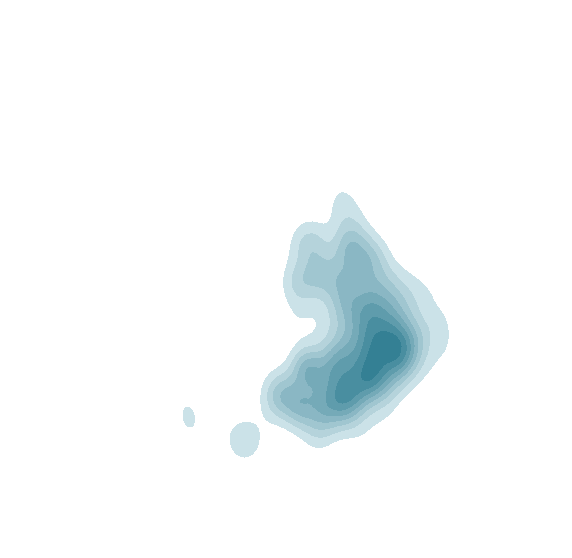

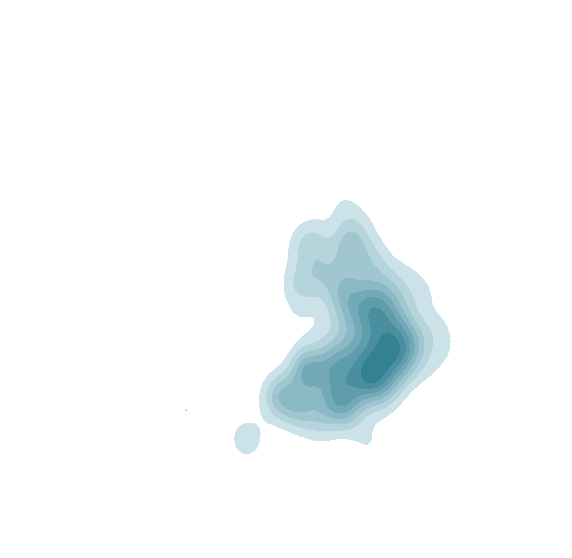

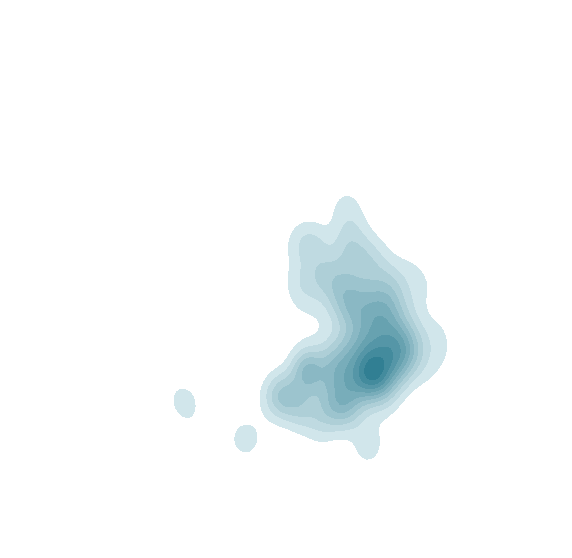

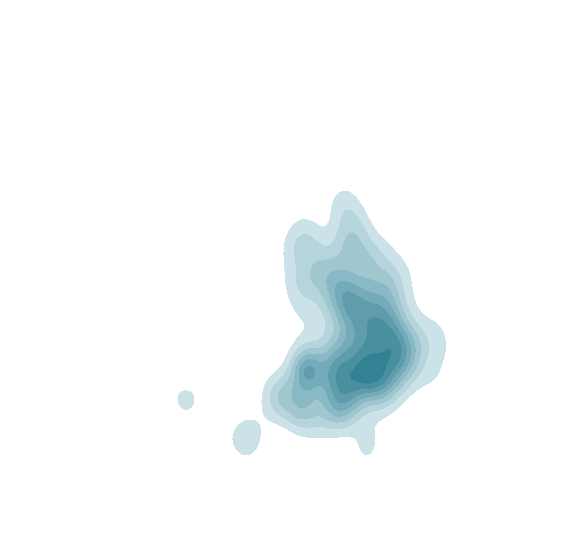

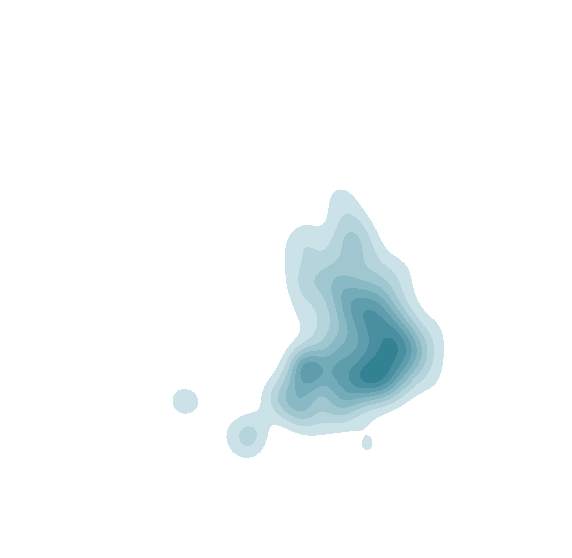

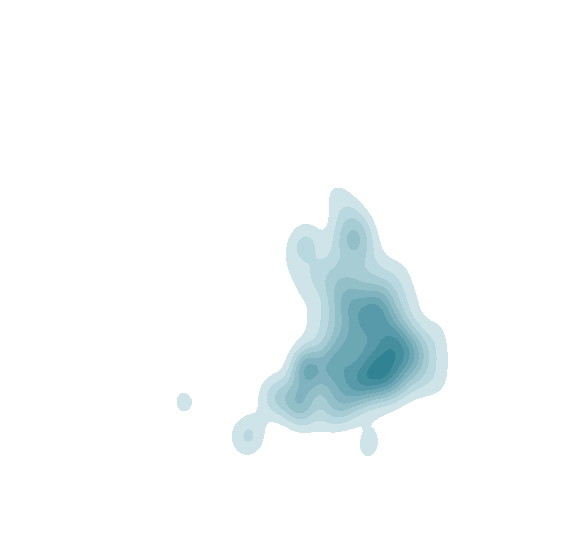

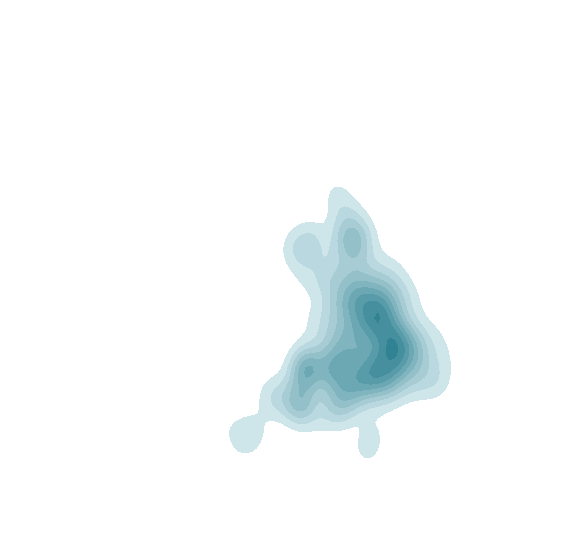

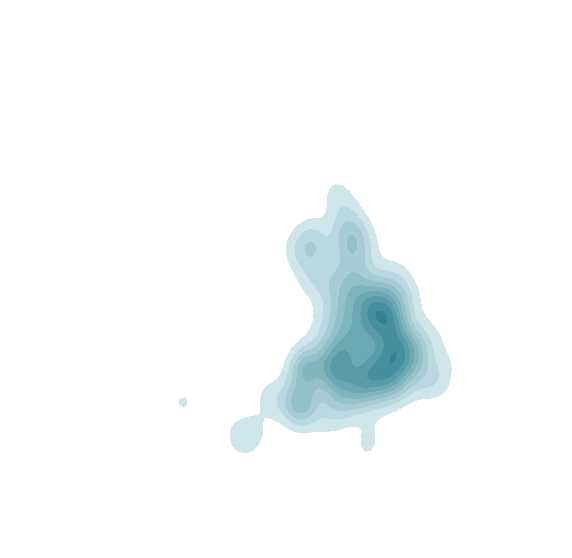

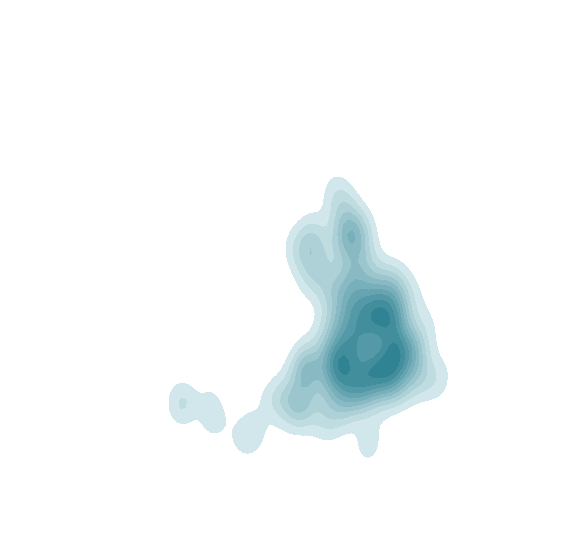

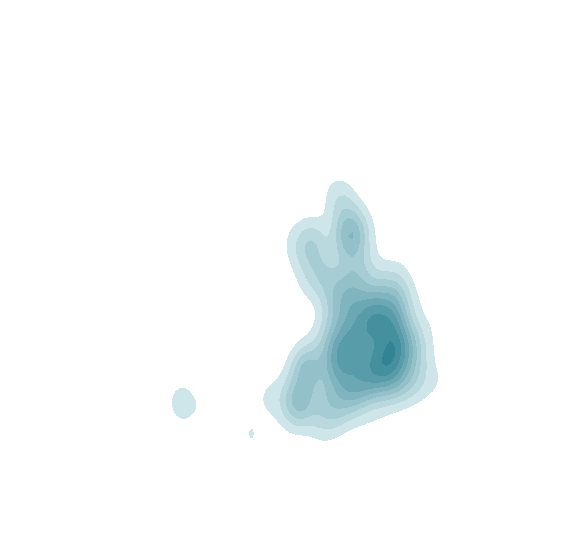

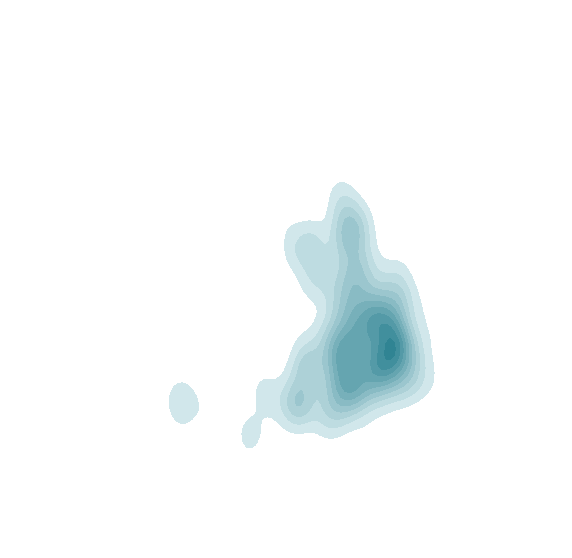

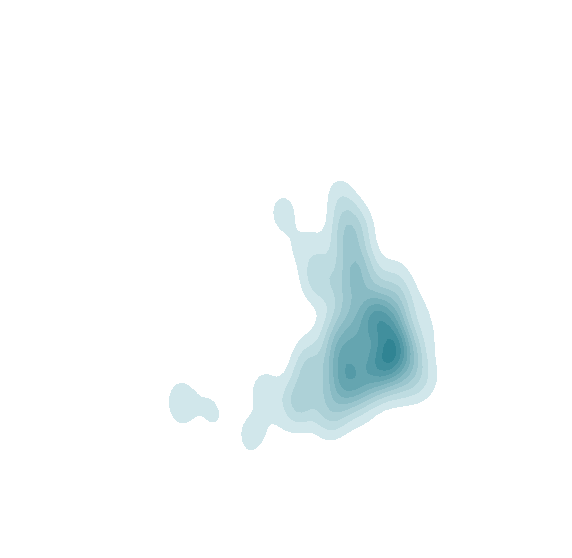

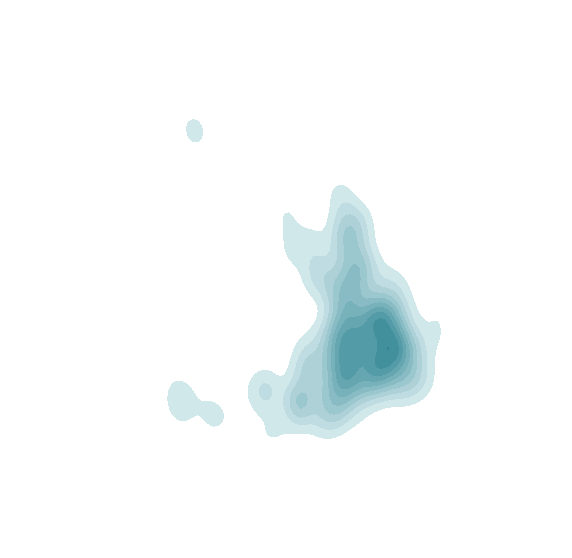

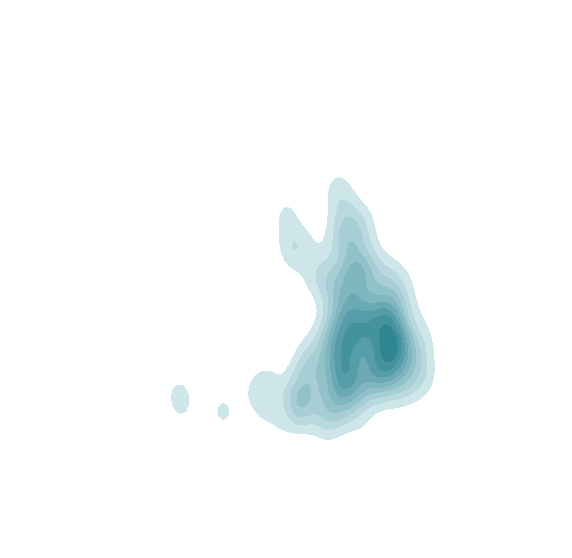

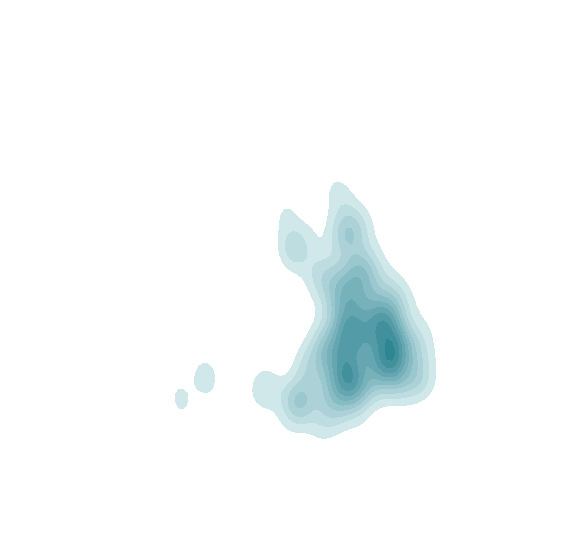

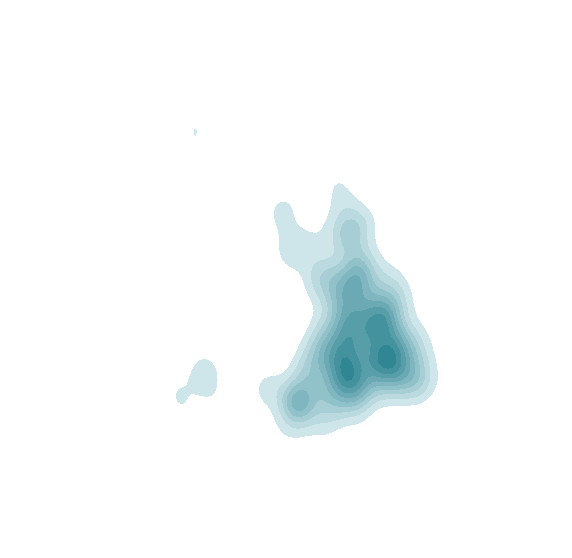

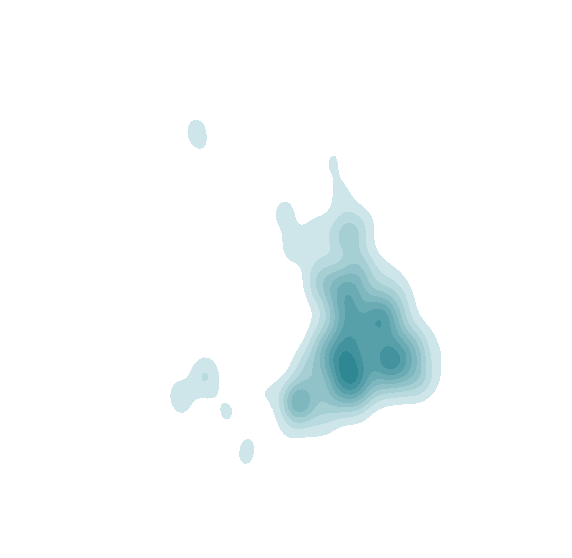

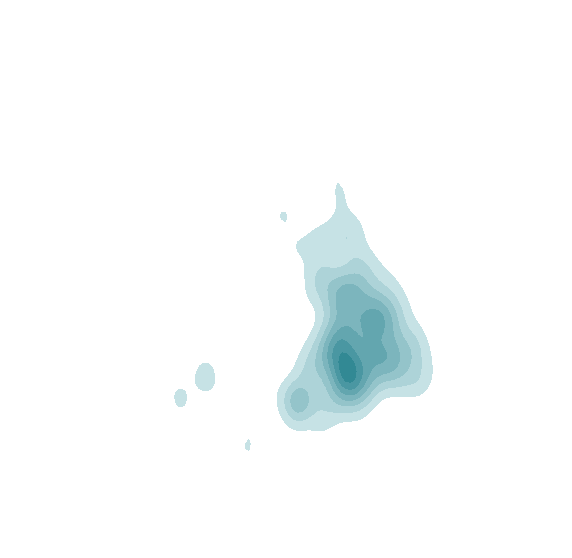

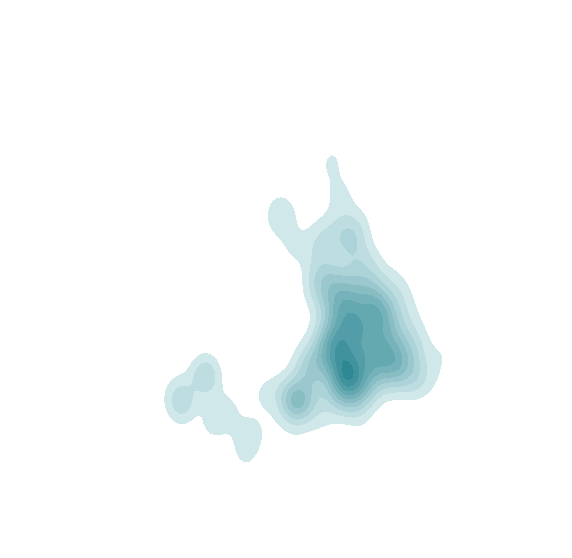

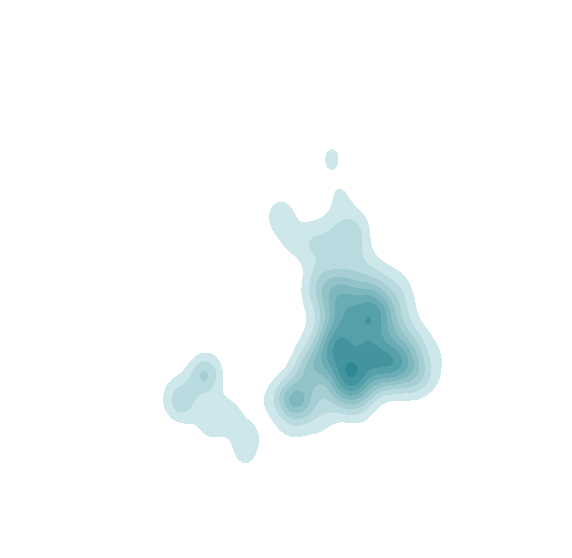

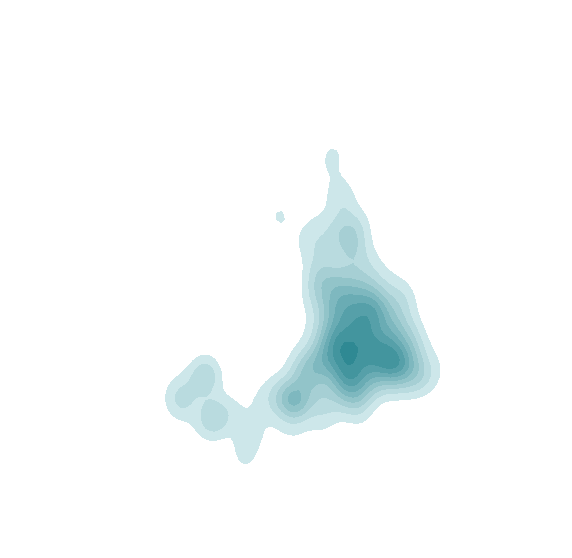

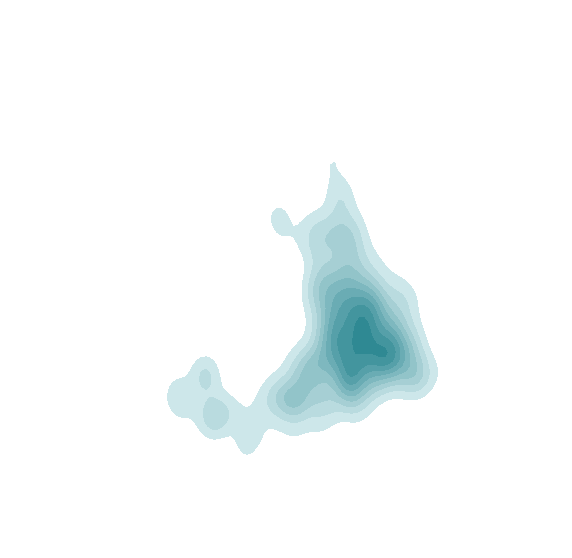

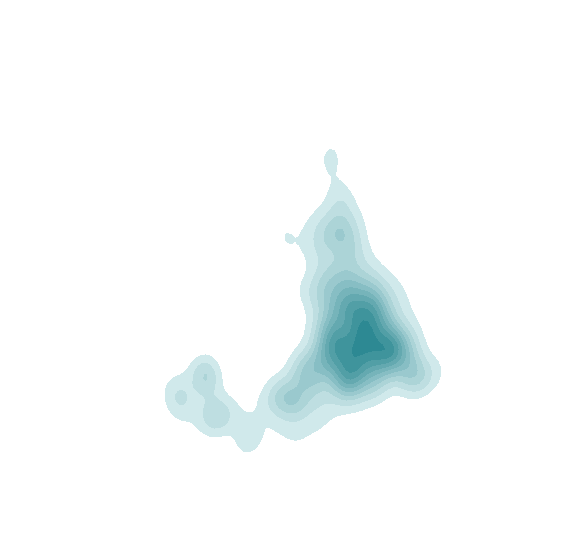

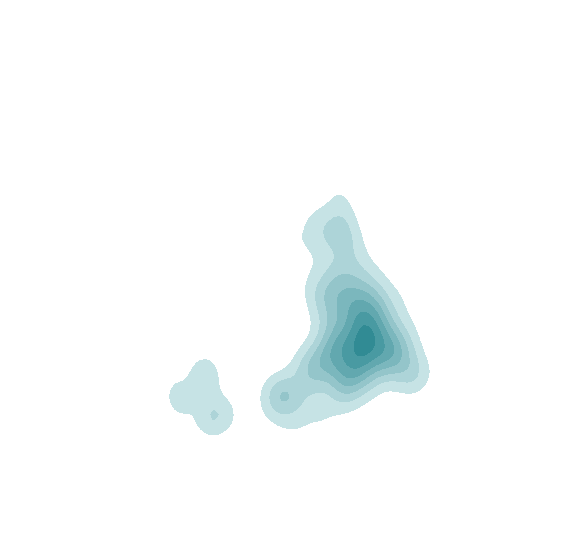

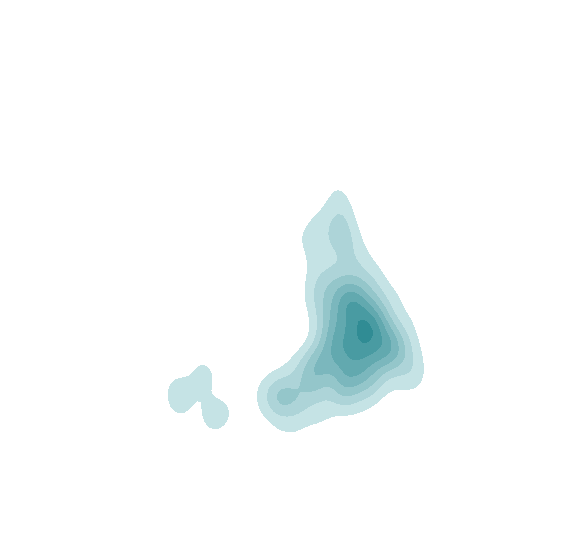

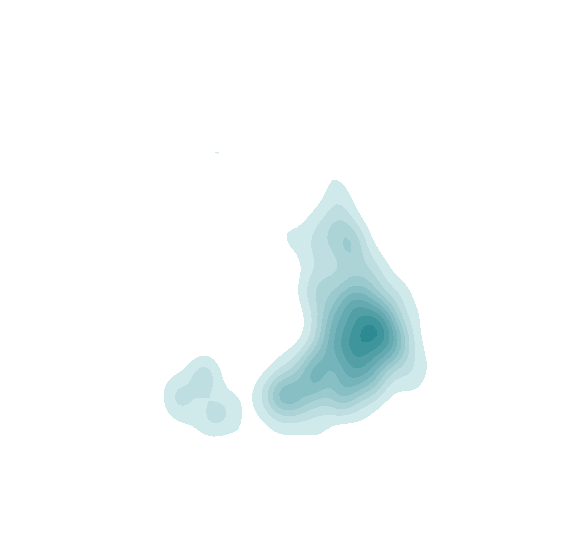

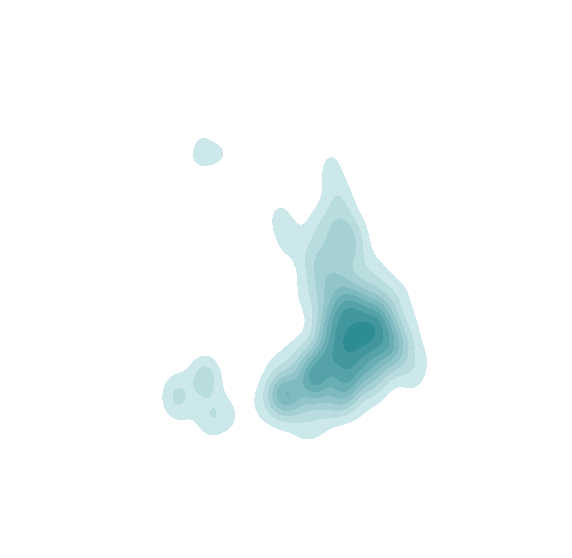

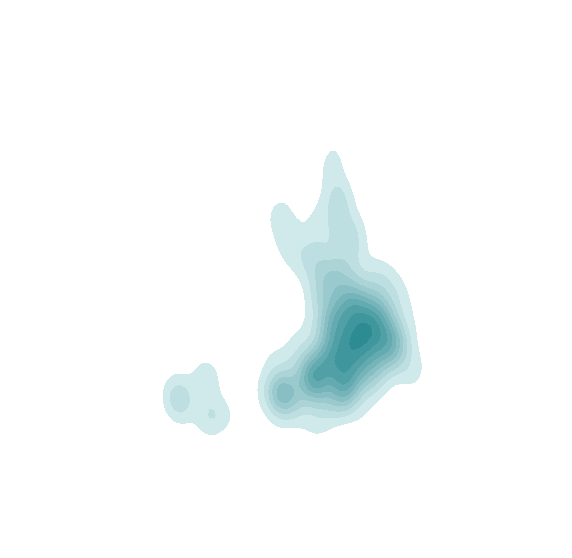

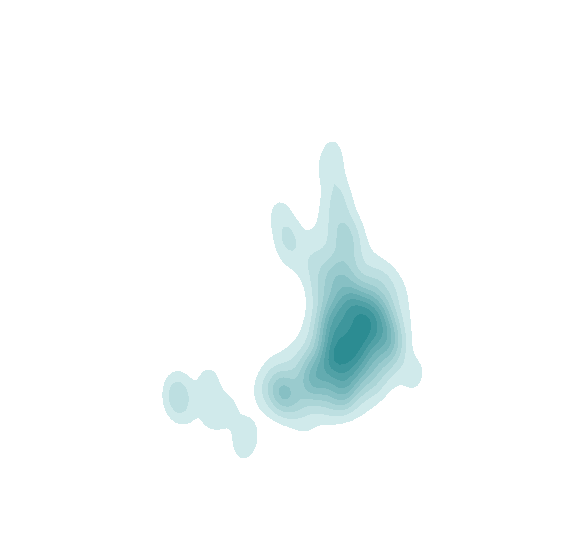

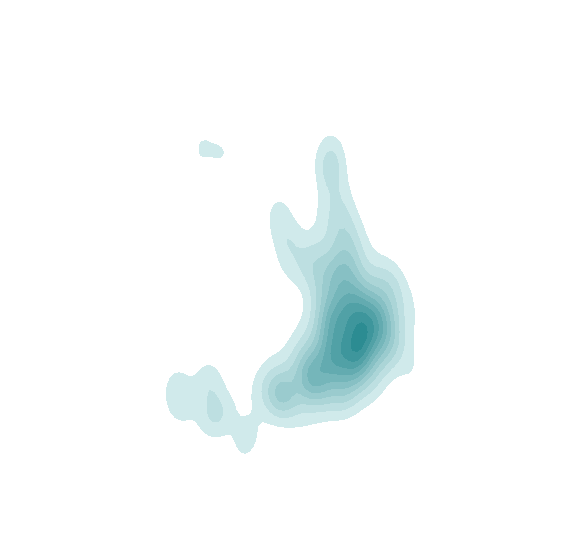

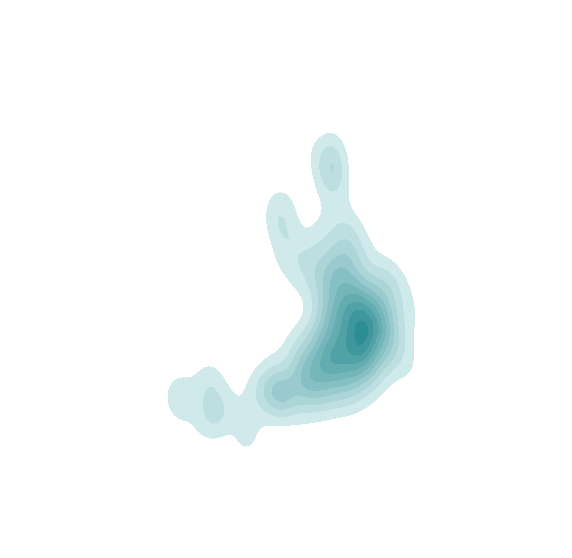

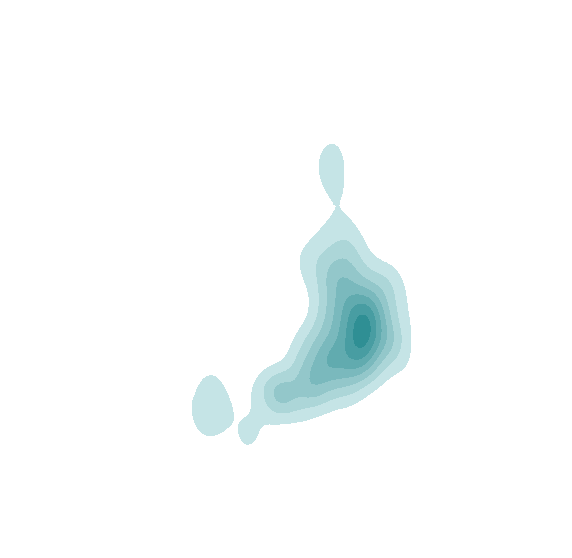

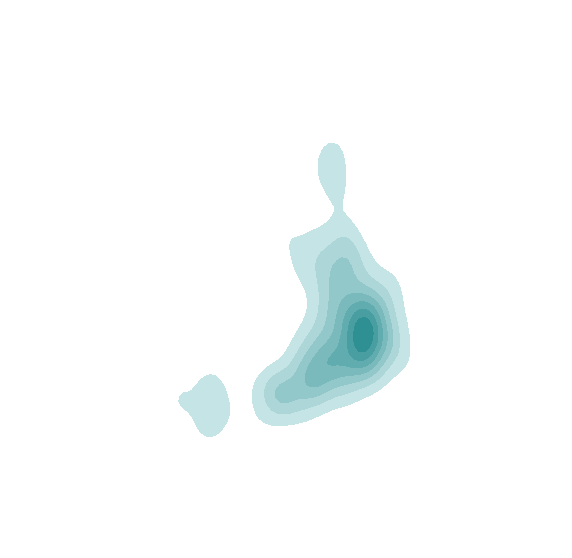

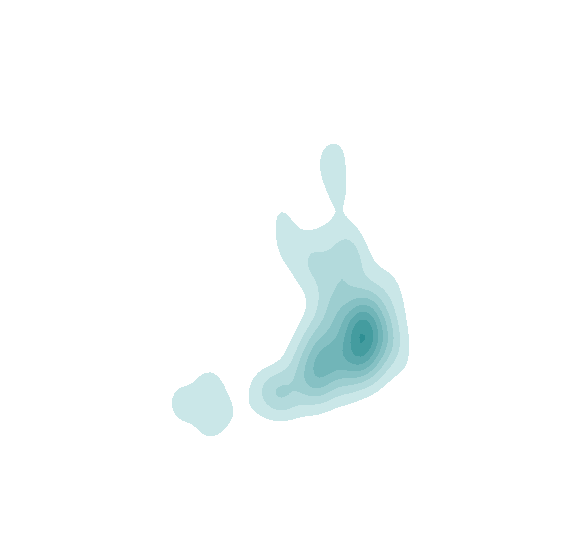

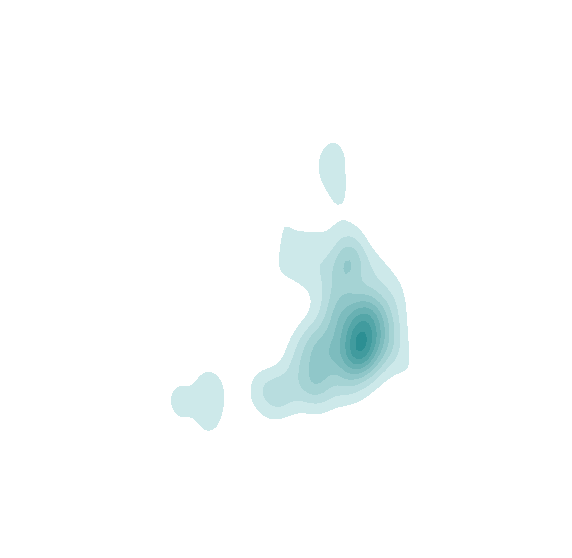

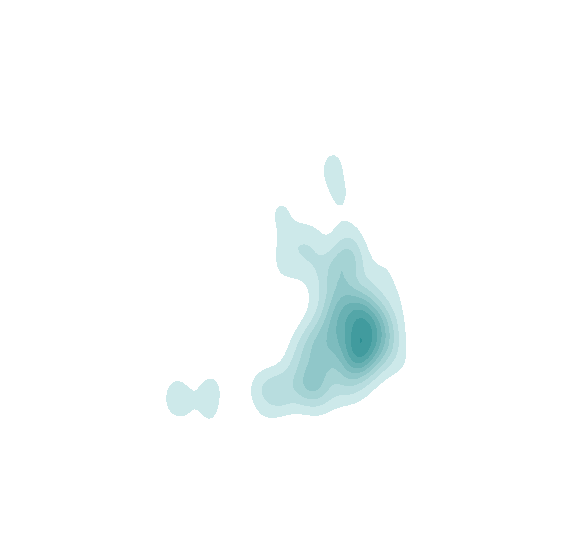

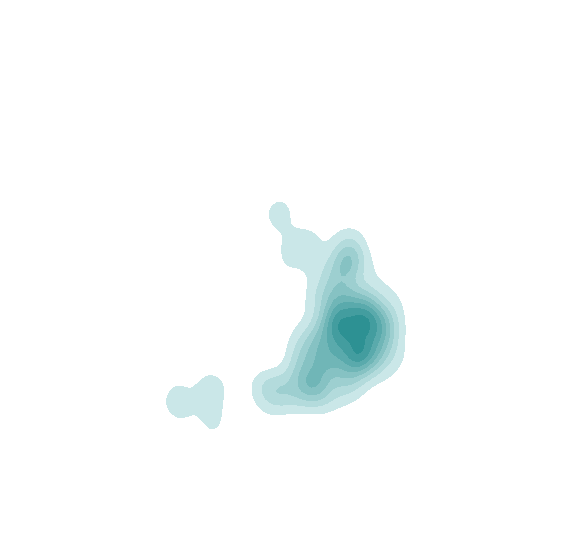

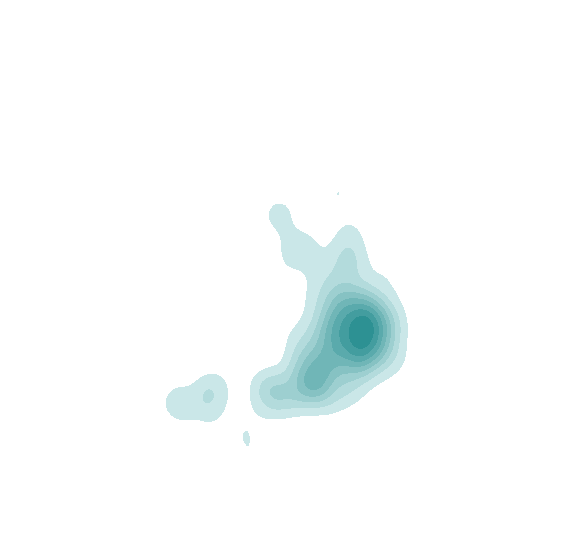

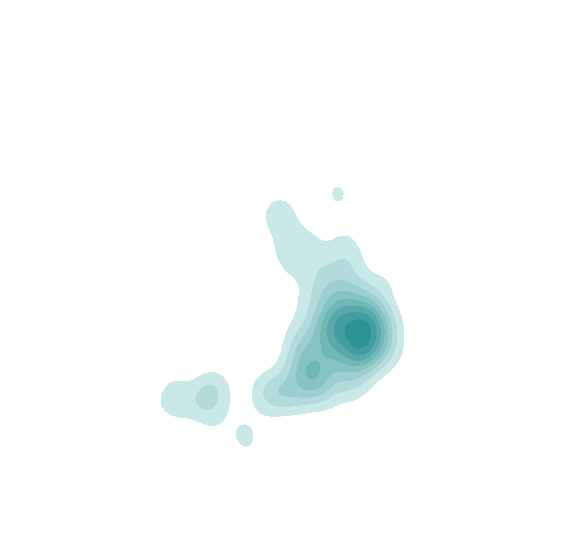

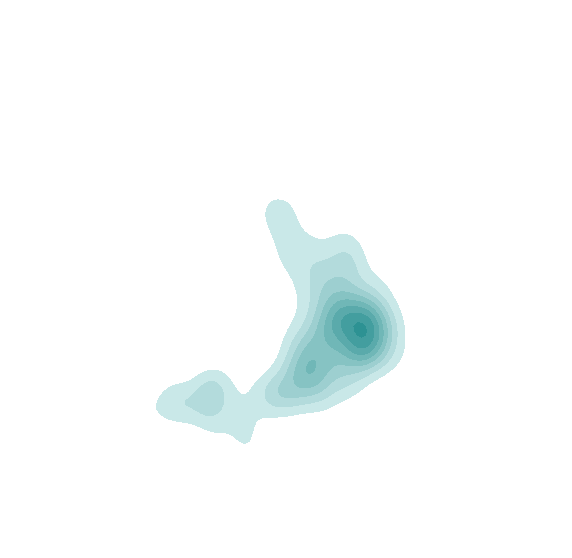

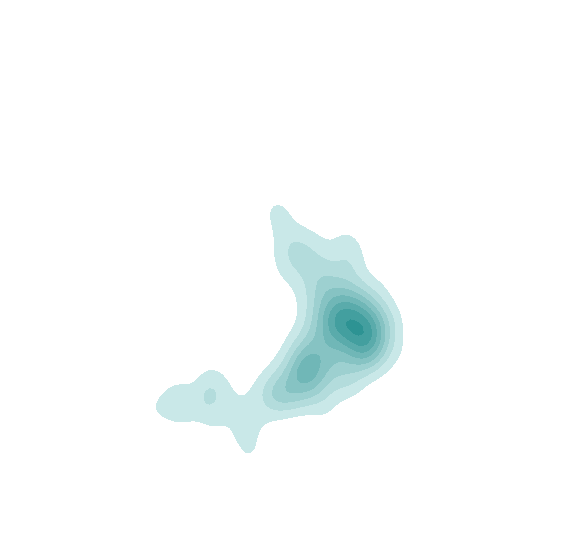

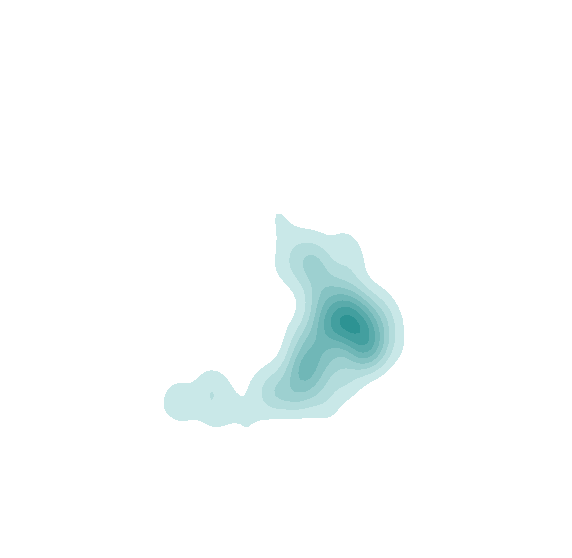

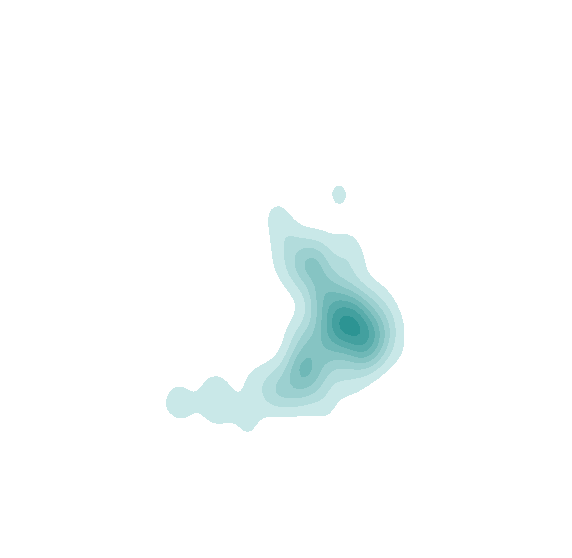

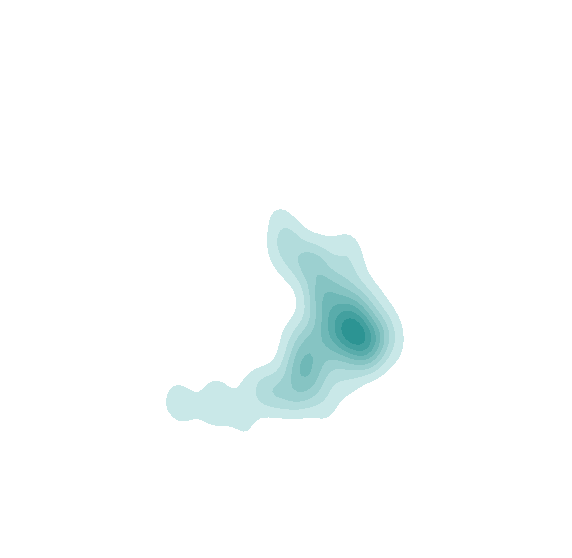

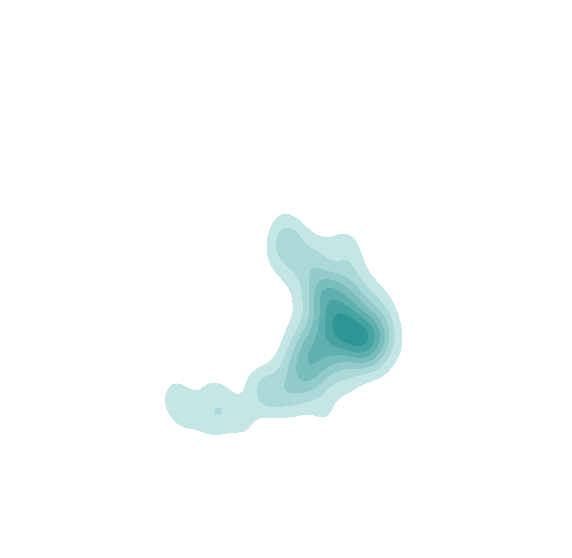

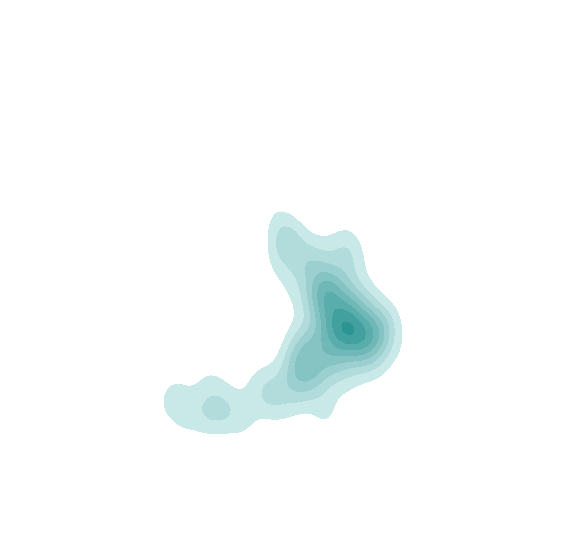

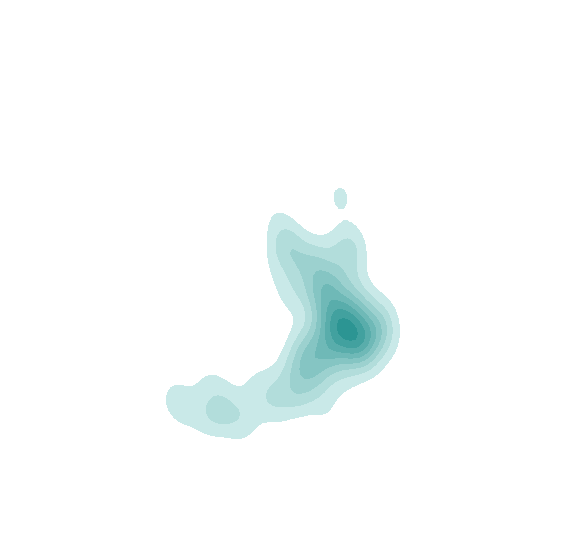

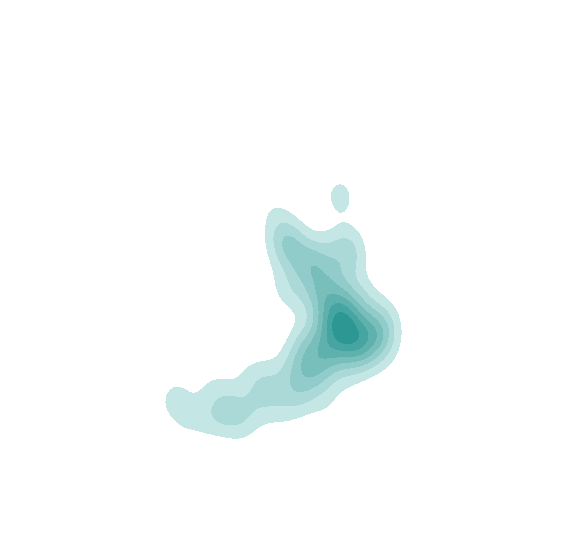

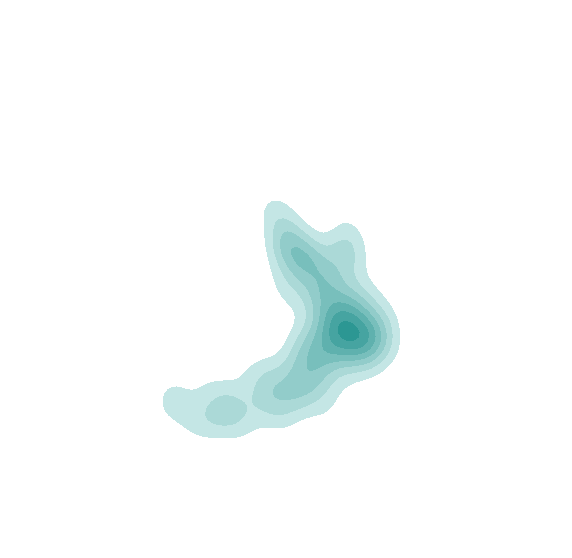

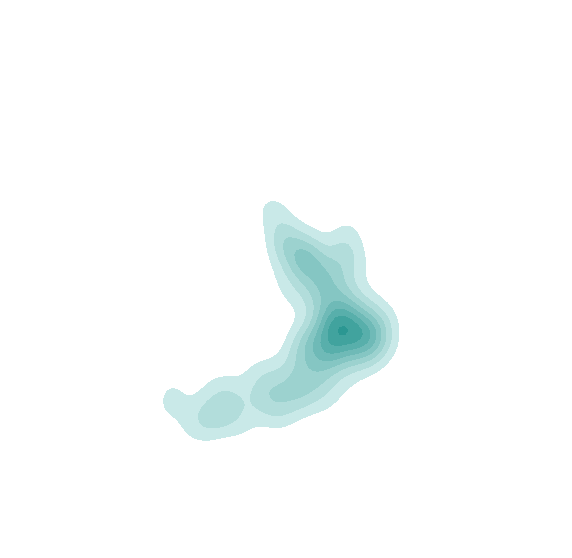

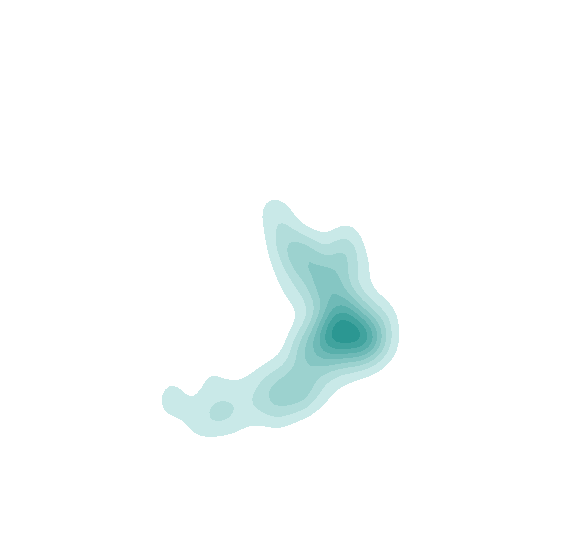

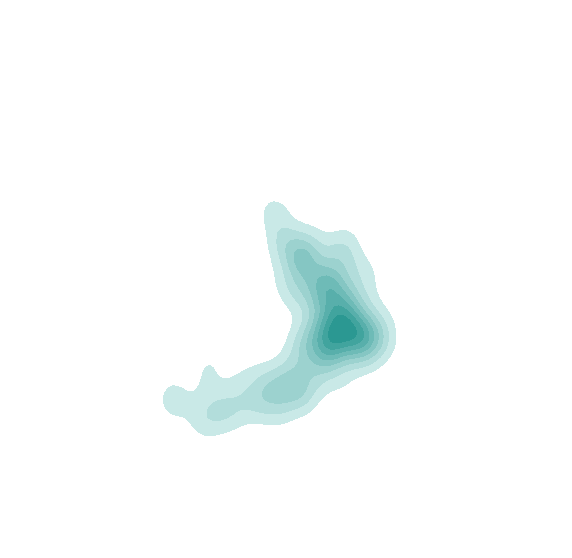

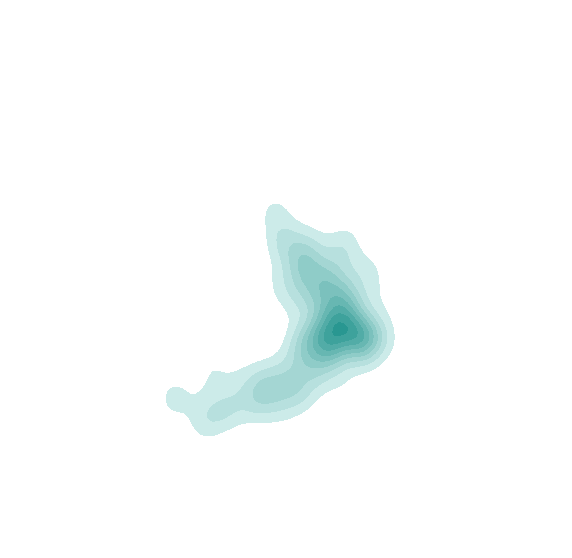

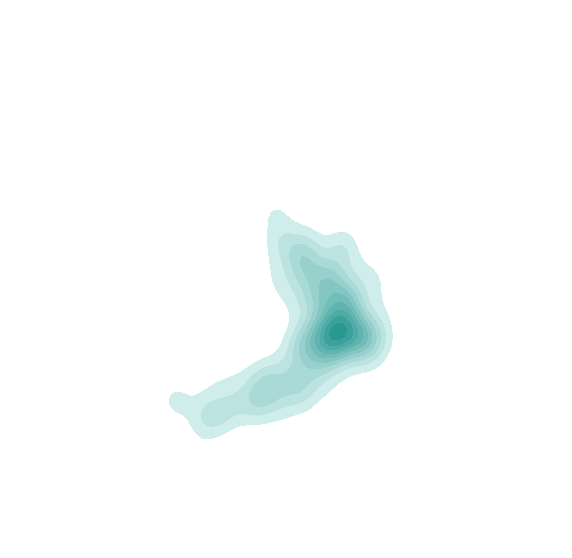

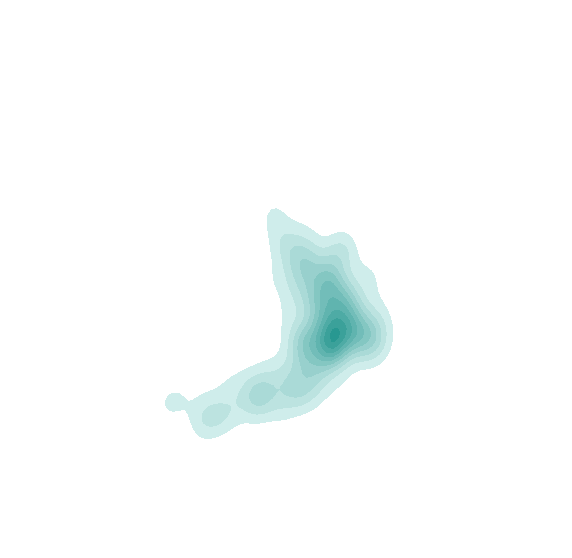

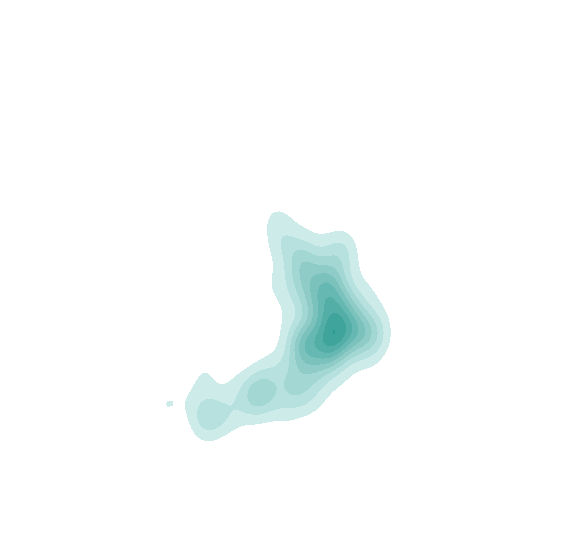

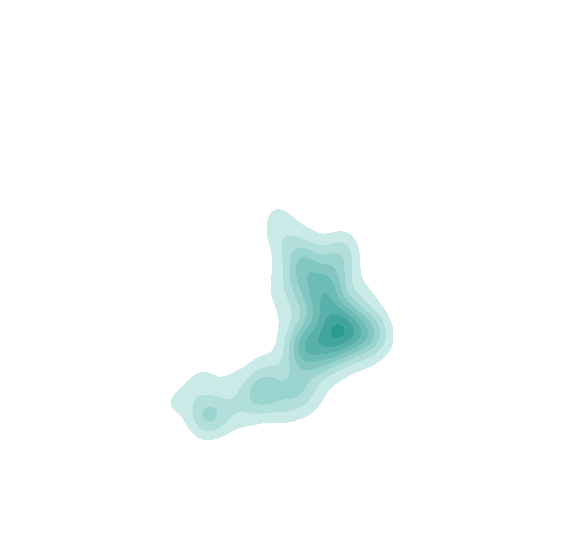

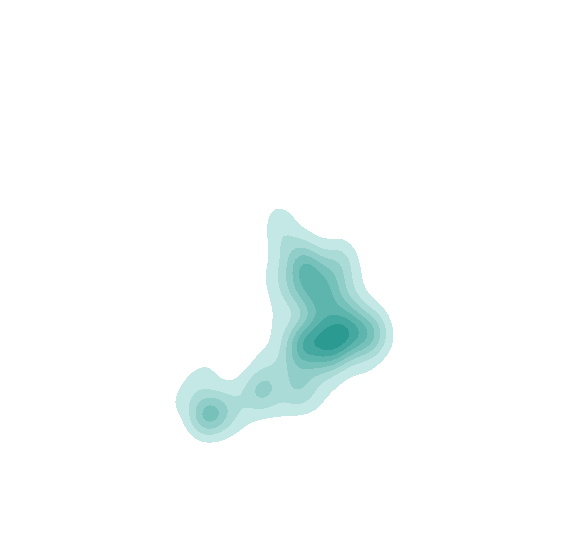

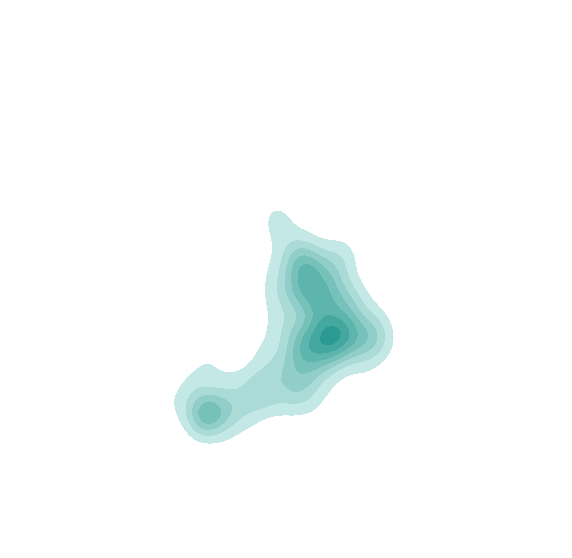

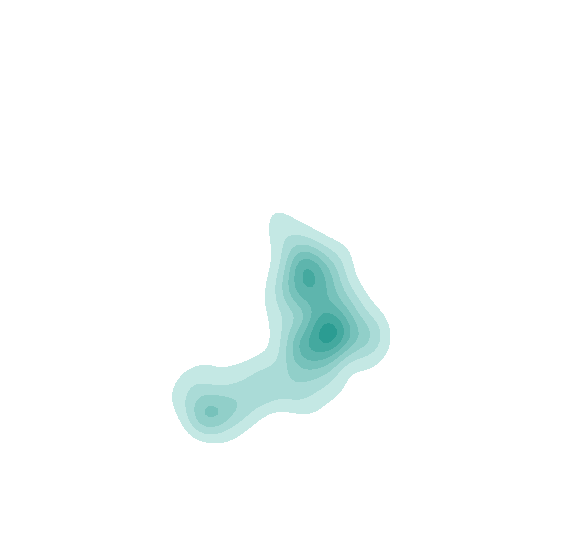

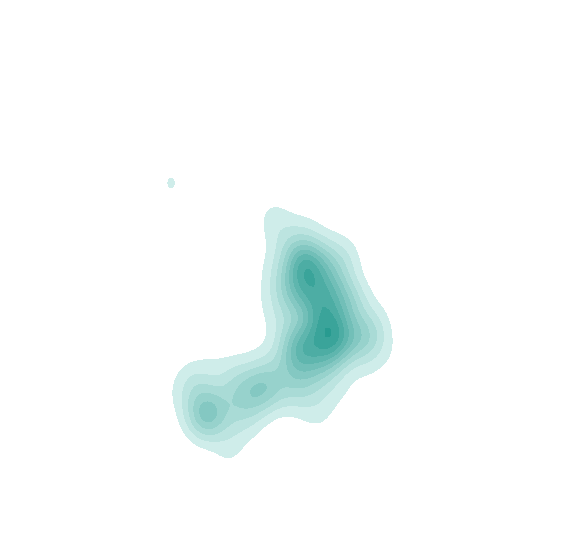

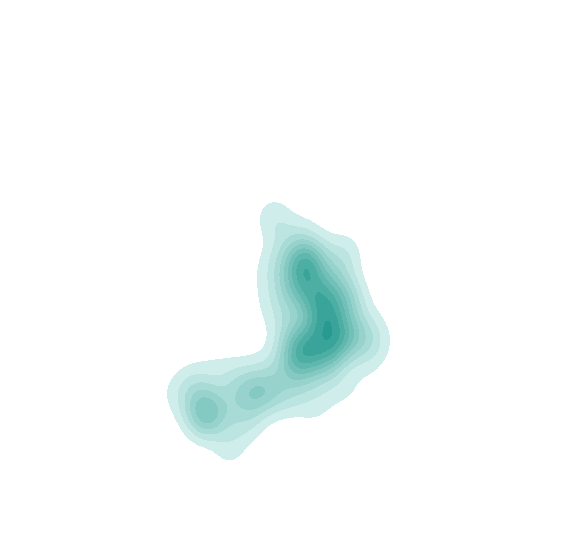

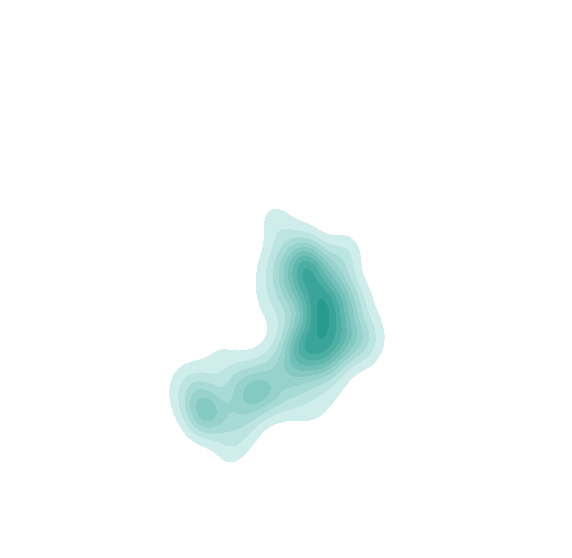

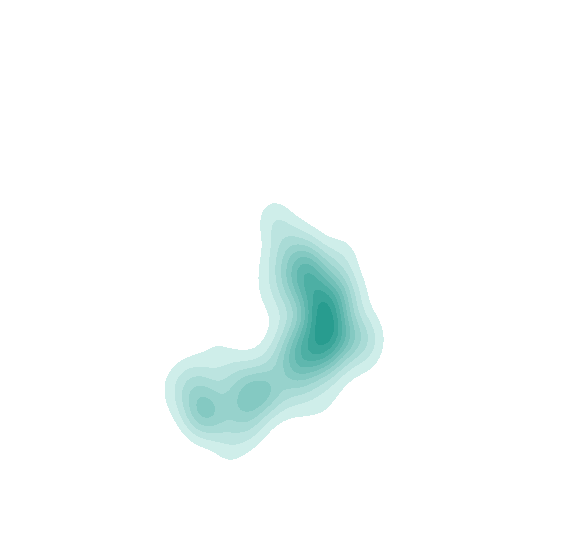

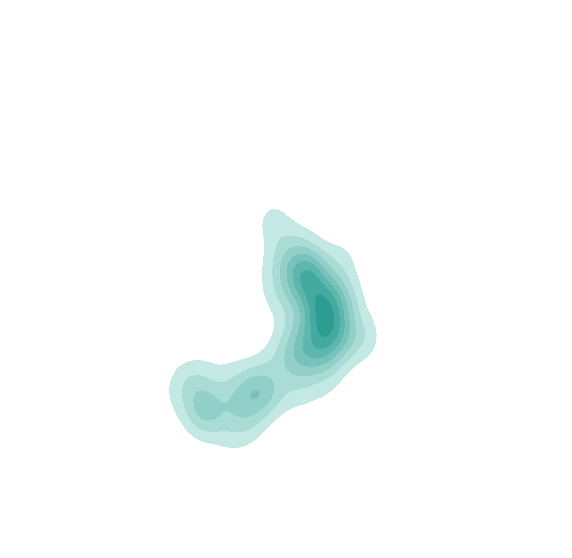

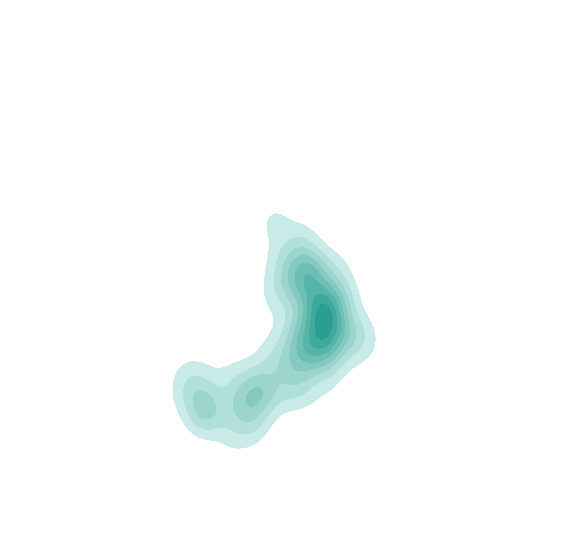

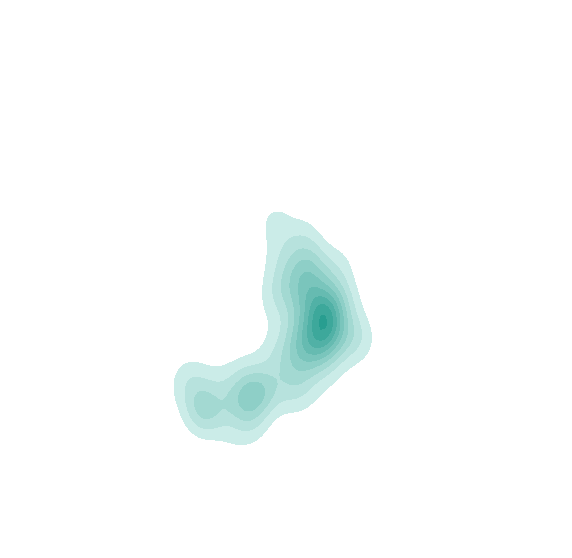

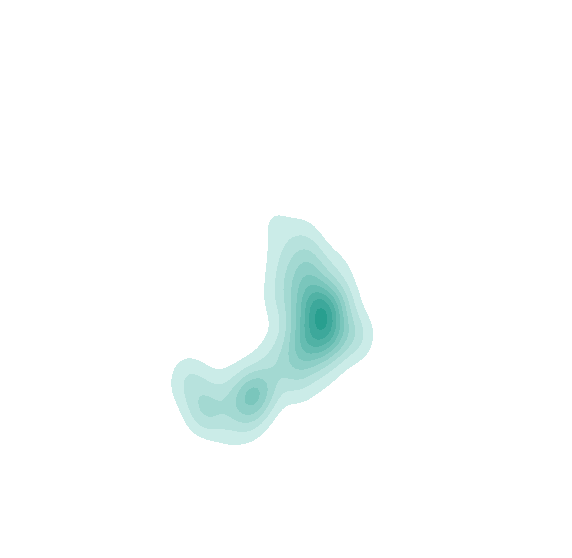

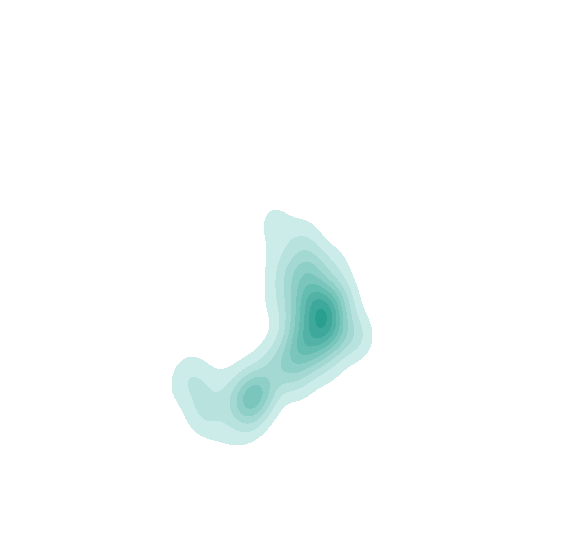

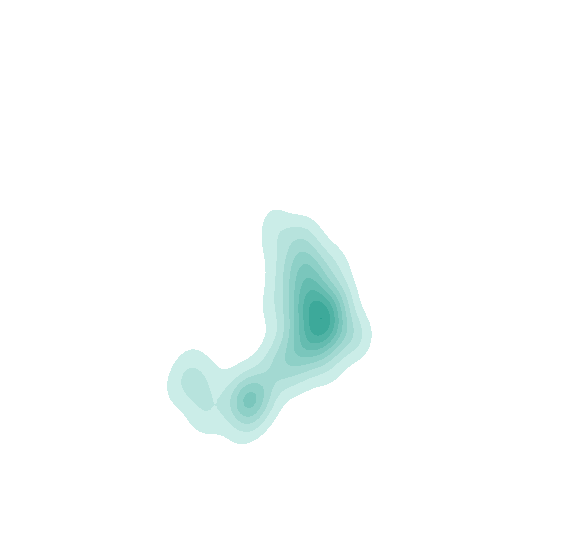

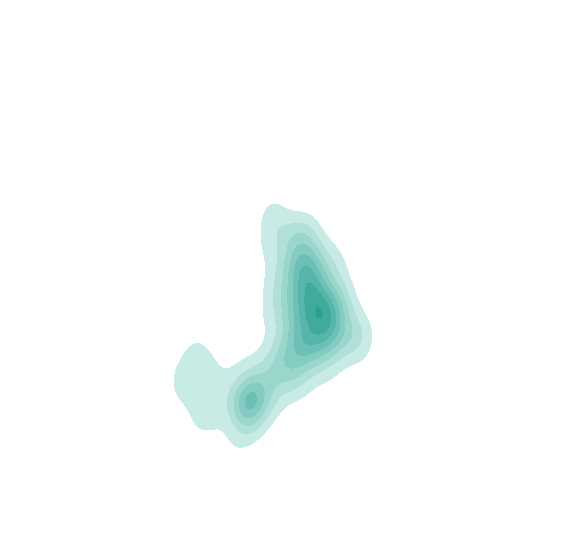

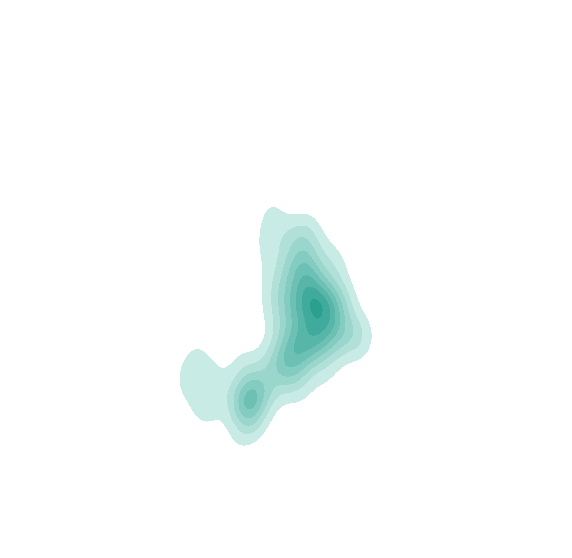

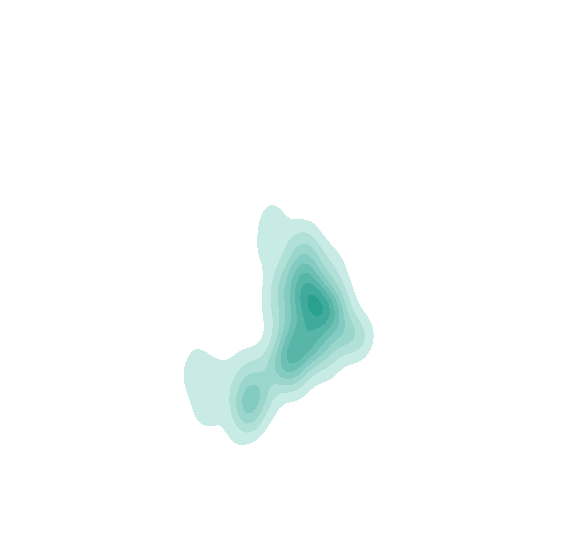

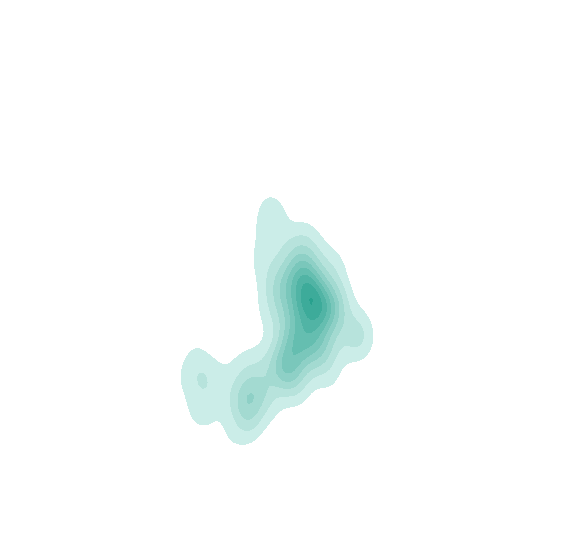

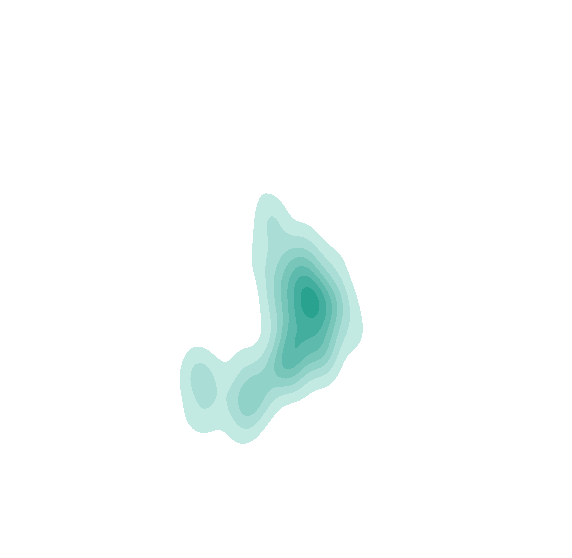

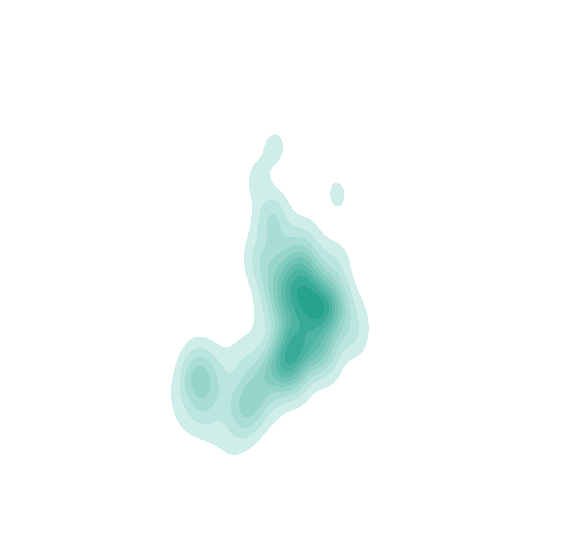

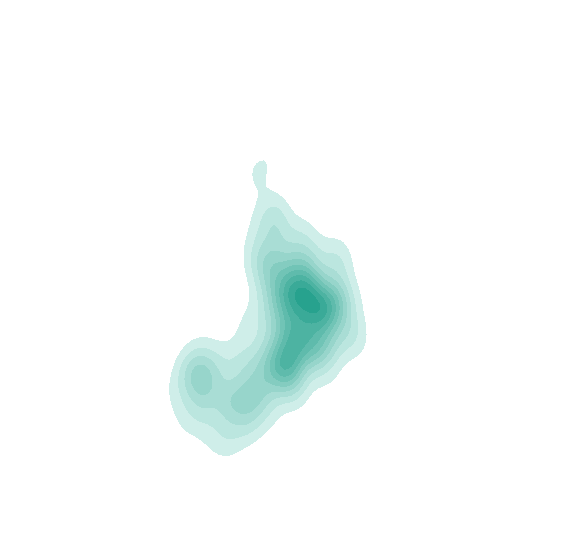

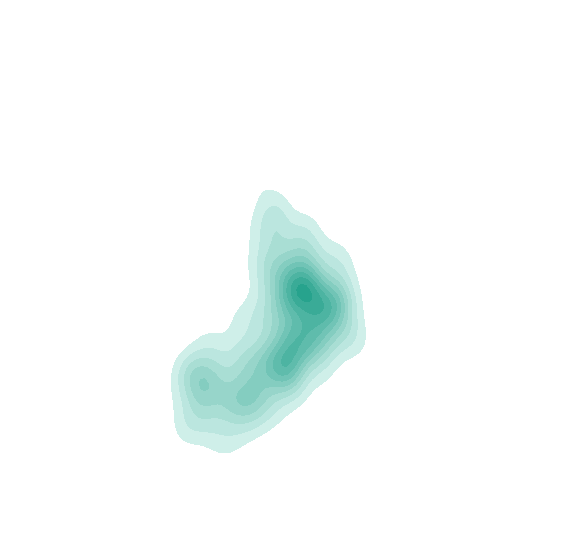

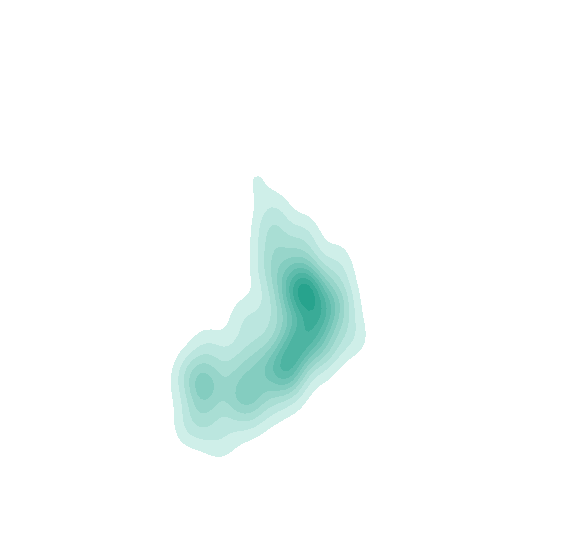

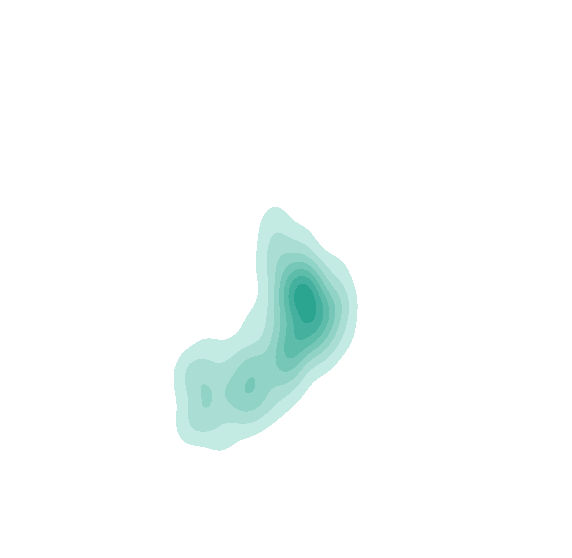

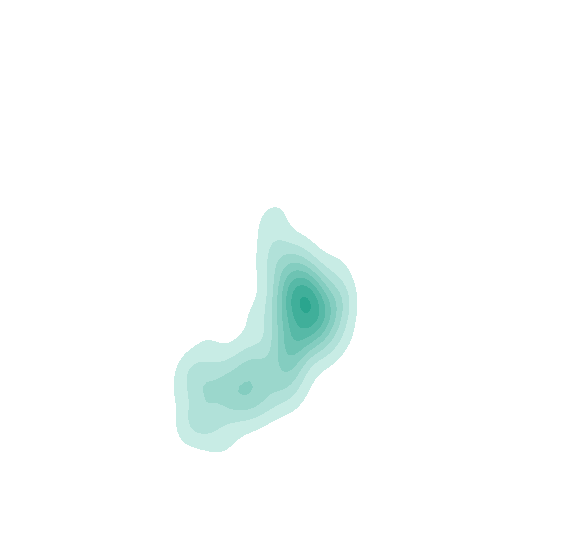

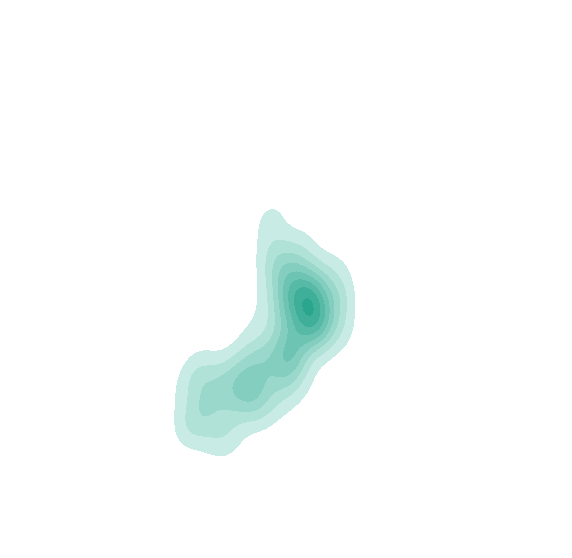

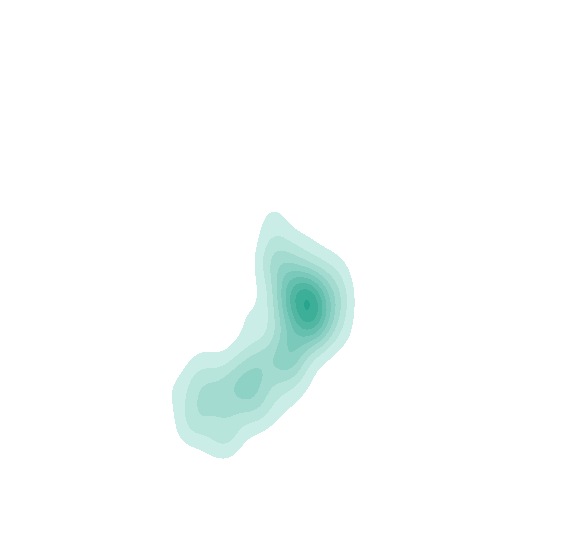

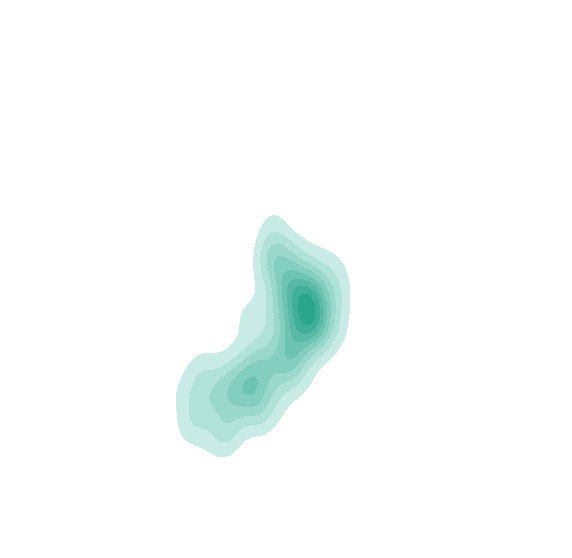

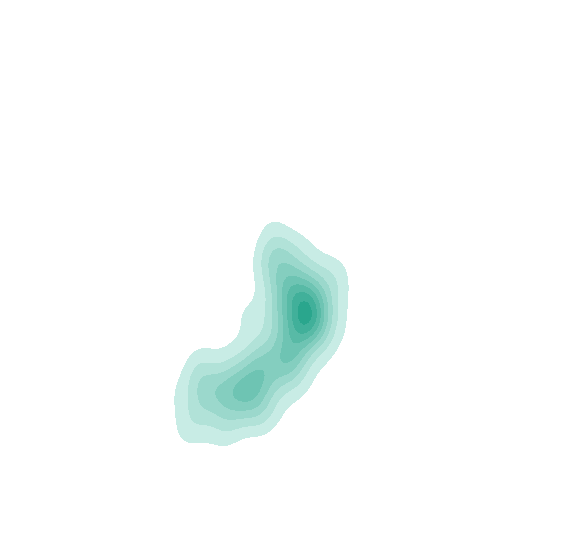

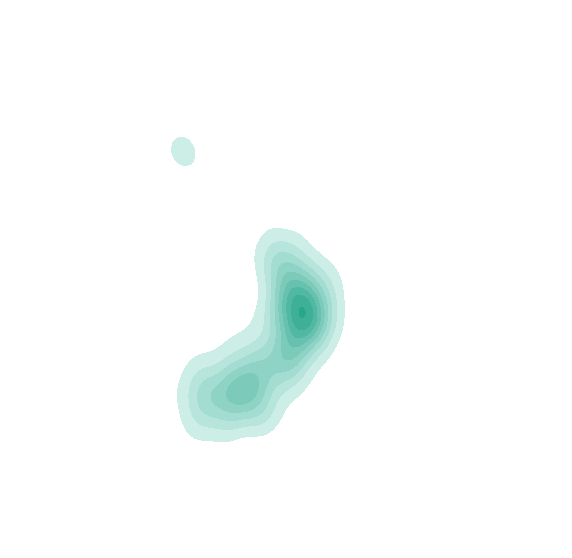

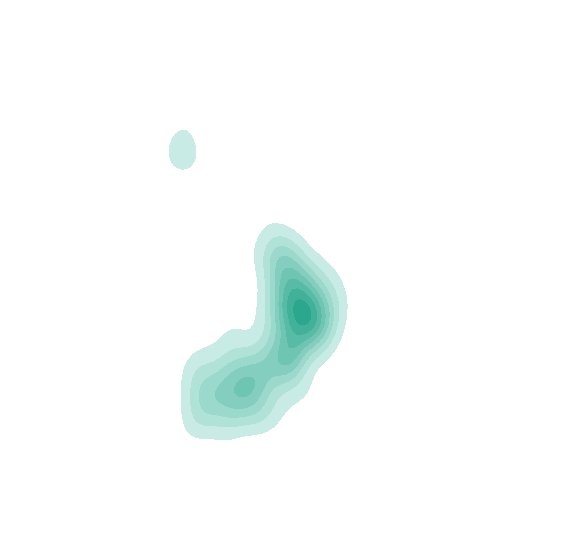

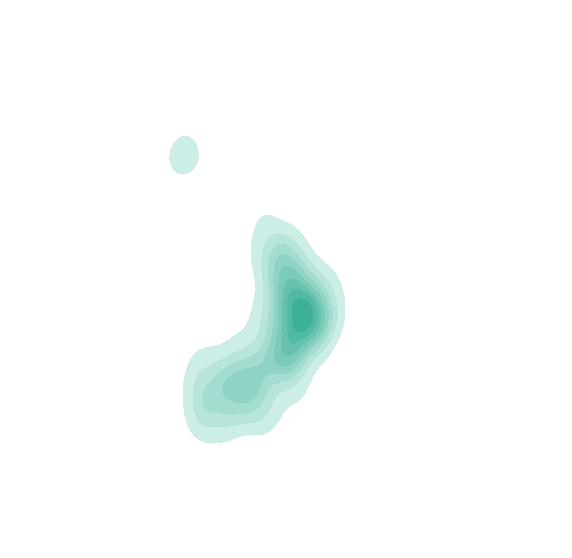

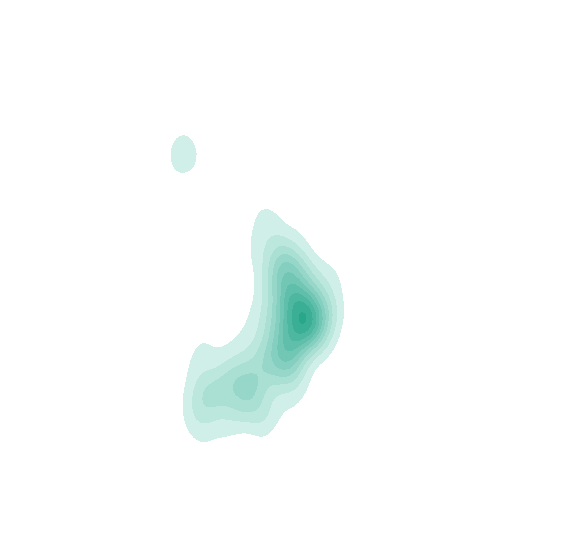

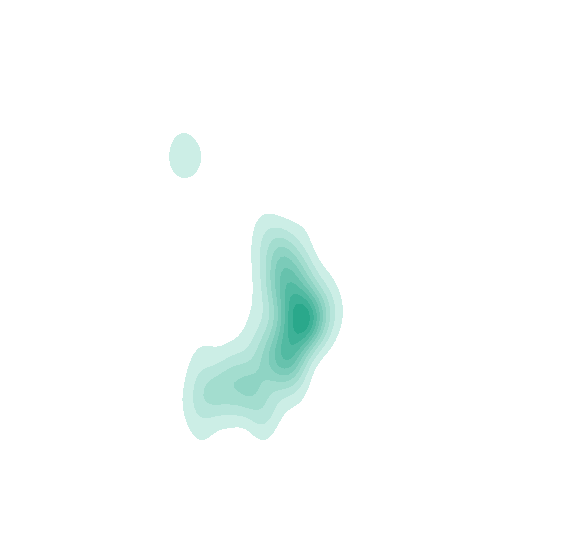

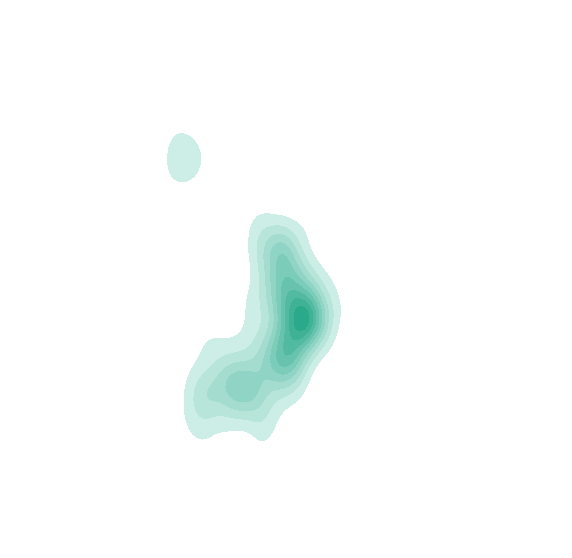

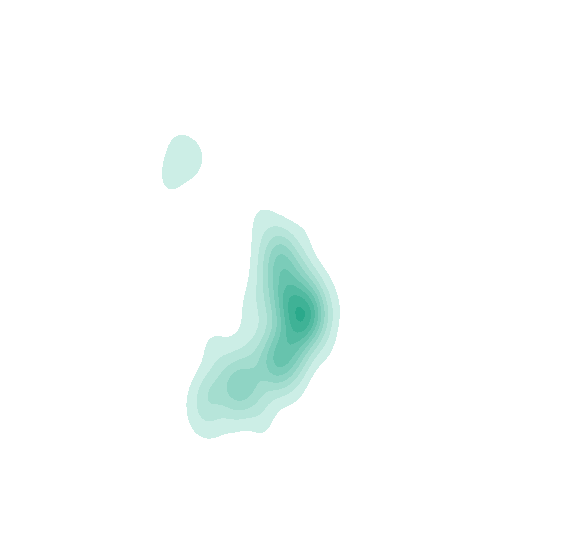

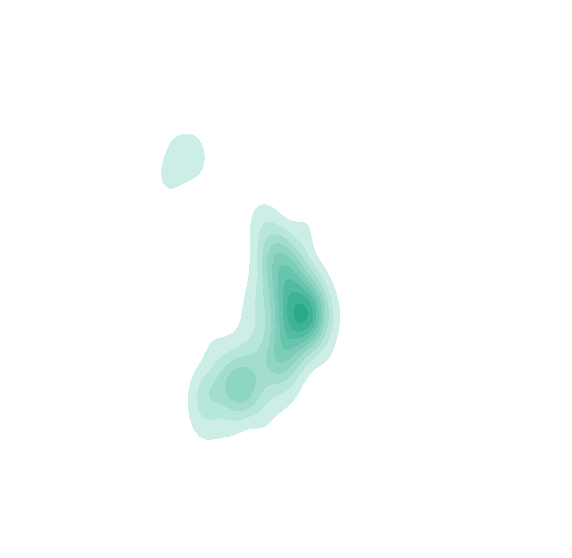

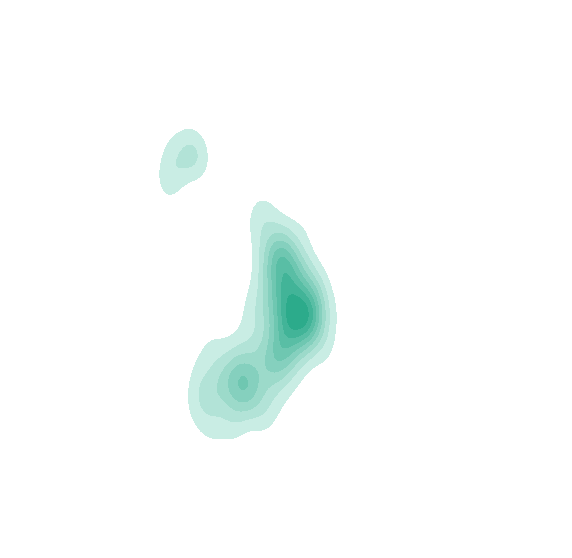

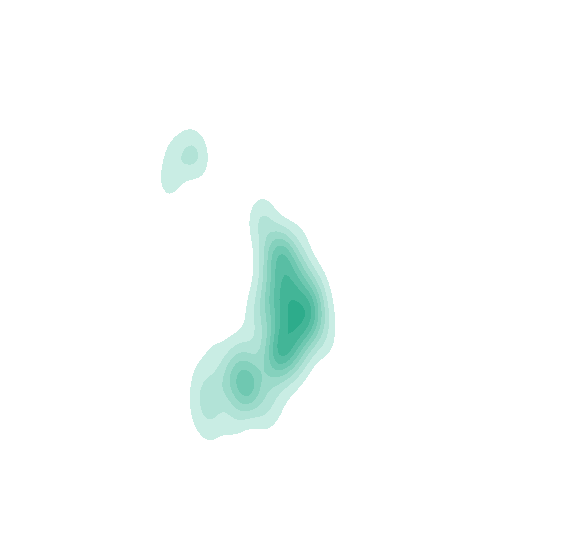

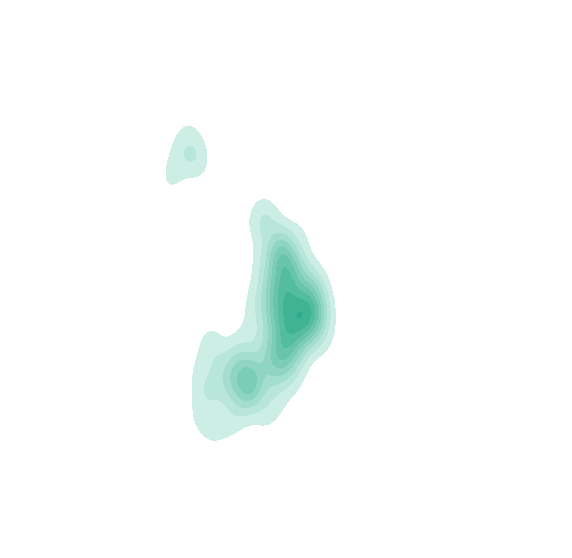

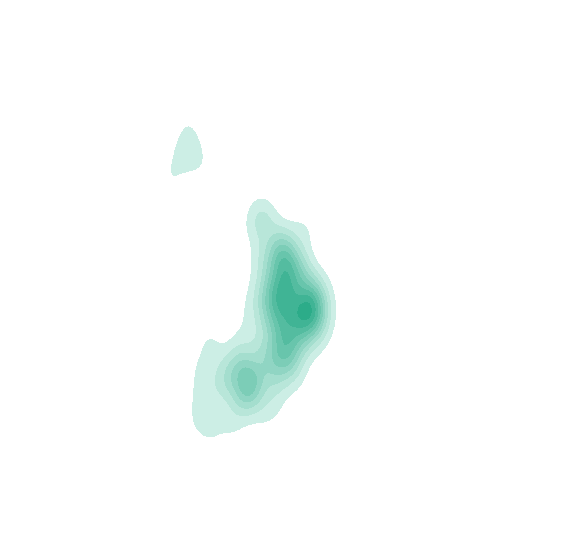

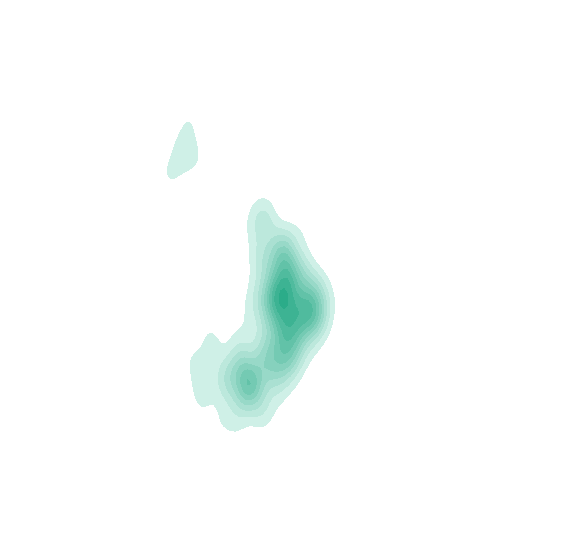

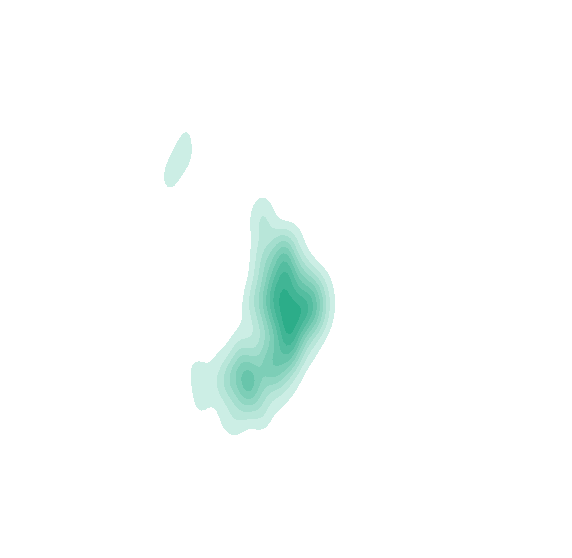

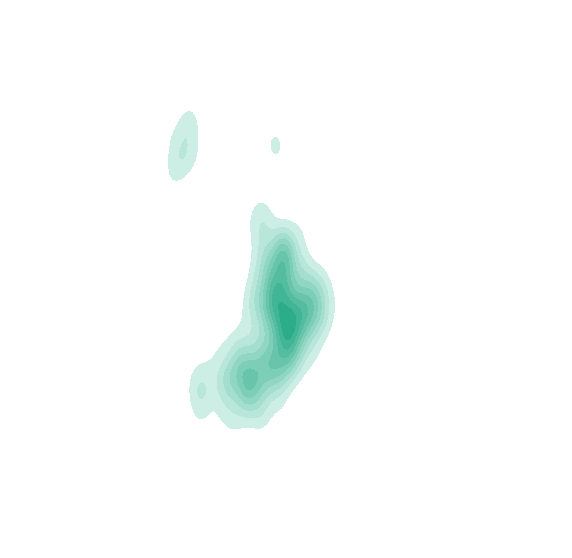

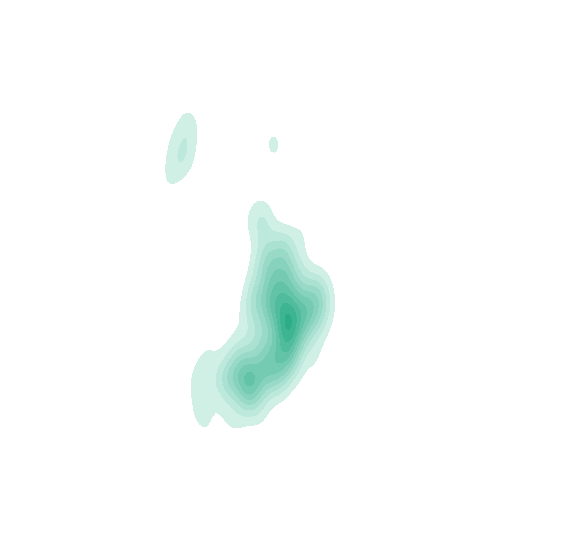

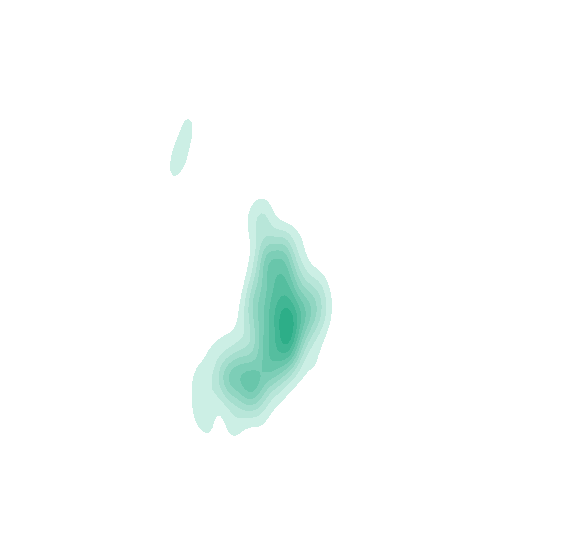

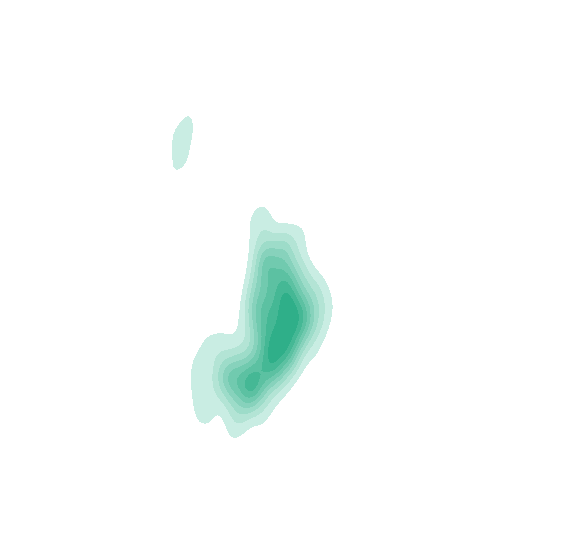

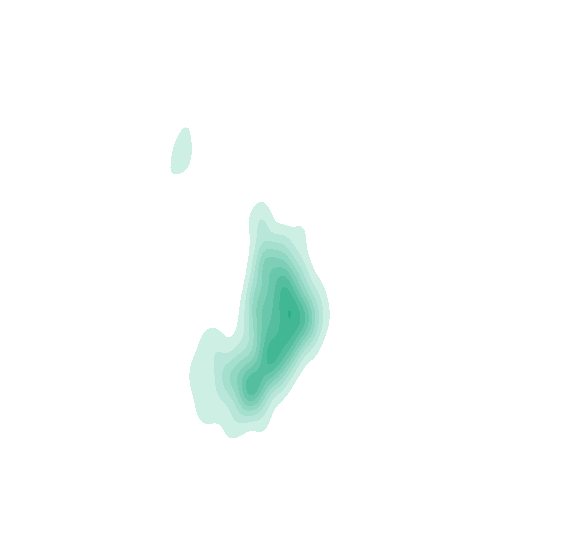

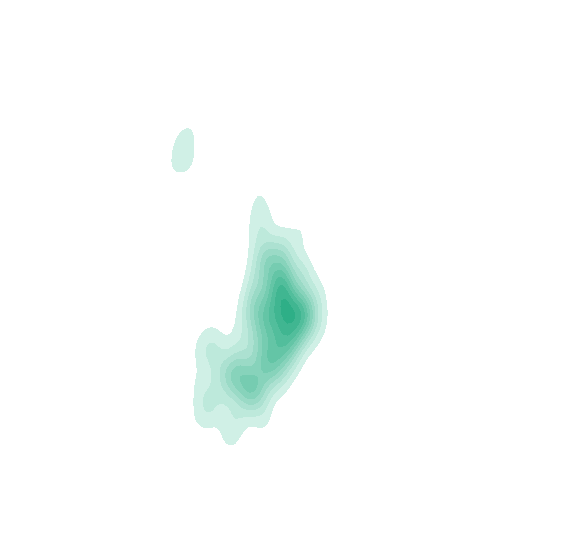

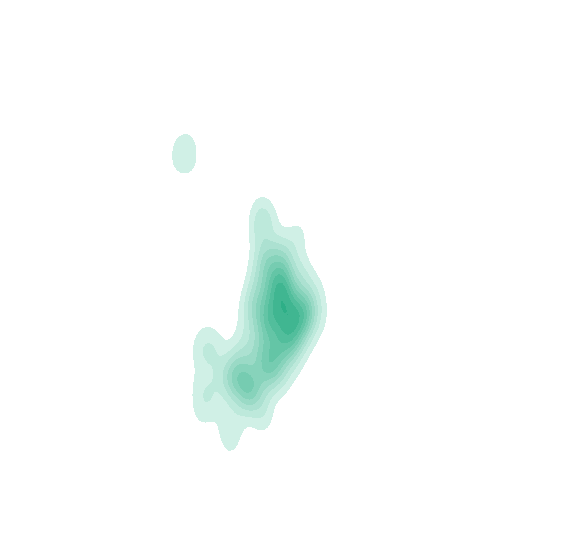

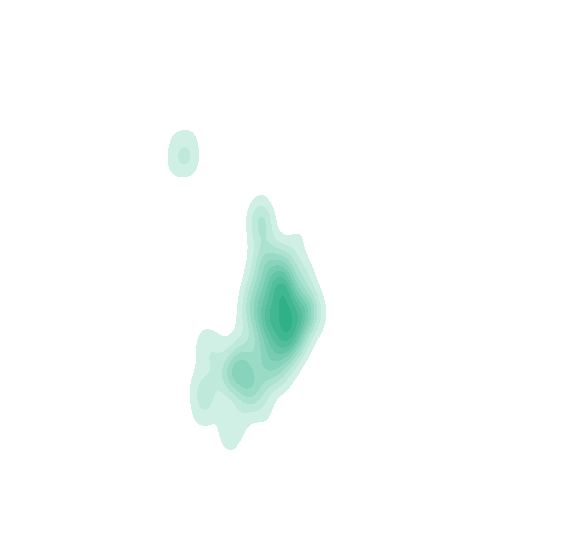

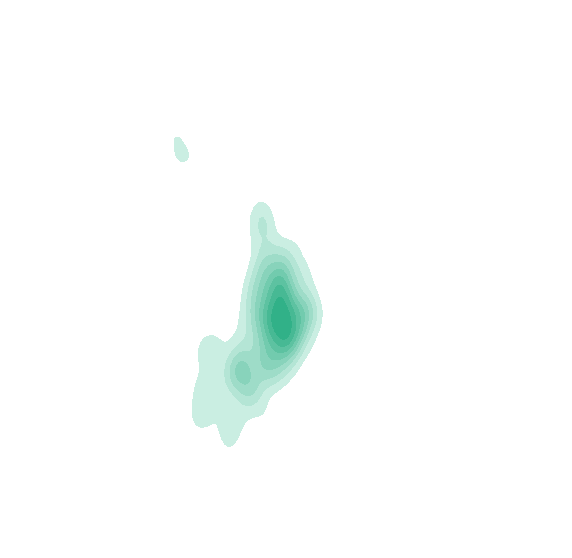

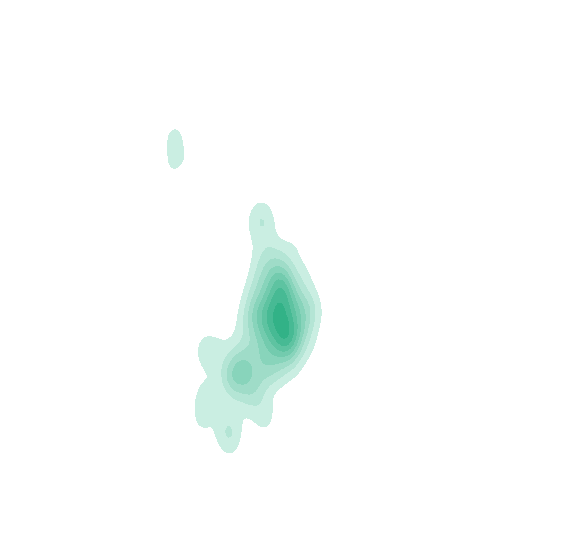

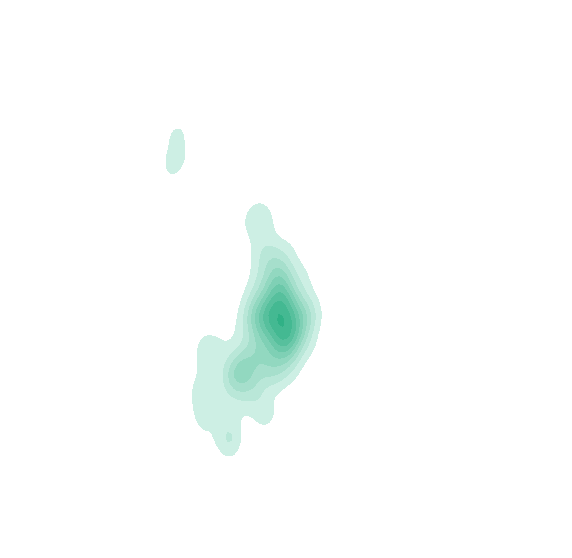

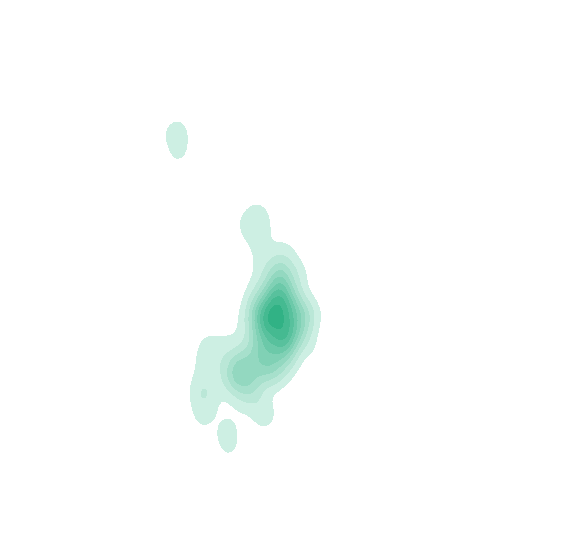

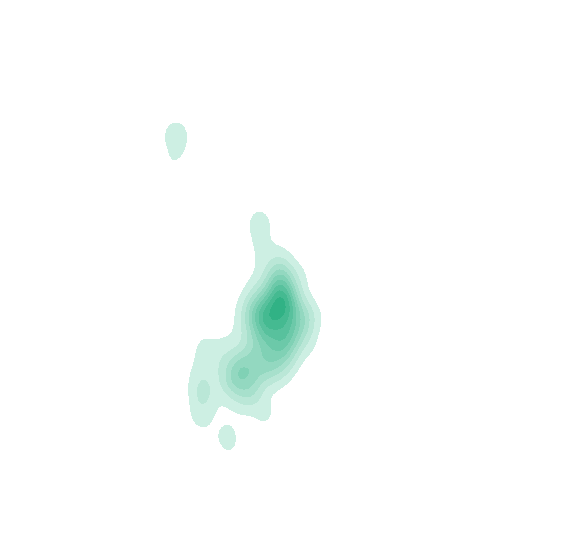

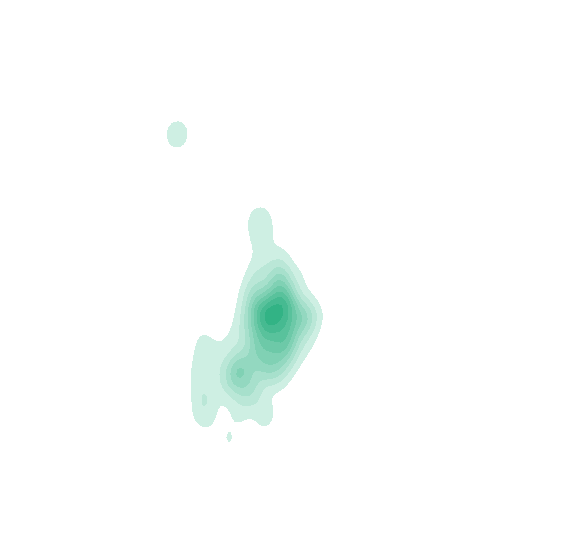

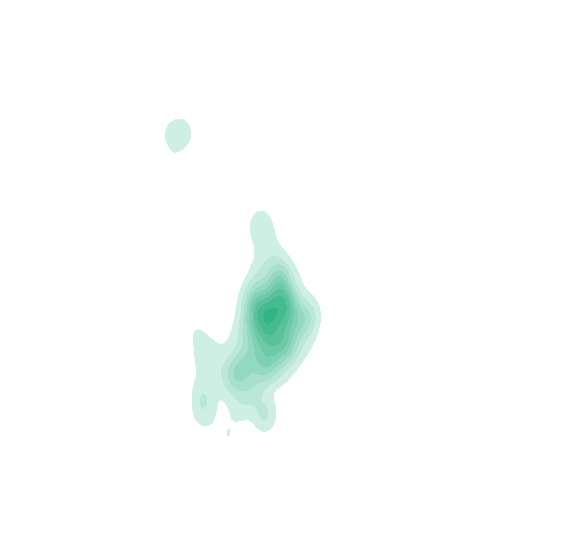

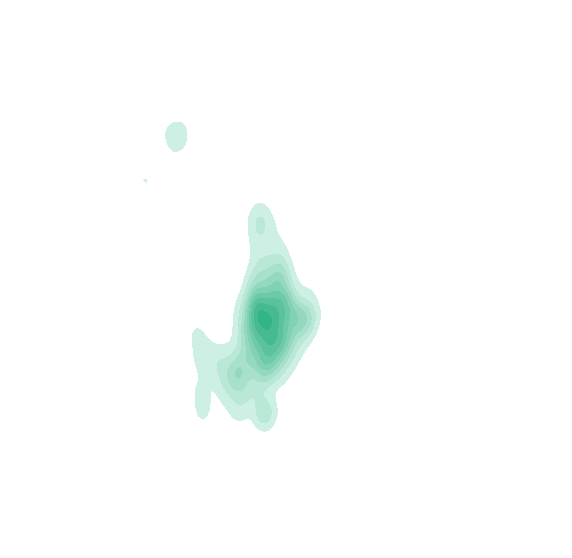

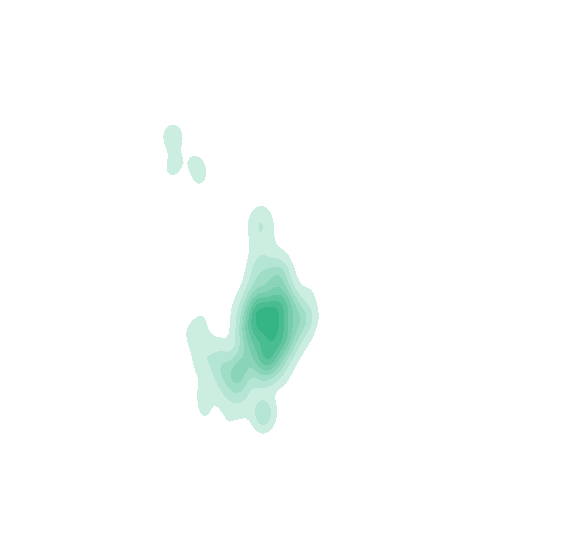

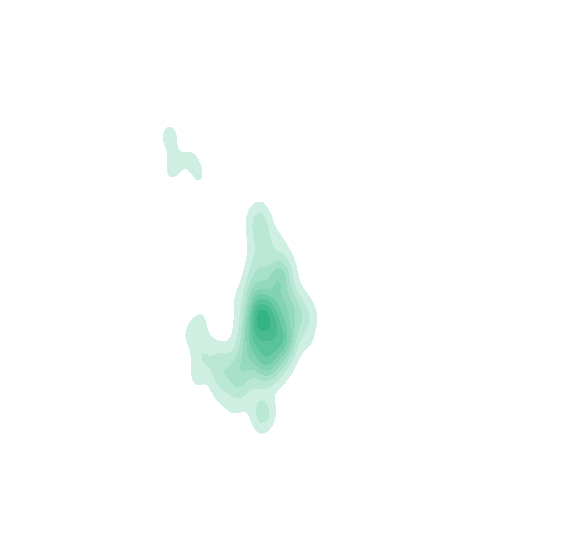

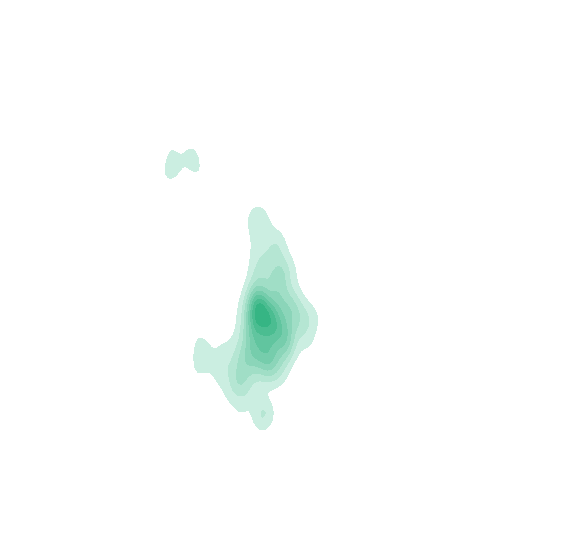

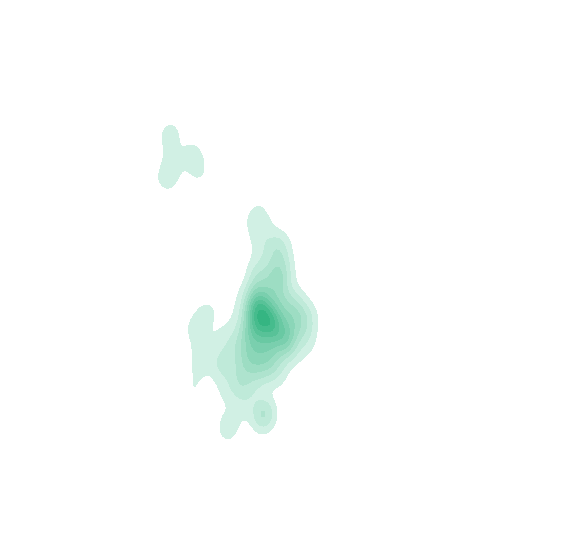

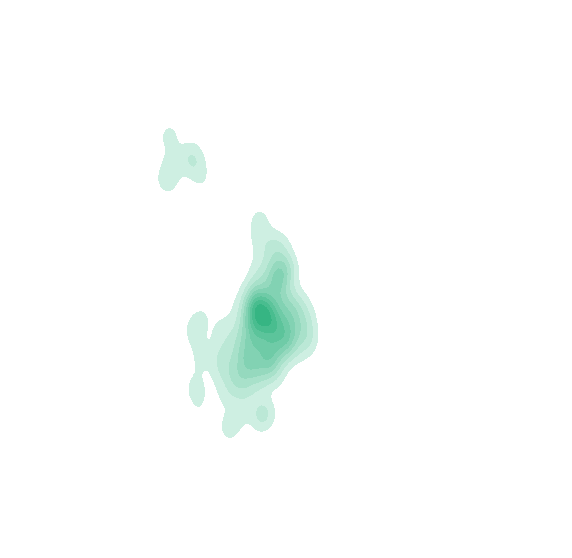

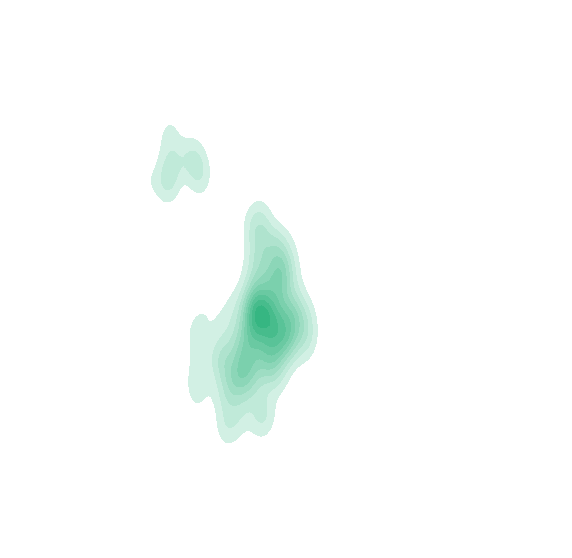

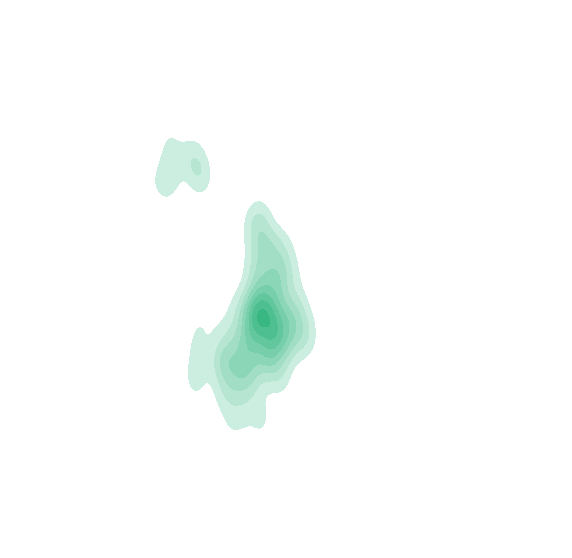

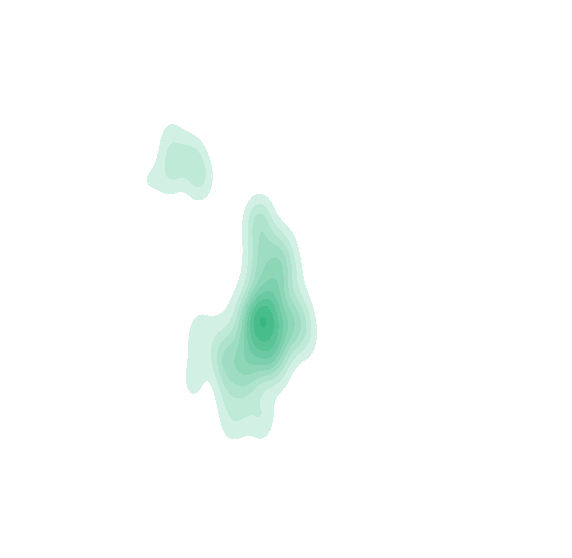

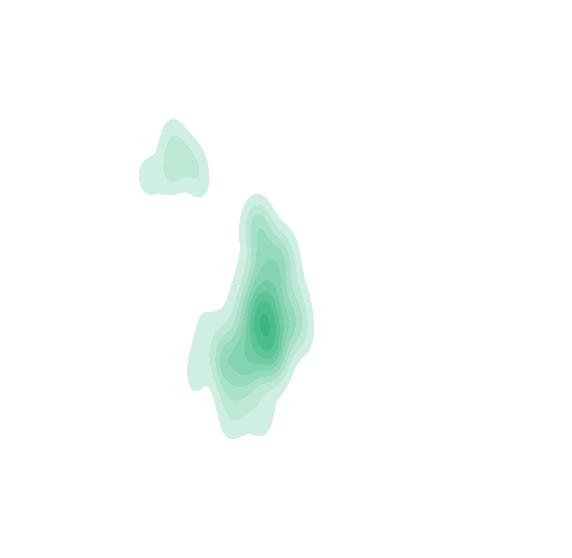

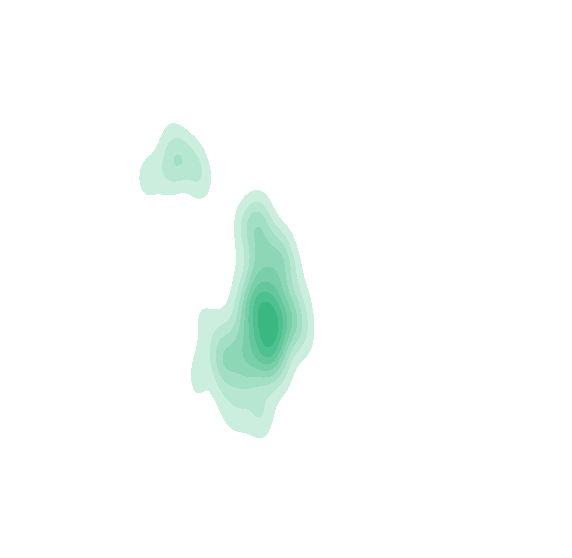

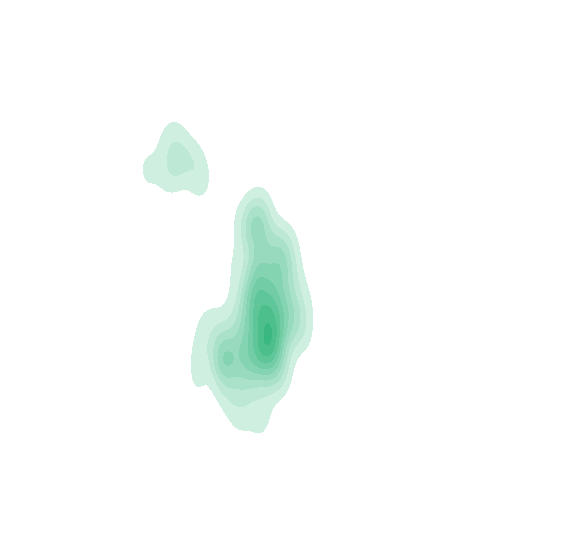

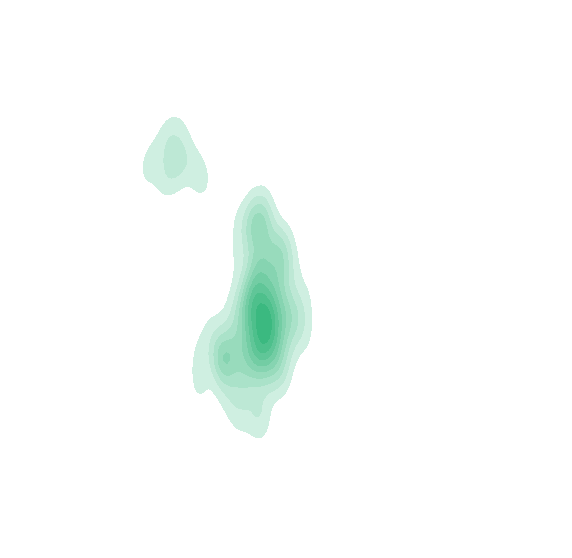

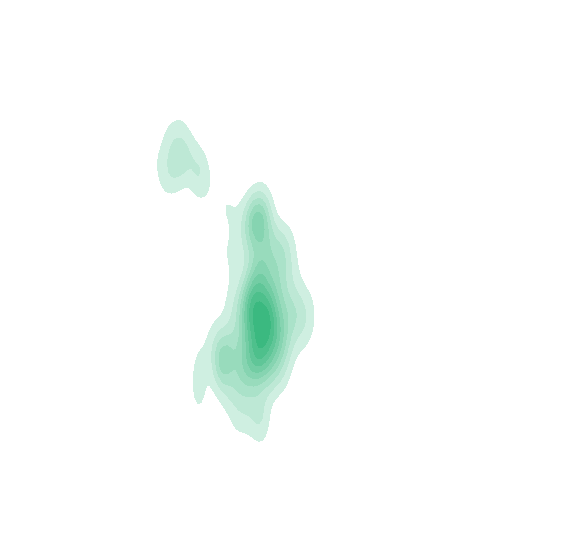

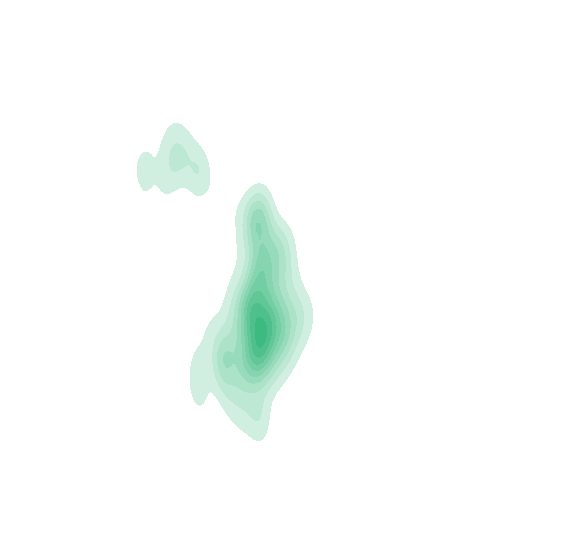

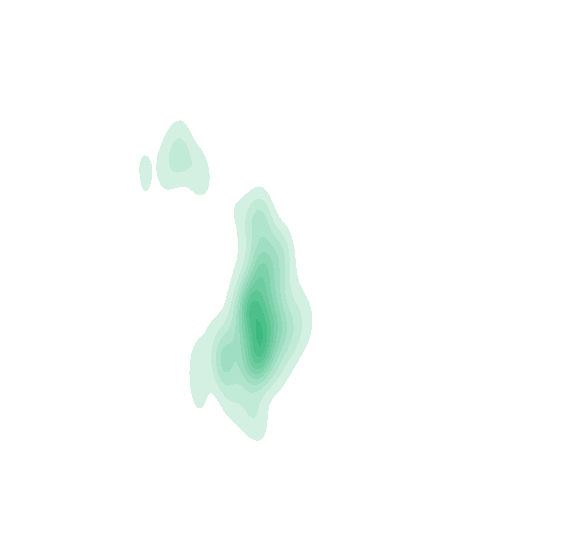

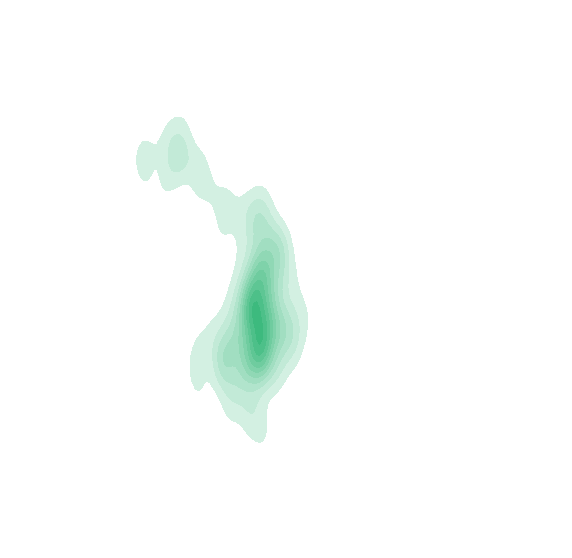

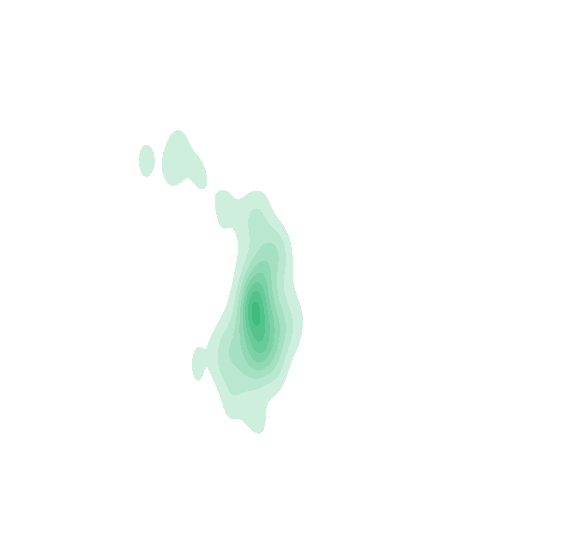

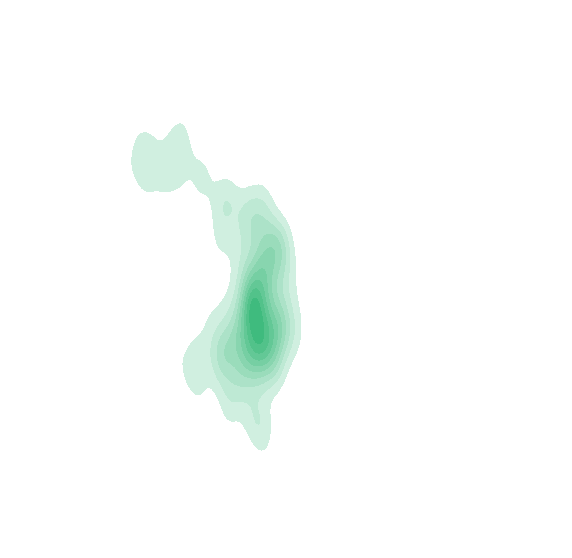

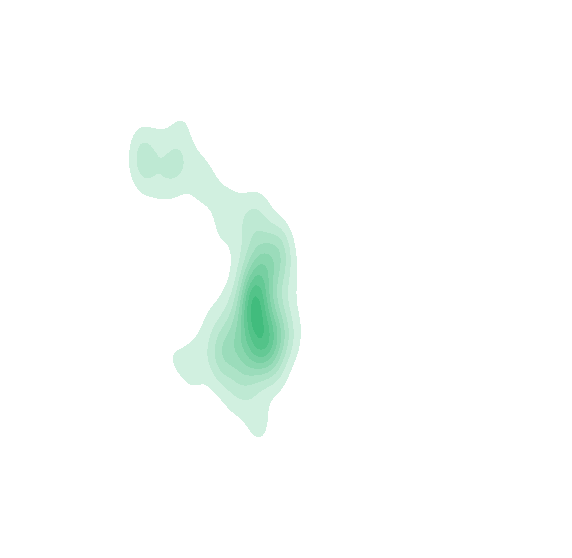

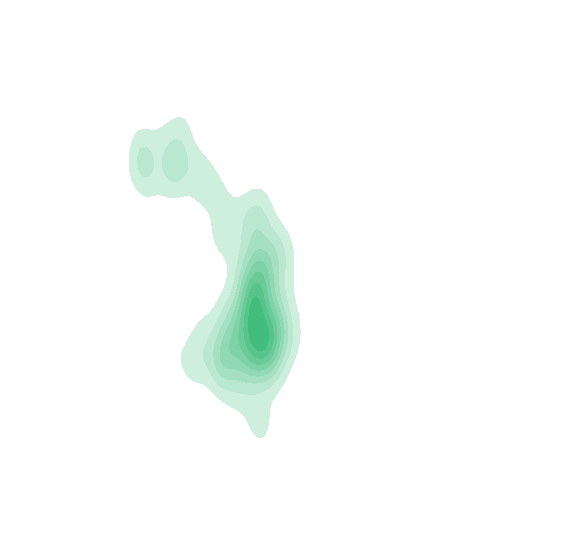

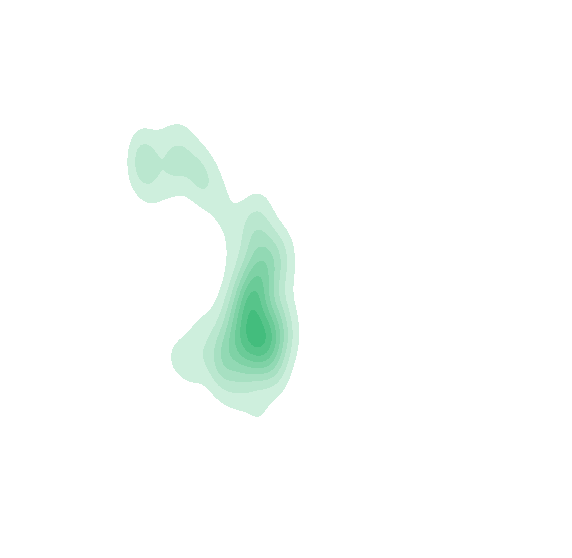

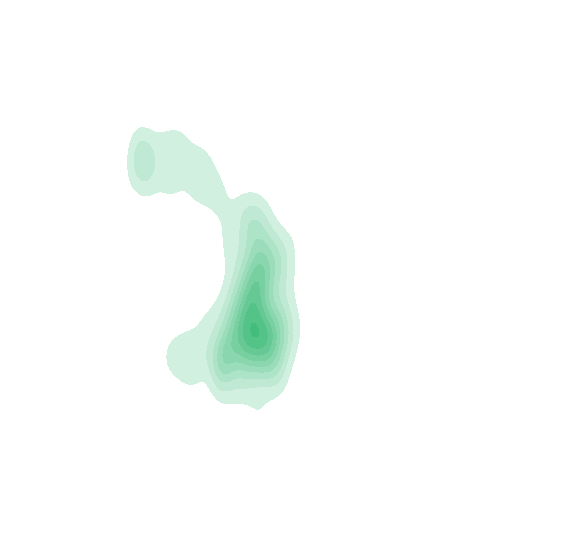

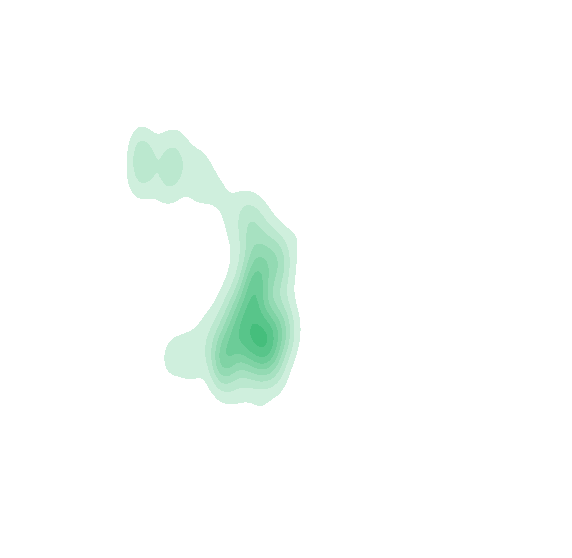

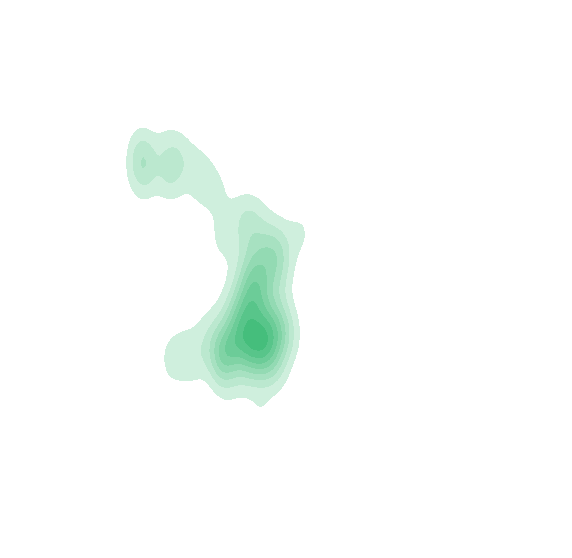

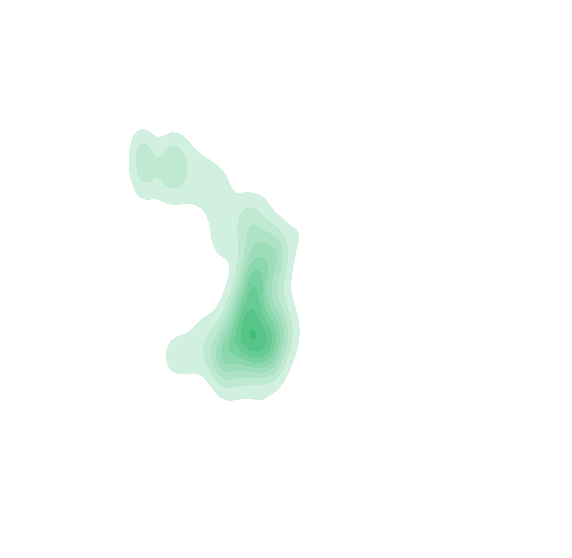

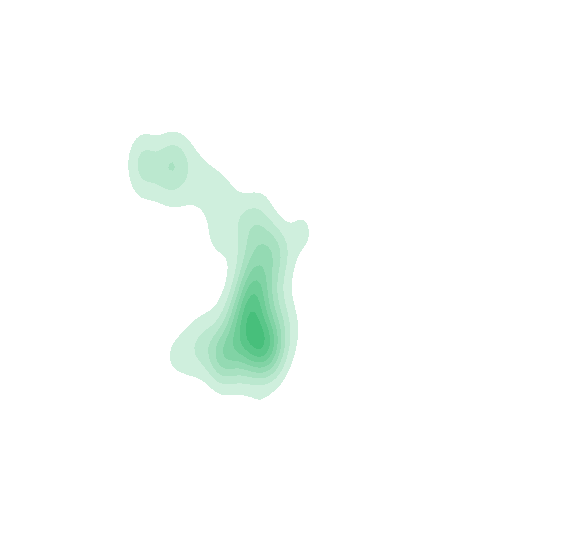

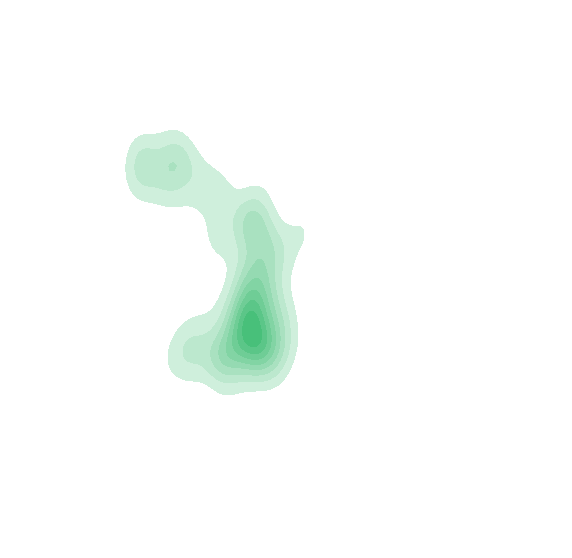

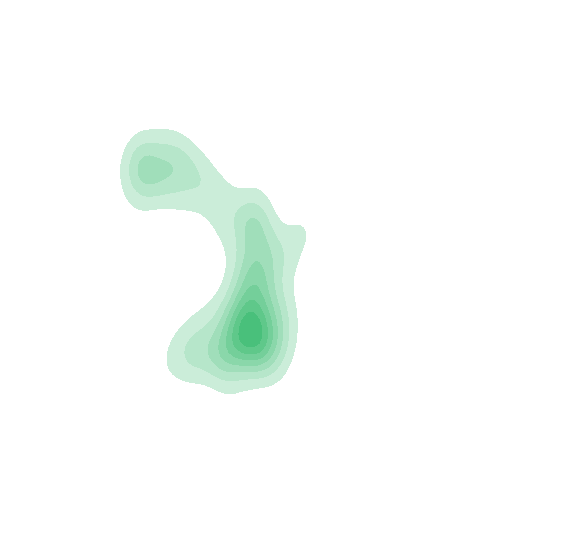

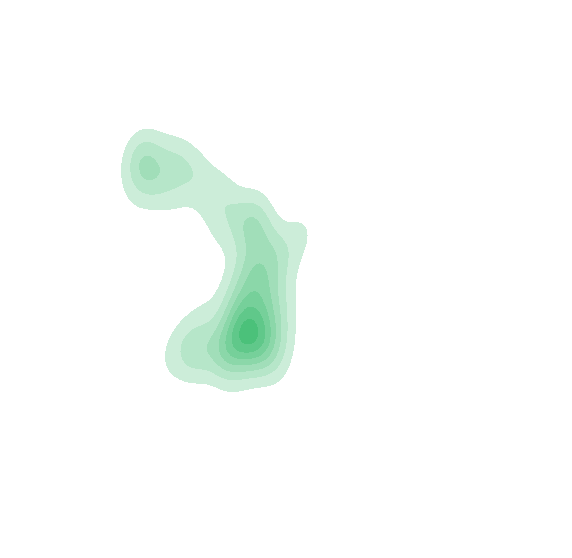

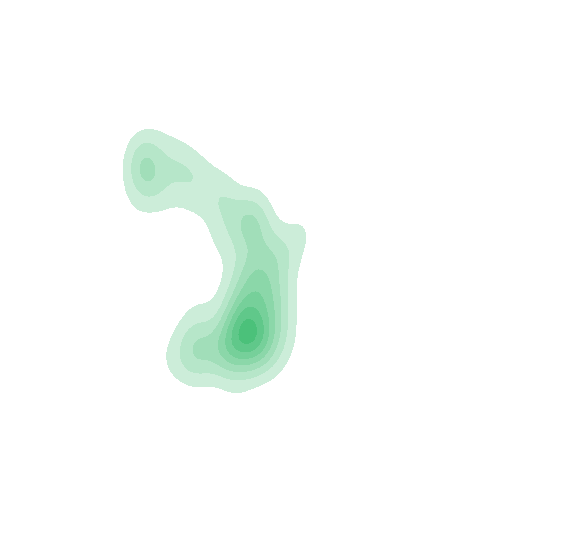

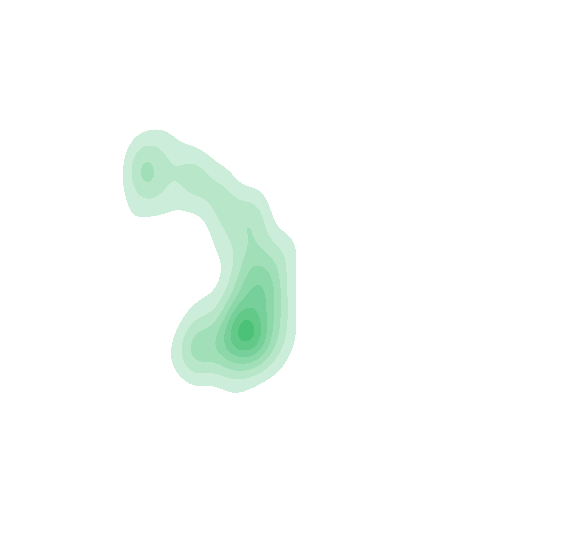

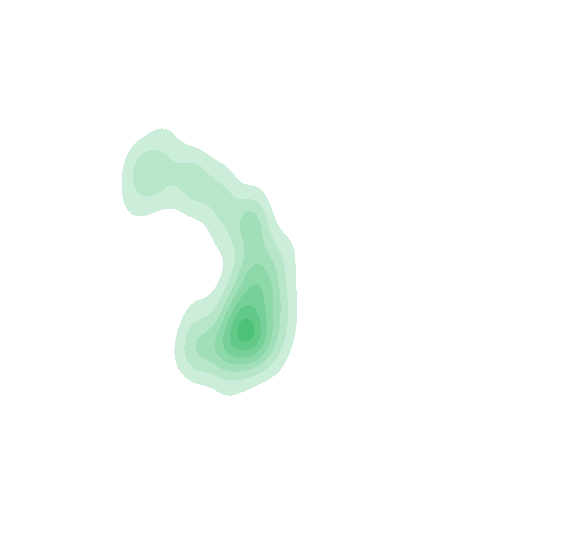

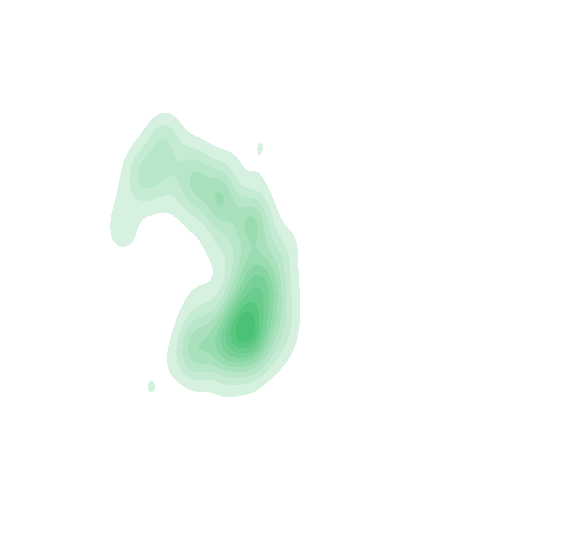

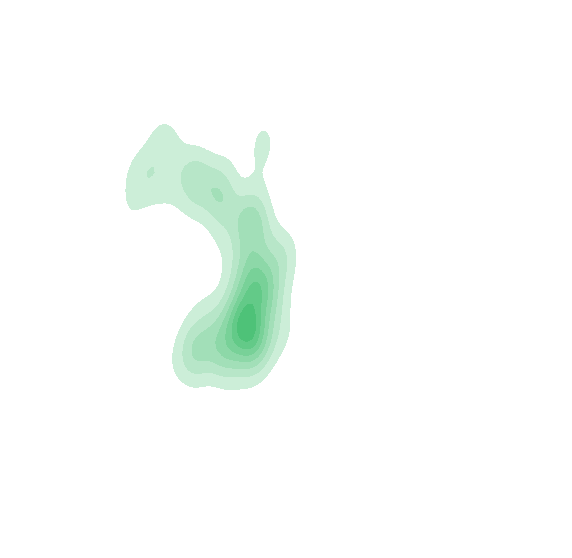

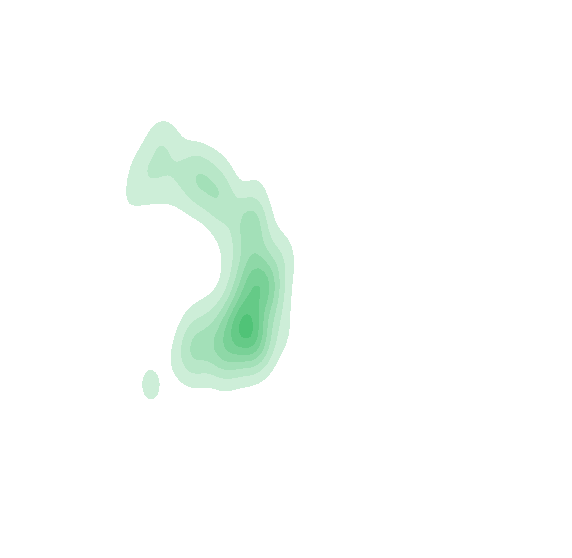

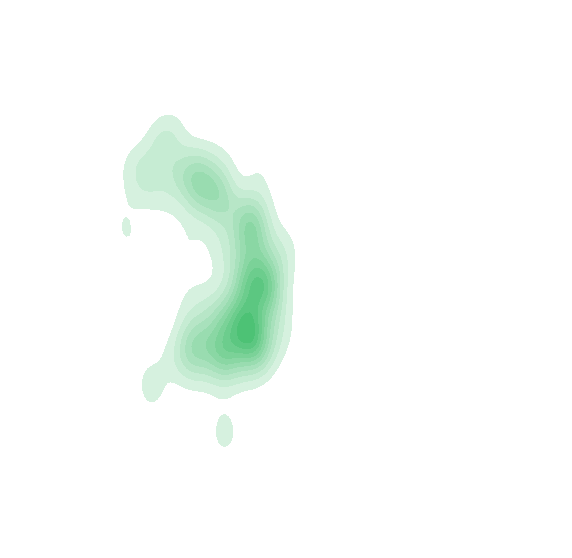

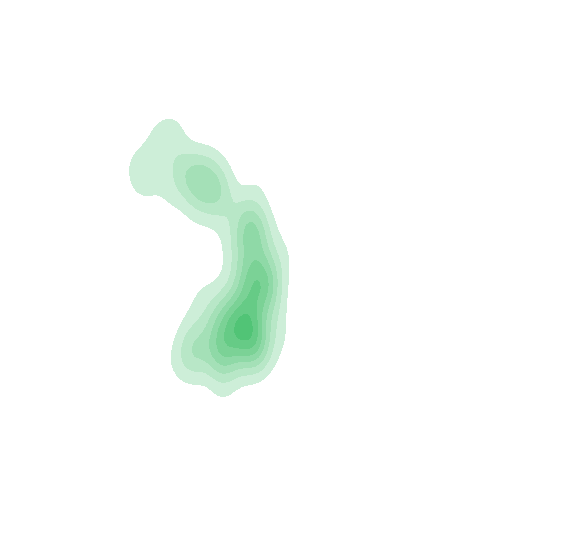

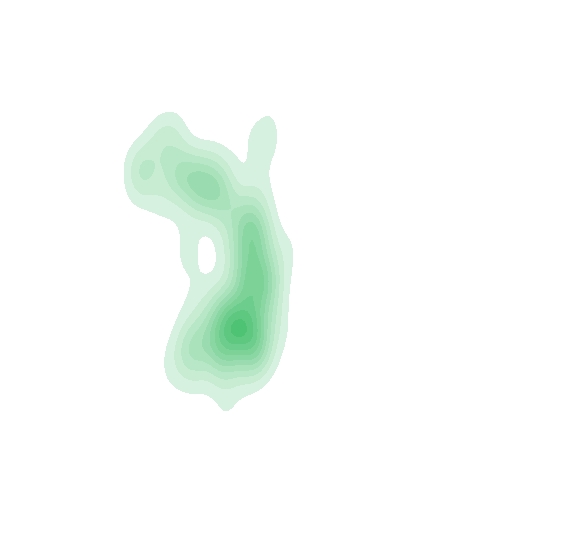

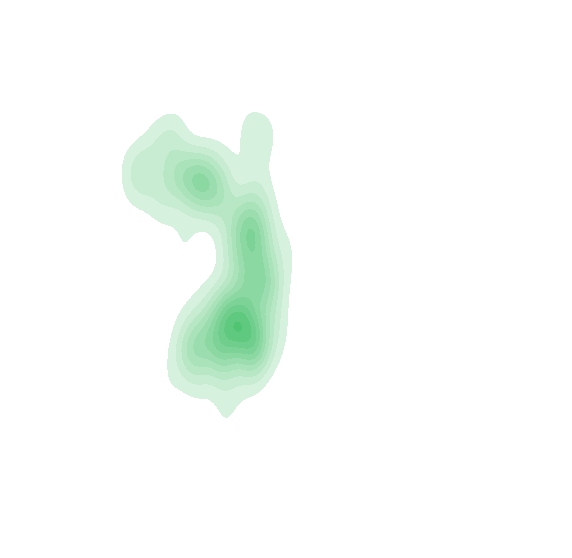

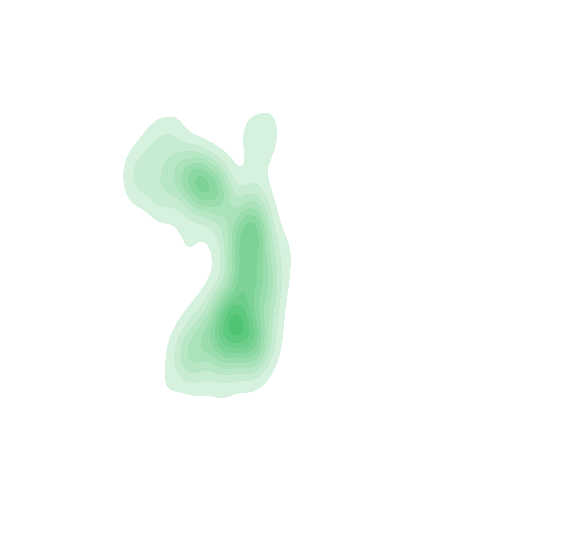

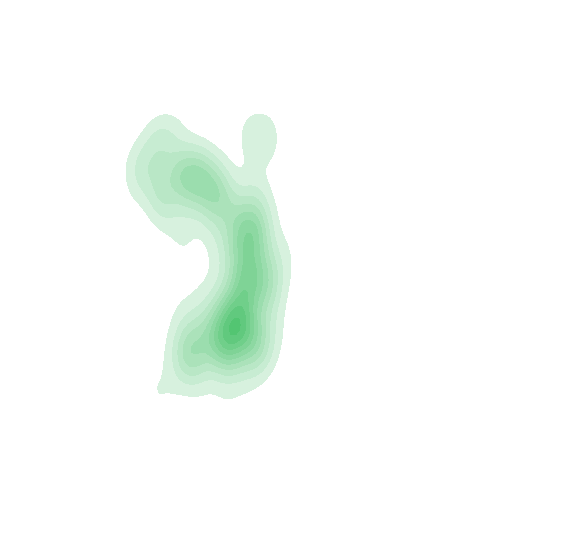

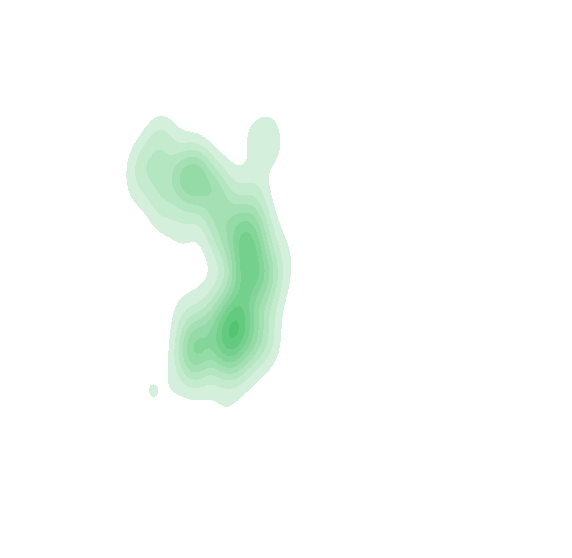

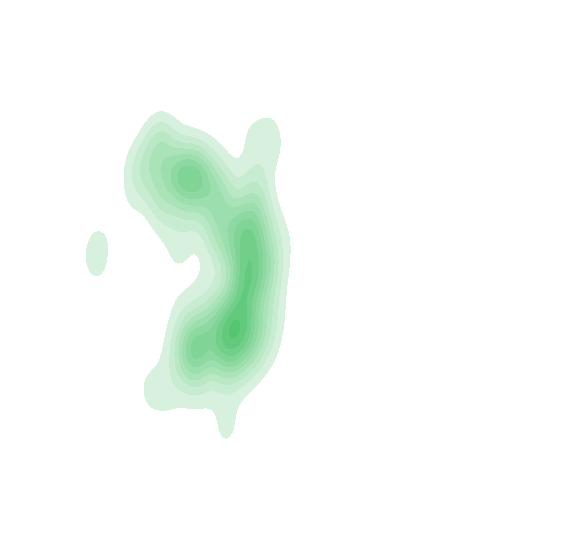

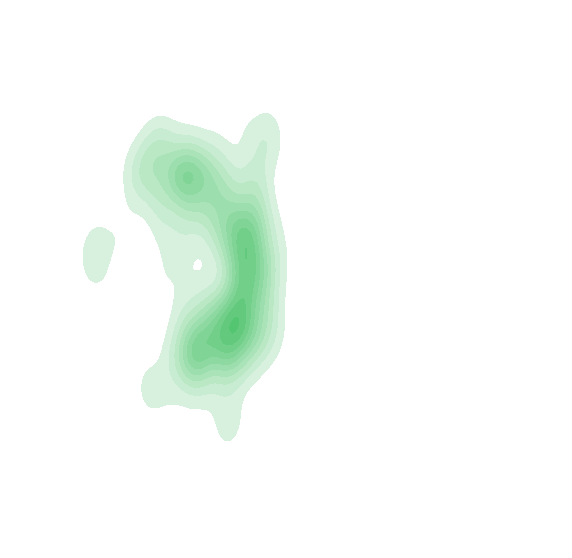

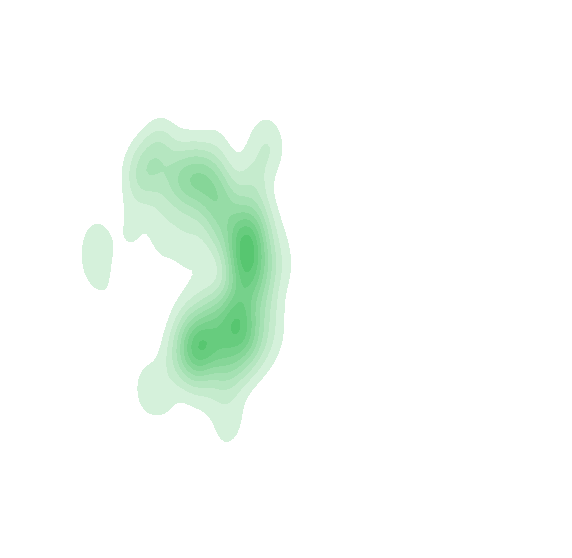

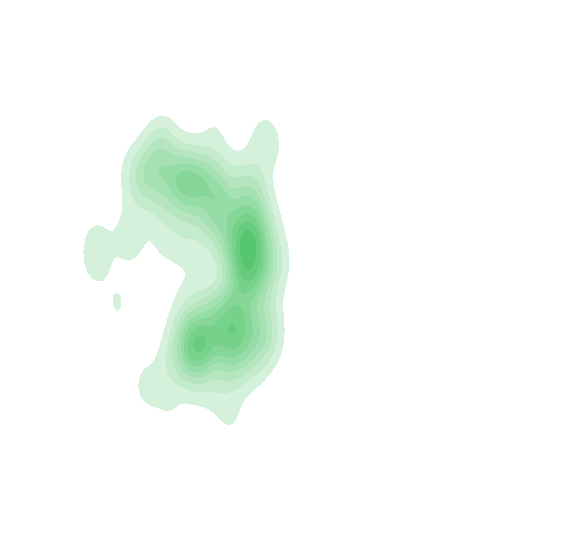

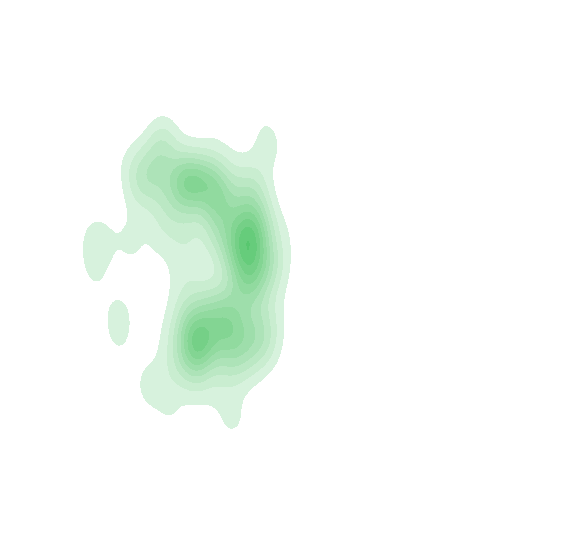

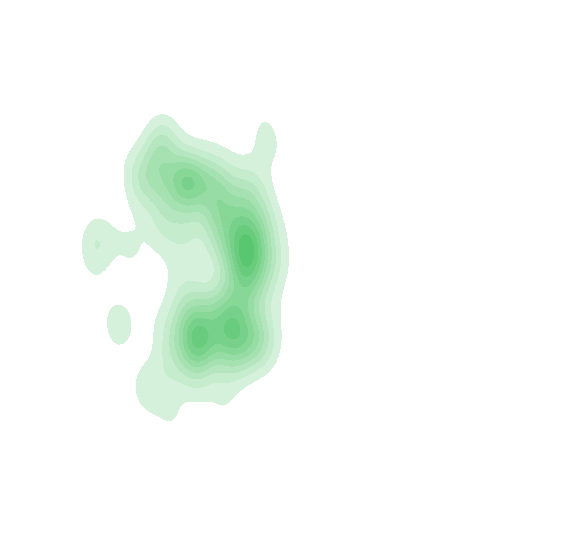

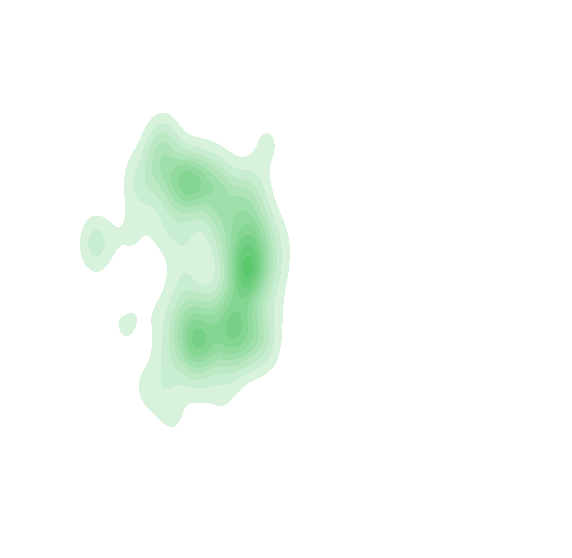

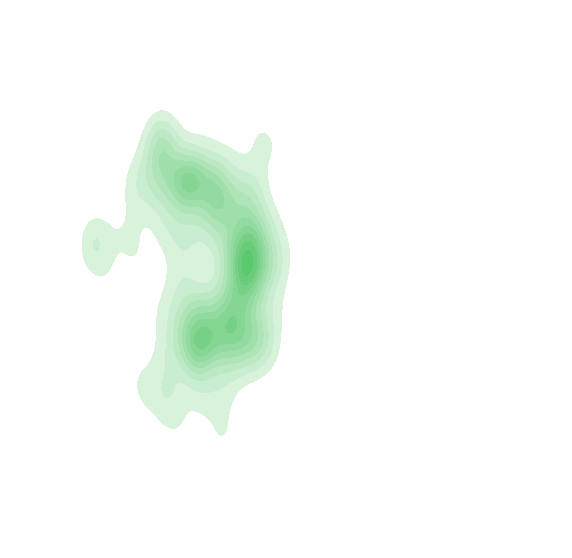

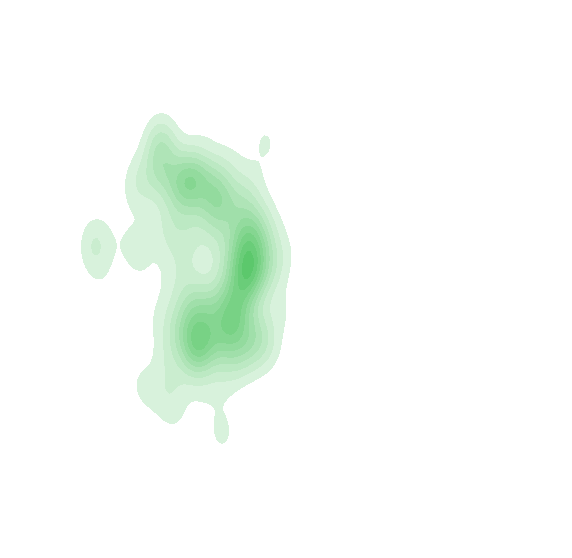

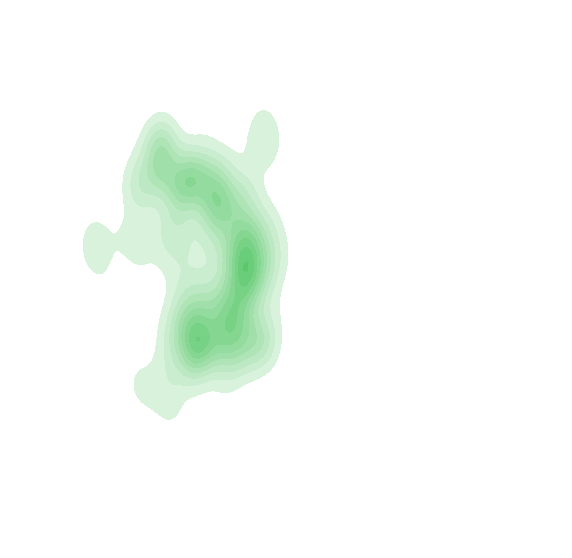

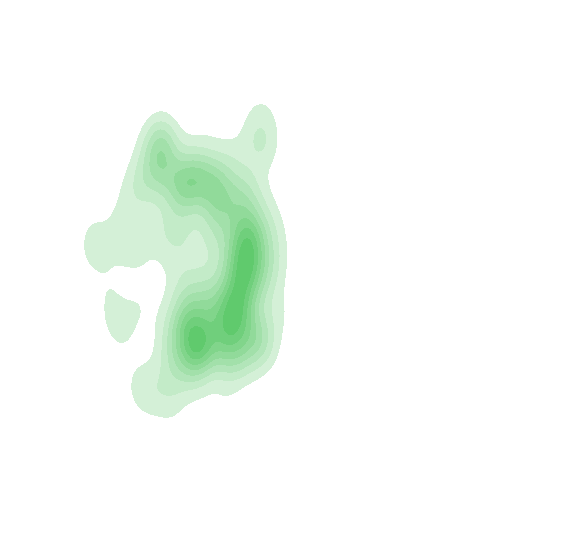

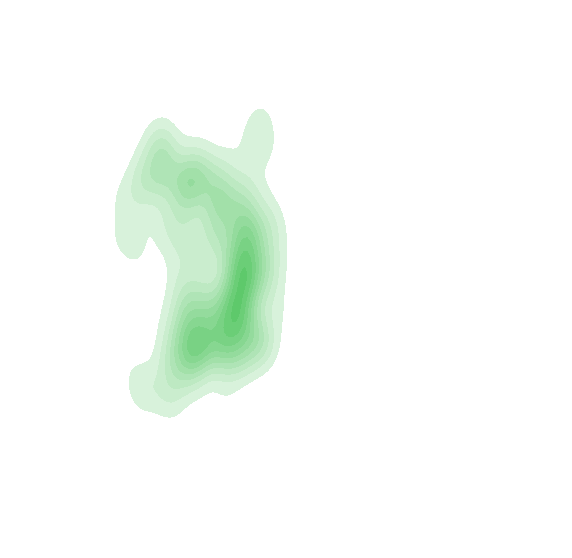

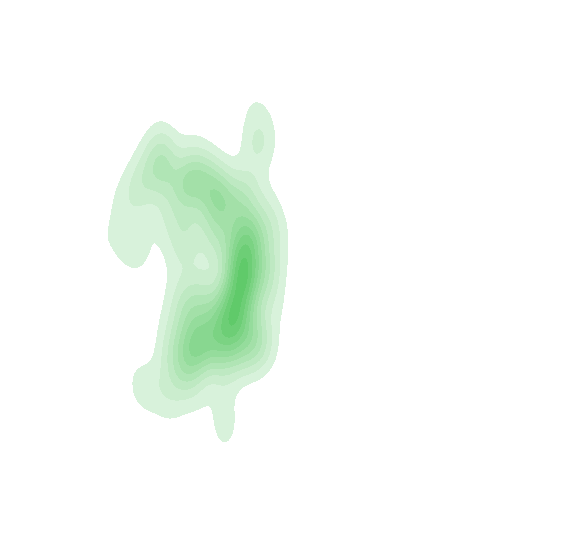

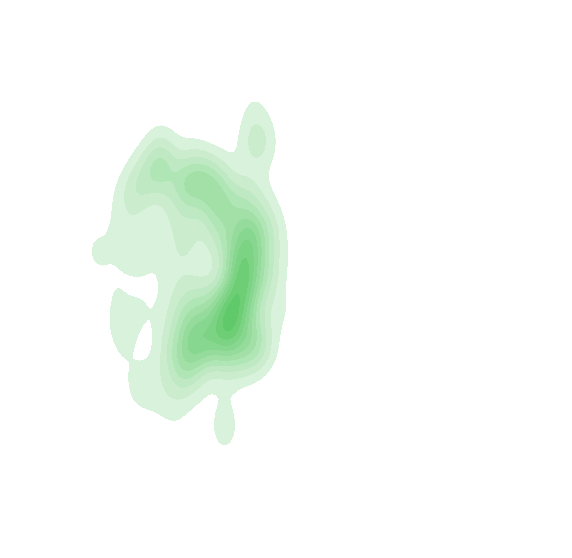

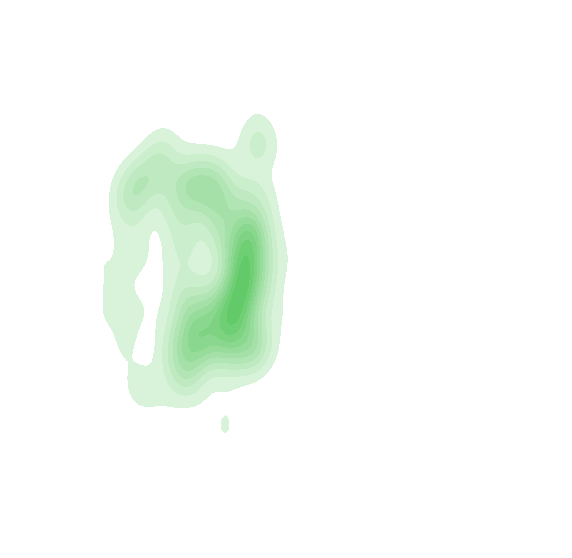

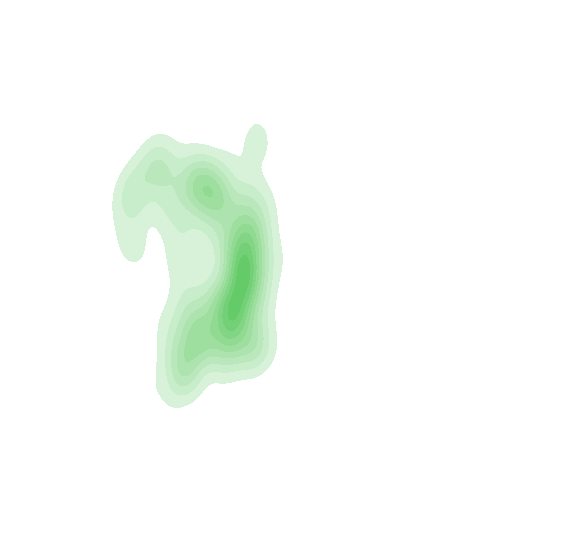

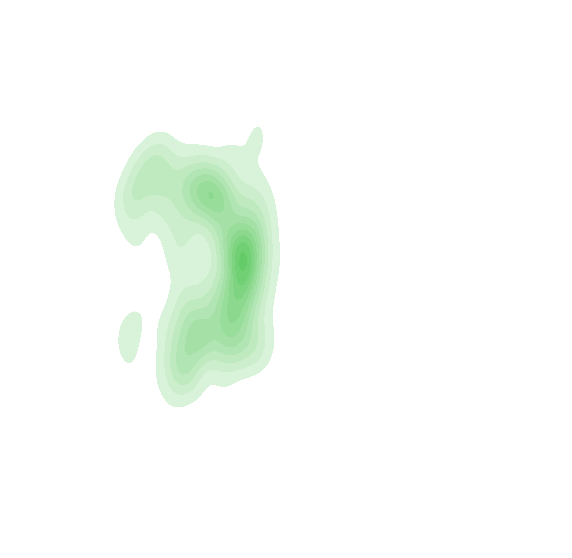

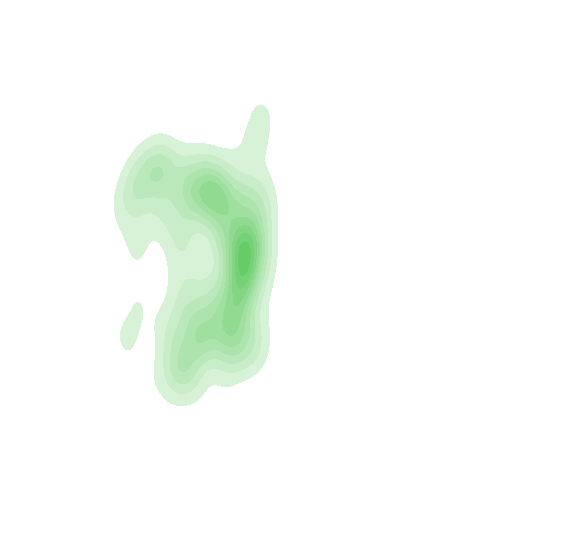

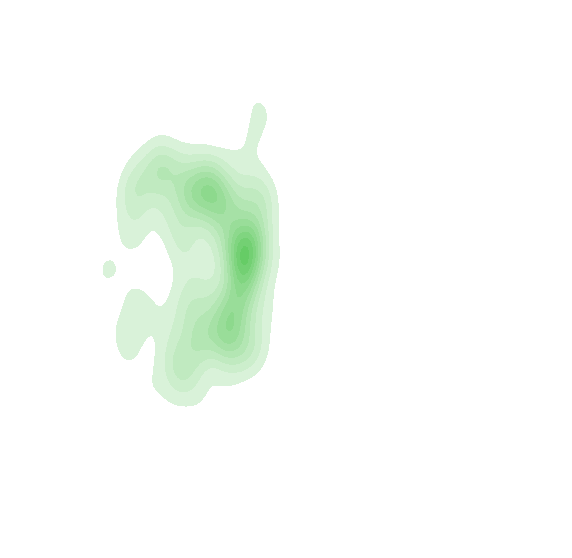

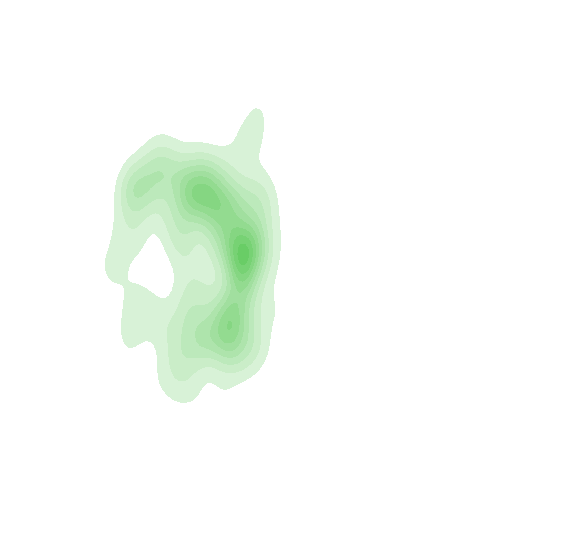

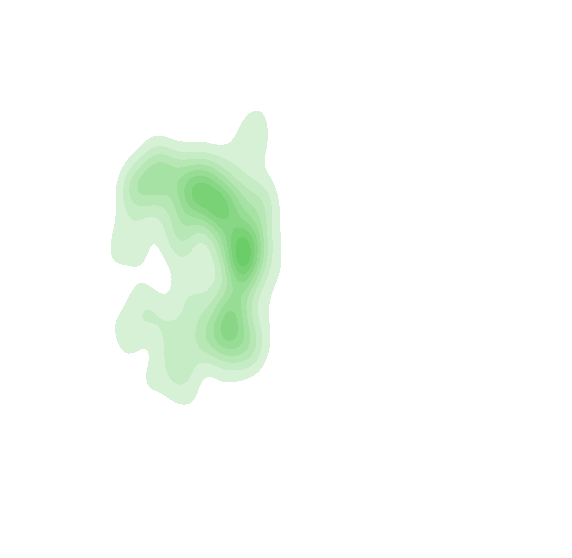

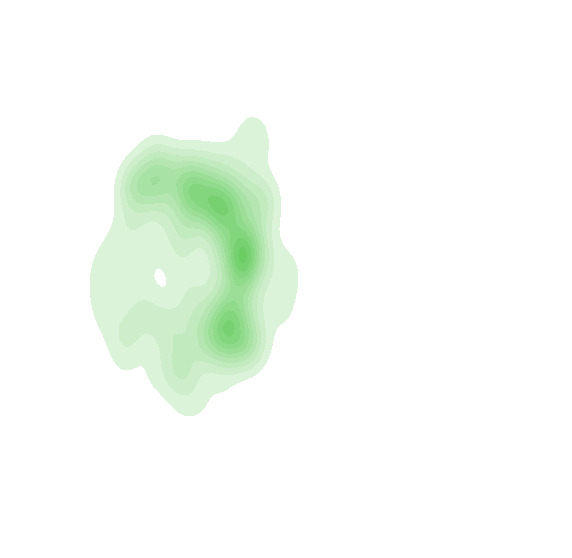

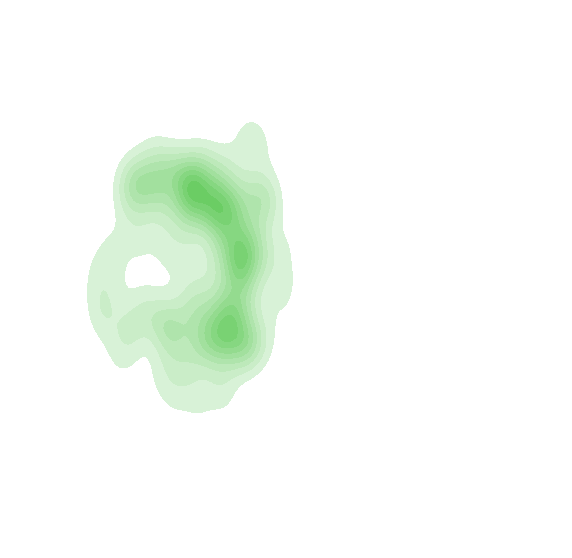

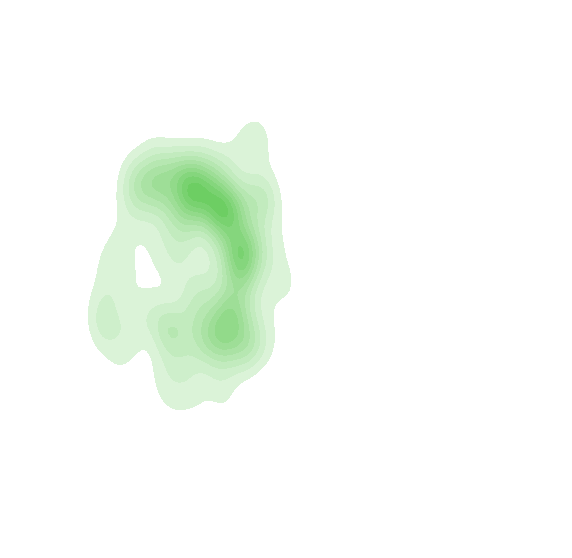

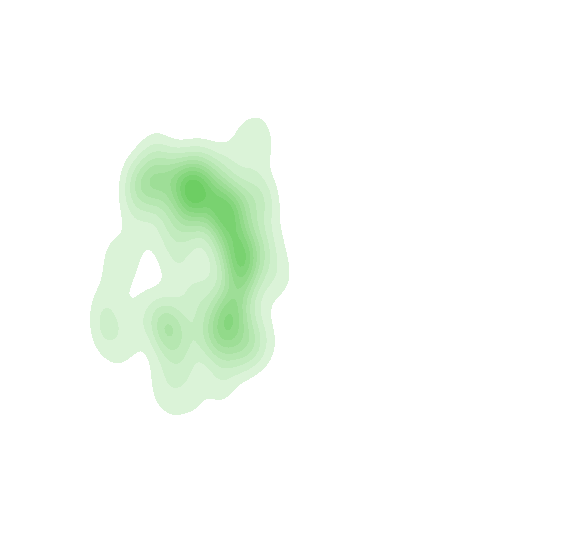

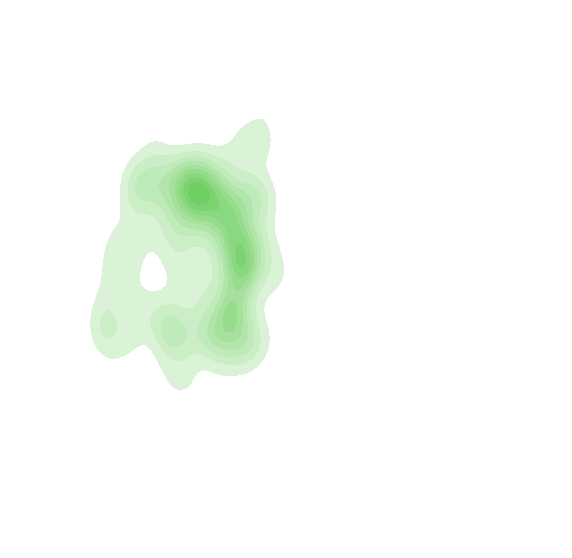

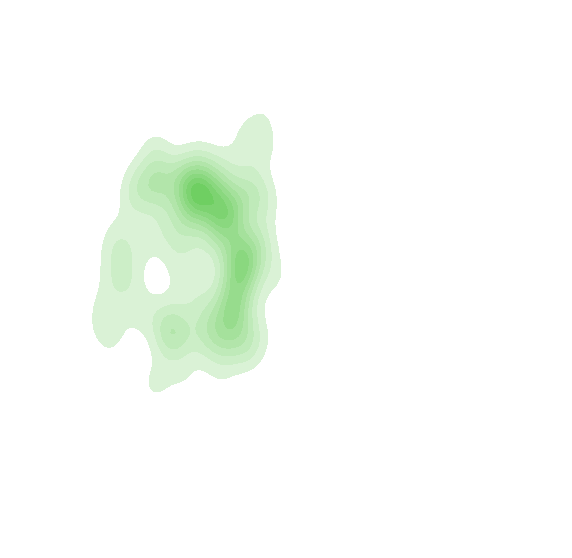

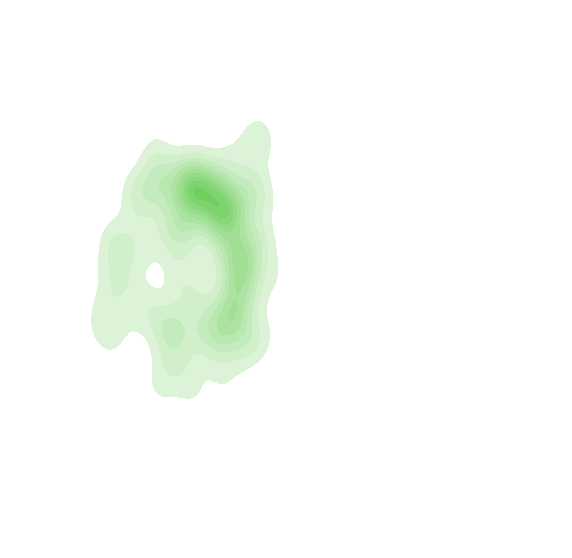

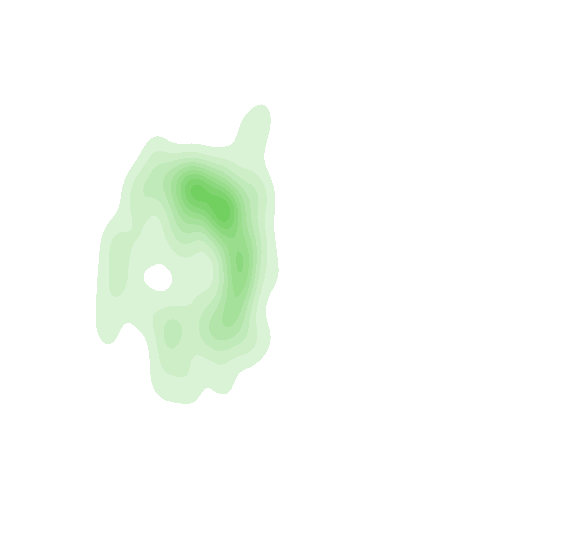

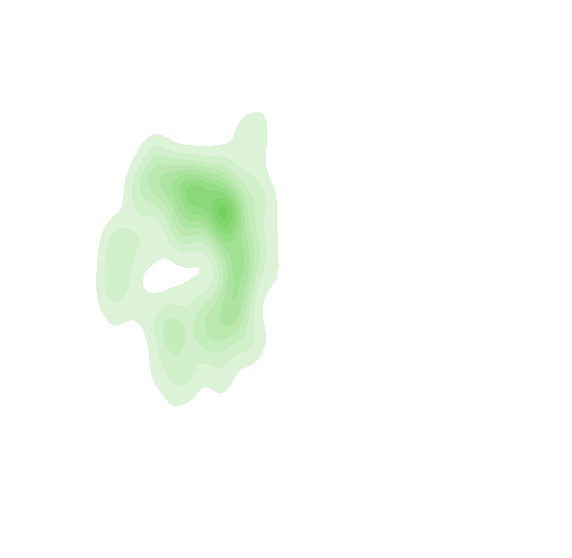

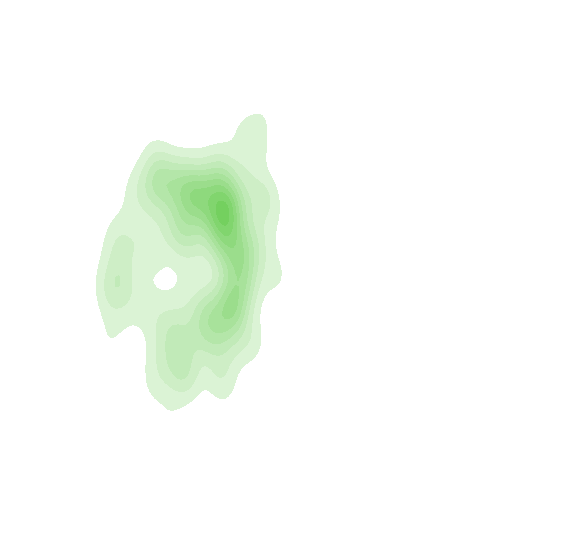

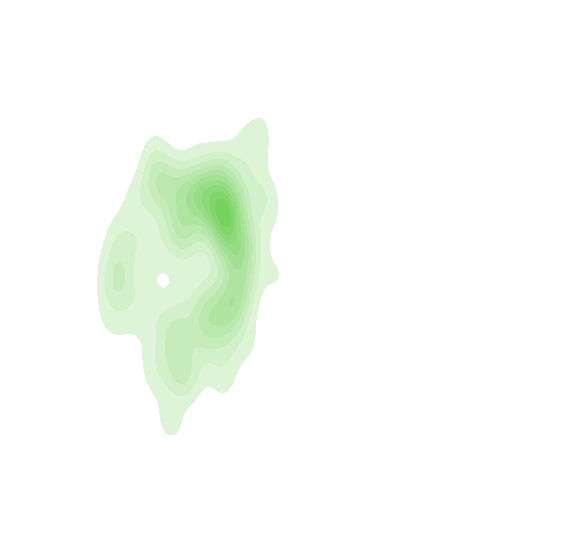

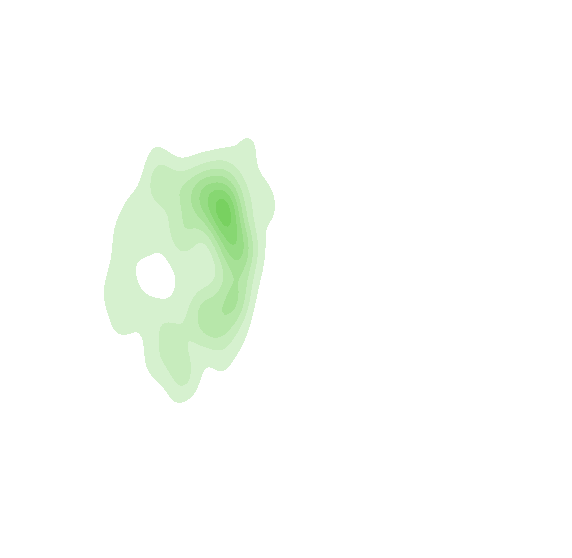

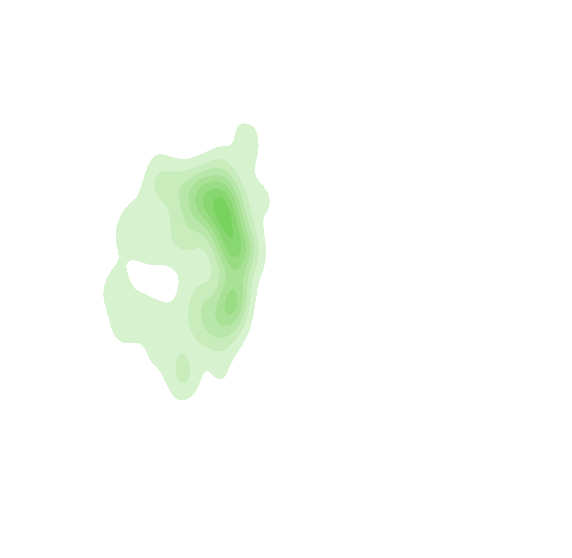

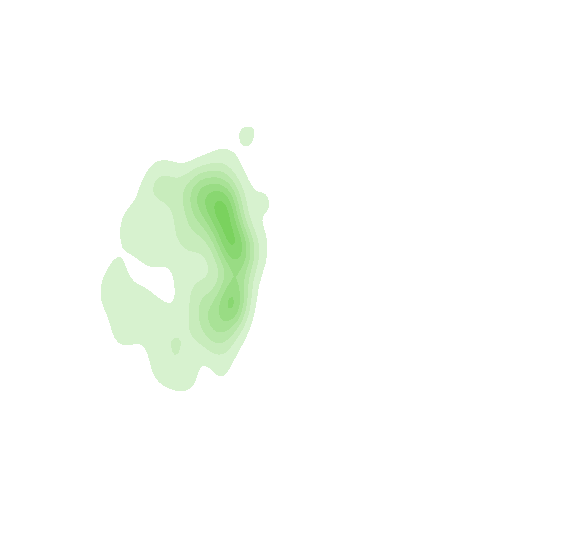

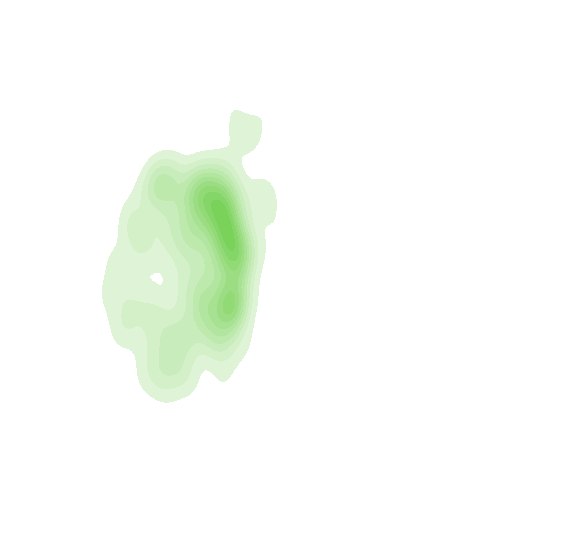

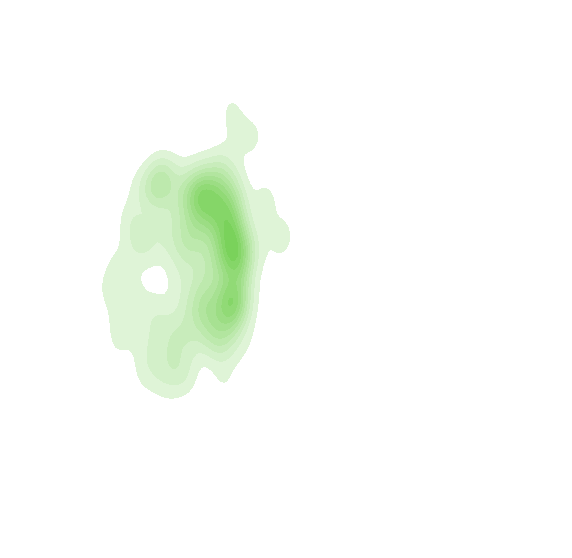

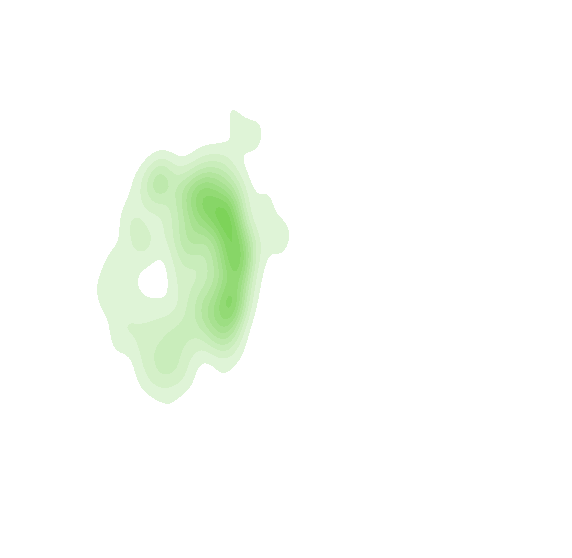

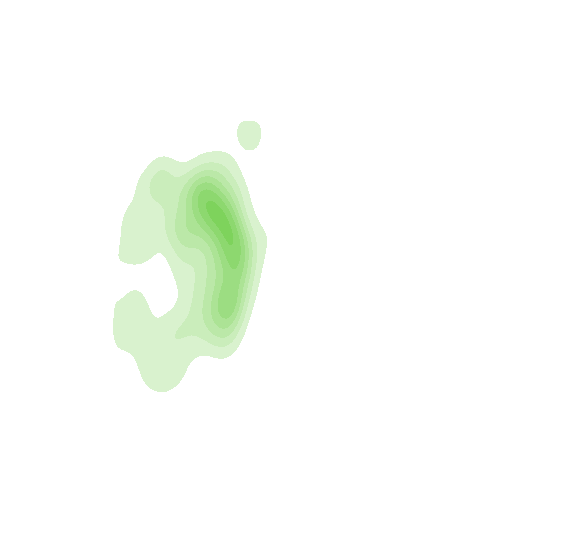

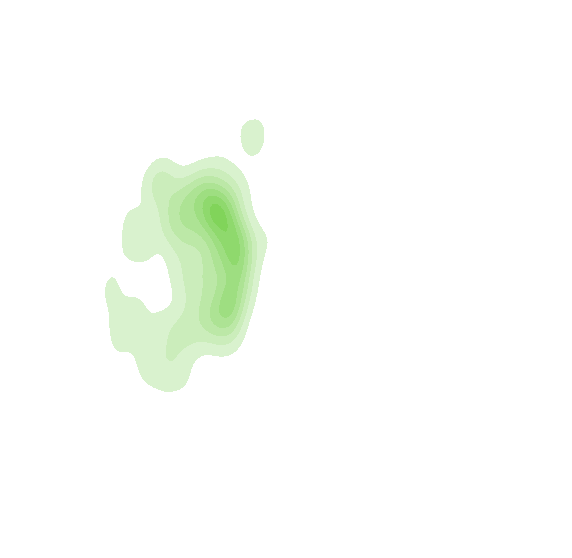

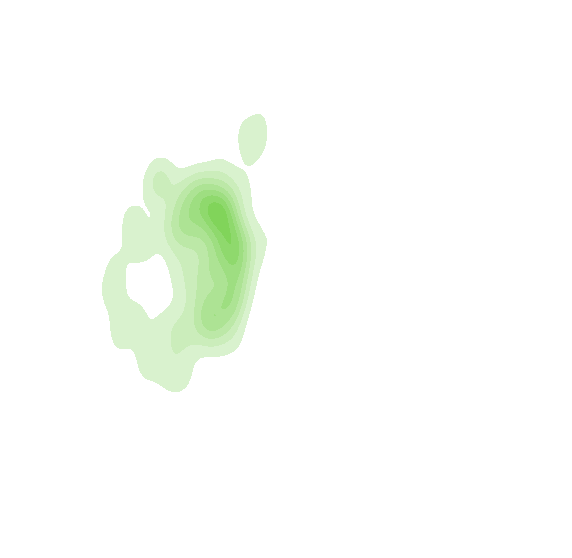

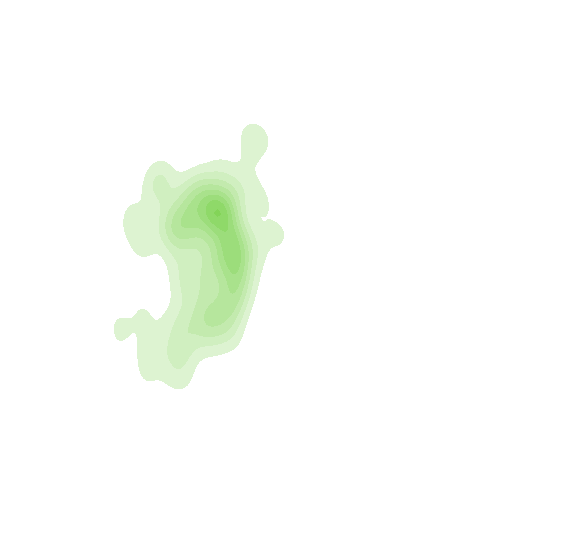

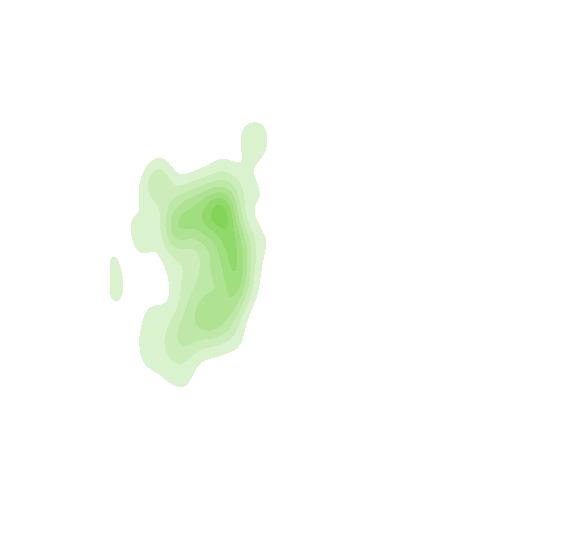

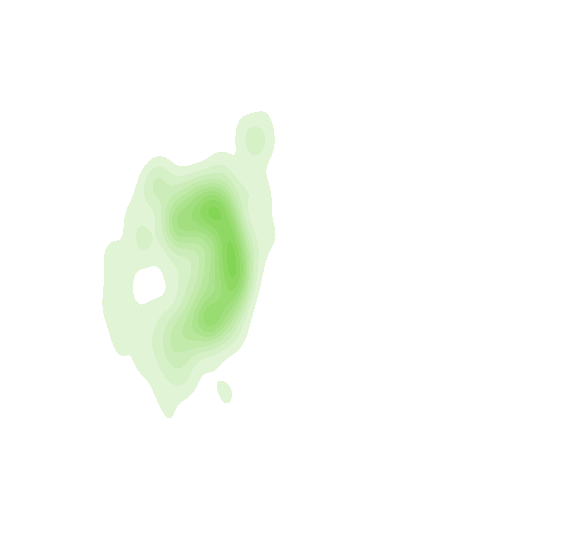

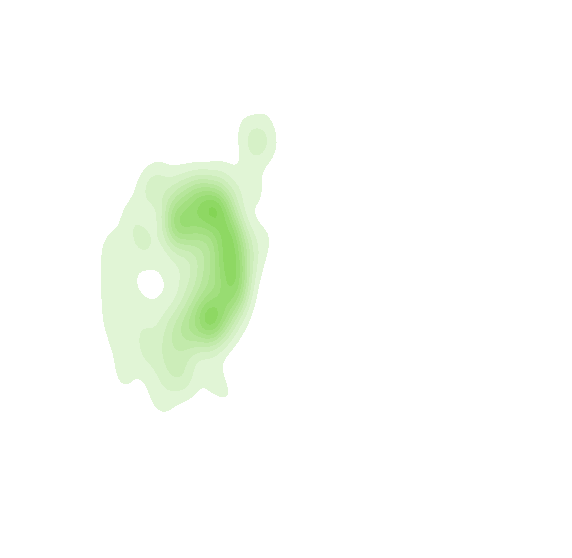

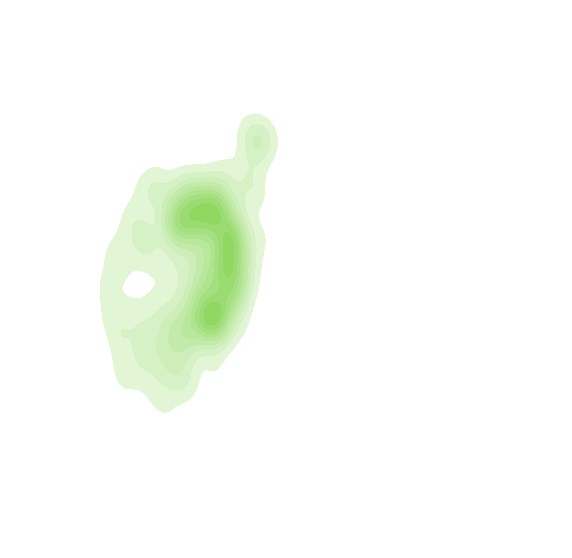

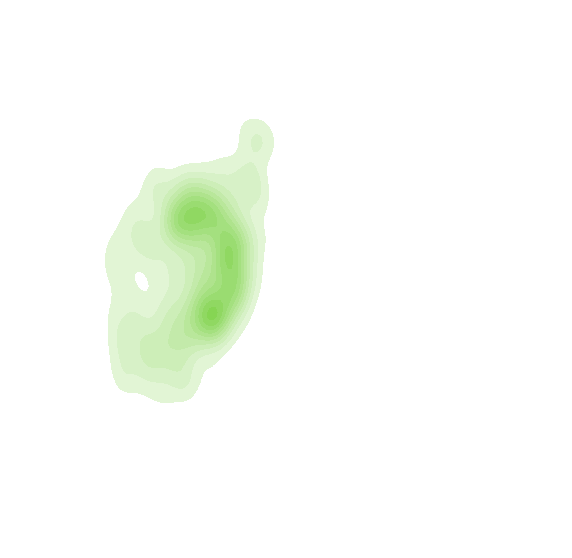

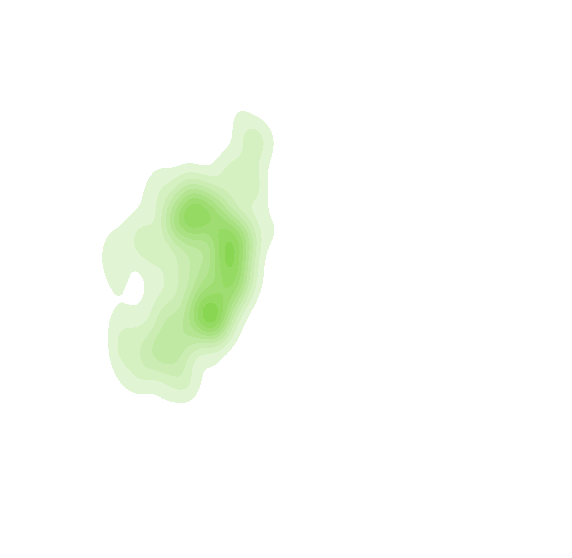

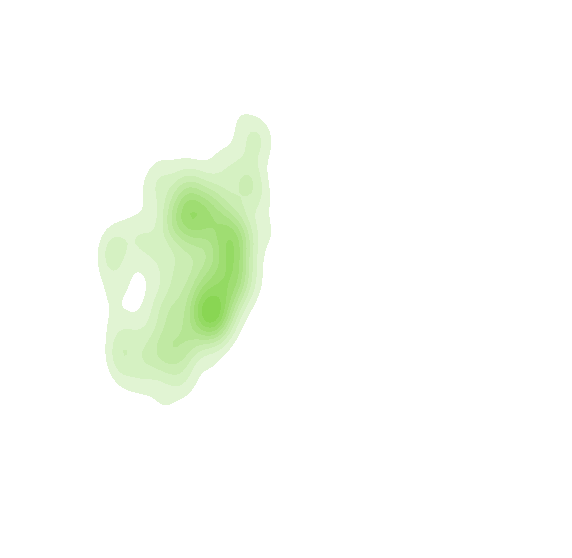

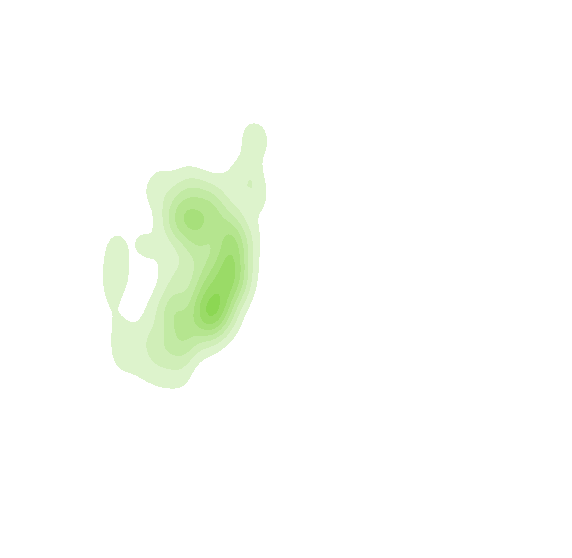

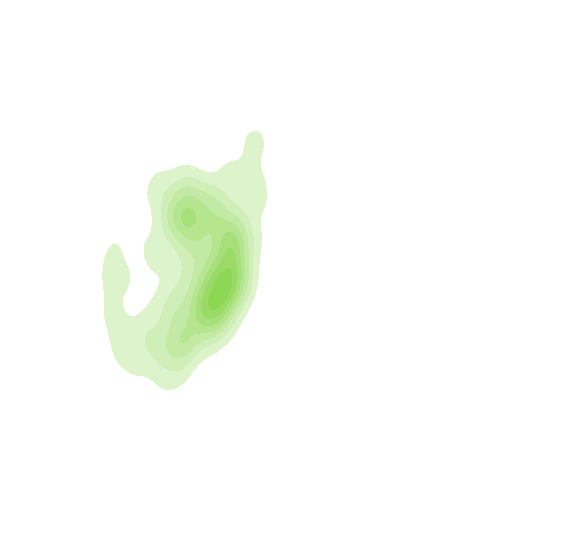

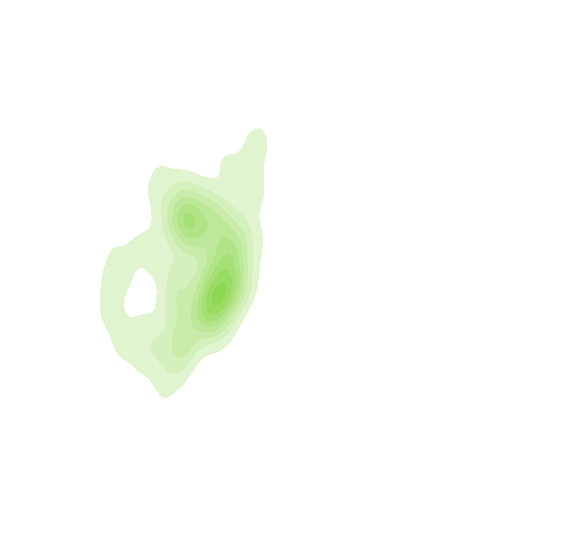

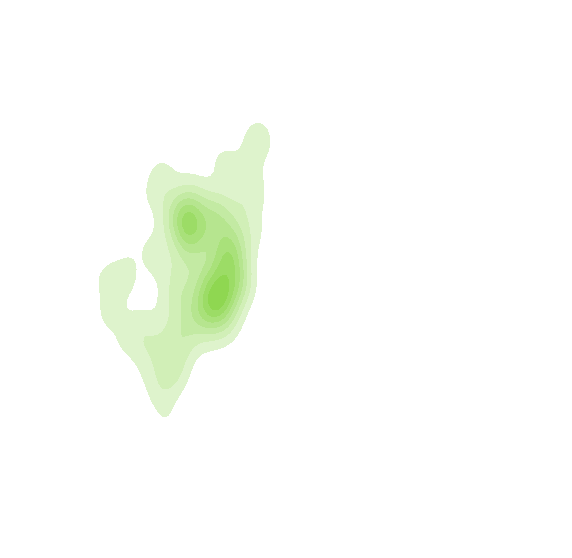

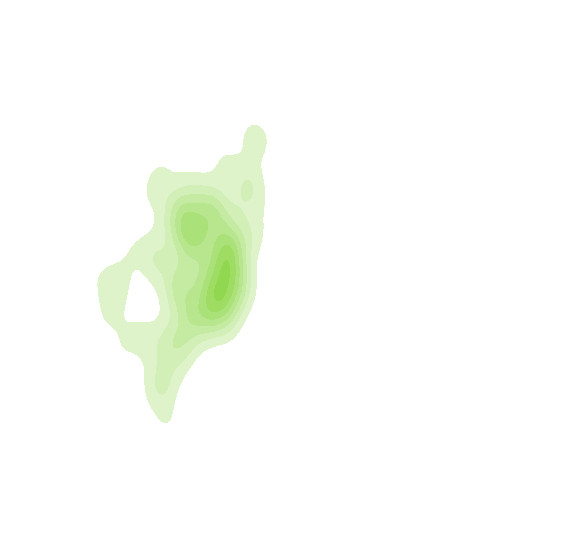

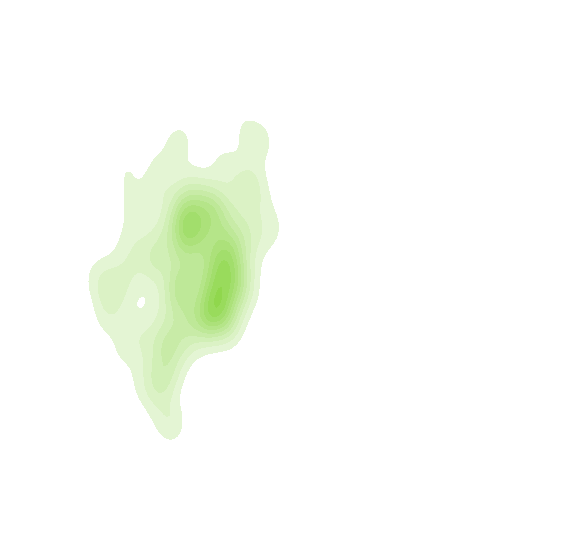

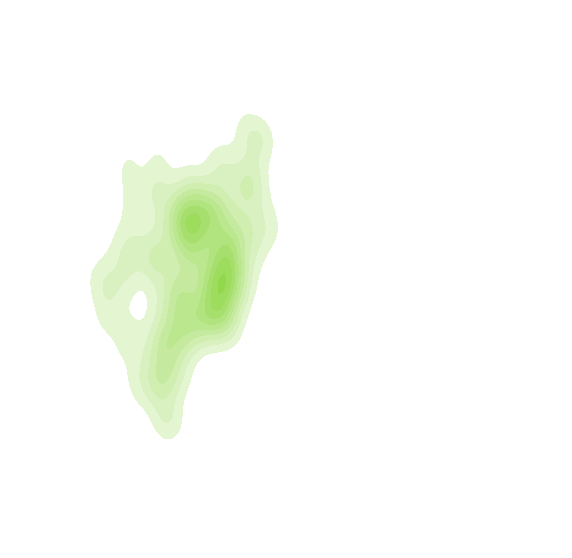

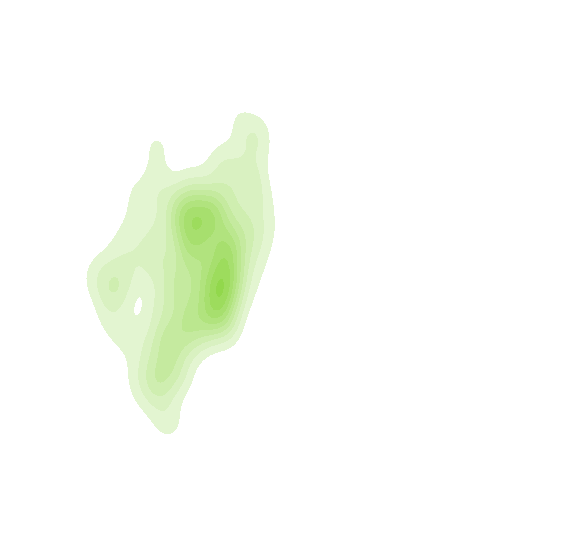

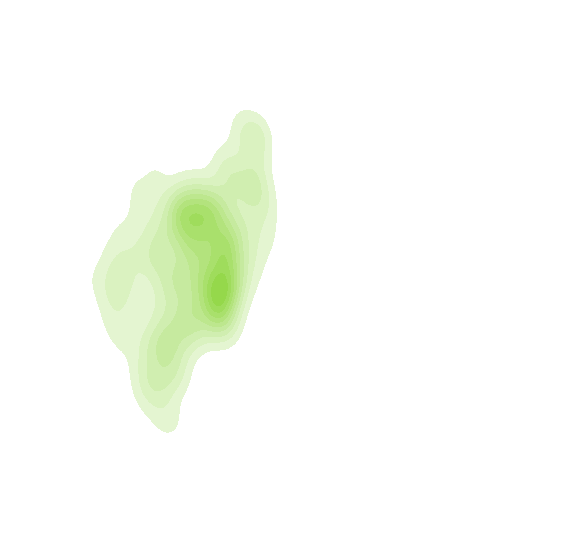

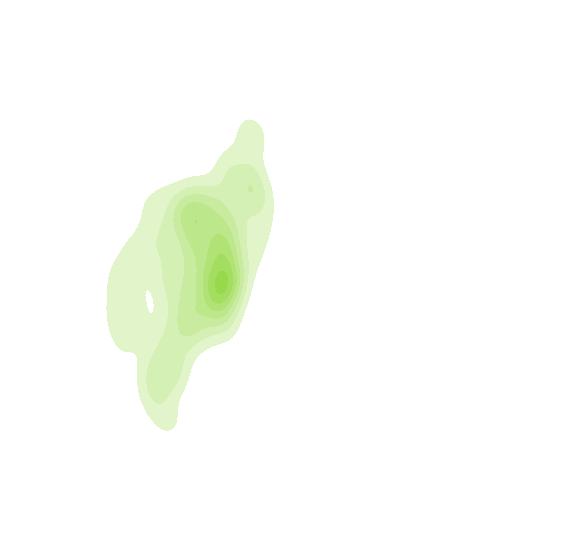

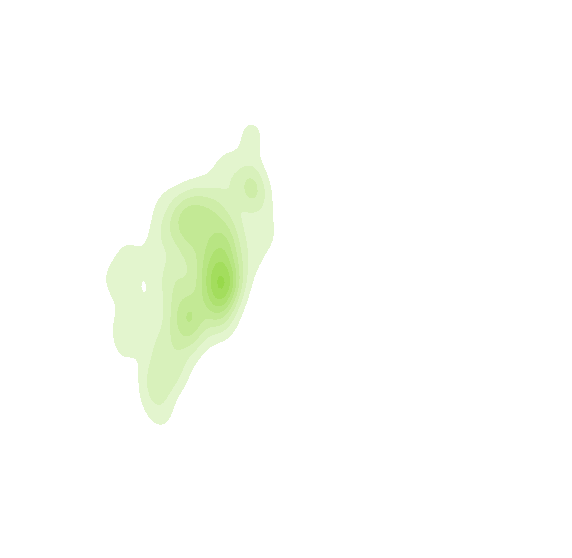

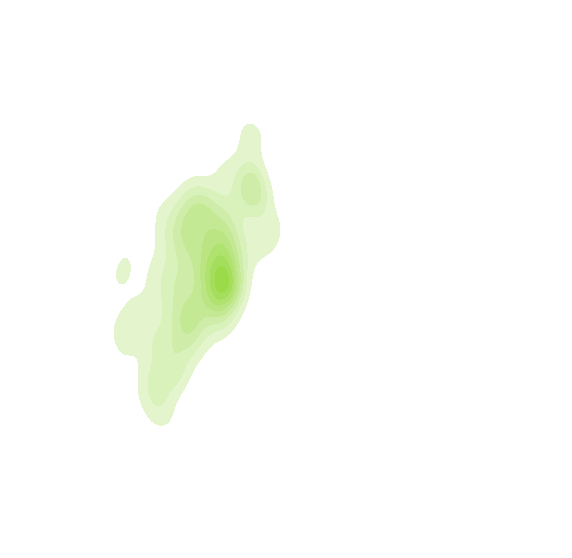

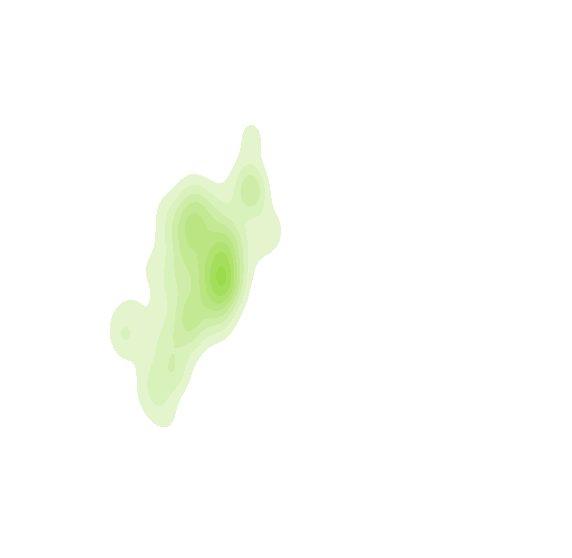

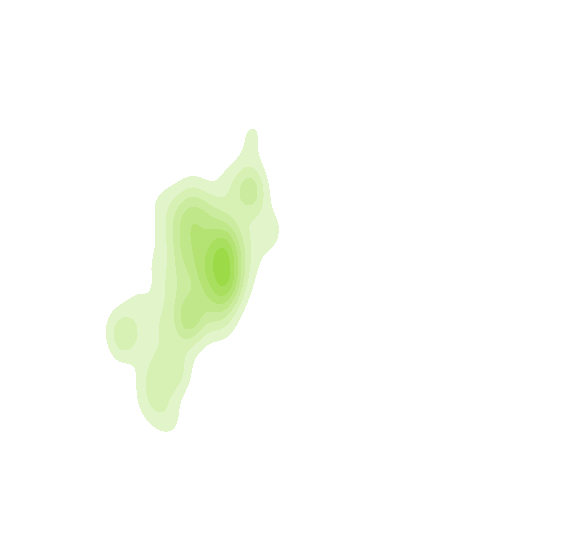

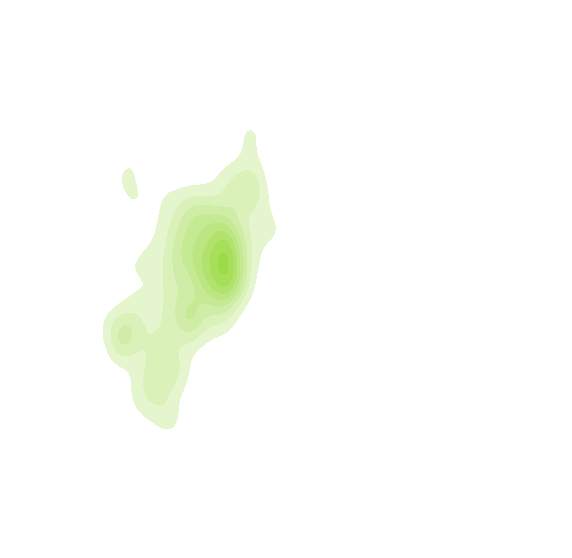

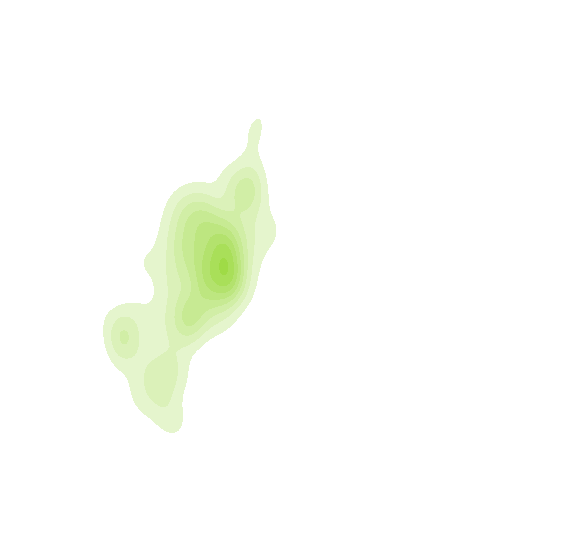

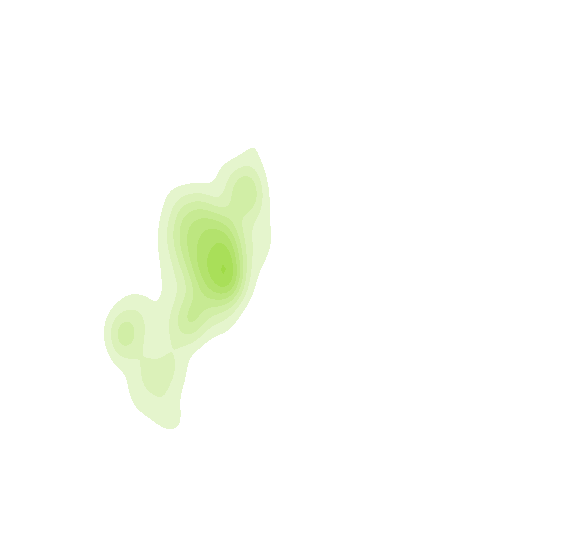

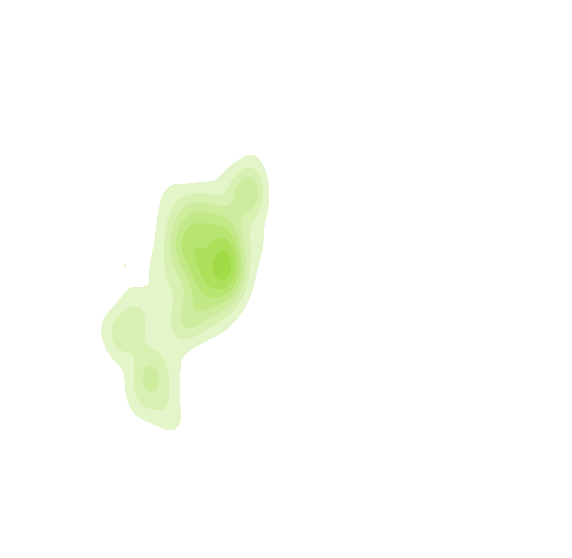

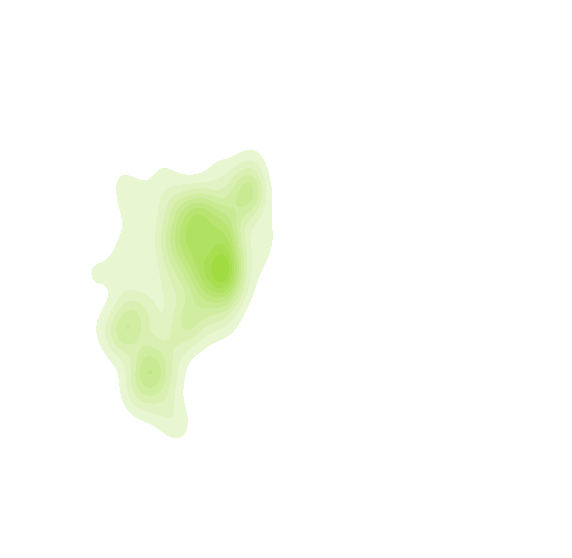

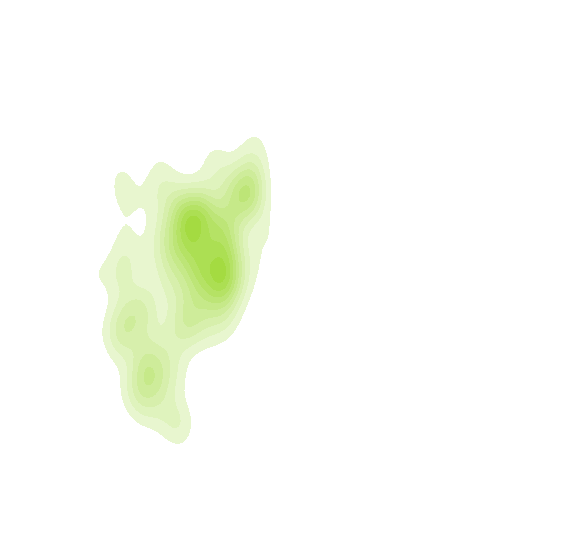

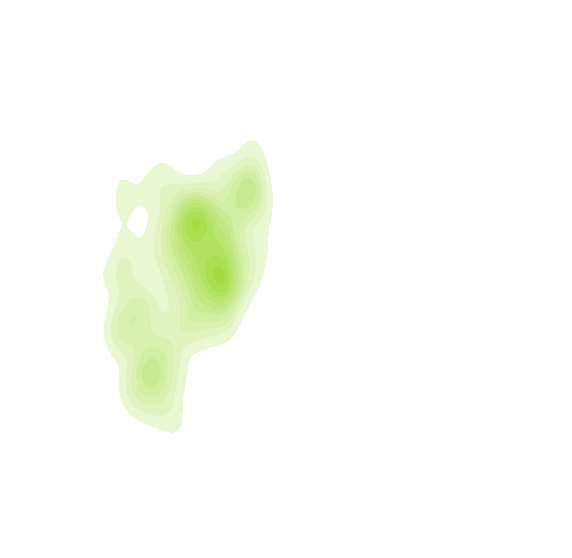

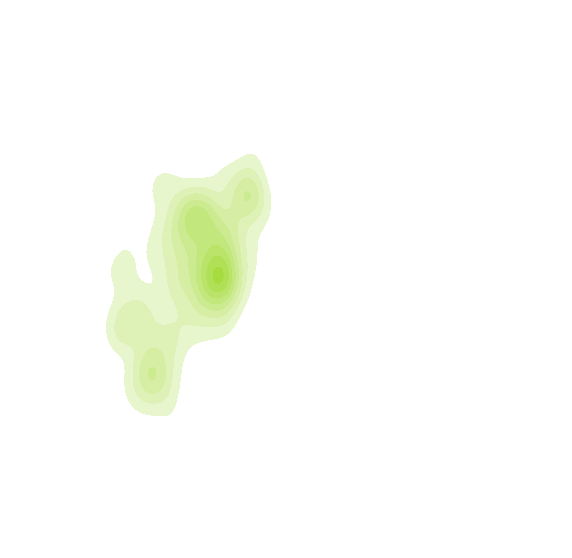

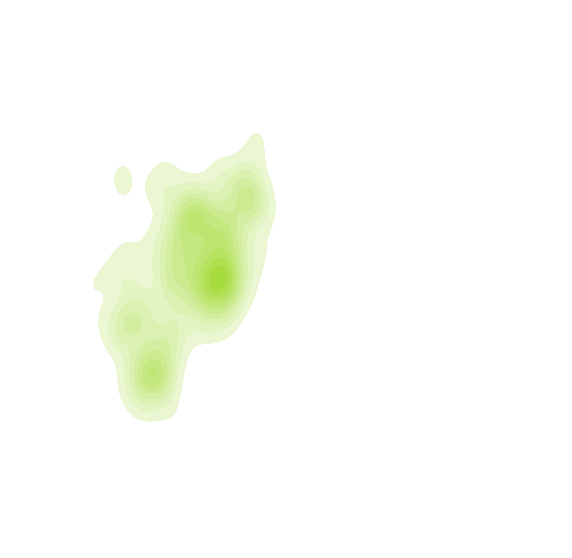

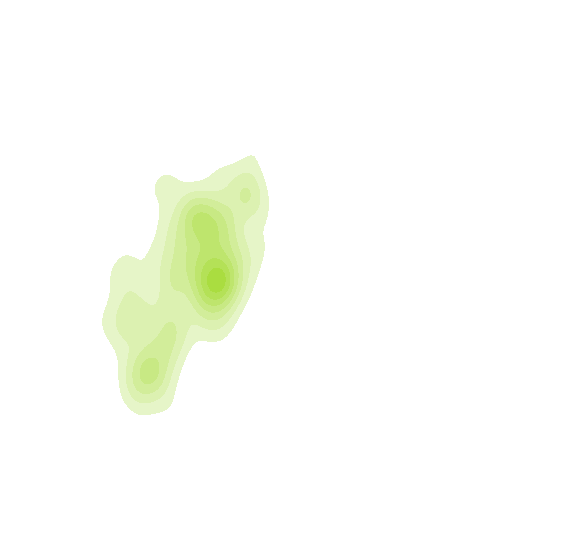

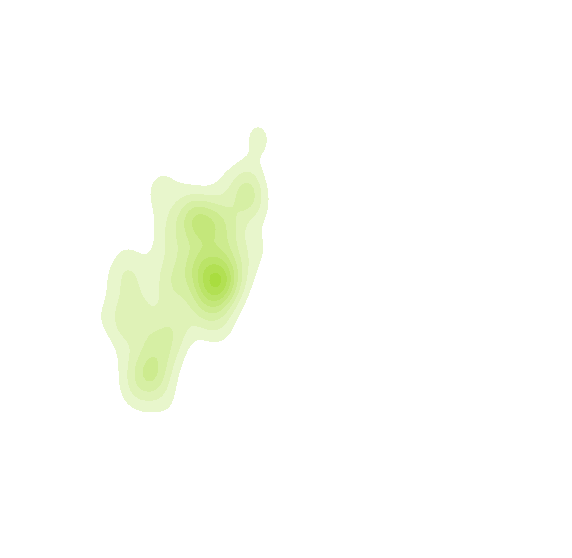

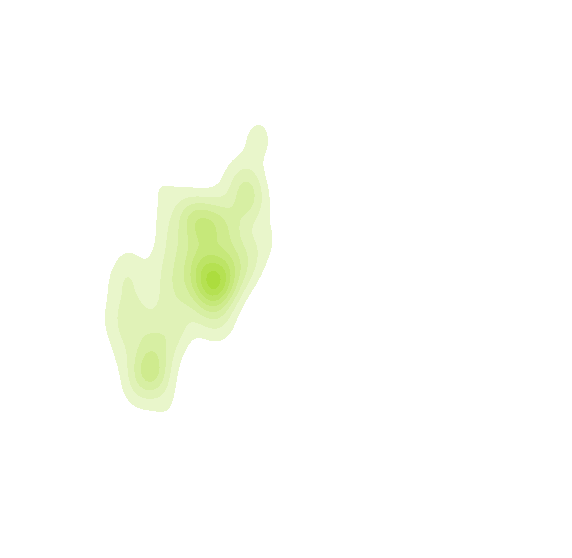

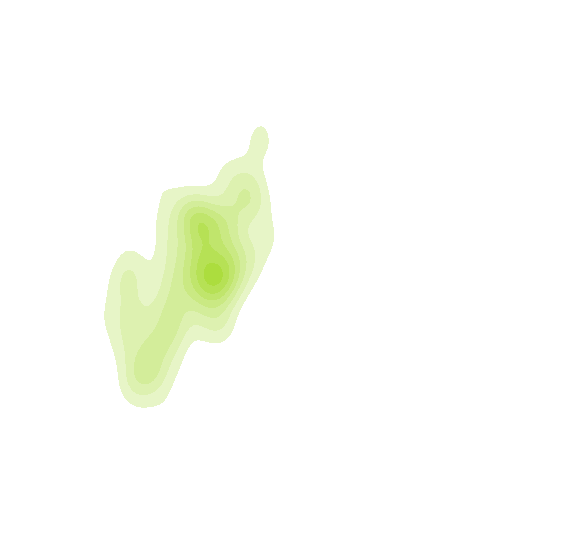

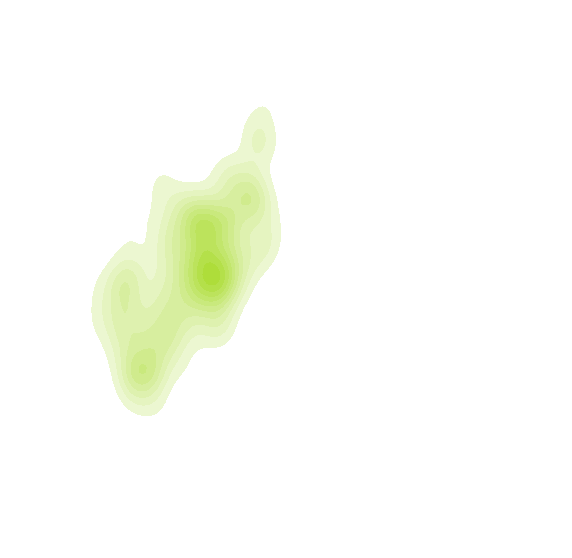

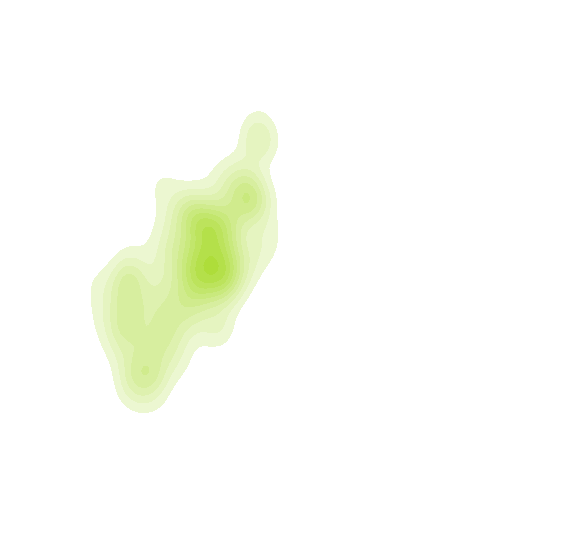

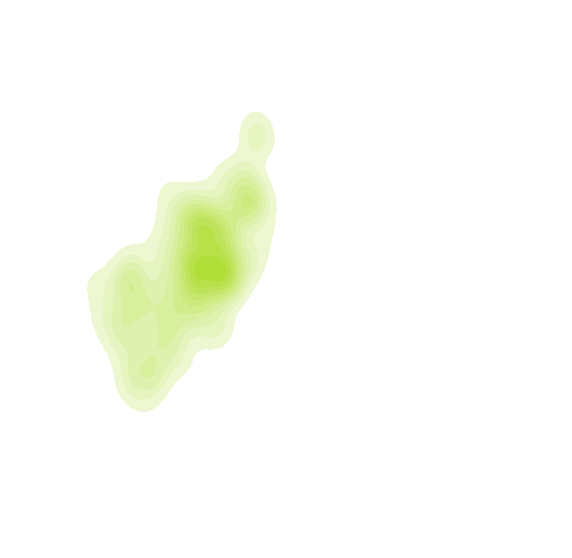

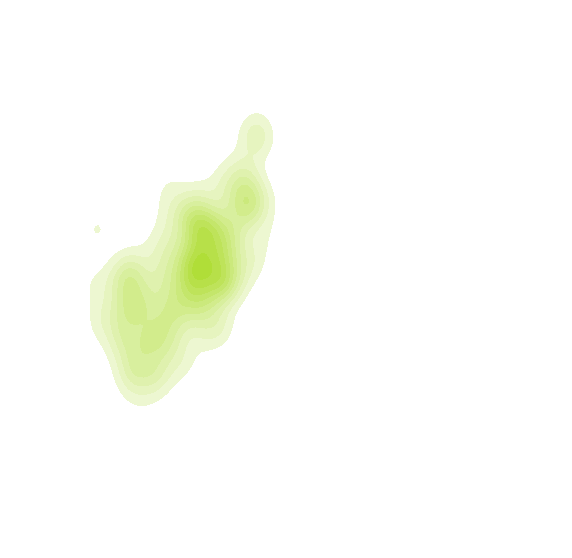

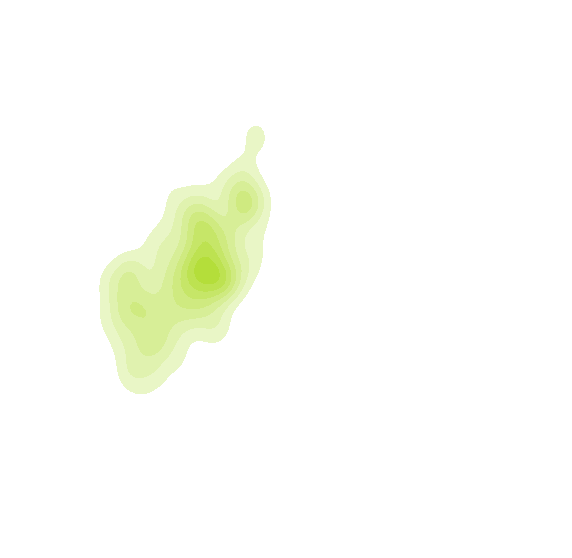

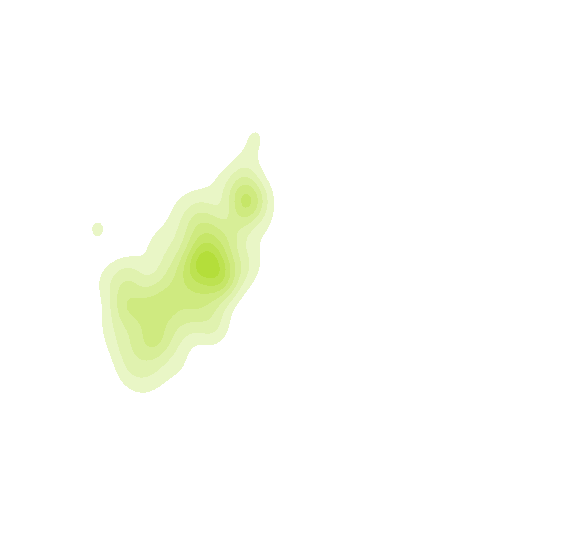

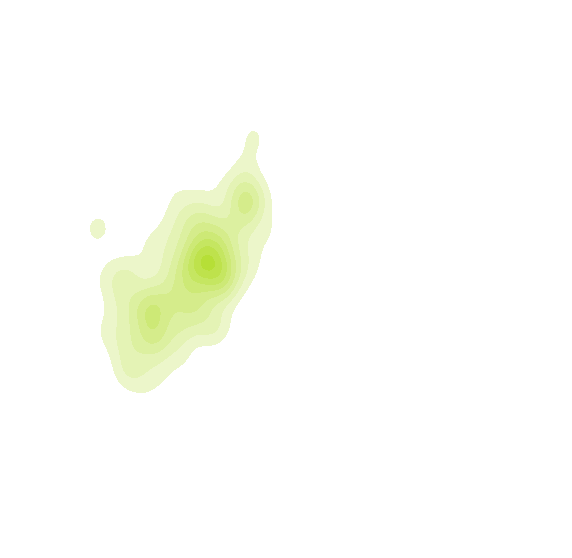

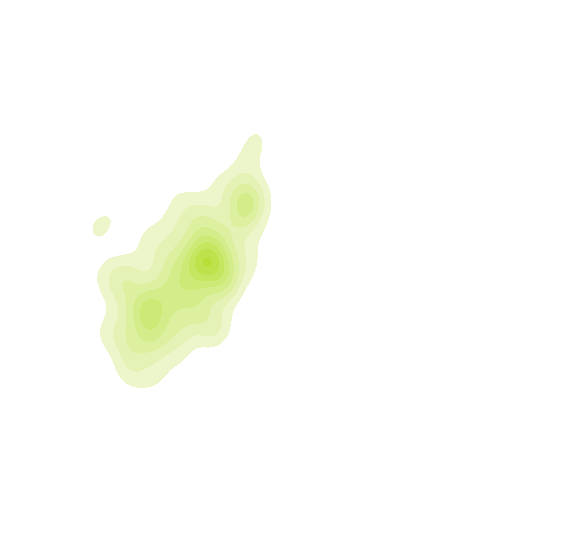

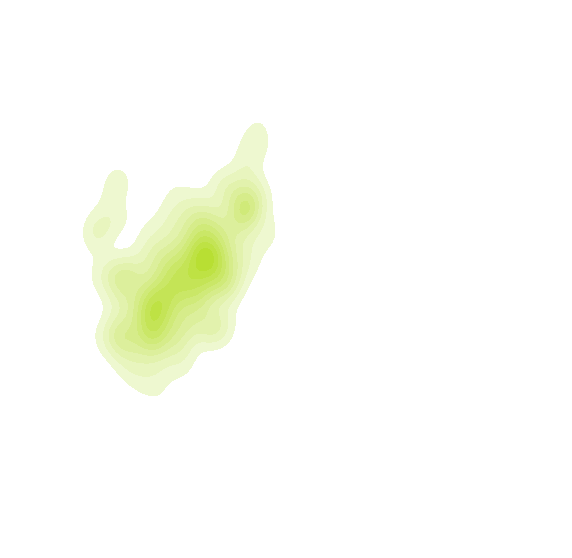

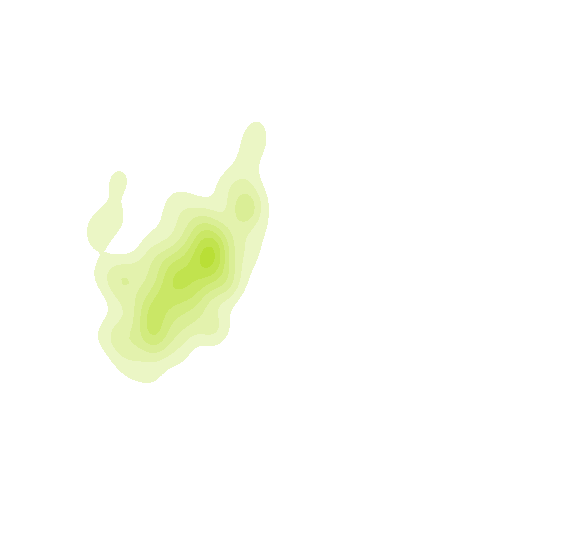

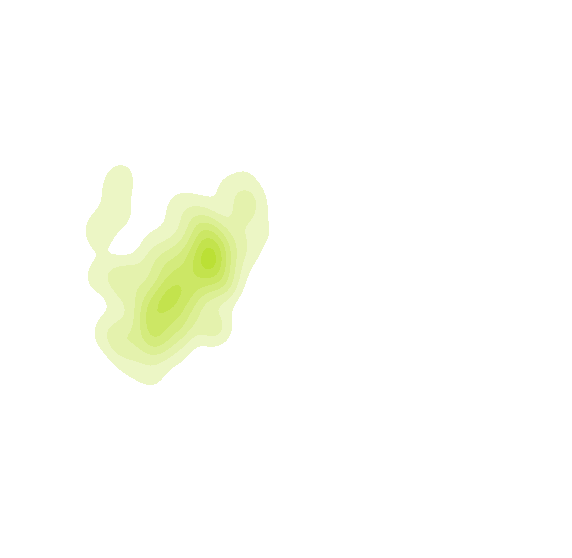

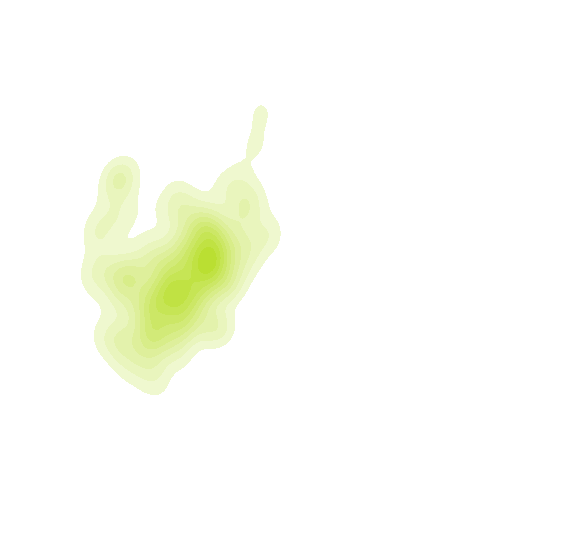

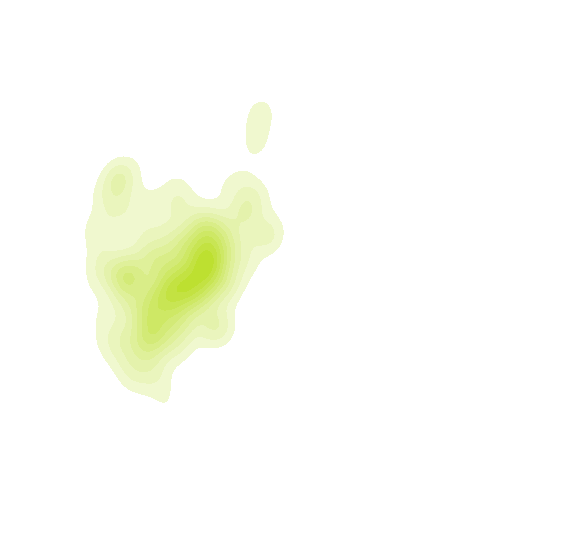

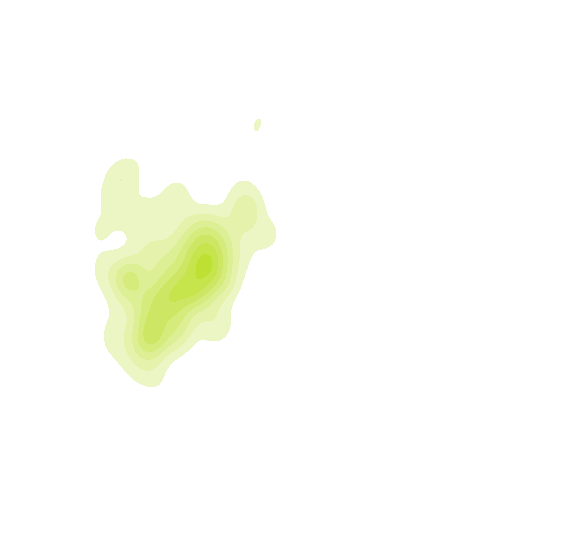

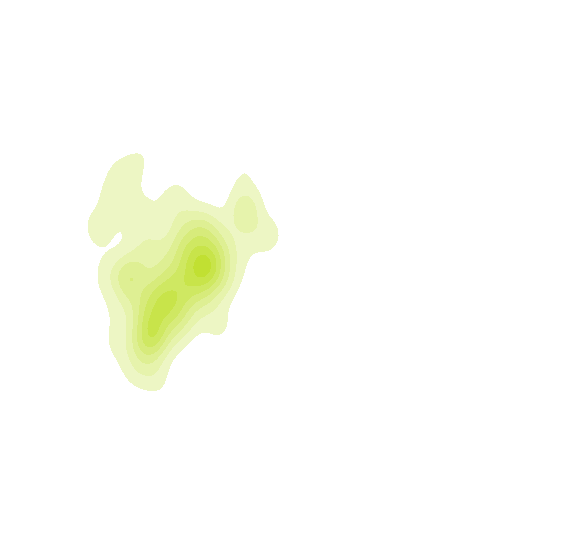

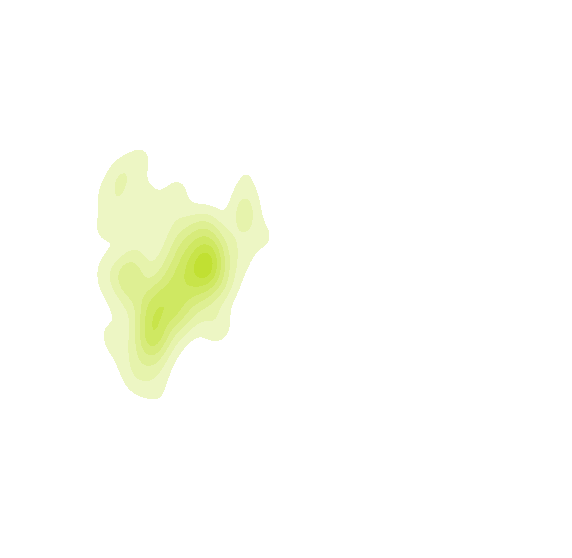

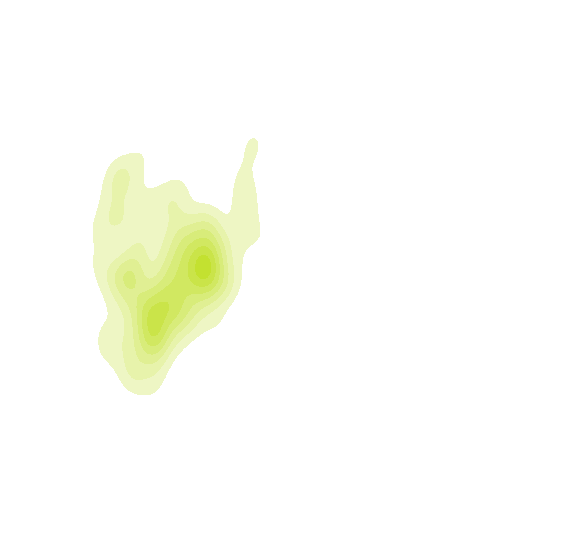

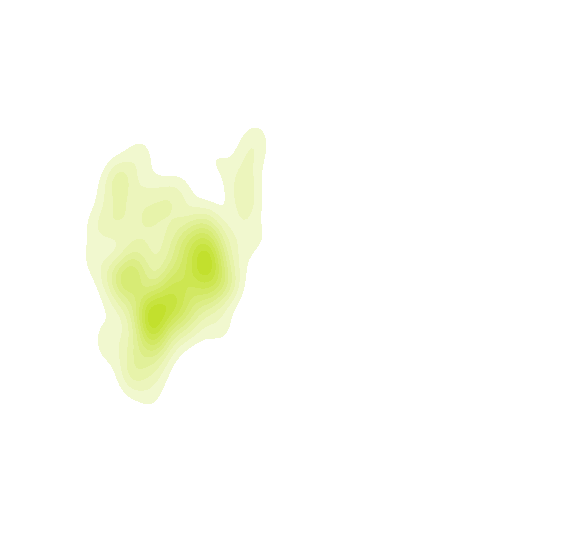

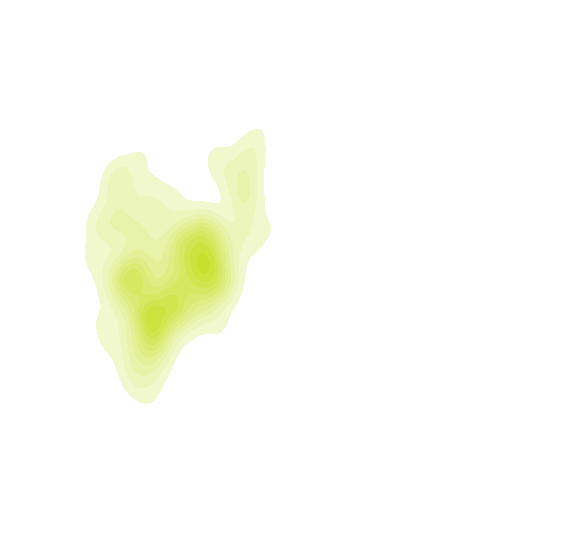

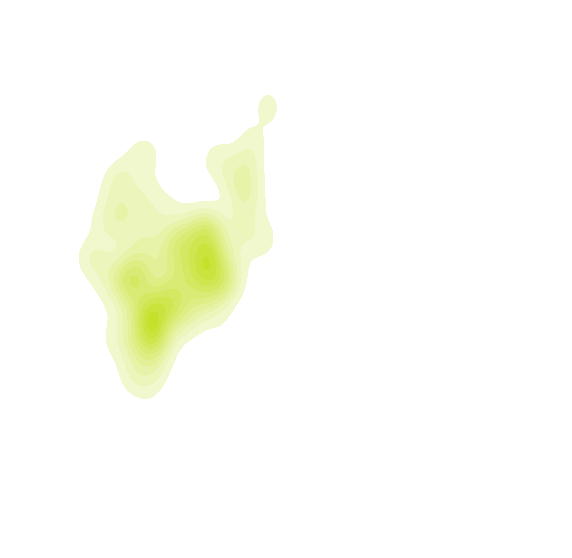

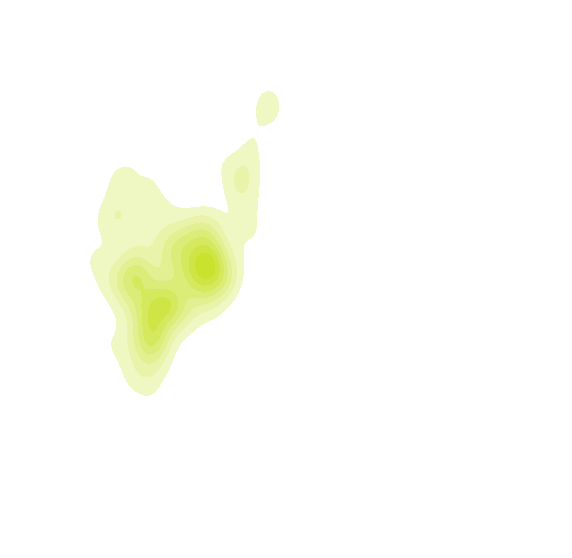

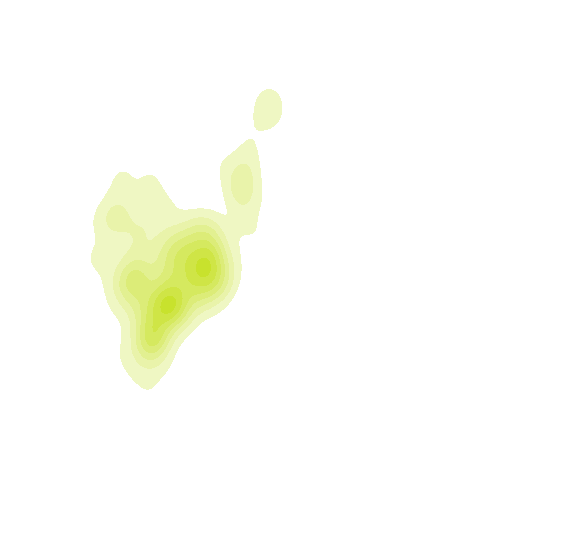

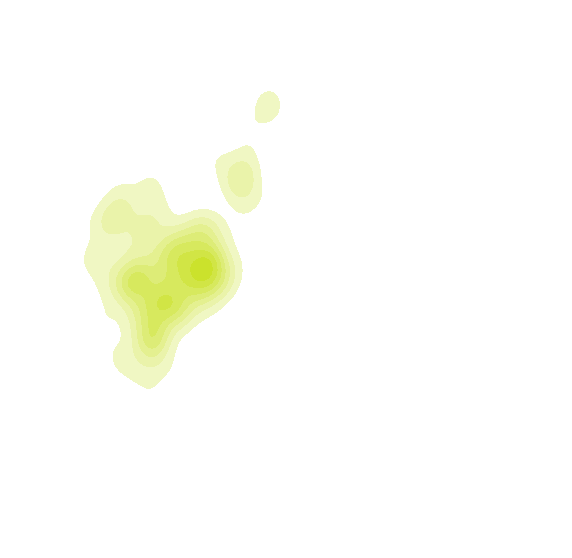

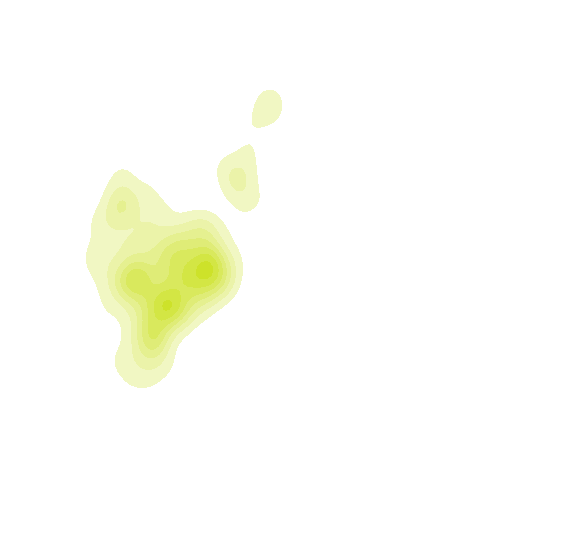

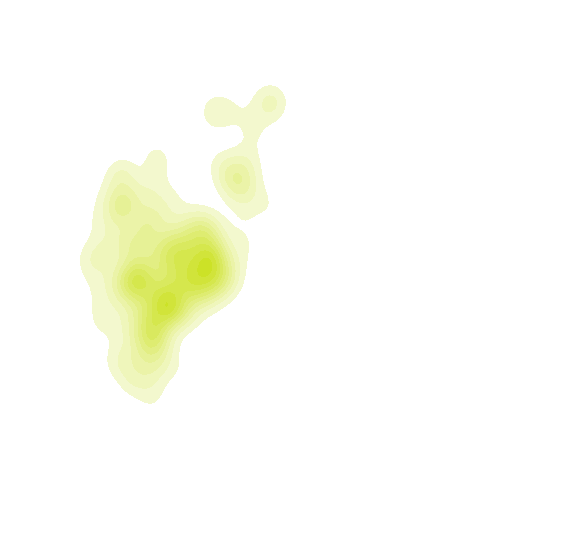

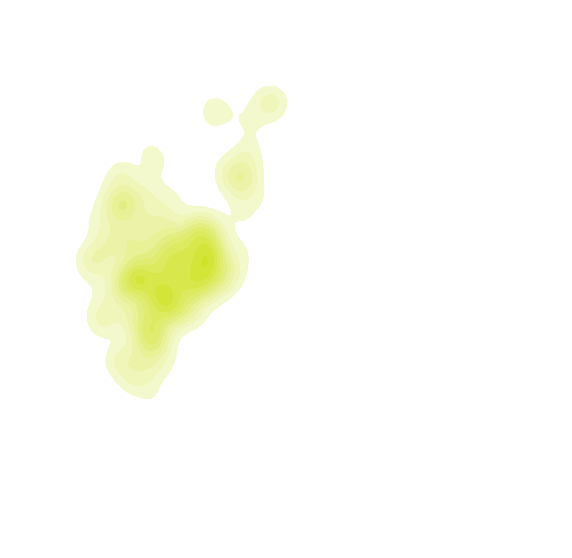

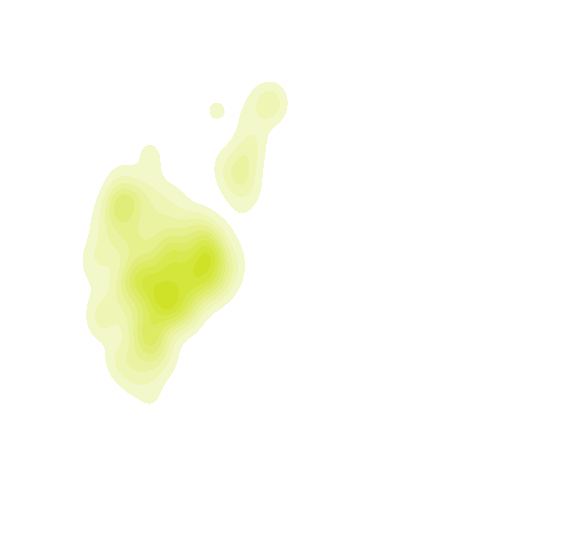

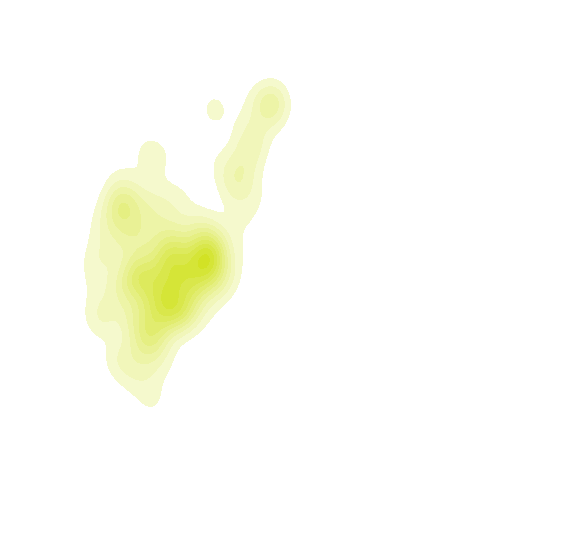

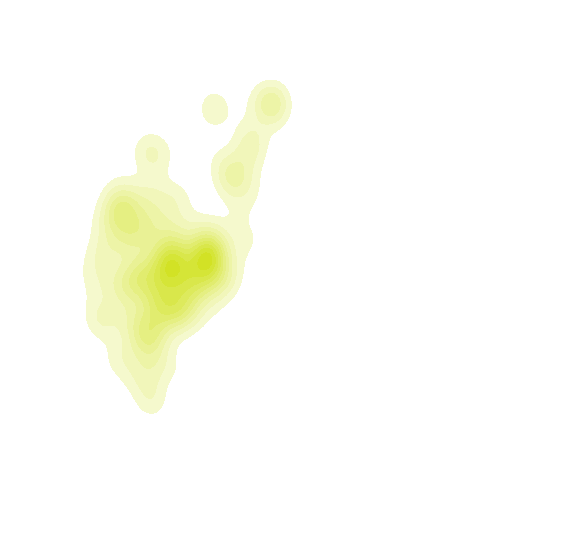

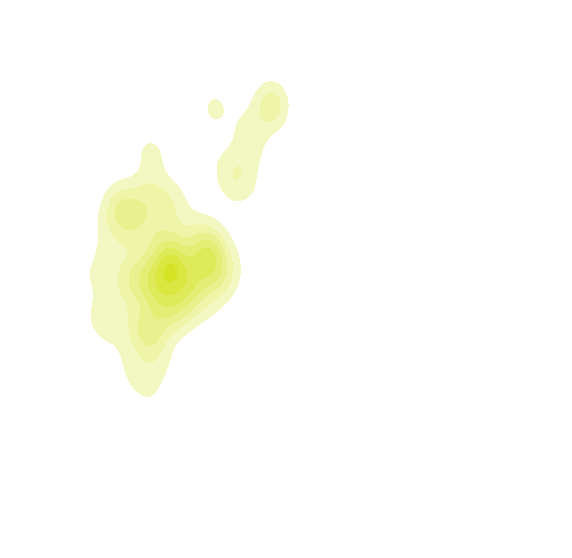

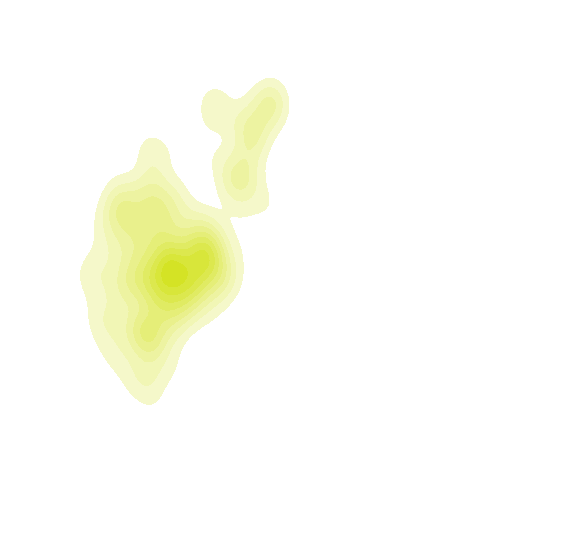

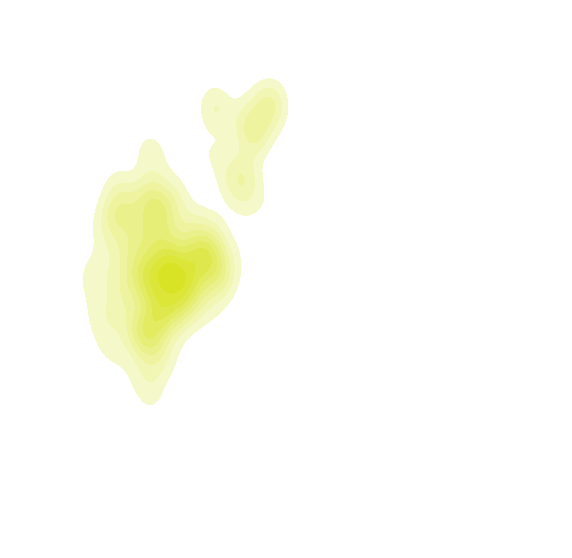

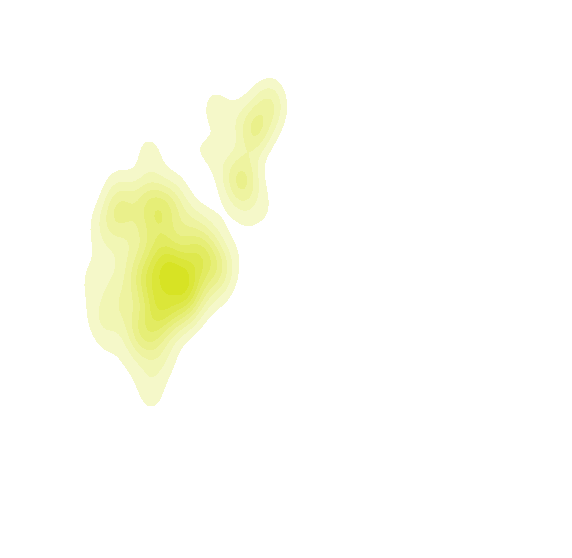

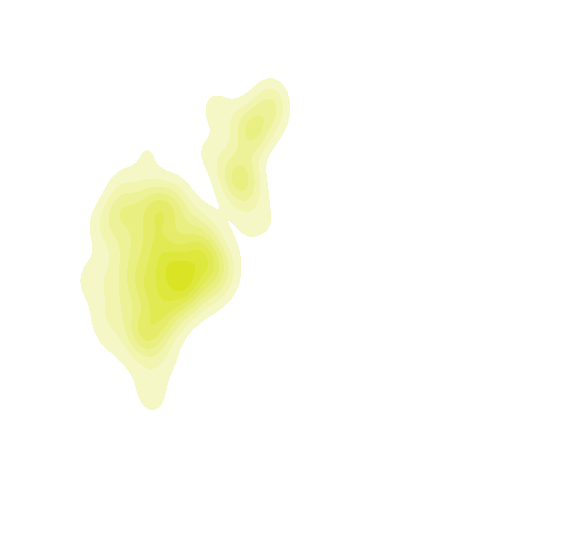

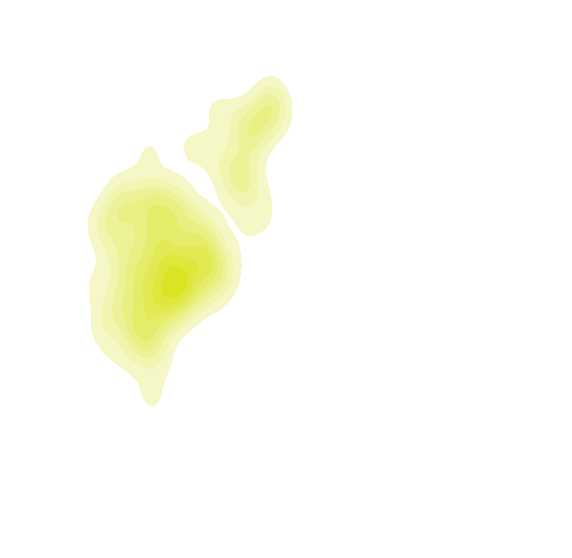

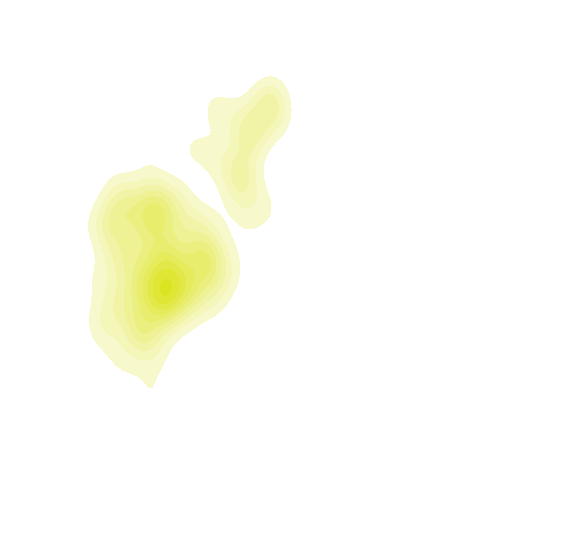

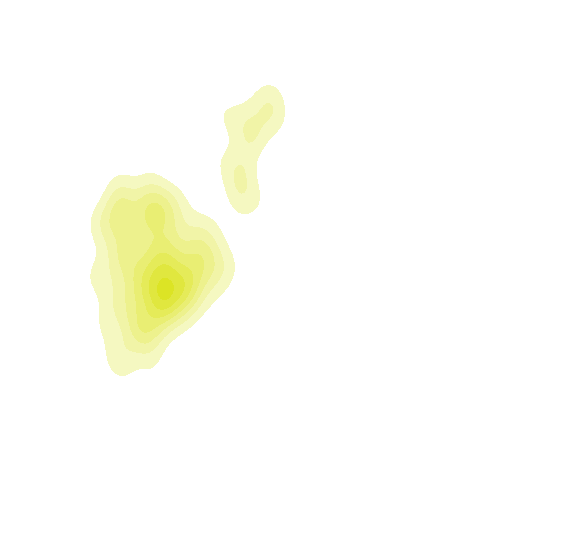

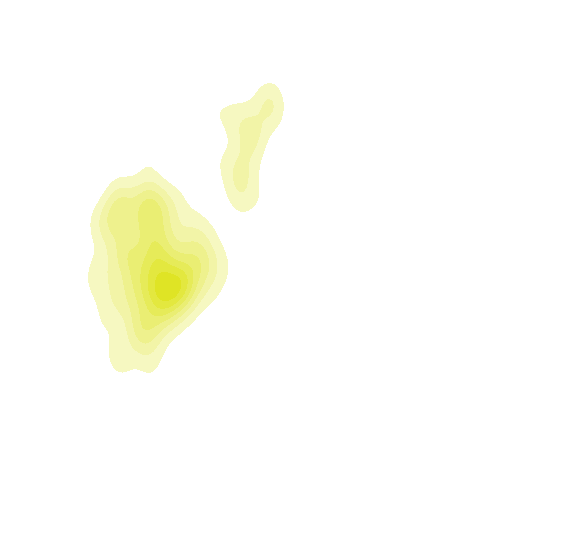

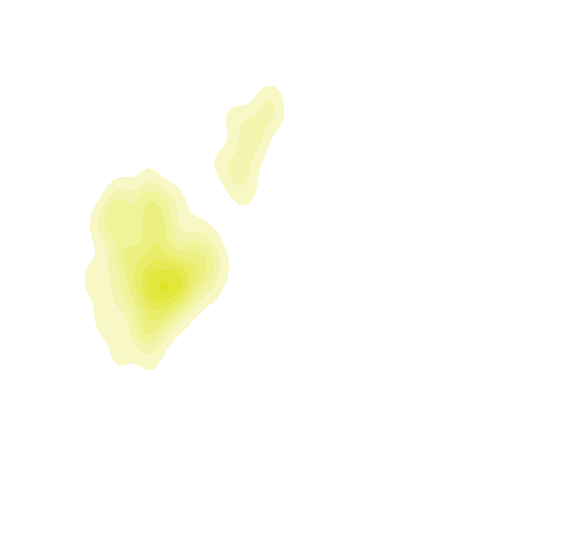

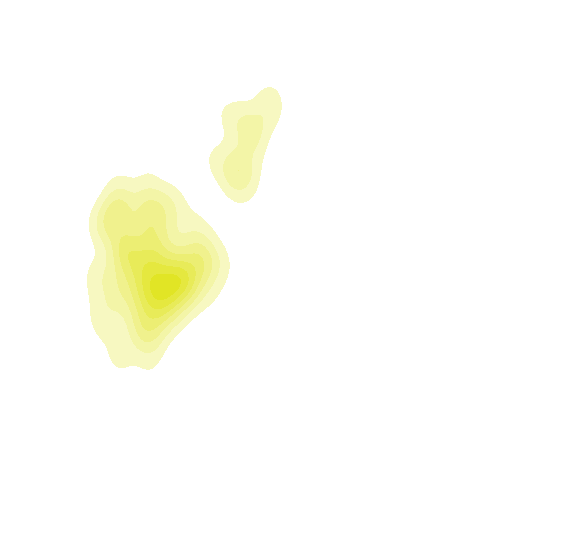

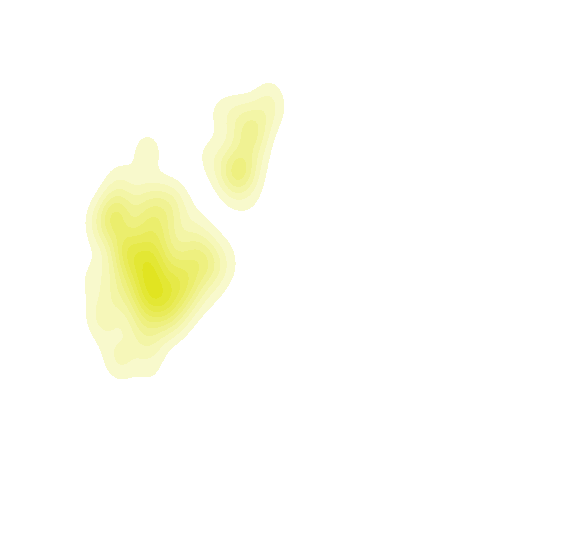

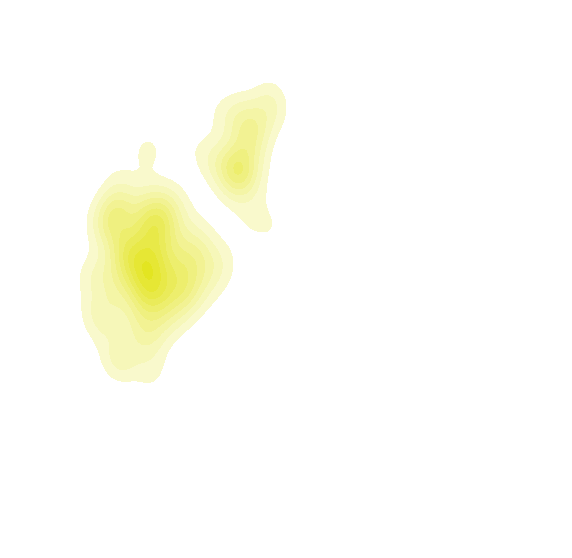

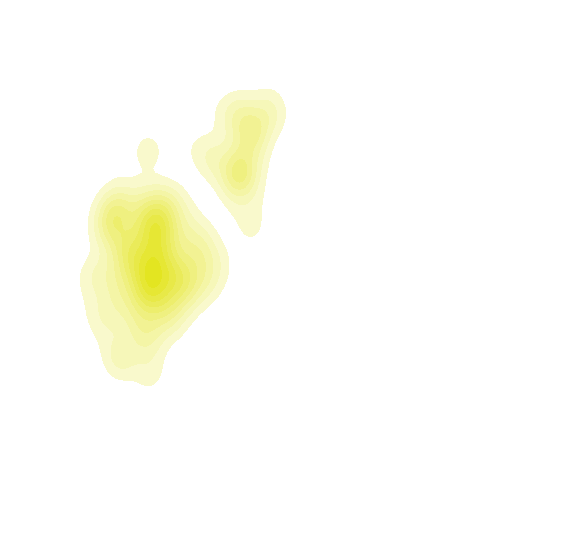

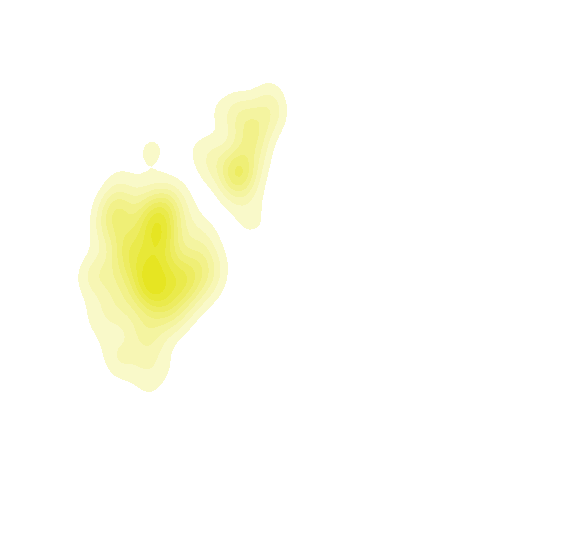

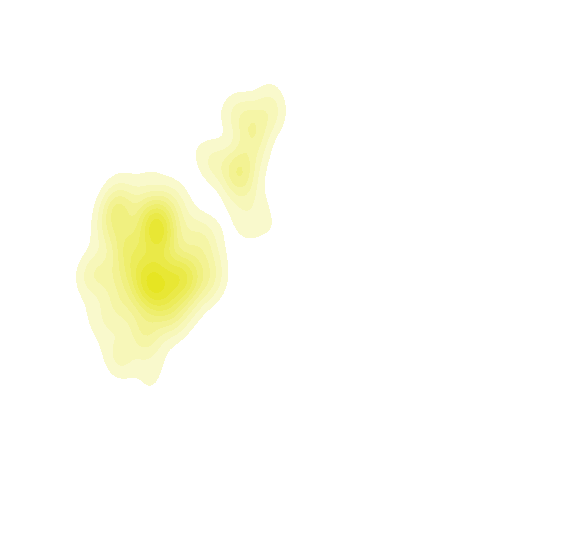

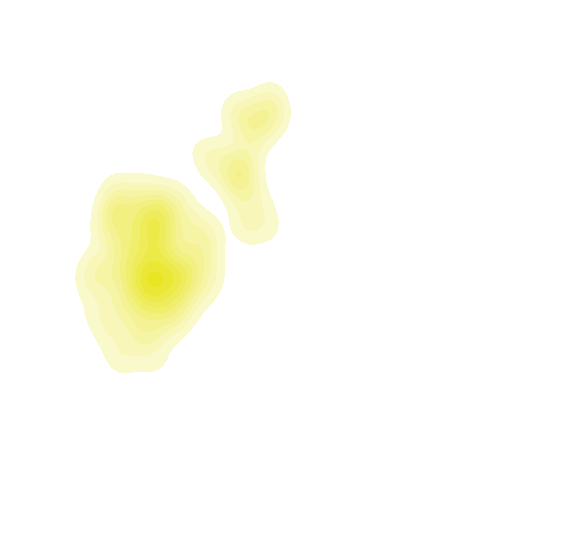

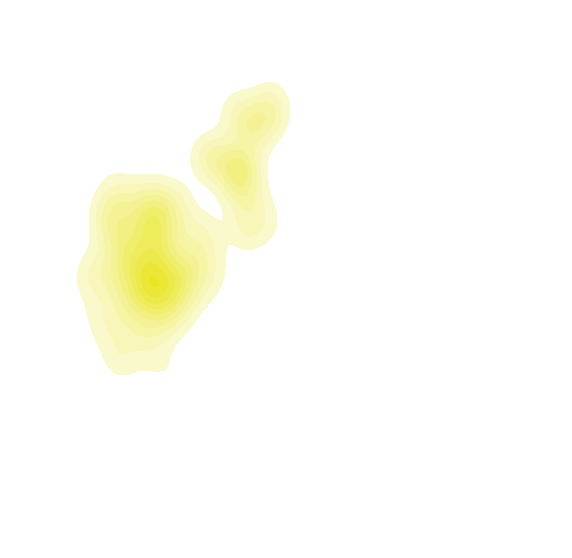

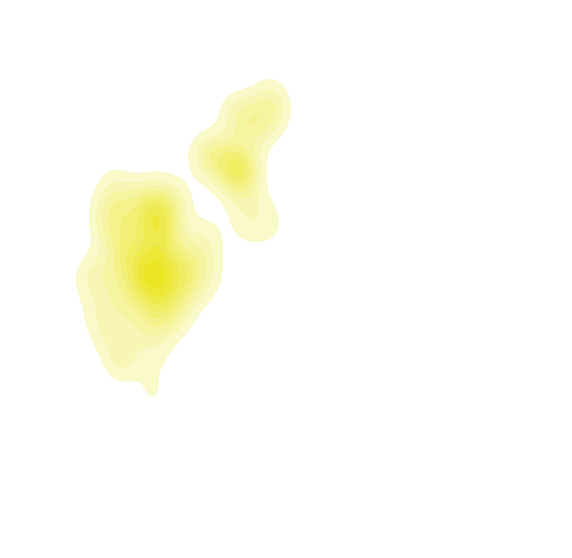

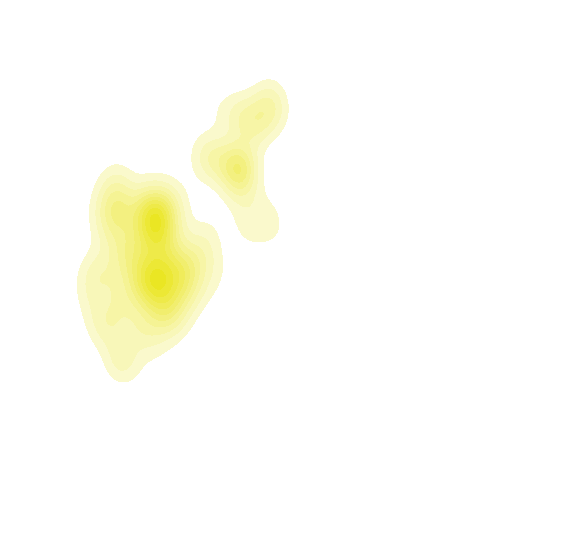

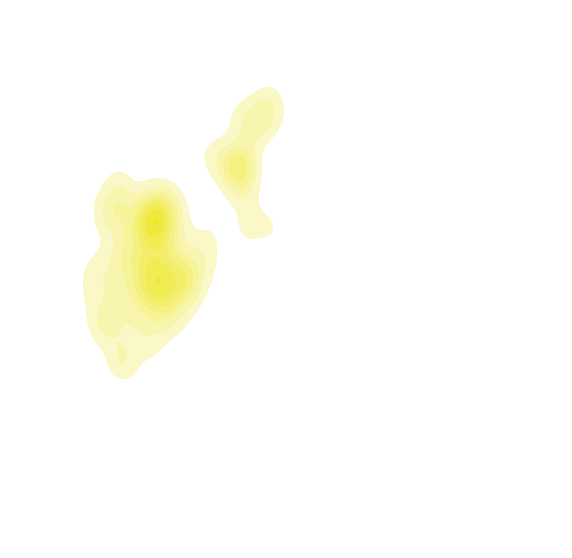

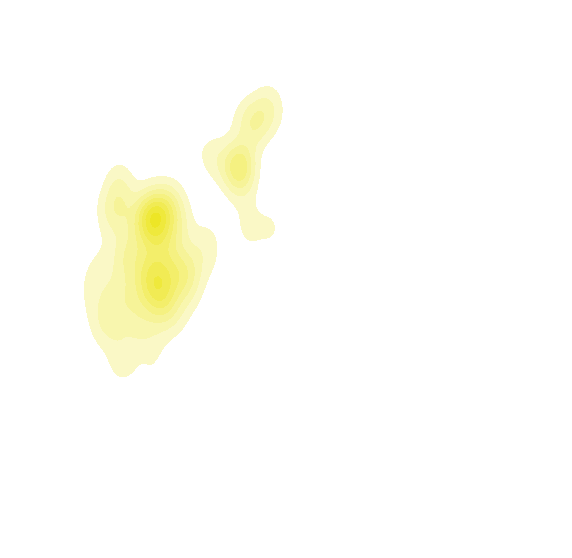

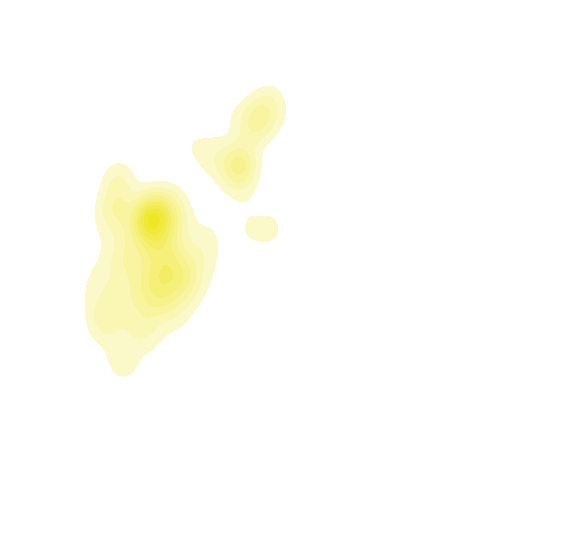

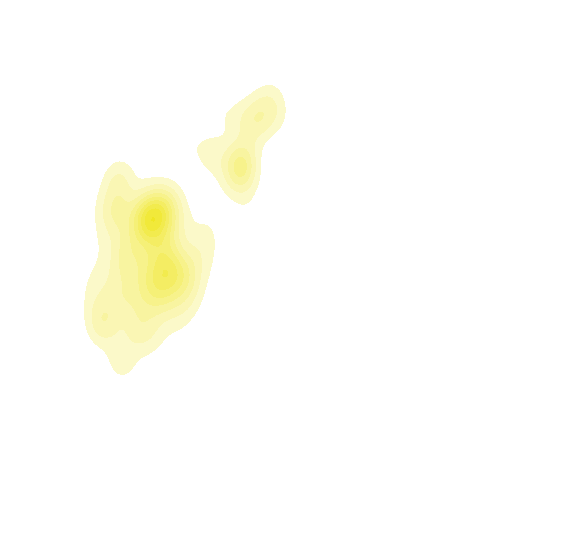

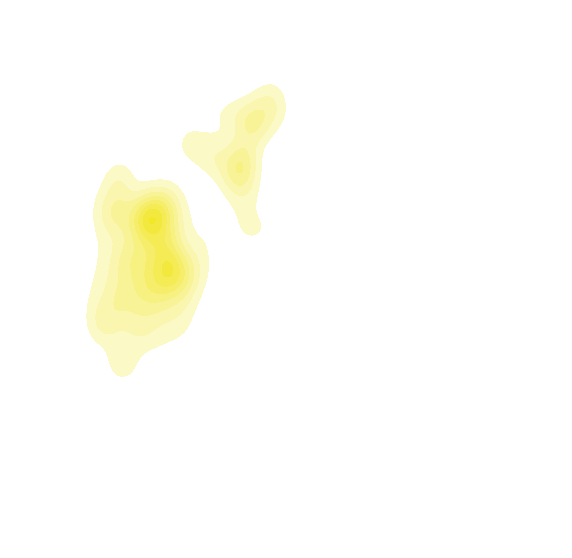

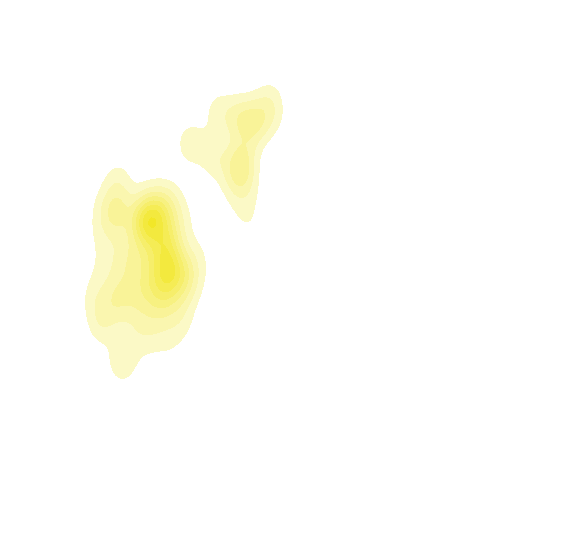

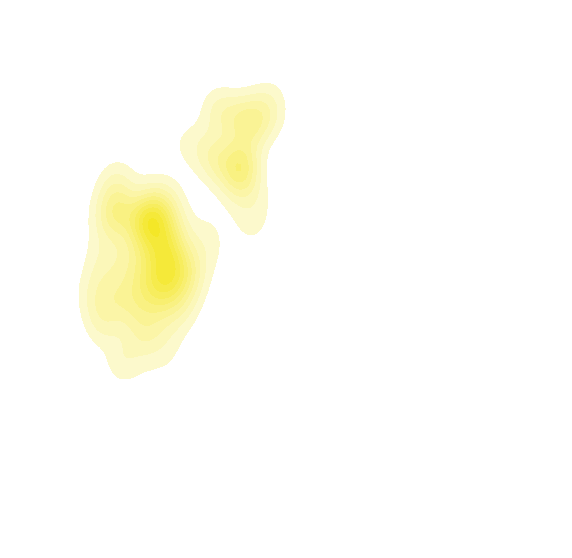

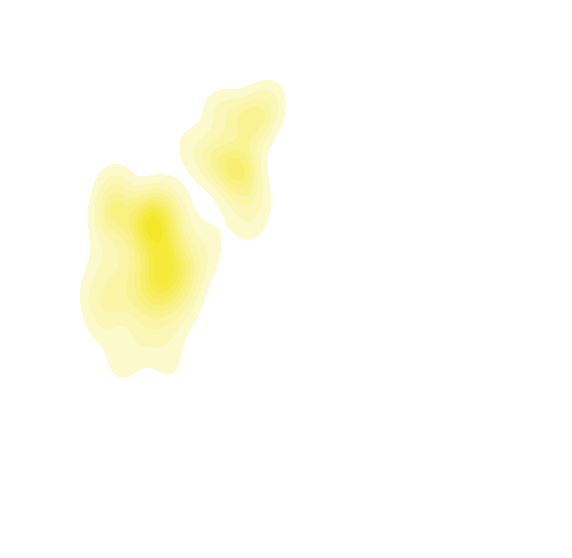

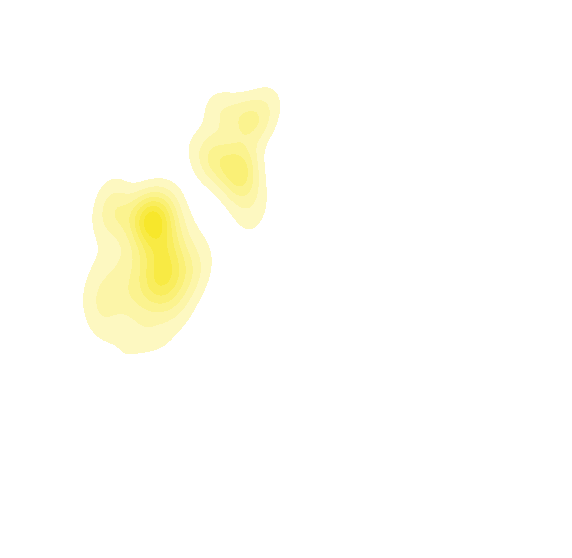

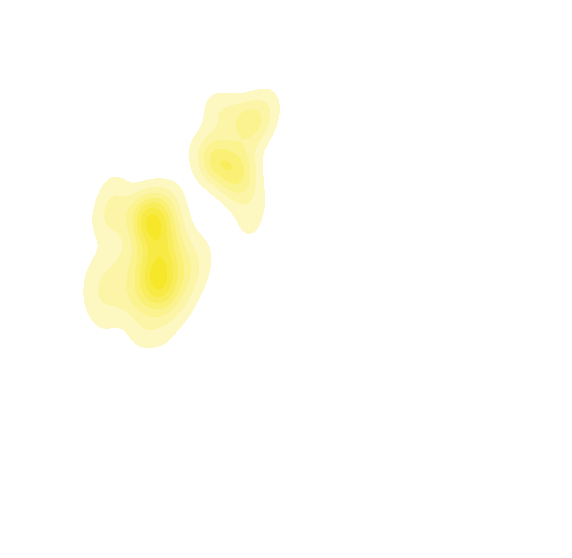

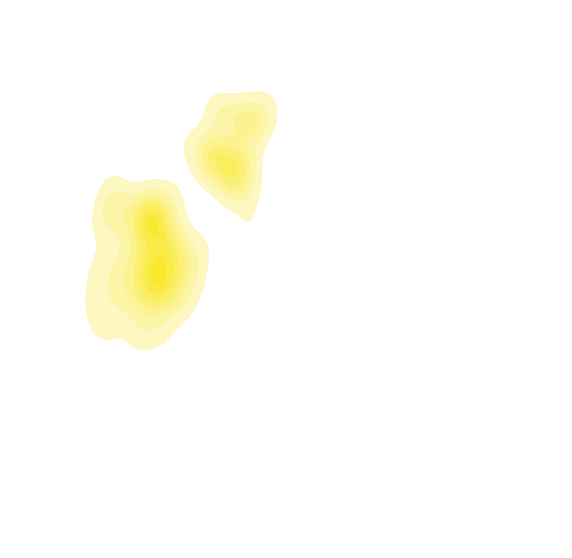

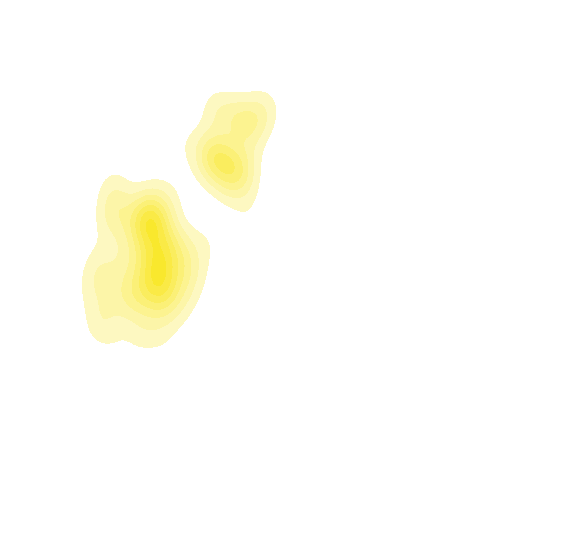

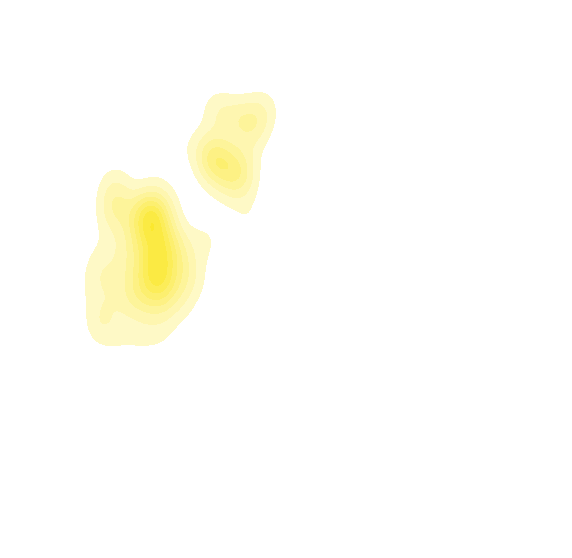

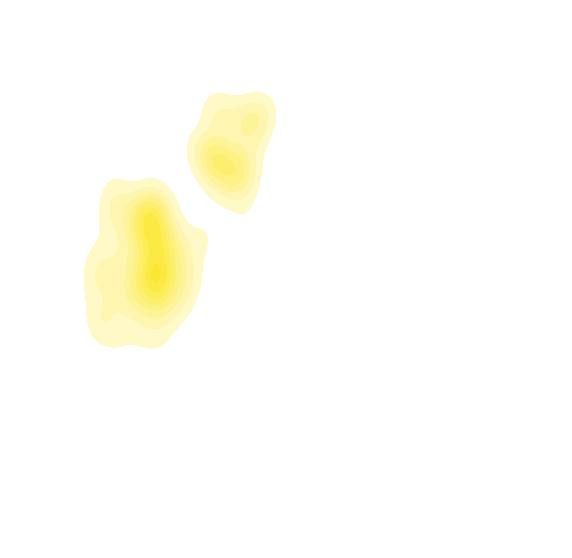

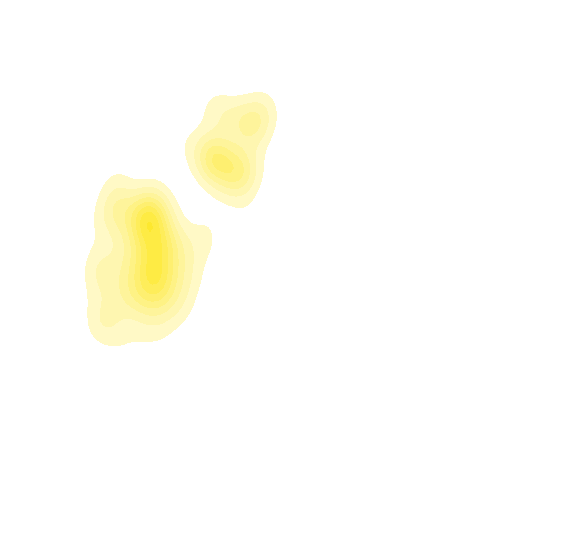

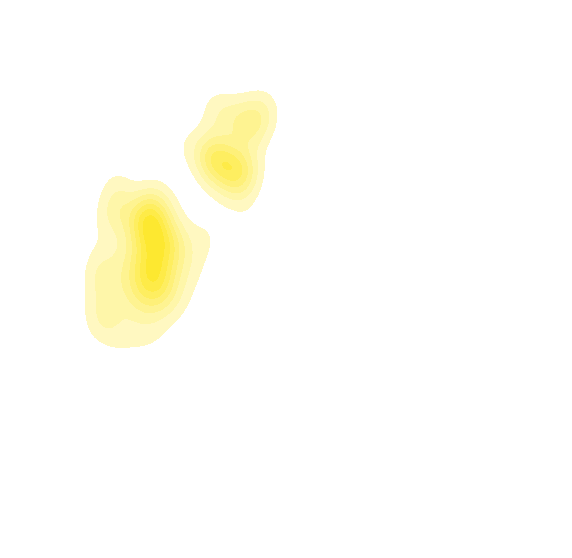

In [127]:
for i in range(500):
    plt.figure(figsize=(10,10));
    sns.kdeplot(gens[i*1000:(i+1)*1000], shade=True, shade_lowest=False, color=viridis((i+1)/500));
#     sns.kdeplot(gens[249000:250000], shade=True, shade_lowest=False, color=viridis(0.5))
#     sns.kdeplot(gens[499000:500000], shade=True, shade_lowest=False, color=viridis(0.9))
    # plt.axes().set_aspect('equal')
    plt.axes().set_xlim(-25,25);
    plt.axes().set_ylim(-25,25);
    plt.axis('off');
    fig = plt.gcf();
    fig.savefig(f'evolved_space/{i:04}.png');

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/seaborn/distributions.py:693: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


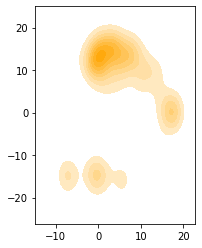

In [128]:
sns.kdeplot(gens[2000:3000], shade=True, shade_lowest=False, color='orange')
plt.axes().set_aspect('equal')